In [1]:
# You only need to run this once per machine
# !pip install -q -U bitsandbytes
# !pip install -q -U git+https://github.com/huggingface/transformers.git
# !pip install -q -U git+https://github.com/huggingface/peft.git
# !pip install -q -U git+https://github.com/huggingface/accelerate.git
# !pip install -q -U datasets scipy ipywidgets matplotlib

In [2]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

/home/chuning/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Load Dataset

In [3]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='/home/chuning/Downloads/llama/new_train_data.json', split='train')  
eval_dataset = load_dataset('json', data_files='/home/chuning/Downloads/llama/new_test_data.json', split='train')

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1238.72it/s]
Generating train split: 1995 examples [00:00, 27337.62 examples/s]
Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 2169.84it/s]
Generating train split: 222 examples [00:00, 35618.37 examples/s]


### Formatting prompts


```python
def formatting_func(example):
    text = f"### The following is a note by Eevee the Dog: {example['note']}"
    return text
```

In [4]:
def formatting_func(example):
    text = f"### The job description: {example['text']}\n ### The skills: {example['skills']}"
    return text

### 2. Load Base Model

Let's now load Llama 2 13B - `meta-llama/Llama-2-13b-hf` - using 4 or 8-bit quantization!

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig


base_model_id = "meta-llama/Llama-2-13b-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config)




Loading checkpoint shards: 100%|██████████| 3/3 [00:11<00:00,  3.68s/it]


In [6]:
# from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
# import torch


# base_model_id = "meta-llama/Llama-2-13b-hf"

# # 使用8-bit量化配置
# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=False, 
#     bnb_4bit_compute_dtype=torch.float32  
# )
# model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config).to("cuda")


### 3. Tokenization

Set up the tokenizer. Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).


For `model_max_length`, it's helpful to get a distribution of your data lengths. Let's first tokenize without the truncation/padding, so we can get a length distribution.

In [7]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

max_length = 1024
def generate_and_tokenize_prompt(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    #result["labels"] = result["input_ids"][:-1]
    result["labels"] = result["input_ids"].copy()
    return result

Reformat the prompt and tokenize each sample:

In [8]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map: 100%|██████████| 222/222 [00:00<00:00, 943.79 examples/s] 


Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

2217


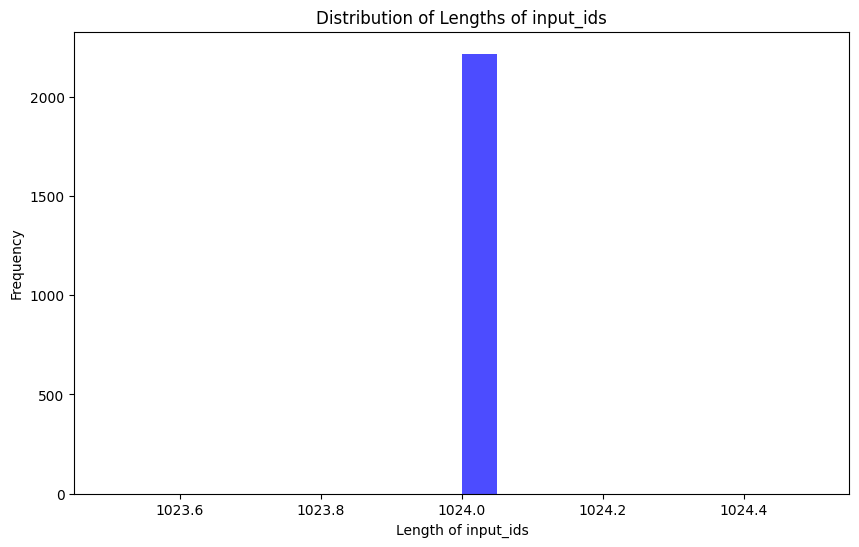

In [9]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenize_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

From here, you can choose where you'd like to set the `max_length` to be. You can truncate and pad training examples to fit them to your chosen size. Be aware that choosing a larger `max_length` has its compute tradeoffs. 

I'm using my personal notes to train the model, and they vary greatly in length. I spent some time cleaning the dataset so the samples were about the same length, cutting up individual notes if needed, but being sure to not cut in the middle of a word or sentence.

Now let's tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning).

In [10]:
# max_length = 1024
# def generate_and_tokenize_prompt(prompt):
#     result = tokenizer(
#         formatting_func(prompt),
#         truncation=True,
#         max_length=max_length,
#         padding="max_length",
#     )
#     result["labels"] = result["input_ids"].copy()
#     return result

In [11]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map: 100%|██████████| 1995/1995 [00:01<00:00, 1611.27 examples/s]


Check that `input_ids` is padded on the left with the `eos_token` (2) and there is an `eos_token` 2 added to the end, and the prompt starts with a `bos_token` (1).

In [12]:
print(tokenized_train_dataset[222])

{'id': '2264', 'text': 'POSITION SUMMARY\n\xa0\nAre you passionate about building and designing the first state-of-art personalization user experience? Are you excited to invent the world-leading next generation of personalized media products? Are you passionate about building a cutting-edge scalable high performance distributed system for processing petabytes of data, understanding hundreds of millions of users and billions of web pages, while serving each user with the most customized, related unique experience?\n\xa0\nDo you have a good understanding how business perspective could translate into system design and scientific analysis? Do you have the insights into big data to help products meet business goals and to help users enjoy a better experience?\n\xa0\nAre your communication skills, both written and verbal, something you are proud of? Is working with driven and passionate folks at one of the most trafficked destinations in the world, your dream? Have you thought about making 

Now all the samples should be the same length, `max_length`.

In [13]:
eval_prompt = f""" ### The job description: {tokenized_train_dataset[1]['text']} 

### The skills:


"""


In [14]:
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=256, pad_token_id=2)[0], skip_special_tokens=True))

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


 ### The job description: Located in the Bay Area, Geneus Tech Inc. is a subsidiary/branch research center of its parent company in China, which is dedicated to the development and commercial application of 4th generation (nanopore-based) gene sequencing solutions, including devices, IC-MEMS chips, reagents, algorithms and software systems. The core technology platform is based on the detection and processing of characteristic current signals generated by the interaction between nanopore biosensors and nucleic acid bases. Thus, high-throughput sequencing of nucleic acids can be achieved at the single-molecule level through a highly integrated chip system.
This cutting-edge technology is highly expected to revolutionize the current sequencing filed by providing results with significantly higher data quality and lower cost as well as much higher convenience and timeliness. The parent company in China just hit a major milestone to launch the alpha version of our first generation product, 

### 4. Set Up LoRA

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [15]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [16]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

In [17]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear4bit(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear4bit(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear4bit(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRM

Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=32` and `lora_alpha=64` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [18]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        # "v_proj",
        # "o_proj",
        # "gate_proj",
        # "up_proj",
        # "down_proj",
        # "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

trainable params: 26214400 || all params: 6698193920 || trainable%: 0.391365199531279


See how the model looks different now, with the LoRA adapters added:

In [19]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 5120)
        (layers): ModuleList(
          (0-39): 40 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear4bit(
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=5120, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=5120, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (base_layer): Linear4bit(in_features=5120, out_features=5120, bias=False)
              )
              (k_proj): Linear4bit(
                (lora_dropout): ModuleDict(
       


Let's use Weights & Biases to track our training metrics. You'll need to apply an API key when prompted. Feel free to skip this if you'd like, and just comment out the `wandb` parameters in the `Trainer` definition below.

In [20]:
#!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "IPG-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: liuchuning831. Use `wandb login --relogin` to force relogin


### 5. Run Training!

In [21]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [22]:
from torch import nn
import transformers
from transformers import Trainer


#3 add label smoothing
# import torch
# import torch.nn.functional as F

# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.pop("labels", None)
#         pos_labels = inputs.pop("skills", None)
#         neg_labels = inputs.pop("not_skills", None)
#         outputs = model(**inputs)
#         logits = outputs.logits
        
#         epsilon = 0.1
#         ignore_index = -100

#         def label_smooth_loss(logits, labels):
#             # 标签维度和对数概率的维度要相匹配
#             if labels.dim() == logits.dim() - 1:
#                 labels = labels.unsqueeze(-1)
#             padding_mask = labels.eq(ignore_index)
#             labels = torch.clamp(labels, min=0)
#             log_probs = -F.log_softmax(logits, dim=-1)
#             nll_loss = log_probs.gather(dim=-1, index=labels)
#             nll_loss.masked_fill_(padding_mask, 0.0)
#             num_active_elements = padding_mask.numel() - padding_mask.long().sum()
#             nll_loss = nll_loss.sum() / num_active_elements
#             smoothed_loss = log_probs.sum(dim=-1, keepdim=True)
#             smoothed_loss.masked_fill_(padding_mask, 0.0)
#             smoothed_loss = smoothed_loss.sum() / (num_active_elements * logits.shape[-1])

#             return (1 - epsilon) * nll_loss + epsilon * smoothed_loss

#         if pos_labels is not None:
#             loss_like = label_smooth_loss(logits.view(-1, logits.size(-1)), pos_labels.view(-1))
#         else:
#             loss_like = torch.tensor(0.0).to(logits.device)

#         if neg_labels is not None:
#             loss_dislike = label_smooth_loss(logits.view(-1, logits.size(-1)), neg_labels.view(-1))
#         else:
#             loss_dislike = torch.tensor(0.0).to(logits.device)

#         w_like = 1
#         w_dislike = 0.991
#         w_l = 0.99

#         balance_term = torch.sqrt(loss_like ** 2 + loss_dislike ** 2)
#         total_loss = w_like * loss_like - w_dislike * loss_dislike + w_l * balance_term

#         if labels is not None:
#             original_loss = label_smooth_loss(logits.view(-1, logits.size(-1)), labels.view(-1))
#             total_loss += original_loss
#         print("Total loss with original labels:", total_loss.item())
#         wandb.log({"custom_loss": total_loss.item()})
#         return (total_loss, outputs) if return_outputs else total_loss

    

# #2 custom loss weight
# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.pop("labels", None)
#         pos_labels = inputs.pop("skills", None)
#         neg_labels = inputs.pop("not_skills", None)
#         outputs = model(**inputs)
#         logits = outputs.logits

#         loss_fct = torch.nn.CrossEntropyLoss()


#         w_like = 1
#         w_dislike = 0.991
#         w_l = 0.99

#         if pos_labels is not None:
#             loss_like = loss_fct(logits.view(-1, logits.size(-1)), pos_labels.view(-1))
#         else:
#             loss_like = torch.tensor(0.0).to(logits.device)
#         if neg_labels is not None:
#             loss_dislike = loss_fct(logits.view(-1, logits.size(-1)), neg_labels.view(-1))
#         else:
#             loss_dislike = torch.tensor(0.0).to(logits.device)

#         balance_term = torch.sqrt(loss_like ** 2 + loss_dislike ** 2)

#         total_loss = w_like * loss_like - w_dislike * loss_dislike + w_l * balance_term

#         if labels is not None:
#             original_loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
#             total_loss += original_loss

#         print("Total loss with original labels:", total_loss.item())
#         wandb.log({"custom_loss": total_loss.item()})
#         return (total_loss, outputs) if return_outputs else total_loss


# # base on 1 self define loss
# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         labels = inputs.pop("labels", None)
#         pos_labels = inputs.pop("skills", None)
#         neg_labels = inputs.pop("not_skills", None)

#         print("Shape of input_ids:", inputs["input_ids"].shape)  
#         if labels is not None:
#             print("Shape of labels:", labels.shape)
#         if pos_labels is not None:
#             print("Shape of positive labels:", pos_labels.shape)
#         if neg_labels is not None:
#             print("Shape of negative labels:", neg_labels.shape)

#         outputs = model(**inputs)
#         logits = outputs.logits



#         loss_fct = torch.nn.CrossEntropyLoss()


#         total_loss = torch.tensor(0.0).to(logits.device)

#         if pos_labels is not None:
#             pos_loss = loss_fct(logits.view(-1, logits.size(-1)), pos_labels.view(-1))
#         else:
#             pos_loss = torch.tensor(0.0).to(logits.device)


#         if neg_labels is not None:
#             neg_loss = loss_fct(logits.view(-1, logits.size(-1)), neg_labels.view(-1))
#         else:
#             neg_loss = torch.tensor(0.0).to(logits.device)


#         alpha = 0.2 
#         balance_term = torch.sqrt(pos_loss ** 2 + alpha * neg_loss ** 2)


#         total_loss = pos_loss + balance_term


#         if labels is not None:
#             original_loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
#             total_loss += original_loss

#         print("Total loss with original labels:", total_loss.item())
#         return (total_loss, outputs) if return_outputs else total_loss




    
# # 1原版可以用
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        """
        How the loss is computed by Trainer. By default, all models return the loss in the first element.

        Subclass and override for custom behavior.
        """
        if self.label_smoother is not None and "labels" in inputs:
            labels = inputs.pop("labels")
        else:
            labels = None
        outputs = model(**inputs)
        # Save past state if it exists
        # TODO: this needs to be fixed and made cleaner later.
        if self.args.past_index >= 0:
            self._past = outputs[self.args.past_index]

        if labels is not None:
            unwrapped_model = unwrap_model(model)
            if is_peft_available() and isinstance(unwrapped_model, PeftModel):
                model_name = unwrapped_model.base_model.model._get_name()
            else:
                model_name = unwrapped_model._get_name()
            if model_name in MODEL_FOR_CAUSAL_LM_MAPPING_NAMES.values():
                loss = self.label_smoother(outputs, labels, shift_labels=True)
            else:
                loss = self.label_smoother(outputs, labels)
        else:
            if isinstance(outputs, dict) and "loss" not in outputs:
                raise ValueError(
                    "The model did not return a loss from the inputs, only the following keys: "
                    f"{','.join(outputs.keys())}. For reference, the inputs it received are {','.join(inputs.keys())}."
                )
            # We don't use .loss here since the model may return tuples instead of ModelOutput.
            loss = outputs["loss"] if isinstance(outputs, dict) else outputs[0]
        wandb.log({"custom_loss": loss.item()})
        print("Loss:", loss.item())
        return (loss, outputs) if return_outputs else loss



In [23]:
import subprocess
import threading

# def log_gpu_memory(log_file_path, interval=60):
#     gpu_memory_usage = subprocess.check_output(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,nounits,noheader']).decode('utf-8')
#     with open(log_file_path, 'a') as log_file:
#         log_file.write(f"GPU: {gpu_memory_usage}\n")

#     threading.Timer(interval, log_gpu_memory, args=[log_file_path, interval]).start()

# # 启动GPU内存监控
# log_file_path = 'gpu_memory_log.txt'
# log_gpu_memory(log_file_path)


from datetime import datetime

project = "IPG-finetune"
base_model_name = "llama2-13b"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token


training_args = transformers.TrainingArguments(
    output_dir=output_dir,
    warmup_steps=4,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    max_steps=3000,
    learning_rate=2.5e-5,
    bf16=True,
    optim="paged_adamw_8bit",
    logging_dir="./logs",
    save_strategy="steps",
    save_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    do_eval=True,
    report_to="wandb",
    run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"
)




trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

# trainer = transformers.Trainer(
#     model=model,
#     train_dataset=tokenized_train_dataset,
#     eval_dataset=tokenized_val_dataset,
#     args=transformers.TrainingArguments(
#         output_dir=output_dir,
#         warmup_steps=4,
#         per_device_train_batch_size=4,
#         gradient_accumulation_steps=4,
#         max_steps=3000,
#         learning_rate=2.5e-5, # Want a small lr for finetuning
#         bf16=True,
#         optim="paged_adamw_8bit",
#         logging_dir="./logs",        # Directory for storing logs
#         save_strategy="steps",       # Save the model checkpoint every logging step
#         save_steps=100,                # Save checkpoints every 50 steps
#         evaluation_strategy="steps", # Evaluate the model every logging step
#         eval_steps=100,               # Evaluate and save checkpoints every 50 steps
#         do_eval=True,                # Perform evaluation at the end of training
#         report_to="wandb",           # Comment this out if you don't want to use weights & baises
#         run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
#     ),
#     data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
# )

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

  0%|          | 0/3000 [00:00<?, ?it/s]You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 2.02595853805542
Loss: 1.9607608318328857
Loss: 1.9608154296875
Loss: 2.334289073944092


  0%|          | 1/3000 [00:31<26:11:48, 31.45s/it]

Loss: 2.0164828300476074
Loss: 2.2590911388397217
Loss: 2.008805513381958
Loss: 2.0049407482147217


  0%|          | 2/3000 [01:03<26:17:55, 31.58s/it]

Loss: 1.8617745637893677
Loss: 2.0482165813446045
Loss: 2.168335437774658
Loss: 2.1776552200317383


  0%|          | 3/3000 [01:34<26:21:55, 31.67s/it]

Loss: 1.8622665405273438
Loss: 2.1352579593658447
Loss: 2.411430597305298
Loss: 2.2149899005889893


  0%|          | 4/3000 [02:06<26:24:30, 31.73s/it]

Loss: 2.164027690887451
Loss: 2.297258138656616
Loss: 2.2913129329681396
Loss: 1.710213303565979


  0%|          | 5/3000 [02:38<26:25:33, 31.76s/it]

Loss: 1.8639365434646606
Loss: 2.0894765853881836
Loss: 1.7986899614334106
Loss: 2.048478603363037


  0%|          | 6/3000 [03:10<26:30:42, 31.88s/it]

Loss: 2.147348403930664
Loss: 2.026876211166382
Loss: 2.0619678497314453
Loss: 2.121443033218384


  0%|          | 7/3000 [03:42<26:26:57, 31.81s/it]

Loss: 1.9966228008270264
Loss: 2.129316568374634
Loss: 2.0326881408691406
Loss: 2.174877166748047


  0%|          | 8/3000 [04:13<26:23:58, 31.76s/it]

Loss: 2.056908369064331
Loss: 2.004249334335327
Loss: 2.1656899452209473
Loss: 2.256972074508667


  0%|          | 9/3000 [04:45<26:22:44, 31.75s/it]

Loss: 1.8275861740112305
Loss: 2.0165340900421143
Loss: 2.140695333480835
Loss: 2.084944009780884


  0%|          | 10/3000 [05:17<26:23:43, 31.78s/it]

Loss: 2.081599712371826
Loss: 1.9798920154571533
Loss: 2.212893009185791
Loss: 2.037553071975708


  0%|          | 11/3000 [05:49<26:24:08, 31.80s/it]

Loss: 2.046928644180298
Loss: 1.9059646129608154
Loss: 1.944460391998291
Loss: 2.222956895828247


  0%|          | 12/3000 [06:21<26:23:24, 31.80s/it]

Loss: 2.0879507064819336
Loss: 2.1464297771453857
Loss: 2.0594613552093506
Loss: 1.9238954782485962


  0%|          | 13/3000 [06:53<26:23:30, 31.81s/it]

Loss: 2.226140022277832
Loss: 2.3640143871307373
Loss: 2.010993719100952
Loss: 1.9911893606185913


  0%|          | 14/3000 [07:24<26:23:21, 31.82s/it]

Loss: 2.170301675796509
Loss: 1.8333418369293213
Loss: 2.248734712600708
Loss: 1.8967597484588623


  0%|          | 15/3000 [07:56<26:23:12, 31.82s/it]

Loss: 1.917892336845398
Loss: 2.000779151916504
Loss: 1.9781968593597412
Loss: 2.128058433532715


  1%|          | 16/3000 [08:28<26:23:40, 31.84s/it]

Loss: 2.32737398147583
Loss: 2.240635633468628
Loss: 2.2477521896362305
Loss: 2.2645516395568848


  1%|          | 17/3000 [09:00<26:21:45, 31.82s/it]

Loss: 2.109165906906128
Loss: 1.9407693147659302
Loss: 1.9640138149261475
Loss: 1.9606037139892578


  1%|          | 18/3000 [09:32<26:20:37, 31.80s/it]

Loss: 2.011462450027466
Loss: 2.1418399810791016
Loss: 2.3110098838806152
Loss: 2.3704285621643066


  1%|          | 19/3000 [10:03<26:19:53, 31.80s/it]

Loss: 2.142695188522339
Loss: 1.8997609615325928
Loss: 2.233367443084717
Loss: 2.125200033187866


  1%|          | 20/3000 [10:35<26:19:35, 31.80s/it]

Loss: 2.2289392948150635
Loss: 2.1332943439483643
Loss: 2.1154778003692627
Loss: 1.9626121520996094


  1%|          | 21/3000 [11:07<26:20:22, 31.83s/it]

Loss: 2.0287935733795166
Loss: 2.1776602268218994
Loss: 1.639772891998291
Loss: 2.0542545318603516


  1%|          | 22/3000 [11:39<26:23:31, 31.90s/it]

Loss: 1.9614990949630737
Loss: 2.268716335296631
Loss: 2.10809063911438
Loss: 2.1488678455352783


  1%|          | 23/3000 [12:11<26:21:19, 31.87s/it]

Loss: 2.1156866550445557
Loss: 1.9014208316802979
Loss: 1.589381217956543
Loss: 2.1779918670654297


  1%|          | 24/3000 [12:43<26:20:18, 31.86s/it]

Loss: 1.7935811281204224
Loss: 2.1544382572174072
Loss: 2.1228926181793213
Loss: 2.3994674682617188


  1%|          | 25/3000 [13:15<26:19:56, 31.86s/it]

Loss: 2.0930871963500977
Loss: 1.9743837118148804
Loss: 2.100511074066162
Loss: 2.065453052520752


  1%|          | 26/3000 [13:47<26:20:55, 31.89s/it]

Loss: 2.0618932247161865
Loss: 2.0300333499908447
Loss: 2.14329195022583
Loss: 2.2535958290100098


  1%|          | 27/3000 [14:19<26:20:10, 31.89s/it]

Loss: 2.0345847606658936
Loss: 2.01920485496521
Loss: 2.0163512229919434
Loss: 1.9663137197494507


  1%|          | 28/3000 [14:50<26:20:19, 31.90s/it]

Loss: 2.0393991470336914
Loss: 1.898777961730957
Loss: 2.106966018676758
Loss: 2.0312886238098145


  1%|          | 29/3000 [15:22<26:18:42, 31.88s/it]

Loss: 2.1805152893066406
Loss: 1.9932193756103516
Loss: 1.9943251609802246
Loss: 1.851664423942566


  1%|          | 30/3000 [15:54<26:16:41, 31.85s/it]

Loss: 2.309256076812744
Loss: 1.9421756267547607
Loss: 2.2416117191314697
Loss: 2.139158010482788


  1%|          | 31/3000 [16:26<26:15:39, 31.84s/it]

Loss: 1.941046118736267
Loss: 1.8309139013290405
Loss: 2.137892484664917
Loss: 2.0079076290130615


  1%|          | 32/3000 [16:58<26:15:00, 31.84s/it]

Loss: 2.2182834148406982
Loss: 2.0498273372650146
Loss: 1.9612560272216797
Loss: 1.9833413362503052


  1%|          | 33/3000 [17:30<26:15:37, 31.86s/it]

Loss: 2.099656105041504
Loss: 2.024484872817993
Loss: 2.170144557952881
Loss: 2.0088000297546387


  1%|          | 34/3000 [18:02<26:16:25, 31.89s/it]

Loss: 2.146886110305786
Loss: 2.069749355316162
Loss: 1.9020442962646484
Loss: 1.8925814628601074


  1%|          | 35/3000 [18:34<26:18:34, 31.94s/it]

Loss: 1.8692059516906738
Loss: 2.172318458557129
Loss: 2.1904518604278564
Loss: 1.975557804107666


  1%|          | 36/3000 [19:06<26:18:24, 31.95s/it]

Loss: 2.114147424697876
Loss: 1.9242463111877441
Loss: 2.068244457244873
Loss: 1.8365663290023804


  1%|          | 37/3000 [19:38<26:19:05, 31.98s/it]

Loss: 1.8394660949707031
Loss: 1.987516164779663
Loss: 2.051560640335083
Loss: 2.0202295780181885


  1%|▏         | 38/3000 [20:10<26:20:46, 32.02s/it]

Loss: 1.936431884765625
Loss: 2.115509271621704
Loss: 1.9858468770980835
Loss: 2.1480934619903564


  1%|▏         | 39/3000 [20:42<26:18:56, 31.99s/it]

Loss: 2.2320539951324463
Loss: 2.3885257244110107
Loss: 2.1308810710906982
Loss: 2.014481544494629


  1%|▏         | 40/3000 [21:14<26:15:16, 31.93s/it]

Loss: 1.8057385683059692
Loss: 1.8901827335357666
Loss: 1.7354446649551392
Loss: 1.9951646327972412


  1%|▏         | 41/3000 [21:45<26:13:04, 31.90s/it]

Loss: 1.7450556755065918
Loss: 1.905937671661377
Loss: 2.1168720722198486
Loss: 2.106358528137207


  1%|▏         | 42/3000 [22:17<26:10:57, 31.87s/it]

Loss: 2.383159637451172
Loss: 1.9946264028549194
Loss: 2.106863498687744
Loss: 2.189059257507324


  1%|▏         | 43/3000 [22:49<26:09:50, 31.85s/it]

Loss: 1.8266229629516602
Loss: 2.086735963821411
Loss: 1.8948715925216675
Loss: 1.9012995958328247


  1%|▏         | 44/3000 [23:21<26:09:42, 31.86s/it]

Loss: 2.115617036819458
Loss: 2.0171287059783936
Loss: 1.7686189413070679
Loss: 1.9320812225341797


  2%|▏         | 45/3000 [23:53<26:09:44, 31.87s/it]

Loss: 2.025146961212158
Loss: 2.0084874629974365
Loss: 1.7189029455184937
Loss: 2.001302480697632


  2%|▏         | 46/3000 [24:25<26:09:41, 31.88s/it]

Loss: 2.0368356704711914
Loss: 1.9666593074798584
Loss: 1.9245985746383667
Loss: 2.163637161254883


  2%|▏         | 47/3000 [24:57<26:12:46, 31.96s/it]

Loss: 1.9504806995391846
Loss: 2.1020734310150146
Loss: 2.1780364513397217
Loss: 1.9321787357330322


  2%|▏         | 48/3000 [25:29<26:14:18, 32.00s/it]

Loss: 2.0902345180511475
Loss: 2.0480706691741943
Loss: 2.078935146331787
Loss: 2.135251522064209


  2%|▏         | 49/3000 [26:01<26:15:22, 32.03s/it]

Loss: 1.7684720754623413
Loss: 2.0012028217315674
Loss: 2.2541799545288086
Loss: 2.243468999862671


  2%|▏         | 50/3000 [26:33<26:15:43, 32.05s/it]

Loss: 2.021789789199829
Loss: 2.060314416885376
Loss: 1.9793542623519897
Loss: 2.128098249435425


  2%|▏         | 51/3000 [27:05<26:15:33, 32.06s/it]

Loss: 2.1053454875946045
Loss: 2.0792505741119385
Loss: 1.8302429914474487
Loss: 1.9210751056671143


  2%|▏         | 52/3000 [27:37<26:16:43, 32.09s/it]

Loss: 1.8586143255233765
Loss: 1.83686101436615
Loss: 2.215418577194214
Loss: 1.913370132446289


  2%|▏         | 53/3000 [28:09<26:16:10, 32.09s/it]

Loss: 2.0197083950042725
Loss: 1.967800498008728
Loss: 1.8433455228805542
Loss: 1.9133082628250122


  2%|▏         | 54/3000 [28:41<26:11:35, 32.01s/it]

Loss: 1.9876747131347656
Loss: 1.7325968742370605
Loss: 1.952491283416748
Loss: 1.9500641822814941


  2%|▏         | 55/3000 [29:13<26:08:00, 31.95s/it]

Loss: 1.8439300060272217
Loss: 2.152529716491699
Loss: 2.137885808944702
Loss: 1.8797192573547363


  2%|▏         | 56/3000 [29:45<26:07:23, 31.94s/it]

Loss: 1.9700158834457397
Loss: 1.8341554403305054
Loss: 1.9164607524871826
Loss: 2.001579761505127


  2%|▏         | 57/3000 [30:17<26:09:26, 32.00s/it]

Loss: 1.9613499641418457
Loss: 1.977774977684021
Loss: 2.004207134246826
Loss: 2.052622079849243


  2%|▏         | 58/3000 [30:49<26:10:41, 32.03s/it]

Loss: 2.082906484603882
Loss: 1.8568823337554932
Loss: 1.881789207458496
Loss: 1.896268606185913


  2%|▏         | 59/3000 [31:21<26:11:51, 32.07s/it]

Loss: 2.300760507583618
Loss: 1.9395750761032104
Loss: 2.036578893661499
Loss: 1.877213716506958


  2%|▏         | 60/3000 [31:53<26:12:29, 32.09s/it]

Loss: 1.8936069011688232
Loss: 1.9166185855865479
Loss: 1.9149895906448364
Loss: 2.384459972381592


  2%|▏         | 61/3000 [32:26<26:11:48, 32.09s/it]

Loss: 1.941028118133545
Loss: 1.8585970401763916
Loss: 2.2862460613250732
Loss: 1.9875528812408447


  2%|▏         | 62/3000 [32:58<26:11:20, 32.09s/it]

Loss: 1.8869709968566895
Loss: 1.9091767072677612
Loss: 2.1235058307647705
Loss: 2.0437116622924805


  2%|▏         | 63/3000 [33:30<26:11:02, 32.09s/it]

Loss: 2.05367374420166
Loss: 2.2988176345825195
Loss: 1.9947186708450317
Loss: 2.203059673309326


  2%|▏         | 64/3000 [34:02<26:10:27, 32.09s/it]

Loss: 1.7873233556747437
Loss: 1.9323365688323975
Loss: 1.9981296062469482
Loss: 2.2244808673858643


  2%|▏         | 65/3000 [34:34<26:09:16, 32.08s/it]

Loss: 1.6653293371200562
Loss: 1.8598545789718628
Loss: 1.9933209419250488
Loss: 1.9488122463226318


  2%|▏         | 66/3000 [35:06<26:05:15, 32.01s/it]

Loss: 1.954723596572876
Loss: 1.8612924814224243
Loss: 2.042062520980835
Loss: 1.7461313009262085


  2%|▏         | 67/3000 [35:38<26:01:33, 31.94s/it]

Loss: 1.8783925771713257
Loss: 1.974974513053894
Loss: 2.1096835136413574
Loss: 2.0348012447357178


  2%|▏         | 68/3000 [36:09<25:59:02, 31.90s/it]

Loss: 2.0924925804138184
Loss: 1.9539337158203125
Loss: 1.711771845817566
Loss: 1.933687448501587


  2%|▏         | 69/3000 [36:41<25:56:37, 31.87s/it]

Loss: 1.813927412033081
Loss: 1.9048880338668823
Loss: 2.167773723602295
Loss: 1.7615517377853394


  2%|▏         | 70/3000 [37:13<25:55:07, 31.85s/it]

Loss: 1.8912267684936523
Loss: 2.012842893600464
Loss: 2.2069296836853027
Loss: 2.0241730213165283


  2%|▏         | 71/3000 [37:45<25:54:29, 31.84s/it]

Loss: 1.9230387210845947
Loss: 1.7230544090270996
Loss: 2.1574513912200928
Loss: 1.893911361694336


  2%|▏         | 72/3000 [38:17<25:53:43, 31.84s/it]

Loss: 1.9011708498001099
Loss: 1.8817224502563477
Loss: 1.8107562065124512
Loss: 1.7339212894439697


  2%|▏         | 73/3000 [38:48<25:54:01, 31.86s/it]

Loss: 1.9544013738632202
Loss: 2.187709093093872
Loss: 2.1500086784362793
Loss: 1.8384432792663574


  2%|▏         | 74/3000 [39:20<25:54:26, 31.87s/it]

Loss: 1.9781194925308228
Loss: 2.05021333694458
Loss: 1.8780628442764282
Loss: 2.098259449005127


  2%|▎         | 75/3000 [39:52<25:54:40, 31.89s/it]

Loss: 2.0555262565612793
Loss: 1.6769932508468628
Loss: 2.0197689533233643
Loss: 2.1829988956451416


  3%|▎         | 76/3000 [40:24<25:55:29, 31.92s/it]

Loss: 1.8577414751052856
Loss: 1.698225498199463
Loss: 1.9807816743850708
Loss: 1.9558429718017578


  3%|▎         | 77/3000 [40:56<25:56:01, 31.94s/it]

Loss: 1.9722665548324585
Loss: 2.096818685531616
Loss: 1.8966327905654907
Loss: 1.9370487928390503


  3%|▎         | 78/3000 [41:28<25:55:58, 31.95s/it]

Loss: 2.0323100090026855
Loss: 1.9621425867080688
Loss: 2.1662776470184326
Loss: 1.8437752723693848


  3%|▎         | 79/3000 [42:00<25:55:33, 31.95s/it]

Loss: 1.999078631401062
Loss: 1.8354253768920898
Loss: 1.9933758974075317
Loss: 1.8933876752853394


  3%|▎         | 80/3000 [42:32<25:54:55, 31.95s/it]

Loss: 1.962972640991211
Loss: 1.7888025045394897
Loss: 1.9681872129440308
Loss: 1.802130937576294


  3%|▎         | 81/3000 [43:04<25:54:30, 31.95s/it]

Loss: 1.921897053718567
Loss: 2.1618010997772217
Loss: 1.9790796041488647
Loss: 1.7781072854995728


  3%|▎         | 82/3000 [43:36<25:54:35, 31.97s/it]

Loss: 1.9203758239746094
Loss: 1.5751527547836304
Loss: 1.9473387002944946
Loss: 2.079444646835327


  3%|▎         | 83/3000 [44:08<25:56:20, 32.01s/it]

Loss: 1.8585387468338013
Loss: 1.8211709260940552
Loss: 1.9390509128570557
Loss: 2.22475528717041


  3%|▎         | 84/3000 [44:40<25:56:36, 32.03s/it]

Loss: 1.9325621128082275
Loss: 2.007831335067749
Loss: 1.4299631118774414
Loss: 1.8861149549484253


  3%|▎         | 85/3000 [45:12<25:57:40, 32.06s/it]

Loss: 1.8868056535720825
Loss: 1.7454806566238403
Loss: 1.8894184827804565
Loss: 1.980143666267395


  3%|▎         | 86/3000 [45:44<25:54:14, 32.00s/it]

Loss: 1.8650352954864502
Loss: 2.0124459266662598
Loss: 1.8268365859985352
Loss: 1.8668862581253052


  3%|▎         | 87/3000 [46:16<25:51:31, 31.96s/it]

Loss: 1.9116990566253662
Loss: 1.9246197938919067
Loss: 1.9810312986373901
Loss: 2.1114323139190674


  3%|▎         | 88/3000 [46:48<25:49:41, 31.93s/it]

Loss: 2.159177780151367
Loss: 1.6322081089019775
Loss: 2.1924469470977783
Loss: 2.060251235961914


  3%|▎         | 89/3000 [47:20<25:48:26, 31.92s/it]

Loss: 1.9448245763778687
Loss: 2.1643333435058594
Loss: 1.6402945518493652
Loss: 2.132155418395996


  3%|▎         | 90/3000 [47:52<25:48:09, 31.92s/it]

Loss: 1.966267704963684
Loss: 1.930580973625183
Loss: 2.0400912761688232
Loss: 1.9217559099197388


  3%|▎         | 91/3000 [48:24<25:47:55, 31.93s/it]

Loss: 1.9474316835403442
Loss: 2.002556562423706
Loss: 2.0278022289276123
Loss: 2.0324316024780273


  3%|▎         | 92/3000 [48:56<25:47:41, 31.93s/it]

Loss: 1.9545166492462158
Loss: 2.168304443359375
Loss: 1.738946557044983
Loss: 2.2031850814819336


  3%|▎         | 93/3000 [49:28<25:48:22, 31.96s/it]

Loss: 1.952243685722351
Loss: 2.144880533218384
Loss: 1.9339903593063354
Loss: 2.063183307647705


  3%|▎         | 94/3000 [50:00<25:48:51, 31.98s/it]

Loss: 1.9433369636535645
Loss: 1.922217607498169
Loss: 1.8385388851165771
Loss: 1.9641176462173462


  3%|▎         | 95/3000 [50:32<25:48:22, 31.98s/it]

Loss: 1.747607707977295
Loss: 1.712576150894165
Loss: 2.0172135829925537
Loss: 1.8625046014785767


  3%|▎         | 96/3000 [51:04<25:50:49, 32.04s/it]

Loss: 1.8893566131591797
Loss: 1.9826236963272095
Loss: 1.9378715753555298
Loss: 1.8561334609985352


  3%|▎         | 97/3000 [51:36<25:53:28, 32.11s/it]

Loss: 1.9308648109436035
Loss: 1.6820197105407715
Loss: 1.8633911609649658
Loss: 1.9590561389923096


  3%|▎         | 98/3000 [52:08<25:54:03, 32.13s/it]

Loss: 1.8393898010253906
Loss: 1.6670582294464111
Loss: 1.9523826837539673
Loss: 1.9653007984161377


  3%|▎         | 99/3000 [52:41<25:53:56, 32.14s/it]

Loss: 1.8970234394073486
Loss: 2.0762524604797363
Loss: 1.8337595462799072
Loss: 2.0879955291748047


  3%|▎         | 100/3000 [53:13<25:52:36, 32.12s/it]

Loss: 1.8767510652542114


Loss: 1.8052432537078857


Loss: 2.07493257522583


Loss: 1.8864918947219849


Loss: 1.989719033241272


Loss: 1.8426228761672974


Loss: 1.75592041015625


Loss: 2.031836748123169


Loss: 1.8951644897460938


Loss: 1.9525598287582397


Loss: 1.921202301979065


Loss: 1.8478362560272217


Loss: 2.0717968940734863


Loss: 2.054497241973877


Loss: 1.980251431465149


Loss: 1.9304841756820679


Loss: 1.8797791004180908


Loss: 2.052990198135376


Loss: 1.8935874700546265


Loss: 1.920668125152588


Loss: 1.9217618703842163


Loss: 2.0383286476135254


Loss: 1.9871450662612915


Loss: 1.9510173797607422


Loss: 2.121821165084839


Loss: 1.8288872241973877


Loss: 1.9330722093582153


                                                     
  3%|▎         | 100/3000 [55:26<25:52:36, 32.12s/it]

Loss: 2.095705509185791
{'eval_loss': 1.9465997219085693, 'eval_runtime': 133.3906, 'eval_samples_per_second': 1.664, 'eval_steps_per_second': 0.21, 'epoch': 0.8}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.7528128623962402
Loss: 1.9707449674606323
Loss: 1.9917631149291992
Loss: 2.062892198562622


  3%|▎         | 101/3000 [55:59<58:12:20, 72.28s/it]

Loss: 1.8236068487167358
Loss: 1.892453670501709
Loss: 1.9727716445922852
Loss: 2.2009389400482178


  3%|▎         | 102/3000 [56:30<48:25:17, 60.15s/it]

Loss: 2.005993127822876
Loss: 1.9158061742782593
Loss: 1.9540128707885742
Loss: 2.1566362380981445


  3%|▎         | 103/3000 [57:02<41:35:51, 51.69s/it]

Loss: 1.7343603372573853
Loss: 1.9630722999572754
Loss: 2.0575785636901855
Loss: 1.929808497428894


  3%|▎         | 104/3000 [57:34<36:47:54, 45.74s/it]

Loss: 1.9010603427886963
Loss: 1.8680591583251953
Loss: 1.7618485689163208
Loss: 2.1796884536743164


  4%|▎         | 105/3000 [58:06<33:25:57, 41.57s/it]

Loss: 1.8677259683609009
Loss: 1.9166109561920166
Loss: 1.988364577293396
Loss: 2.076601266860962


  4%|▎         | 106/3000 [58:38<31:07:15, 38.71s/it]

Loss: 1.870071530342102
Loss: 1.9553444385528564
Loss: 1.8005306720733643
Loss: 1.8036390542984009


  4%|▎         | 107/3000 [59:10<29:32:33, 36.76s/it]

Loss: 1.884993314743042
Loss: 1.8652241230010986
Loss: 2.0497515201568604
Loss: 1.9826759099960327


  4%|▎         | 108/3000 [59:43<28:25:13, 35.38s/it]

Loss: 2.0551044940948486
Loss: 1.8739078044891357
Loss: 1.7182830572128296
Loss: 2.1376519203186035


  4%|▎         | 109/3000 [1:00:15<27:39:26, 34.44s/it]

Loss: 2.107975721359253
Loss: 1.8032461404800415
Loss: 1.9682468175888062
Loss: 2.050530195236206


  4%|▎         | 110/3000 [1:00:47<27:02:35, 33.69s/it]

Loss: 2.005396842956543
Loss: 1.5513372421264648
Loss: 2.0606300830841064
Loss: 1.8117592334747314


  4%|▎         | 111/3000 [1:01:19<26:38:55, 33.21s/it]

Loss: 1.4811986684799194
Loss: 2.0157573223114014
Loss: 1.9731086492538452
Loss: 1.8976390361785889


  4%|▎         | 112/3000 [1:01:51<26:22:45, 32.88s/it]

Loss: 2.0039687156677246
Loss: 1.8227471113204956
Loss: 2.0925087928771973
Loss: 1.8484731912612915


  4%|▍         | 113/3000 [1:02:23<26:11:17, 32.66s/it]

Loss: 1.8562779426574707
Loss: 2.0340123176574707
Loss: 2.185940980911255
Loss: 1.9660414457321167


  4%|▍         | 114/3000 [1:02:55<26:03:21, 32.50s/it]

Loss: 1.7473316192626953
Loss: 1.9754000902175903
Loss: 1.9394408464431763
Loss: 1.9187819957733154


  4%|▍         | 115/3000 [1:03:27<25:57:25, 32.39s/it]

Loss: 2.0071027278900146
Loss: 2.0858261585235596
Loss: 1.9698277711868286
Loss: 1.8167636394500732


  4%|▍         | 116/3000 [1:03:59<25:53:24, 32.32s/it]

Loss: 1.773477554321289
Loss: 1.9437925815582275
Loss: 1.795068621635437
Loss: 1.8683029413223267


  4%|▍         | 117/3000 [1:04:32<25:53:05, 32.32s/it]

Loss: 1.7407852411270142
Loss: 1.937186360359192
Loss: 1.6843643188476562
Loss: 1.9646443128585815


  4%|▍         | 118/3000 [1:05:04<25:50:31, 32.28s/it]

Loss: 1.9521654844284058
Loss: 2.0612142086029053
Loss: 1.8572951555252075
Loss: 1.8513365983963013


  4%|▍         | 119/3000 [1:05:36<25:49:07, 32.26s/it]

Loss: 2.1350183486938477
Loss: 1.7723486423492432
Loss: 1.8995569944381714
Loss: 1.8513387441635132


  4%|▍         | 120/3000 [1:06:08<25:46:42, 32.22s/it]

Loss: 2.0000429153442383
Loss: 1.920089840888977
Loss: 1.8189924955368042
Loss: 1.581656575202942


  4%|▍         | 121/3000 [1:06:40<25:44:25, 32.19s/it]

Loss: 1.8979204893112183
Loss: 1.7645034790039062
Loss: 1.96800696849823
Loss: 1.7922792434692383


  4%|▍         | 122/3000 [1:07:13<25:42:53, 32.17s/it]

Loss: 2.0117969512939453
Loss: 1.8545734882354736
Loss: 2.099937915802002
Loss: 1.9492089748382568


  4%|▍         | 123/3000 [1:07:45<25:42:23, 32.17s/it]

Loss: 1.7642672061920166
Loss: 1.727349877357483
Loss: 1.8059266805648804
Loss: 1.7753033638000488


  4%|▍         | 124/3000 [1:08:17<25:42:20, 32.18s/it]

Loss: 2.056854248046875
Loss: 1.8592358827590942
Loss: 2.099283218383789
Loss: 1.901273250579834


  4%|▍         | 125/3000 [1:08:47<25:10:30, 31.52s/it]

Loss: 2.060711145401001
Loss: 2.1450753211975098
Loss: 1.923329472541809
Loss: 2.0086379051208496


  4%|▍         | 126/3000 [1:09:19<25:14:11, 31.61s/it]

Loss: 2.1100237369537354
Loss: 2.0669422149658203
Loss: 1.9050124883651733
Loss: 1.7867698669433594


  4%|▍         | 127/3000 [1:09:51<25:16:28, 31.67s/it]

Loss: 2.012342691421509
Loss: 2.1378703117370605
Loss: 1.9313856363296509
Loss: 1.724568247795105


  4%|▍         | 128/3000 [1:10:22<25:18:26, 31.72s/it]

Loss: 1.8078935146331787
Loss: 1.679499626159668
Loss: 1.8645050525665283
Loss: 1.6482619047164917


  4%|▍         | 129/3000 [1:10:54<25:19:02, 31.75s/it]

Loss: 2.0827343463897705
Loss: 1.7396141290664673
Loss: 1.952431321144104
Loss: 2.1344034671783447


  4%|▍         | 130/3000 [1:11:26<25:20:27, 31.79s/it]

Loss: 2.006314992904663
Loss: 1.9619216918945312
Loss: 2.032691240310669
Loss: 1.9162670373916626


  4%|▍         | 131/3000 [1:11:58<25:20:23, 31.80s/it]

Loss: 1.8566584587097168
Loss: 2.155888319015503
Loss: 1.841118574142456
Loss: 1.8316779136657715


  4%|▍         | 132/3000 [1:12:30<25:20:52, 31.82s/it]

Loss: 1.9522619247436523
Loss: 1.8370978832244873
Loss: 1.8333282470703125
Loss: 1.922691822052002


  4%|▍         | 133/3000 [1:13:02<25:21:18, 31.84s/it]

Loss: 2.2030446529388428
Loss: 1.7611078023910522
Loss: 2.0398142337799072
Loss: 2.12518310546875


  4%|▍         | 134/3000 [1:13:34<25:21:17, 31.85s/it]

Loss: 1.638941764831543
Loss: 1.8923183679580688
Loss: 1.8946352005004883
Loss: 2.0483343601226807


  4%|▍         | 135/3000 [1:14:05<25:21:23, 31.86s/it]

Loss: 1.7769821882247925
Loss: 1.767566204071045
Loss: 1.9850913286209106
Loss: 2.14837646484375


  5%|▍         | 136/3000 [1:14:37<25:21:39, 31.88s/it]

Loss: 2.104469060897827
Loss: 1.8870339393615723
Loss: 1.70186448097229
Loss: 1.9399911165237427


  5%|▍         | 137/3000 [1:15:09<25:21:58, 31.90s/it]

Loss: 2.151059150695801
Loss: 1.8966903686523438
Loss: 1.8297802209854126
Loss: 2.088425397872925


  5%|▍         | 138/3000 [1:15:41<25:22:31, 31.92s/it]

Loss: 1.937669277191162
Loss: 1.8971009254455566
Loss: 1.7462211847305298
Loss: 2.079627275466919


  5%|▍         | 139/3000 [1:16:13<25:23:23, 31.95s/it]

Loss: 1.8653007745742798
Loss: 1.7517223358154297
Loss: 1.9604865312576294
Loss: 2.012708902359009


  5%|▍         | 140/3000 [1:16:45<25:23:07, 31.95s/it]

Loss: 1.9188591241836548
Loss: 1.8976787328720093
Loss: 1.963450312614441
Loss: 1.875727653503418


  5%|▍         | 141/3000 [1:17:17<25:23:15, 31.97s/it]

Loss: 1.8656625747680664
Loss: 2.249804735183716
Loss: 2.081251859664917
Loss: 1.6898398399353027


  5%|▍         | 142/3000 [1:17:49<25:22:52, 31.97s/it]

Loss: 1.8666821718215942
Loss: 2.0625157356262207
Loss: 1.9674639701843262
Loss: 1.9982314109802246


  5%|▍         | 143/3000 [1:18:21<25:23:26, 31.99s/it]

Loss: 1.8052442073822021
Loss: 1.982965350151062
Loss: 1.9555530548095703
Loss: 1.937863826751709


  5%|▍         | 144/3000 [1:18:53<25:23:52, 32.01s/it]

Loss: 1.8517403602600098
Loss: 1.7169084548950195
Loss: 1.9200464487075806
Loss: 1.690048336982727


  5%|▍         | 145/3000 [1:19:26<25:25:50, 32.07s/it]

Loss: 2.1546270847320557
Loss: 2.0705864429473877
Loss: 1.9778286218643188
Loss: 2.017528772354126


  5%|▍         | 146/3000 [1:19:58<25:25:50, 32.08s/it]

Loss: 2.025283098220825
Loss: 1.5895435810089111
Loss: 1.6189628839492798
Loss: 2.1614718437194824


  5%|▍         | 147/3000 [1:20:30<25:25:48, 32.09s/it]

Loss: 1.9167098999023438
Loss: 1.6262545585632324
Loss: 1.9460222721099854
Loss: 1.9071625471115112


  5%|▍         | 148/3000 [1:21:02<25:21:54, 32.02s/it]

Loss: 1.8404141664505005
Loss: 1.8850281238555908
Loss: 1.7978124618530273
Loss: 1.8605787754058838


  5%|▍         | 149/3000 [1:21:33<25:19:29, 31.98s/it]

Loss: 2.0170187950134277
Loss: 2.0121641159057617
Loss: 1.6831419467926025
Loss: 2.1825506687164307


  5%|▌         | 150/3000 [1:22:05<25:18:29, 31.97s/it]

Loss: 1.9684842824935913
Loss: 1.8400243520736694
Loss: 1.9139738082885742
Loss: 1.9713866710662842


  5%|▌         | 151/3000 [1:22:37<25:17:01, 31.95s/it]

Loss: 1.852270483970642
Loss: 1.9279272556304932
Loss: 1.7076239585876465
Loss: 1.9233816862106323


  5%|▌         | 152/3000 [1:23:09<25:15:42, 31.93s/it]

Loss: 1.6565370559692383
Loss: 1.7969272136688232
Loss: 2.047931432723999
Loss: 2.227266788482666


  5%|▌         | 153/3000 [1:23:41<25:14:56, 31.93s/it]

Loss: 1.9702532291412354
Loss: 2.0617001056671143
Loss: 1.7866569757461548
Loss: 1.9887884855270386


  5%|▌         | 154/3000 [1:24:13<25:15:31, 31.95s/it]

Loss: 2.011340856552124
Loss: 1.892469882965088
Loss: 1.7129149436950684
Loss: 1.8223307132720947


  5%|▌         | 155/3000 [1:24:45<25:18:59, 32.04s/it]

Loss: 1.9873403310775757
Loss: 1.7199918031692505
Loss: 1.381928563117981
Loss: 1.702108383178711


  5%|▌         | 156/3000 [1:25:18<25:19:58, 32.07s/it]

Loss: 1.9341394901275635
Loss: 1.7335556745529175
Loss: 1.9512474536895752
Loss: 1.9599888324737549


  5%|▌         | 157/3000 [1:25:50<25:20:41, 32.09s/it]

Loss: 1.763796091079712
Loss: 1.8650054931640625
Loss: 1.9513698816299438
Loss: 1.859349012374878


  5%|▌         | 158/3000 [1:26:22<25:23:02, 32.15s/it]

Loss: 1.9864717721939087
Loss: 1.7435227632522583
Loss: 2.0005710124969482
Loss: 1.7203352451324463


  5%|▌         | 159/3000 [1:26:54<25:19:29, 32.09s/it]

Loss: 1.9030144214630127
Loss: 1.955745816230774
Loss: 1.8870007991790771
Loss: 1.6427944898605347


  5%|▌         | 160/3000 [1:27:26<25:15:32, 32.02s/it]

Loss: 2.0764048099517822
Loss: 1.869793176651001
Loss: 1.8220571279525757
Loss: 1.8807176351547241


  5%|▌         | 161/3000 [1:27:58<25:15:12, 32.02s/it]

Loss: 1.9782142639160156
Loss: 1.9357202053070068
Loss: 2.0150058269500732
Loss: 1.6985266208648682


  5%|▌         | 162/3000 [1:28:30<25:16:15, 32.06s/it]

Loss: 2.0263571739196777
Loss: 1.4843249320983887
Loss: 1.8841500282287598
Loss: 1.7552552223205566


  5%|▌         | 163/3000 [1:29:02<25:17:07, 32.09s/it]

Loss: 1.6621997356414795
Loss: 1.839206576347351
Loss: 1.8228403329849243
Loss: 1.9468889236450195


  5%|▌         | 164/3000 [1:29:34<25:16:31, 32.08s/it]

Loss: 1.620295763015747
Loss: 1.7401046752929688
Loss: 2.102858066558838
Loss: 2.031812906265259


  6%|▌         | 165/3000 [1:30:06<25:17:18, 32.11s/it]

Loss: 1.991106390953064
Loss: 1.7726856470108032
Loss: 1.9141334295272827
Loss: 1.9330004453659058


  6%|▌         | 166/3000 [1:30:39<25:18:26, 32.15s/it]

Loss: 1.9481983184814453
Loss: 2.1811466217041016
Loss: 2.045562982559204
Loss: 1.7668094635009766


  6%|▌         | 167/3000 [1:31:11<25:18:17, 32.16s/it]

Loss: 1.8441284894943237
Loss: 1.7951955795288086
Loss: 2.076474666595459
Loss: 2.1807382106781006


  6%|▌         | 168/3000 [1:31:43<25:18:34, 32.17s/it]

Loss: 2.026190996170044
Loss: 1.9181578159332275
Loss: 1.9032191038131714
Loss: 2.0376014709472656


  6%|▌         | 169/3000 [1:32:15<25:14:02, 32.09s/it]

Loss: 2.1690261363983154
Loss: 1.9462820291519165
Loss: 1.9186508655548096
Loss: 1.8845864534378052


  6%|▌         | 170/3000 [1:32:47<25:09:31, 32.00s/it]

Loss: 2.1626172065734863
Loss: 1.7024312019348145
Loss: 1.8067600727081299
Loss: 1.835064172744751


  6%|▌         | 171/3000 [1:33:18<25:06:00, 31.94s/it]

Loss: 2.1296136379241943
Loss: 1.8690506219863892
Loss: 1.8774845600128174
Loss: 1.8000458478927612


  6%|▌         | 172/3000 [1:33:50<25:04:36, 31.92s/it]

Loss: 1.832911491394043
Loss: 1.9430791139602661
Loss: 2.2217843532562256
Loss: 1.9606337547302246


  6%|▌         | 173/3000 [1:34:22<25:03:03, 31.90s/it]

Loss: 1.5390794277191162
Loss: 1.955011248588562
Loss: 2.107069730758667
Loss: 2.127586603164673


  6%|▌         | 174/3000 [1:34:54<25:02:32, 31.90s/it]

Loss: 2.079050302505493
Loss: 1.9737919569015503
Loss: 1.8884233236312866
Loss: 1.9609369039535522


  6%|▌         | 175/3000 [1:35:26<25:02:56, 31.92s/it]

Loss: 1.8740854263305664
Loss: 1.915911078453064
Loss: 2.045379638671875
Loss: 2.098559856414795


  6%|▌         | 176/3000 [1:35:58<25:02:56, 31.93s/it]

Loss: 1.8890161514282227
Loss: 1.887174367904663
Loss: 2.064467191696167
Loss: 1.7355645895004272


  6%|▌         | 177/3000 [1:36:30<25:03:58, 31.97s/it]

Loss: 2.0132646560668945
Loss: 1.9856584072113037
Loss: 1.7404366731643677
Loss: 2.1198785305023193


  6%|▌         | 178/3000 [1:37:02<25:03:23, 31.96s/it]

Loss: 1.8962781429290771
Loss: 1.9681836366653442
Loss: 1.8588567972183228
Loss: 1.9721565246582031


  6%|▌         | 179/3000 [1:37:34<25:02:54, 31.97s/it]

Loss: 1.8885959386825562
Loss: 1.9426790475845337
Loss: 1.933427333831787
Loss: 1.8588194847106934


  6%|▌         | 180/3000 [1:38:06<25:02:23, 31.97s/it]

Loss: 1.9912724494934082
Loss: 1.7771515846252441
Loss: 1.7896095514297485
Loss: 1.8020392656326294


  6%|▌         | 181/3000 [1:38:38<25:02:26, 31.98s/it]

Loss: 1.9353783130645752
Loss: 2.0697357654571533
Loss: 1.7382460832595825
Loss: 2.0148184299468994


  6%|▌         | 182/3000 [1:39:10<25:03:32, 32.01s/it]

Loss: 1.7015773057937622
Loss: 1.7556315660476685
Loss: 1.874666452407837
Loss: 1.8963654041290283


  6%|▌         | 183/3000 [1:39:42<25:02:55, 32.01s/it]

Loss: 1.728660225868225
Loss: 1.7554242610931396
Loss: 1.8231136798858643
Loss: 1.9440171718597412


  6%|▌         | 184/3000 [1:40:14<25:04:00, 32.05s/it]

Loss: 1.8792513608932495
Loss: 2.096489906311035
Loss: 1.9302449226379395
Loss: 1.6340616941452026


  6%|▌         | 185/3000 [1:40:46<25:03:19, 32.04s/it]

Loss: 1.854483723640442
Loss: 1.984799861907959
Loss: 2.042482614517212
Loss: 1.9914472103118896


  6%|▌         | 186/3000 [1:41:18<25:03:04, 32.05s/it]

Loss: 1.9961235523223877
Loss: 1.8036038875579834
Loss: 1.9260485172271729
Loss: 1.8282012939453125


  6%|▌         | 187/3000 [1:41:50<25:04:43, 32.10s/it]

Loss: 1.3501663208007812
Loss: 1.7813953161239624
Loss: 1.8504904508590698
Loss: 1.7853615283966064


  6%|▋         | 188/3000 [1:42:23<25:04:32, 32.10s/it]

Loss: 2.1104025840759277
Loss: 1.77753484249115
Loss: 1.8333262205123901
Loss: 1.8486469984054565


  6%|▋         | 189/3000 [1:42:55<25:04:40, 32.12s/it]

Loss: 1.6055947542190552
Loss: 2.1495766639709473
Loss: 2.0800466537475586
Loss: 2.0796005725860596


  6%|▋         | 190/3000 [1:43:27<25:04:21, 32.12s/it]

Loss: 1.8327864408493042
Loss: 1.6686534881591797
Loss: 1.5457602739334106
Loss: 2.0078063011169434


  6%|▋         | 191/3000 [1:43:59<25:04:37, 32.14s/it]

Loss: 1.8652812242507935
Loss: 1.79947829246521
Loss: 2.108515501022339
Loss: 1.9053796529769897


  6%|▋         | 192/3000 [1:44:31<25:04:13, 32.14s/it]

Loss: 1.9875822067260742
Loss: 2.0647919178009033
Loss: 1.8411266803741455
Loss: 1.8820602893829346


  6%|▋         | 193/3000 [1:45:03<25:04:05, 32.15s/it]

Loss: 1.8268866539001465
Loss: 1.9123719930648804
Loss: 1.9499199390411377
Loss: 1.9872695207595825


  6%|▋         | 194/3000 [1:45:36<25:05:25, 32.19s/it]

Loss: 1.7531136274337769
Loss: 1.9814103841781616
Loss: 2.007214307785034
Loss: 1.885783076286316


  6%|▋         | 195/3000 [1:46:07<24:59:38, 32.08s/it]

Loss: 1.928628921508789
Loss: 2.1260833740234375
Loss: 2.0306930541992188
Loss: 1.8752753734588623


  7%|▋         | 196/3000 [1:46:39<24:55:02, 31.99s/it]

Loss: 1.8833625316619873
Loss: 1.6659587621688843
Loss: 1.929294466972351
Loss: 1.927086353302002


  7%|▋         | 197/3000 [1:47:11<24:52:32, 31.95s/it]

Loss: 2.038580894470215
Loss: 2.0193631649017334
Loss: 2.1098408699035645
Loss: 1.9728078842163086


  7%|▋         | 198/3000 [1:47:43<24:51:01, 31.93s/it]

Loss: 2.022747278213501
Loss: 1.8368184566497803
Loss: 1.8732609748840332
Loss: 1.8453459739685059


  7%|▋         | 199/3000 [1:48:15<24:49:47, 31.91s/it]

Loss: 1.8546441793441772
Loss: 2.0162253379821777
Loss: 1.981759786605835
Loss: 1.7996783256530762


  7%|▋         | 200/3000 [1:48:47<24:51:03, 31.95s/it]

Loss: 1.84792160987854


Loss: 1.7874033451080322


Loss: 2.047513484954834


Loss: 1.8620352745056152


Loss: 1.9594758749008179


Loss: 1.8153584003448486


Loss: 1.7292723655700684


Loss: 2.005500078201294


Loss: 1.8710277080535889


Loss: 1.9192378520965576


Loss: 1.9001215696334839


Loss: 1.829533338546753


Loss: 2.048893928527832


Loss: 2.026463270187378


Loss: 1.9468092918395996


Loss: 1.8991279602050781


Loss: 1.848853349685669


Loss: 2.018629312515259


Loss: 1.8690705299377441


Loss: 1.8878684043884277


Loss: 1.8955731391906738


Loss: 2.0070929527282715


Loss: 1.9667872190475464


Loss: 1.9297107458114624


Loss: 2.0940988063812256


Loss: 1.800905466079712


Loss: 1.9041911363601685


                                                       
  7%|▋         | 200/3000 [1:51:01<24:51:03, 31.95s/it]

Loss: 2.071627378463745
{'eval_loss': 1.9197187423706055, 'eval_runtime': 134.0988, 'eval_samples_per_second': 1.655, 'eval_steps_per_second': 0.209, 'epoch': 1.6}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.852669358253479
Loss: 1.8258732557296753
Loss: 1.9546762704849243
Loss: 1.9738527536392212


  7%|▋         | 201/3000 [1:51:33<56:10:18, 72.25s/it]

Loss: 1.9600460529327393
Loss: 1.896493911743164
Loss: 1.8733271360397339
Loss: 1.7873362302780151


  7%|▋         | 202/3000 [1:52:05<46:44:11, 60.13s/it]

Loss: 1.8561551570892334
Loss: 2.064426898956299
Loss: 1.8123955726623535
Loss: 1.8956784009933472


  7%|▋         | 203/3000 [1:52:37<40:10:01, 51.70s/it]

Loss: 1.9982681274414062
Loss: 1.8589646816253662
Loss: 2.1406044960021973
Loss: 2.149566411972046


  7%|▋         | 204/3000 [1:53:09<35:31:22, 45.74s/it]

Loss: 1.777153730392456
Loss: 1.944639801979065
Loss: 1.9452582597732544
Loss: 1.8826699256896973


  7%|▋         | 205/3000 [1:53:41<32:15:04, 41.54s/it]

Loss: 1.8872625827789307
Loss: 1.7936192750930786
Loss: 1.9865208864212036
Loss: 1.8312054872512817


  7%|▋         | 206/3000 [1:54:12<29:55:11, 38.55s/it]

Loss: 2.1302685737609863
Loss: 1.7611923217773438
Loss: 1.8358678817749023
Loss: 2.1363492012023926


  7%|▋         | 207/3000 [1:54:44<28:15:40, 36.43s/it]

Loss: 1.9967378377914429
Loss: 2.132046699523926
Loss: 1.7541877031326294
Loss: 1.6610772609710693


  7%|▋         | 208/3000 [1:55:15<27:08:10, 34.99s/it]

Loss: 1.538510799407959
Loss: 1.9151607751846313
Loss: 1.7443573474884033
Loss: 1.726224660873413


  7%|▋         | 209/3000 [1:55:47<26:19:58, 33.97s/it]

Loss: 1.8918830156326294
Loss: 2.0000929832458496
Loss: 1.7287942171096802
Loss: 1.7987918853759766


  7%|▋         | 210/3000 [1:56:19<25:48:51, 33.31s/it]

Loss: 1.802746295928955
Loss: 1.8870325088500977
Loss: 1.8238643407821655
Loss: 1.7628487348556519


  7%|▋         | 211/3000 [1:56:50<25:27:02, 32.85s/it]

Loss: 2.2293732166290283
Loss: 2.10866117477417
Loss: 1.941590666770935
Loss: 1.747704029083252


  7%|▋         | 212/3000 [1:57:22<25:12:40, 32.55s/it]

Loss: 2.0005388259887695
Loss: 1.80924654006958
Loss: 1.8921488523483276
Loss: 1.8731541633605957


  7%|▋         | 213/3000 [1:57:54<25:00:54, 32.31s/it]

Loss: 1.8558917045593262
Loss: 1.9169960021972656
Loss: 1.4922016859054565
Loss: 1.7989164590835571


  7%|▋         | 214/3000 [1:58:26<24:54:52, 32.19s/it]

Loss: 1.7642089128494263
Loss: 1.5917454957962036
Loss: 1.7297083139419556
Loss: 1.6276657581329346


  7%|▋         | 215/3000 [1:58:58<24:46:03, 32.02s/it]

Loss: 1.6293765306472778
Loss: 1.801755666732788
Loss: 1.8357131481170654
Loss: 2.0137274265289307


  7%|▋         | 216/3000 [1:59:29<24:43:57, 31.98s/it]

Loss: 1.7863893508911133
Loss: 1.8401777744293213
Loss: 1.9663770198822021
Loss: 2.080484628677368


  7%|▋         | 217/3000 [2:00:01<24:41:02, 31.93s/it]

Loss: 2.120750904083252
Loss: 1.9339152574539185
Loss: 2.014054536819458
Loss: 1.9779521226882935


  7%|▋         | 218/3000 [2:00:33<24:37:23, 31.86s/it]

Loss: 1.7781003713607788
Loss: 1.5703333616256714
Loss: 1.9810843467712402
Loss: 1.9784843921661377


  7%|▋         | 219/3000 [2:01:05<24:32:06, 31.76s/it]

Loss: 2.0471553802490234
Loss: 1.8422642946243286
Loss: 1.6172566413879395
Loss: 1.9435745477676392


  7%|▋         | 220/3000 [2:01:36<24:29:47, 31.72s/it]

Loss: 1.960851788520813
Loss: 2.0537753105163574
Loss: 2.1300039291381836
Loss: 1.7707918882369995


  7%|▋         | 221/3000 [2:02:08<24:29:20, 31.72s/it]

Loss: 1.8722025156021118
Loss: 2.027249813079834
Loss: 2.281792402267456
Loss: 2.011347770690918


  7%|▋         | 222/3000 [2:02:40<24:31:02, 31.77s/it]

Loss: 1.8909327983856201
Loss: 1.9962867498397827
Loss: 1.8665944337844849
Loss: 1.9763413667678833


  7%|▋         | 223/3000 [2:03:12<24:31:49, 31.80s/it]

Loss: 1.895880103111267
Loss: 1.6636120080947876
Loss: 1.9606571197509766
Loss: 1.9698007106781006


  7%|▋         | 224/3000 [2:03:44<24:35:19, 31.89s/it]

Loss: 1.7294788360595703
Loss: 2.0575709342956543
Loss: 1.974371075630188
Loss: 1.9621492624282837


  8%|▊         | 225/3000 [2:04:16<24:36:39, 31.93s/it]

Loss: 2.0151360034942627
Loss: 1.8401484489440918
Loss: 1.9938602447509766
Loss: 1.7681372165679932


  8%|▊         | 226/3000 [2:04:47<24:33:30, 31.87s/it]

Loss: 1.6456187963485718
Loss: 1.8323261737823486
Loss: 1.8069038391113281
Loss: 1.8151187896728516


  8%|▊         | 227/3000 [2:05:19<24:27:48, 31.76s/it]

Loss: 2.0359764099121094
Loss: 1.9077767133712769
Loss: 1.7415186166763306
Loss: 1.9169479608535767


  8%|▊         | 228/3000 [2:05:51<24:24:39, 31.70s/it]

Loss: 1.9421045780181885
Loss: 1.8184092044830322
Loss: 2.0457043647766113
Loss: 1.9427623748779297


  8%|▊         | 229/3000 [2:06:22<24:26:22, 31.75s/it]

Loss: 1.798419713973999
Loss: 1.9090622663497925
Loss: 1.8779428005218506
Loss: 1.8451734781265259


  8%|▊         | 230/3000 [2:06:54<24:28:26, 31.81s/it]

Loss: 1.9571048021316528
Loss: 1.70857572555542
Loss: 2.1104090213775635
Loss: 1.9830725193023682


  8%|▊         | 231/3000 [2:07:26<24:28:26, 31.82s/it]

Loss: 2.1070592403411865
Loss: 1.693044900894165
Loss: 1.660404920578003
Loss: 1.8350626230239868


  8%|▊         | 232/3000 [2:07:58<24:25:03, 31.76s/it]

Loss: 1.9934086799621582
Loss: 1.8697627782821655
Loss: 2.054673194885254
Loss: 2.0151946544647217


  8%|▊         | 233/3000 [2:08:29<24:23:11, 31.73s/it]

Loss: 1.994194507598877
Loss: 1.794268250465393
Loss: 1.8733769655227661
Loss: 1.8044320344924927


  8%|▊         | 234/3000 [2:09:01<24:25:39, 31.79s/it]

Loss: 1.971483588218689
Loss: 2.0576064586639404
Loss: 1.7556792497634888
Loss: 1.8075368404388428


  8%|▊         | 235/3000 [2:09:33<24:26:08, 31.81s/it]

Loss: 1.9008156061172485
Loss: 1.9516347646713257
Loss: 1.8777259588241577
Loss: 1.9642908573150635


  8%|▊         | 236/3000 [2:10:05<24:27:29, 31.86s/it]

Loss: 1.786017894744873
Loss: 1.7809691429138184
Loss: 2.0333688259124756
Loss: 2.0754826068878174


  8%|▊         | 237/3000 [2:10:37<24:27:54, 31.88s/it]

Loss: 1.8696238994598389
Loss: 1.7984036207199097
Loss: 1.7511653900146484
Loss: 1.8483942747116089


  8%|▊         | 238/3000 [2:11:09<24:27:10, 31.87s/it]

Loss: 1.8883492946624756
Loss: 2.071579694747925
Loss: 1.9655290842056274
Loss: 1.9945611953735352


  8%|▊         | 239/3000 [2:11:41<24:25:23, 31.84s/it]

Loss: 1.7702782154083252
Loss: 2.139674186706543
Loss: 1.7246346473693848
Loss: 1.8094520568847656


  8%|▊         | 240/3000 [2:12:12<24:20:11, 31.74s/it]

Loss: 2.1300292015075684
Loss: 1.8562124967575073
Loss: 1.8439885377883911
Loss: 1.9647281169891357


  8%|▊         | 241/3000 [2:12:44<24:16:24, 31.67s/it]

Loss: 1.9900044202804565
Loss: 1.8790733814239502
Loss: 1.9410828351974487
Loss: 2.0627081394195557


  8%|▊         | 242/3000 [2:13:16<24:17:59, 31.72s/it]

Loss: 2.1126317977905273
Loss: 2.158074140548706
Loss: 1.888656735420227
Loss: 1.9293688535690308


  8%|▊         | 243/3000 [2:13:47<24:18:58, 31.75s/it]

Loss: 1.6666125059127808
Loss: 1.7866368293762207
Loss: 1.8387118577957153
Loss: 1.6401335000991821


  8%|▊         | 244/3000 [2:14:19<24:18:45, 31.76s/it]

Loss: 1.9719048738479614
Loss: 2.075847625732422
Loss: 1.7725660800933838
Loss: 1.9972772598266602


  8%|▊         | 245/3000 [2:14:51<24:18:02, 31.75s/it]

Loss: 1.9460399150848389
Loss: 2.1209778785705566
Loss: 1.7929465770721436
Loss: 1.6406267881393433


  8%|▊         | 246/3000 [2:15:23<24:18:49, 31.78s/it]

Loss: 1.8919769525527954
Loss: 1.922054648399353
Loss: 1.9247796535491943
Loss: 2.0277633666992188


  8%|▊         | 247/3000 [2:15:55<24:17:36, 31.77s/it]

Loss: 1.936905026435852
Loss: 1.8915542364120483
Loss: 2.007112503051758
Loss: 1.8773926496505737


  8%|▊         | 248/3000 [2:16:26<24:15:54, 31.74s/it]

Loss: 2.070504903793335
Loss: 2.0183565616607666
Loss: 1.8112475872039795
Loss: 1.9460808038711548


  8%|▊         | 249/3000 [2:16:58<24:12:29, 31.68s/it]

Loss: 1.9026267528533936
Loss: 1.8435466289520264
Loss: 1.8663740158081055
Loss: 2.0816707611083984


  8%|▊         | 250/3000 [2:17:28<23:47:51, 31.15s/it]

Loss: 1.859508752822876
Loss: 1.96150803565979
Loss: 1.7366629838943481
Loss: 1.8147954940795898


  8%|▊         | 251/3000 [2:18:00<23:56:35, 31.36s/it]

Loss: 2.0008983612060547
Loss: 1.7977105379104614
Loss: 1.8825745582580566
Loss: 1.9274914264678955


  8%|▊         | 252/3000 [2:18:31<24:00:34, 31.45s/it]

Loss: 1.8857312202453613
Loss: 1.7822725772857666
Loss: 1.8004786968231201
Loss: 1.5684524774551392


  8%|▊         | 253/3000 [2:19:03<24:02:32, 31.51s/it]

Loss: 2.0203614234924316
Loss: 1.9178670644760132
Loss: 1.6674174070358276
Loss: 1.9722777605056763


  8%|▊         | 254/3000 [2:19:35<24:04:16, 31.56s/it]

Loss: 2.097538471221924
Loss: 1.8017957210540771
Loss: 1.783454418182373
Loss: 1.8160709142684937


  8%|▊         | 255/3000 [2:20:06<24:06:32, 31.62s/it]

Loss: 1.750709056854248
Loss: 1.919742226600647
Loss: 1.9556156396865845
Loss: 1.5726395845413208


  9%|▊         | 256/3000 [2:20:38<24:08:26, 31.67s/it]

Loss: 1.966022253036499
Loss: 2.0257925987243652
Loss: 1.79703950881958
Loss: 2.0707812309265137


  9%|▊         | 257/3000 [2:21:10<24:09:45, 31.71s/it]

Loss: 1.7476794719696045
Loss: 1.8451223373413086
Loss: 1.9025073051452637
Loss: 1.7604990005493164


  9%|▊         | 258/3000 [2:21:42<24:08:35, 31.70s/it]

Loss: 1.7597154378890991
Loss: 1.798492431640625
Loss: 1.8760157823562622
Loss: 2.0156848430633545


  9%|▊         | 259/3000 [2:22:13<24:06:49, 31.67s/it]

Loss: 1.8898143768310547
Loss: 1.7393343448638916
Loss: 1.9372769594192505
Loss: 1.981331706047058


  9%|▊         | 260/3000 [2:22:45<24:05:07, 31.65s/it]

Loss: 1.972981333732605
Loss: 2.0619378089904785
Loss: 1.7865461111068726
Loss: 1.8373643159866333


  9%|▊         | 261/3000 [2:23:16<24:04:15, 31.64s/it]

Loss: 1.9013948440551758
Loss: 1.983241319656372
Loss: 1.857893943786621
Loss: 2.056572914123535


  9%|▊         | 262/3000 [2:23:48<24:02:16, 31.61s/it]

Loss: 1.8399295806884766
Loss: 1.9462041854858398
Loss: 1.9386587142944336
Loss: 1.818312644958496


  9%|▉         | 263/3000 [2:24:20<24:03:52, 31.65s/it]

Loss: 1.9352210760116577
Loss: 1.9048935174942017
Loss: 1.9935373067855835
Loss: 1.9884040355682373


  9%|▉         | 264/3000 [2:24:52<24:06:02, 31.71s/it]

Loss: 1.7221083641052246
Loss: 2.073737859725952
Loss: 1.9532749652862549
Loss: 1.671065330505371


  9%|▉         | 265/3000 [2:25:23<24:06:50, 31.74s/it]

Loss: 1.6696754693984985
Loss: 1.9872989654541016
Loss: 2.061084270477295
Loss: 1.8847826719284058


  9%|▉         | 266/3000 [2:25:55<24:08:08, 31.78s/it]

Loss: 1.8016021251678467
Loss: 1.9562243223190308
Loss: 1.9180926084518433
Loss: 1.927962303161621


  9%|▉         | 267/3000 [2:26:27<24:09:41, 31.83s/it]

Loss: 1.8389899730682373
Loss: 1.745181679725647
Loss: 1.7612907886505127
Loss: 1.8079289197921753


  9%|▉         | 268/3000 [2:26:59<24:10:07, 31.85s/it]

Loss: 1.897899866104126
Loss: 1.7027063369750977
Loss: 1.7238446474075317
Loss: 1.8937039375305176


  9%|▉         | 269/3000 [2:27:31<24:10:05, 31.86s/it]

Loss: 1.9956188201904297
Loss: 1.845050573348999
Loss: 1.9601727724075317
Loss: 2.019318103790283


  9%|▉         | 270/3000 [2:28:03<24:09:36, 31.86s/it]

Loss: 2.0118637084960938
Loss: 1.7071541547775269
Loss: 1.8093109130859375
Loss: 1.9088709354400635


  9%|▉         | 271/3000 [2:28:34<24:05:13, 31.77s/it]

Loss: 1.9722872972488403
Loss: 2.03019642829895
Loss: 2.055581569671631
Loss: 1.976960301399231


  9%|▉         | 272/3000 [2:29:06<23:59:36, 31.66s/it]

Loss: 2.1190590858459473
Loss: 1.7937753200531006
Loss: 2.0030574798583984
Loss: 1.8817113637924194


  9%|▉         | 273/3000 [2:29:37<23:56:51, 31.61s/it]

Loss: 2.0762476921081543
Loss: 1.9309741258621216
Loss: 1.6718794107437134
Loss: 1.6825505495071411


  9%|▉         | 274/3000 [2:30:09<23:55:26, 31.59s/it]

Loss: 2.0380895137786865
Loss: 1.4864369630813599
Loss: 1.9632831811904907
Loss: 1.8766705989837646


  9%|▉         | 275/3000 [2:30:41<23:57:18, 31.65s/it]

Loss: 1.6805380582809448
Loss: 2.0071427822113037
Loss: 1.8553714752197266
Loss: 1.9291645288467407


  9%|▉         | 276/3000 [2:31:12<23:58:32, 31.69s/it]

Loss: 1.9725176095962524
Loss: 1.9648512601852417
Loss: 1.9370100498199463
Loss: 2.1168816089630127


  9%|▉         | 277/3000 [2:31:44<23:59:22, 31.72s/it]

Loss: 1.5839509963989258
Loss: 1.876917839050293
Loss: 2.0879099369049072
Loss: 1.8068047761917114


  9%|▉         | 278/3000 [2:32:16<24:00:32, 31.75s/it]

Loss: 1.969421625137329
Loss: 1.6217467784881592
Loss: 1.5350359678268433
Loss: 1.5753505229949951


  9%|▉         | 279/3000 [2:32:48<24:01:16, 31.78s/it]

Loss: 1.9460809230804443
Loss: 2.1025679111480713
Loss: 1.7423553466796875
Loss: 1.918022871017456


  9%|▉         | 280/3000 [2:33:20<24:00:05, 31.77s/it]

Loss: 2.008305788040161
Loss: 1.9200223684310913
Loss: 1.7241815328598022
Loss: 1.703200340270996


  9%|▉         | 281/3000 [2:33:51<23:59:36, 31.77s/it]

Loss: 1.6214872598648071
Loss: 1.7927979230880737
Loss: 1.9701887369155884
Loss: 1.9770299196243286


  9%|▉         | 282/3000 [2:34:23<23:59:12, 31.77s/it]

Loss: 1.950475811958313
Loss: 1.849578857421875
Loss: 1.9586763381958008
Loss: 1.9899628162384033


  9%|▉         | 283/3000 [2:34:55<23:59:24, 31.79s/it]

Loss: 1.7335611581802368
Loss: 1.5822383165359497
Loss: 1.7061787843704224
Loss: 1.8373106718063354


  9%|▉         | 284/3000 [2:35:27<23:56:00, 31.72s/it]

Loss: 1.8699471950531006
Loss: 2.1095027923583984
Loss: 1.9749292135238647
Loss: 2.1474010944366455


 10%|▉         | 285/3000 [2:35:58<23:53:33, 31.68s/it]

Loss: 1.9416829347610474
Loss: 1.8335729837417603
Loss: 2.044468879699707
Loss: 1.7169504165649414


 10%|▉         | 286/3000 [2:36:30<23:53:17, 31.69s/it]

Loss: 2.026416063308716
Loss: 2.0125341415405273
Loss: 1.8956594467163086
Loss: 1.965398907661438


 10%|▉         | 287/3000 [2:37:02<23:54:25, 31.72s/it]

Loss: 1.7333152294158936
Loss: 1.9690130949020386
Loss: 2.013258934020996
Loss: 1.9823377132415771


 10%|▉         | 288/3000 [2:37:33<23:54:29, 31.74s/it]

Loss: 1.75452721118927
Loss: 2.100295305252075
Loss: 1.910465121269226
Loss: 1.5948647260665894


 10%|▉         | 289/3000 [2:38:05<23:58:08, 31.83s/it]

Loss: 1.8163001537322998
Loss: 1.8010468482971191
Loss: 1.877577543258667
Loss: 2.0427329540252686


 10%|▉         | 290/3000 [2:38:37<23:57:26, 31.83s/it]

Loss: 1.8737362623214722
Loss: 1.782669186592102
Loss: 1.8641031980514526
Loss: 1.9313820600509644


 10%|▉         | 291/3000 [2:39:09<23:59:31, 31.88s/it]

Loss: 1.9868124723434448
Loss: 1.8038619756698608
Loss: 1.890501856803894
Loss: 1.7466514110565186


 10%|▉         | 292/3000 [2:39:41<23:53:39, 31.77s/it]

Loss: 1.966269612312317
Loss: 1.6146827936172485
Loss: 2.0068881511688232
Loss: 1.0677683353424072


 10%|▉         | 293/3000 [2:40:12<23:50:45, 31.71s/it]

Loss: 1.8834153413772583
Loss: 1.6886898279190063
Loss: 1.9171366691589355
Loss: 1.9224975109100342


 10%|▉         | 294/3000 [2:40:44<23:47:57, 31.66s/it]

Loss: 1.8233671188354492
Loss: 1.9052633047103882
Loss: 1.715032696723938
Loss: 1.9569286108016968


 10%|▉         | 295/3000 [2:41:16<23:49:25, 31.71s/it]

Loss: 1.940625548362732
Loss: 1.857973337173462
Loss: 1.6771687269210815
Loss: 1.9892561435699463


 10%|▉         | 296/3000 [2:41:47<23:49:49, 31.73s/it]

Loss: 1.8507734537124634
Loss: 1.9227317571640015
Loss: 1.8089454174041748
Loss: 1.8143728971481323


 10%|▉         | 297/3000 [2:42:19<23:49:41, 31.74s/it]

Loss: 2.0481455326080322
Loss: 1.8919516801834106
Loss: 1.9322736263275146
Loss: 2.0602688789367676


 10%|▉         | 298/3000 [2:42:51<23:49:13, 31.74s/it]

Loss: 1.8221919536590576
Loss: 1.9052516222000122
Loss: 1.7385244369506836
Loss: 1.6887495517730713


 10%|▉         | 299/3000 [2:43:23<23:50:56, 31.79s/it]

Loss: 2.1196725368499756
Loss: 1.9723658561706543
Loss: 1.644757628440857
Loss: 1.8691887855529785


 10%|█         | 300/3000 [2:43:55<23:50:33, 31.79s/it]

Loss: 1.834886074066162


Loss: 1.7799046039581299


Loss: 2.0360336303710938


Loss: 1.846927523612976


Loss: 1.9428913593292236


Loss: 1.8051646947860718


Loss: 1.7105510234832764


Loss: 1.9939520359039307


Loss: 1.8598384857177734


Loss: 1.9075229167938232


Loss: 1.8909488916397095


Loss: 1.8228092193603516


Loss: 2.042726755142212


Loss: 2.013528823852539


Loss: 1.9283527135849


Loss: 1.890093207359314


Loss: 1.8349331617355347


Loss: 2.002833127975464


Loss: 1.852351427078247


Loss: 1.8715825080871582


Loss: 1.8849256038665771


Loss: 1.9919123649597168


Loss: 1.9594719409942627


Loss: 1.9232571125030518


Loss: 2.083256721496582


Loss: 1.785553216934204


Loss: 1.887838363647461


                                                       
 10%|█         | 300/3000 [2:46:08<23:50:33, 31.79s/it]

Loss: 2.06331205368042
{'eval_loss': 1.907442569732666, 'eval_runtime': 133.4139, 'eval_samples_per_second': 1.664, 'eval_steps_per_second': 0.21, 'epoch': 2.4}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.9402246475219727
Loss: 1.9999135732650757
Loss: 2.0252790451049805
Loss: 1.9998832941055298


 10%|█         | 301/3000 [2:46:40<53:51:53, 71.85s/it]

Loss: 2.0741231441497803
Loss: 2.0440776348114014
Loss: 1.9227784872055054
Loss: 1.8576747179031372


 10%|█         | 302/3000 [2:47:12<44:47:36, 59.77s/it]

Loss: 1.9515228271484375
Loss: 1.8476845026016235
Loss: 2.0045478343963623
Loss: 2.1508772373199463


 10%|█         | 303/3000 [2:47:43<38:26:48, 51.32s/it]

Loss: 1.8825874328613281
Loss: 1.8854979276657104
Loss: 1.666060447692871
Loss: 2.037109613418579


 10%|█         | 304/3000 [2:48:15<34:03:15, 45.47s/it]

Loss: 1.5461324453353882
Loss: 1.9579805135726929
Loss: 1.7476664781570435
Loss: 1.7880139350891113


 10%|█         | 305/3000 [2:48:47<30:58:52, 41.39s/it]

Loss: 1.8933653831481934
Loss: 1.8470395803451538
Loss: 2.233232259750366
Loss: 1.8809843063354492


 10%|█         | 306/3000 [2:49:19<28:48:56, 38.51s/it]

Loss: 1.839536428451538
Loss: 1.7821439504623413
Loss: 1.8796629905700684
Loss: 2.0209145545959473


 10%|█         | 307/3000 [2:49:50<27:16:11, 36.45s/it]

Loss: 1.8738927841186523
Loss: 1.7445793151855469
Loss: 1.722837209701538
Loss: 1.8104342222213745


 10%|█         | 308/3000 [2:50:22<26:13:02, 35.06s/it]

Loss: 1.901673436164856
Loss: 1.7429534196853638
Loss: 1.781438946723938
Loss: 1.7348127365112305


 10%|█         | 309/3000 [2:50:54<25:26:19, 34.03s/it]

Loss: 1.7924448251724243
Loss: 1.6512887477874756
Loss: 2.0450618267059326
Loss: 1.479570746421814


 10%|█         | 310/3000 [2:51:26<24:56:22, 33.38s/it]

Loss: 1.7286767959594727
Loss: 2.040724754333496
Loss: 1.7489434480667114
Loss: 1.7116221189498901


 10%|█         | 311/3000 [2:51:57<24:33:30, 32.88s/it]

Loss: 1.7997453212738037
Loss: 1.6813493967056274
Loss: 1.8205102682113647
Loss: 1.8746545314788818


 10%|█         | 312/3000 [2:52:29<24:18:52, 32.56s/it]

Loss: 1.802453875541687
Loss: 2.0851407051086426
Loss: 1.6288613080978394
Loss: 1.7911431789398193


 10%|█         | 313/3000 [2:53:01<24:08:33, 32.35s/it]

Loss: 2.015221357345581
Loss: 2.1129093170166016
Loss: 1.679298758506775
Loss: 1.895296335220337


 10%|█         | 314/3000 [2:53:32<23:56:42, 32.09s/it]

Loss: 1.9343624114990234
Loss: 1.7201316356658936
Loss: 1.9598667621612549
Loss: 1.8589953184127808


 10%|█         | 315/3000 [2:54:04<23:50:15, 31.96s/it]

Loss: 2.0211870670318604
Loss: 1.7736533880233765
Loss: 2.063298225402832
Loss: 2.0130488872528076


 11%|█         | 316/3000 [2:54:36<23:47:51, 31.92s/it]

Loss: 1.9552708864212036
Loss: 2.1063716411590576
Loss: 2.0458450317382812
Loss: 2.099363088607788


 11%|█         | 317/3000 [2:55:08<23:46:19, 31.90s/it]

Loss: 1.9594429731369019
Loss: 1.812822699546814
Loss: 1.7682424783706665
Loss: 2.131868362426758


 11%|█         | 318/3000 [2:55:40<23:45:52, 31.90s/it]

Loss: 1.9463155269622803
Loss: 1.9142358303070068
Loss: 2.0033130645751953
Loss: 2.024594306945801


 11%|█         | 319/3000 [2:56:12<23:46:10, 31.92s/it]

Loss: 1.9729491472244263
Loss: 1.7979012727737427
Loss: 2.0088486671447754
Loss: 1.8078762292861938


 11%|█         | 320/3000 [2:56:43<23:43:01, 31.86s/it]

Loss: 1.7536983489990234
Loss: 1.8162578344345093
Loss: 1.6682196855545044
Loss: 2.0359609127044678


 11%|█         | 321/3000 [2:57:15<23:40:12, 31.81s/it]

Loss: 1.9588011503219604
Loss: 1.8861851692199707
Loss: 1.58896005153656
Loss: 2.0911030769348145


 11%|█         | 322/3000 [2:57:47<23:37:09, 31.75s/it]

Loss: 1.8933582305908203
Loss: 1.7125014066696167
Loss: 1.9901008605957031
Loss: 2.108299970626831


 11%|█         | 323/3000 [2:58:18<23:36:20, 31.74s/it]

Loss: 2.0941176414489746
Loss: 1.6203258037567139
Loss: 1.8281317949295044
Loss: 2.0682806968688965


 11%|█         | 324/3000 [2:58:50<23:34:22, 31.71s/it]

Loss: 1.9679850339889526
Loss: 1.6584107875823975
Loss: 2.0127289295196533
Loss: 1.7216647863388062


 11%|█         | 325/3000 [2:59:22<23:35:06, 31.74s/it]

Loss: 1.8324661254882812
Loss: 2.100399971008301
Loss: 1.8466289043426514
Loss: 1.5727168321609497


 11%|█         | 326/3000 [2:59:54<23:36:56, 31.79s/it]

Loss: 1.5925854444503784
Loss: 1.702390193939209
Loss: 2.0559637546539307
Loss: 1.7748256921768188


 11%|█         | 327/3000 [3:00:25<23:35:25, 31.77s/it]

Loss: 1.877289891242981
Loss: 1.950407862663269
Loss: 1.6208508014678955
Loss: 1.9067920446395874


 11%|█         | 328/3000 [3:00:57<23:33:29, 31.74s/it]

Loss: 1.8673937320709229
Loss: 2.1398932933807373
Loss: 1.807477355003357
Loss: 1.9426430463790894


 11%|█         | 329/3000 [3:01:29<23:35:22, 31.79s/it]

Loss: 1.9001960754394531
Loss: 2.001629590988159
Loss: 1.9627668857574463
Loss: 1.856573224067688


 11%|█         | 330/3000 [3:02:01<23:34:54, 31.80s/it]

Loss: 1.7196160554885864
Loss: 1.9938637018203735
Loss: 1.8453596830368042
Loss: 2.003499984741211


 11%|█         | 331/3000 [3:02:33<23:34:54, 31.81s/it]

Loss: 2.0873444080352783
Loss: 2.0498111248016357
Loss: 1.8921802043914795
Loss: 1.837475061416626


 11%|█         | 332/3000 [3:03:05<23:34:39, 31.81s/it]

Loss: 1.816942572593689
Loss: 2.104041337966919
Loss: 1.9406113624572754
Loss: 1.979731798171997


 11%|█         | 333/3000 [3:03:36<23:32:08, 31.77s/it]

Loss: 1.8738791942596436
Loss: 2.0876882076263428
Loss: 1.8622257709503174
Loss: 1.9670602083206177


 11%|█         | 334/3000 [3:04:08<23:27:25, 31.68s/it]

Loss: 1.9011353254318237
Loss: 1.9150084257125854
Loss: 1.9806480407714844
Loss: 1.8477756977081299


 11%|█         | 335/3000 [3:04:39<23:26:15, 31.66s/it]

Loss: 1.9037089347839355
Loss: 1.8636634349822998
Loss: 1.91329824924469
Loss: 2.054733991622925


 11%|█         | 336/3000 [3:05:11<23:23:47, 31.62s/it]

Loss: 1.723206639289856
Loss: 2.074718713760376
Loss: 2.0077598094940186
Loss: 1.8568015098571777


 11%|█         | 337/3000 [3:05:43<23:24:37, 31.65s/it]

Loss: 1.7650341987609863
Loss: 2.0830445289611816
Loss: 1.8648136854171753
Loss: 1.8194372653961182


 11%|█▏        | 338/3000 [3:06:14<23:26:57, 31.71s/it]

Loss: 1.897562861442566
Loss: 2.1170685291290283
Loss: 1.9153647422790527
Loss: 1.784143328666687


 11%|█▏        | 339/3000 [3:06:46<23:28:53, 31.77s/it]

Loss: 1.6674269437789917
Loss: 1.7691490650177002
Loss: 1.939690351486206
Loss: 1.7265475988388062


 11%|█▏        | 340/3000 [3:07:18<23:31:16, 31.83s/it]

Loss: 2.0274088382720947
Loss: 1.6862428188323975
Loss: 1.6469438076019287
Loss: 1.8186261653900146


 11%|█▏        | 341/3000 [3:07:50<23:29:05, 31.80s/it]

Loss: 1.9213554859161377
Loss: 1.8693464994430542
Loss: 1.8547661304473877
Loss: 1.8653734922409058


 11%|█▏        | 342/3000 [3:08:22<23:27:30, 31.77s/it]

Loss: 1.9083998203277588
Loss: 1.8985786437988281
Loss: 1.956982970237732
Loss: 1.672777533531189


 11%|█▏        | 343/3000 [3:08:53<23:27:19, 31.78s/it]

Loss: 1.8260189294815063
Loss: 1.9962114095687866
Loss: 1.6479840278625488
Loss: 1.6194831132888794


 11%|█▏        | 344/3000 [3:09:25<23:27:40, 31.80s/it]

Loss: 1.9894436597824097
Loss: 1.7751967906951904
Loss: 1.786018967628479
Loss: 1.785463571548462


 12%|█▏        | 345/3000 [3:09:57<23:25:50, 31.77s/it]

Loss: 1.8867594003677368
Loss: 1.7965264320373535
Loss: 1.9215576648712158
Loss: 1.7402398586273193


 12%|█▏        | 346/3000 [3:10:29<23:22:38, 31.71s/it]

Loss: 1.6484029293060303
Loss: 2.007991075515747
Loss: 1.841865062713623
Loss: 2.0530848503112793


 12%|█▏        | 347/3000 [3:11:00<23:19:53, 31.66s/it]

Loss: 2.149019956588745
Loss: 2.034560203552246
Loss: 1.554770588874817
Loss: 1.9415338039398193


 12%|█▏        | 348/3000 [3:11:32<23:18:12, 31.63s/it]

Loss: 2.104807138442993
Loss: 1.9023350477218628
Loss: 1.7625571489334106
Loss: 1.759594202041626


 12%|█▏        | 349/3000 [3:12:03<23:19:20, 31.67s/it]

Loss: 2.118535041809082
Loss: 1.9551057815551758
Loss: 1.8130172491073608
Loss: 1.8729472160339355


 12%|█▏        | 350/3000 [3:12:35<23:21:03, 31.72s/it]

Loss: 1.932652473449707
Loss: 1.9687504768371582
Loss: 1.9596140384674072
Loss: 1.8200019598007202


 12%|█▏        | 351/3000 [3:13:07<23:21:11, 31.74s/it]

Loss: 1.8330084085464478
Loss: 1.9133613109588623
Loss: 2.0265233516693115
Loss: 2.034151315689087


 12%|█▏        | 352/3000 [3:13:39<23:21:59, 31.77s/it]

Loss: 1.726064920425415
Loss: 1.9884836673736572
Loss: 1.6939549446105957
Loss: 1.8802528381347656


 12%|█▏        | 353/3000 [3:14:11<23:23:18, 31.81s/it]

Loss: 1.841318964958191
Loss: 1.8297497034072876
Loss: 1.6775004863739014
Loss: 1.8569855690002441


 12%|█▏        | 354/3000 [3:14:42<23:19:28, 31.73s/it]

Loss: 2.0501532554626465
Loss: 1.8577505350112915
Loss: 1.6281317472457886
Loss: 1.978883147239685


 12%|█▏        | 355/3000 [3:15:14<23:16:53, 31.69s/it]

Loss: 2.0607144832611084
Loss: 1.670568823814392
Loss: 1.9582270383834839
Loss: 2.0163075923919678


 12%|█▏        | 356/3000 [3:15:46<23:19:03, 31.75s/it]

Loss: 1.817880392074585
Loss: 1.7872060537338257
Loss: 1.8904547691345215
Loss: 1.9803014993667603


 12%|█▏        | 357/3000 [3:16:18<23:19:22, 31.77s/it]

Loss: 1.835828185081482
Loss: 2.209561586380005
Loss: 1.9949918985366821
Loss: 1.9497382640838623


 12%|█▏        | 358/3000 [3:16:49<23:17:52, 31.75s/it]

Loss: 2.138375997543335
Loss: 1.7557848691940308
Loss: 1.7983434200286865
Loss: 1.9900199174880981


 12%|█▏        | 359/3000 [3:17:21<23:15:25, 31.70s/it]

Loss: 2.0486936569213867
Loss: 1.722505807876587
Loss: 1.9517390727996826
Loss: 1.93415105342865


 12%|█▏        | 360/3000 [3:17:53<23:13:41, 31.67s/it]

Loss: 1.7060693502426147
Loss: 2.0255067348480225
Loss: 1.9313193559646606
Loss: 1.8938552141189575


 12%|█▏        | 361/3000 [3:18:24<23:14:37, 31.71s/it]

Loss: 1.7479695081710815
Loss: 2.1070408821105957
Loss: 1.7604563236236572
Loss: 2.247591257095337


 12%|█▏        | 362/3000 [3:18:56<23:15:09, 31.73s/it]

Loss: 1.7796542644500732
Loss: 2.05035400390625
Loss: 1.821566104888916
Loss: 2.007258176803589


 12%|█▏        | 363/3000 [3:19:28<23:18:55, 31.83s/it]

Loss: 2.1553709506988525
Loss: 1.8255983591079712
Loss: 1.9586429595947266
Loss: 1.8279049396514893


 12%|█▏        | 364/3000 [3:20:00<23:18:07, 31.82s/it]

Loss: 1.929369568824768
Loss: 1.8968967199325562
Loss: 2.0283894538879395
Loss: 1.8474690914154053


 12%|█▏        | 365/3000 [3:20:32<23:18:38, 31.85s/it]

Loss: 1.7359429597854614
Loss: 1.9356790781021118
Loss: 1.9945629835128784
Loss: 1.8835455179214478


 12%|█▏        | 366/3000 [3:21:04<23:16:56, 31.82s/it]

Loss: 1.6882129907608032
Loss: 2.085172414779663
Loss: 1.9988356828689575
Loss: 2.0630252361297607


 12%|█▏        | 367/3000 [3:21:35<23:13:23, 31.75s/it]

Loss: 1.9696565866470337
Loss: 1.9201624393463135
Loss: 1.9003316164016724
Loss: 1.9734878540039062


 12%|█▏        | 368/3000 [3:22:07<23:09:07, 31.67s/it]

Loss: 2.0109970569610596
Loss: 2.0195748805999756
Loss: 1.8760050535202026
Loss: 1.8678501844406128


 12%|█▏        | 369/3000 [3:22:38<23:09:40, 31.69s/it]

Loss: 1.9278101921081543
Loss: 2.085021495819092
Loss: 2.0515005588531494
Loss: 1.7509219646453857


 12%|█▏        | 370/3000 [3:23:10<23:10:46, 31.73s/it]

Loss: 1.874147891998291
Loss: 1.8358465433120728
Loss: 1.8868420124053955
Loss: 1.8443187475204468


 12%|█▏        | 371/3000 [3:23:42<23:12:12, 31.77s/it]

Loss: 1.6650537252426147
Loss: 1.770867943763733
Loss: 1.9500561952590942
Loss: 1.7664668560028076


 12%|█▏        | 372/3000 [3:24:14<23:13:12, 31.81s/it]

Loss: 1.7827321290969849
Loss: 1.8856068849563599
Loss: 1.7804076671600342
Loss: 1.6723287105560303


 12%|█▏        | 373/3000 [3:24:46<23:11:23, 31.78s/it]

Loss: 1.7570228576660156
Loss: 1.7980097532272339
Loss: 1.9930968284606934
Loss: 1.887642502784729


 12%|█▏        | 374/3000 [3:25:18<23:11:13, 31.79s/it]

Loss: 1.8996479511260986
Loss: 1.7709786891937256
Loss: 1.718258261680603
Loss: 1.8174463510513306


 12%|█▎        | 375/3000 [3:25:48<22:46:23, 31.23s/it]

Loss: 1.8165802955627441
Loss: 1.6489707231521606
Loss: 2.3564040660858154
Loss: 1.8836333751678467


 13%|█▎        | 376/3000 [3:26:19<22:52:28, 31.38s/it]

Loss: 1.6042518615722656
Loss: 1.7809029817581177
Loss: 1.8321974277496338
Loss: 2.01377534866333


 13%|█▎        | 377/3000 [3:26:51<22:58:11, 31.53s/it]

Loss: 2.1095480918884277
Loss: 1.9071823358535767
Loss: 1.6952613592147827
Loss: 1.7399640083312988


 13%|█▎        | 378/3000 [3:27:23<23:02:27, 31.64s/it]

Loss: 1.815564751625061
Loss: 1.7388403415679932
Loss: 1.934688925743103
Loss: 1.814576268196106


 13%|█▎        | 379/3000 [3:27:55<23:03:51, 31.68s/it]

Loss: 2.014488935470581
Loss: 1.5721920728683472
Loss: 1.962103247642517
Loss: 1.9536811113357544


 13%|█▎        | 380/3000 [3:28:26<23:00:53, 31.62s/it]

Loss: 2.1060640811920166
Loss: 1.7604185342788696
Loss: 1.7258535623550415
Loss: 2.036045789718628


 13%|█▎        | 381/3000 [3:28:58<22:59:27, 31.60s/it]

Loss: 1.8674756288528442
Loss: 2.0235254764556885
Loss: 1.9611952304840088
Loss: 1.732574462890625


 13%|█▎        | 382/3000 [3:29:30<23:00:29, 31.64s/it]

Loss: 2.13873553276062
Loss: 1.9008724689483643
Loss: 1.766260027885437
Loss: 1.9145039319992065


 13%|█▎        | 383/3000 [3:30:02<23:04:44, 31.75s/it]

Loss: 1.661359429359436
Loss: 1.8946455717086792
Loss: 1.7772233486175537
Loss: 1.9220072031021118


 13%|█▎        | 384/3000 [3:30:34<23:07:36, 31.83s/it]

Loss: 1.2306591272354126
Loss: 1.9121286869049072
Loss: 1.7396160364151
Loss: 1.6436954736709595


 13%|█▎        | 385/3000 [3:31:05<23:07:10, 31.83s/it]

Loss: 1.5847158432006836
Loss: 1.8712753057479858
Loss: 2.0272107124328613
Loss: 2.160695791244507


 13%|█▎        | 386/3000 [3:31:37<23:04:26, 31.78s/it]

Loss: 2.2688143253326416
Loss: 1.9496456384658813
Loss: 1.7531521320343018
Loss: 1.9059193134307861


 13%|█▎        | 387/3000 [3:32:09<23:02:48, 31.75s/it]

Loss: 2.021960735321045
Loss: 1.7885228395462036
Loss: 2.08732271194458
Loss: 1.6231964826583862


 13%|█▎        | 388/3000 [3:32:40<23:00:31, 31.71s/it]

Loss: 1.9843882322311401
Loss: 1.8401188850402832
Loss: 1.9245582818984985
Loss: 1.6137019395828247


 13%|█▎        | 389/3000 [3:33:12<22:59:07, 31.69s/it]

Loss: 2.075585126876831
Loss: 1.9121296405792236
Loss: 1.710249900817871
Loss: 1.955179214477539


 13%|█▎        | 390/3000 [3:33:44<23:00:02, 31.73s/it]

Loss: 1.7840784788131714
Loss: 1.7264655828475952
Loss: 1.9350597858428955
Loss: 2.157449722290039


 13%|█▎        | 391/3000 [3:34:16<23:00:59, 31.76s/it]

Loss: 1.862693190574646
Loss: 1.673005223274231
Loss: 1.756826639175415
Loss: 1.8450084924697876


 13%|█▎        | 392/3000 [3:34:48<23:01:45, 31.79s/it]

Loss: 1.7617571353912354
Loss: 1.8549515008926392
Loss: 1.9356170892715454
Loss: 1.7586663961410522


 13%|█▎        | 393/3000 [3:35:19<22:59:59, 31.76s/it]

Loss: 1.9963299036026
Loss: 1.8932037353515625
Loss: 1.8732593059539795
Loss: 1.7334033250808716


 13%|█▎        | 394/3000 [3:35:51<22:58:01, 31.73s/it]

Loss: 1.761794924736023
Loss: 1.7979873418807983
Loss: 1.7430626153945923
Loss: 1.7379647493362427


 13%|█▎        | 395/3000 [3:36:23<23:01:49, 31.83s/it]

Loss: 2.065783739089966
Loss: 1.959875226020813
Loss: 1.7324751615524292
Loss: 1.9108164310455322


 13%|█▎        | 396/3000 [3:36:55<23:01:23, 31.83s/it]

Loss: 1.9007809162139893
Loss: 1.590489149093628
Loss: 2.063803195953369
Loss: 1.7357137203216553


 13%|█▎        | 397/3000 [3:37:27<23:00:30, 31.82s/it]

Loss: 1.8363953828811646
Loss: 2.3023195266723633
Loss: 1.8100721836090088
Loss: 2.000581979751587


 13%|█▎        | 398/3000 [3:37:58<22:57:39, 31.77s/it]

Loss: 1.9942946434020996
Loss: 1.9514997005462646
Loss: 1.7322745323181152
Loss: 1.662109613418579


 13%|█▎        | 399/3000 [3:38:30<22:55:19, 31.73s/it]

Loss: 1.7999447584152222
Loss: 1.785524845123291
Loss: 1.9919049739837646
Loss: 1.9940000772476196


 13%|█▎        | 400/3000 [3:39:01<22:51:51, 31.66s/it]

Loss: 1.8245922327041626


Loss: 1.774093508720398


Loss: 2.0292468070983887


Loss: 1.831907033920288


Loss: 1.9224615097045898


Loss: 1.7911556959152222


Loss: 1.6895496845245361


Loss: 1.9853911399841309


Loss: 1.852012038230896


Loss: 1.8979233503341675


Loss: 1.8806442022323608


Loss: 1.8134385347366333


Loss: 2.0325710773468018


Loss: 2.0015647411346436


Loss: 1.9072736501693726


Loss: 1.8801885843276978


Loss: 1.826798677444458


Loss: 1.9849480390548706


Loss: 1.841410517692566


Loss: 1.8505675792694092


Loss: 1.877118706703186


Loss: 1.9780772924423218


Loss: 1.9543166160583496


Loss: 1.9178009033203125


Loss: 2.074069023132324


Loss: 1.7648612260818481


Loss: 1.873799204826355


                                                       
 13%|█▎        | 400/3000 [3:41:14<22:51:51, 31.66s/it]

Loss: 2.055312156677246
{'eval_loss': 1.895469069480896, 'eval_runtime': 132.8931, 'eval_samples_per_second': 1.671, 'eval_steps_per_second': 0.211, 'epoch': 3.21}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 2.0235049724578857
Loss: 1.5061464309692383
Loss: 1.7151294946670532
Loss: 2.0737431049346924


 13%|█▎        | 401/3000 [3:41:47<51:46:40, 71.72s/it]

Loss: 1.8034889698028564
Loss: 2.009220838546753
Loss: 1.7817959785461426
Loss: 1.887798547744751


 13%|█▎        | 402/3000 [3:42:18<43:07:57, 59.77s/it]

Loss: 1.9229670763015747
Loss: 1.987615704536438
Loss: 2.059791326522827
Loss: 1.7115161418914795


 13%|█▎        | 403/3000 [3:42:50<37:03:08, 51.36s/it]

Loss: 1.719232439994812
Loss: 1.9167922735214233
Loss: 1.9286439418792725
Loss: 1.8744375705718994


 13%|█▎        | 404/3000 [3:43:22<32:49:56, 45.53s/it]

Loss: 2.097266674041748
Loss: 1.8761827945709229
Loss: 1.8467906713485718
Loss: 2.194383144378662


 14%|█▎        | 405/3000 [3:43:54<29:52:06, 41.44s/it]

Loss: 1.8667247295379639
Loss: 1.894707441329956
Loss: 1.904789686203003
Loss: 1.9375882148742676


 14%|█▎        | 406/3000 [3:44:26<27:46:26, 38.55s/it]

Loss: 1.7582508325576782
Loss: 1.7650210857391357
Loss: 1.8928179740905762
Loss: 1.792386531829834


 14%|█▎        | 407/3000 [3:44:57<26:15:22, 36.45s/it]

Loss: 1.9257771968841553
Loss: 2.099936008453369
Loss: 1.9912457466125488
Loss: 1.6527459621429443


 14%|█▎        | 408/3000 [3:45:29<25:10:45, 34.97s/it]

Loss: 1.8529762029647827
Loss: 1.770460605621338
Loss: 1.8921602964401245
Loss: 1.732309341430664


 14%|█▎        | 409/3000 [3:46:00<24:26:01, 33.95s/it]

Loss: 1.759478211402893
Loss: 1.8062618970870972
Loss: 1.8064589500427246
Loss: 1.9467986822128296


 14%|█▎        | 410/3000 [3:46:32<23:54:37, 33.23s/it]

Loss: 1.6436659097671509
Loss: 1.6602580547332764
Loss: 1.9327433109283447
Loss: 2.0908994674682617


 14%|█▎        | 411/3000 [3:47:04<23:34:52, 32.79s/it]

Loss: 2.179121971130371
Loss: 2.064246416091919
Loss: 1.8360556364059448
Loss: 1.7759041786193848


 14%|█▎        | 412/3000 [3:47:36<23:22:27, 32.51s/it]

Loss: 1.8345425128936768
Loss: 1.8288081884384155
Loss: 1.7708979845046997
Loss: 1.7941166162490845


 14%|█▍        | 413/3000 [3:48:07<23:13:06, 32.31s/it]

Loss: 2.094270944595337
Loss: 1.8776143789291382
Loss: 1.7927969694137573
Loss: 2.1082112789154053


 14%|█▍        | 414/3000 [3:48:39<23:06:08, 32.16s/it]

Loss: 1.8148586750030518
Loss: 1.943939447402954
Loss: 2.1376209259033203
Loss: 1.8089462518692017


 14%|█▍        | 415/3000 [3:49:11<22:59:20, 32.02s/it]

Loss: 1.8946179151535034
Loss: 1.7042044401168823
Loss: 1.966253638267517
Loss: 1.9605469703674316


 14%|█▍        | 416/3000 [3:49:43<22:56:04, 31.95s/it]

Loss: 1.6011087894439697
Loss: 2.2450945377349854
Loss: 2.024651288986206
Loss: 1.7374590635299683


 14%|█▍        | 417/3000 [3:50:14<22:52:28, 31.88s/it]

Loss: 1.6155956983566284
Loss: 1.8000701665878296
Loss: 1.7912029027938843
Loss: 1.7948148250579834


 14%|█▍        | 418/3000 [3:50:46<22:51:31, 31.87s/it]

Loss: 1.8748167753219604
Loss: 1.8406167030334473
Loss: 1.8095486164093018
Loss: 1.951695203781128


 14%|█▍        | 419/3000 [3:51:18<22:51:37, 31.89s/it]

Loss: 1.967910885810852
Loss: 1.82010817527771
Loss: 1.9527597427368164
Loss: 2.105881929397583


 14%|█▍        | 420/3000 [3:51:50<22:48:38, 31.83s/it]

Loss: 1.8165472745895386
Loss: 1.8675178289413452
Loss: 1.6391863822937012
Loss: 2.033874034881592


 14%|█▍        | 421/3000 [3:52:21<22:43:28, 31.72s/it]

Loss: 1.922328233718872
Loss: 1.9377895593643188
Loss: 1.8157466650009155
Loss: 1.9520549774169922


 14%|█▍        | 422/3000 [3:52:53<22:43:49, 31.74s/it]

Loss: 1.8595693111419678
Loss: 2.001204490661621
Loss: 1.9807320833206177
Loss: 2.0961215496063232


 14%|█▍        | 423/3000 [3:53:25<22:45:08, 31.78s/it]

Loss: 2.0403952598571777
Loss: 1.844285011291504
Loss: 1.6284103393554688
Loss: 1.8096251487731934


 14%|█▍        | 424/3000 [3:53:57<22:46:59, 31.84s/it]

Loss: 1.7376246452331543
Loss: 1.7142653465270996
Loss: 1.8858942985534668
Loss: 1.8877880573272705


 14%|█▍        | 425/3000 [3:54:29<22:48:33, 31.89s/it]

Loss: 1.8828948736190796
Loss: 1.6761822700500488
Loss: 1.7981312274932861
Loss: 1.9142824411392212


 14%|█▍        | 426/3000 [3:55:01<22:48:57, 31.91s/it]

Loss: 1.8573853969573975
Loss: 2.141021490097046
Loss: 1.9655957221984863
Loss: 1.8908697366714478


 14%|█▍        | 427/3000 [3:55:33<22:50:13, 31.95s/it]

Loss: 1.757227897644043
Loss: 1.8145265579223633
Loss: 2.2161309719085693
Loss: 1.9379607439041138


 14%|█▍        | 428/3000 [3:56:05<22:45:13, 31.85s/it]

Loss: 1.7787333726882935
Loss: 1.775988221168518
Loss: 1.8891308307647705
Loss: 1.6017295122146606


 14%|█▍        | 429/3000 [3:56:36<22:40:34, 31.75s/it]

Loss: 2.1714882850646973
Loss: 1.7059882879257202
Loss: 1.9588474035263062
Loss: 1.9031800031661987


 14%|█▍        | 430/3000 [3:57:08<22:40:04, 31.75s/it]

Loss: 1.8796701431274414
Loss: 1.8816016912460327
Loss: 1.9965026378631592
Loss: 1.9646118879318237


 14%|█▍        | 431/3000 [3:57:40<22:40:56, 31.79s/it]

Loss: 1.9477477073669434
Loss: 2.0725011825561523
Loss: 1.9659141302108765
Loss: 1.9331740140914917


 14%|█▍        | 432/3000 [3:58:12<22:41:41, 31.82s/it]

Loss: 1.831782579421997
Loss: 1.88187575340271
Loss: 1.545149564743042
Loss: 1.939176321029663


 14%|█▍        | 433/3000 [3:58:44<22:42:32, 31.85s/it]

Loss: 2.029494047164917
Loss: 1.9223895072937012
Loss: 1.6451610326766968
Loss: 1.808487057685852


 14%|█▍        | 434/3000 [3:59:15<22:40:21, 31.81s/it]

Loss: 1.9021060466766357
Loss: 1.6222009658813477
Loss: 1.8386460542678833
Loss: 1.785812258720398


 14%|█▍        | 435/3000 [3:59:47<22:39:04, 31.79s/it]

Loss: 1.904604196548462
Loss: 1.7590992450714111
Loss: 1.7561533451080322
Loss: 1.7249752283096313


 15%|█▍        | 436/3000 [4:00:19<22:38:21, 31.79s/it]

Loss: 1.742491602897644
Loss: 1.6377379894256592
Loss: 2.129155397415161
Loss: 1.6595121622085571


 15%|█▍        | 437/3000 [4:00:51<22:38:49, 31.81s/it]

Loss: 1.759628415107727
Loss: 1.7371643781661987
Loss: 1.9245697259902954
Loss: 2.088022470474243


 15%|█▍        | 438/3000 [4:01:23<22:39:03, 31.83s/it]

Loss: 1.660495638847351
Loss: 1.95112144947052
Loss: 1.8981248140335083
Loss: 1.8457638025283813


 15%|█▍        | 439/3000 [4:01:54<22:38:43, 31.83s/it]

Loss: 1.7747515439987183
Loss: 1.811234712600708
Loss: 1.7842952013015747
Loss: 1.9559154510498047


 15%|█▍        | 440/3000 [4:02:26<22:38:27, 31.84s/it]

Loss: 1.9911516904830933
Loss: 1.856895923614502
Loss: 1.626376748085022
Loss: 1.6544197797775269


 15%|█▍        | 441/3000 [4:02:58<22:35:28, 31.78s/it]

Loss: 1.7523165941238403
Loss: 2.0515832901000977
Loss: 2.085536241531372
Loss: 1.9646066427230835


 15%|█▍        | 442/3000 [4:03:29<22:30:43, 31.68s/it]

Loss: 1.9942454099655151
Loss: 1.954728603363037
Loss: 1.858976125717163
Loss: 1.8378063440322876


 15%|█▍        | 443/3000 [4:04:01<22:30:04, 31.68s/it]

Loss: 1.6805331707000732
Loss: 1.7675584554672241
Loss: 1.9566338062286377
Loss: 1.8582594394683838


 15%|█▍        | 444/3000 [4:04:33<22:31:32, 31.73s/it]

Loss: 1.5193276405334473
Loss: 1.644252896308899
Loss: 1.7963080406188965
Loss: 1.825568437576294


 15%|█▍        | 445/3000 [4:05:05<22:31:47, 31.74s/it]

Loss: 1.7313014268875122
Loss: 1.8144704103469849
Loss: 1.9468984603881836
Loss: 2.07672381401062


 15%|█▍        | 446/3000 [4:05:36<22:31:44, 31.76s/it]

Loss: 1.8298014402389526
Loss: 1.9505280256271362
Loss: 1.9502142667770386
Loss: 2.183070182800293


 15%|█▍        | 447/3000 [4:06:08<22:32:17, 31.78s/it]

Loss: 1.9977881908416748
Loss: 1.9344539642333984
Loss: 1.834928035736084
Loss: 1.9202505350112915


 15%|█▍        | 448/3000 [4:06:40<22:30:47, 31.76s/it]

Loss: 1.6933125257492065
Loss: 1.8320780992507935
Loss: 1.9220620393753052
Loss: 1.954419732093811


 15%|█▍        | 449/3000 [4:07:12<22:29:18, 31.74s/it]

Loss: 1.902030110359192
Loss: 1.9049382209777832
Loss: 1.5483633279800415
Loss: 1.9336702823638916


 15%|█▌        | 450/3000 [4:07:43<22:28:19, 31.73s/it]

Loss: 2.0667617321014404
Loss: 1.8390004634857178
Loss: 1.9109995365142822
Loss: 2.1259024143218994


 15%|█▌        | 451/3000 [4:08:15<22:27:12, 31.71s/it]

Loss: 1.9699556827545166
Loss: 1.7973897457122803
Loss: 1.7408533096313477
Loss: 1.8175127506256104


 15%|█▌        | 452/3000 [4:08:47<22:29:11, 31.77s/it]

Loss: 1.7131869792938232
Loss: 1.8043726682662964
Loss: 1.859400987625122
Loss: 1.7664793729782104


 15%|█▌        | 453/3000 [4:09:19<22:29:00, 31.78s/it]

Loss: 1.9815632104873657
Loss: 1.7544856071472168
Loss: 1.75119149684906
Loss: 2.044196128845215


 15%|█▌        | 454/3000 [4:09:50<22:26:00, 31.72s/it]

Loss: 2.1630797386169434
Loss: 1.6607365608215332
Loss: 2.174886703491211
Loss: 1.8701694011688232


 15%|█▌        | 455/3000 [4:10:22<22:23:37, 31.68s/it]

Loss: 1.8918269872665405
Loss: 1.8655357360839844
Loss: 1.7665725946426392
Loss: 1.9057579040527344


 15%|█▌        | 456/3000 [4:10:54<22:24:17, 31.71s/it]

Loss: 2.0030393600463867
Loss: 1.8641000986099243
Loss: 1.7888821363449097
Loss: 1.871226191520691


 15%|█▌        | 457/3000 [4:11:26<22:25:14, 31.74s/it]

Loss: 1.6958876848220825
Loss: 1.966939926147461
Loss: 1.7343608140945435
Loss: 1.8102480173110962


 15%|█▌        | 458/3000 [4:11:57<22:25:50, 31.77s/it]

Loss: 1.8789293766021729
Loss: 1.9708263874053955
Loss: 1.9826194047927856
Loss: 1.8626197576522827


 15%|█▌        | 459/3000 [4:12:29<22:25:59, 31.78s/it]

Loss: 1.9191492795944214
Loss: 1.5975799560546875
Loss: 1.9360592365264893
Loss: 1.9156296253204346


 15%|█▌        | 460/3000 [4:13:01<22:24:12, 31.75s/it]

Loss: 1.7895735502243042
Loss: 2.0185434818267822
Loss: 1.81864333152771
Loss: 1.9556255340576172


 15%|█▌        | 461/3000 [4:13:32<22:21:24, 31.70s/it]

Loss: 1.7282541990280151
Loss: 1.9982022047042847
Loss: 1.662379264831543
Loss: 1.9248459339141846


 15%|█▌        | 462/3000 [4:14:04<22:19:48, 31.67s/it]

Loss: 1.8759100437164307
Loss: 2.041997194290161
Loss: 1.9559216499328613
Loss: 1.7001084089279175


 15%|█▌        | 463/3000 [4:14:36<22:18:45, 31.66s/it]

Loss: 1.8696818351745605
Loss: 1.8848066329956055
Loss: 1.9599993228912354
Loss: 1.867498517036438


 15%|█▌        | 464/3000 [4:15:07<22:17:12, 31.64s/it]

Loss: 2.1538805961608887
Loss: 1.8171578645706177
Loss: 2.126075506210327
Loss: 1.9799853563308716


 16%|█▌        | 465/3000 [4:15:39<22:19:06, 31.69s/it]

Loss: 1.8469141721725464
Loss: 1.8561668395996094
Loss: 1.7398773431777954
Loss: 1.883199691772461


 16%|█▌        | 466/3000 [4:16:11<22:20:05, 31.73s/it]

Loss: 1.8236165046691895
Loss: 1.8253370523452759
Loss: 1.9509012699127197
Loss: 1.7557989358901978


 16%|█▌        | 467/3000 [4:16:43<22:21:57, 31.79s/it]

Loss: 1.8195759057998657
Loss: 1.7764029502868652
Loss: 1.9721755981445312
Loss: 1.9694010019302368


 16%|█▌        | 468/3000 [4:17:15<22:22:14, 31.81s/it]

Loss: 1.7337273359298706
Loss: 1.9541921615600586
Loss: 1.8914566040039062
Loss: 1.983221173286438


 16%|█▌        | 469/3000 [4:17:46<22:21:39, 31.81s/it]

Loss: 2.0100107192993164
Loss: 1.8846666812896729
Loss: 1.8068214654922485
Loss: 1.7024842500686646


 16%|█▌        | 470/3000 [4:18:18<22:21:37, 31.82s/it]

Loss: 1.9264631271362305
Loss: 1.6679961681365967
Loss: 1.6252402067184448
Loss: 1.7368664741516113


 16%|█▌        | 471/3000 [4:18:50<22:22:08, 31.84s/it]

Loss: 1.575222373008728
Loss: 1.8680888414382935
Loss: 1.9904805421829224
Loss: 1.5164541006088257


 16%|█▌        | 472/3000 [4:19:22<22:20:44, 31.82s/it]

Loss: 1.763493299484253
Loss: 1.812342643737793
Loss: 1.4621514081954956
Loss: 1.8836625814437866


 16%|█▌        | 473/3000 [4:19:54<22:18:12, 31.77s/it]

Loss: 1.9483989477157593
Loss: 1.940950632095337
Loss: 1.8926379680633545
Loss: 1.9285187721252441


 16%|█▌        | 474/3000 [4:20:25<22:13:21, 31.67s/it]

Loss: 1.7984923124313354
Loss: 1.8916637897491455
Loss: 1.9915298223495483
Loss: 1.7155611515045166


 16%|█▌        | 475/3000 [4:20:57<22:12:33, 31.66s/it]

Loss: 1.6255080699920654
Loss: 1.788789987564087
Loss: 1.9946142435073853
Loss: 1.9849903583526611


 16%|█▌        | 476/3000 [4:21:28<22:10:50, 31.64s/it]

Loss: 1.4992300271987915
Loss: 1.9253792762756348
Loss: 1.6335128545761108
Loss: 1.8081400394439697


 16%|█▌        | 477/3000 [4:22:00<22:12:03, 31.68s/it]

Loss: 1.8782700300216675
Loss: 1.828360915184021
Loss: 1.7967617511749268
Loss: 1.7908962965011597


 16%|█▌        | 478/3000 [4:22:32<22:12:51, 31.71s/it]

Loss: 1.8315876722335815
Loss: 2.2399189472198486
Loss: 1.5289287567138672
Loss: 1.7141122817993164


 16%|█▌        | 479/3000 [4:23:04<22:13:49, 31.75s/it]

Loss: 1.971026062965393
Loss: 2.086007595062256
Loss: 1.6540272235870361
Loss: 1.9411673545837402


 16%|█▌        | 480/3000 [4:23:35<22:13:30, 31.75s/it]

Loss: 1.938467025756836
Loss: 1.9384361505508423
Loss: 1.9448785781860352
Loss: 1.872722864151001


 16%|█▌        | 481/3000 [4:24:07<22:13:05, 31.75s/it]

Loss: 1.883774995803833
Loss: 1.7177437543869019
Loss: 1.799041748046875
Loss: 1.6607959270477295


 16%|█▌        | 482/3000 [4:24:39<22:10:30, 31.70s/it]

Loss: 2.1841320991516113
Loss: 1.9718934297561646
Loss: 1.5976396799087524
Loss: 2.031572103500366


 16%|█▌        | 483/3000 [4:25:11<22:11:04, 31.73s/it]

Loss: 1.9989633560180664
Loss: 2.067600965499878
Loss: 1.7512788772583008
Loss: 1.9050631523132324


 16%|█▌        | 484/3000 [4:25:42<22:12:16, 31.77s/it]

Loss: 1.8922065496444702
Loss: 2.2089223861694336
Loss: 1.961300015449524
Loss: 1.8002103567123413


 16%|█▌        | 485/3000 [4:26:14<22:11:31, 31.77s/it]

Loss: 1.8073703050613403
Loss: 1.7180413007736206
Loss: 1.9145119190216064
Loss: 1.9600235223770142


 16%|█▌        | 486/3000 [4:26:46<22:07:35, 31.68s/it]

Loss: 1.8724435567855835
Loss: 2.1061604022979736
Loss: 1.9216561317443848
Loss: 1.8980951309204102


 16%|█▌        | 487/3000 [4:27:17<22:06:10, 31.66s/it]

Loss: 1.6266809701919556
Loss: 1.8524656295776367
Loss: 2.2793314456939697
Loss: 2.0757899284362793


 16%|█▋        | 488/3000 [4:27:49<22:05:31, 31.66s/it]

Loss: 1.9959752559661865
Loss: 1.8142986297607422
Loss: 1.6937744617462158
Loss: 1.702394962310791


 16%|█▋        | 489/3000 [4:28:21<22:07:09, 31.71s/it]

Loss: 1.6100138425827026
Loss: 1.9824928045272827
Loss: 1.8116638660430908
Loss: 1.7134219408035278


 16%|█▋        | 490/3000 [4:28:53<22:09:03, 31.77s/it]

Loss: 1.6953911781311035
Loss: 1.7637076377868652
Loss: 1.9775731563568115
Loss: 1.96928870677948


 16%|█▋        | 491/3000 [4:29:25<22:13:23, 31.89s/it]

Loss: 1.8317294120788574
Loss: 1.5563840866088867
Loss: 1.7765405178070068
Loss: 1.6759508848190308


 16%|█▋        | 492/3000 [4:29:57<22:12:09, 31.87s/it]

Loss: 1.988992691040039
Loss: 1.8472994565963745
Loss: 1.6298983097076416
Loss: 1.8739955425262451


 16%|█▋        | 493/3000 [4:30:28<22:09:45, 31.83s/it]

Loss: 1.7206215858459473
Loss: 1.792567253112793
Loss: 1.9993277788162231
Loss: 1.7779370546340942


 16%|█▋        | 494/3000 [4:31:00<22:06:22, 31.76s/it]

Loss: 1.8023141622543335
Loss: 1.9188063144683838
Loss: 2.065403461456299
Loss: 2.006211996078491


 16%|█▋        | 495/3000 [4:31:32<22:04:12, 31.72s/it]

Loss: 1.8605022430419922
Loss: 1.834040641784668
Loss: 2.0068888664245605
Loss: 2.091989755630493


 17%|█▋        | 496/3000 [4:32:03<22:04:38, 31.74s/it]

Loss: 1.868963360786438
Loss: 1.9397664070129395
Loss: 1.8568954467773438
Loss: 1.902625560760498


 17%|█▋        | 497/3000 [4:32:35<22:04:52, 31.76s/it]

Loss: 1.7238051891326904
Loss: 2.076934576034546
Loss: 1.4795880317687988
Loss: 1.9689362049102783


 17%|█▋        | 498/3000 [4:33:07<22:04:52, 31.77s/it]

Loss: 1.8112297058105469
Loss: 1.956875205039978
Loss: 1.8387959003448486
Loss: 1.6669257879257202


 17%|█▋        | 499/3000 [4:33:37<21:38:47, 31.16s/it]

Loss: 1.8926993608474731
Loss: 1.8482463359832764
Loss: 1.8366823196411133
Loss: 2.18241810798645


 17%|█▋        | 500/3000 [4:34:08<21:44:53, 31.32s/it]

{'loss': 1.9098, 'learning_rate': 2.08611481975968e-05, 'epoch': 4.01}
Loss: 1.8178735971450806


Loss: 1.7671462297439575


Loss: 2.020703077316284


Loss: 1.8210855722427368


Loss: 1.9068500995635986


Loss: 1.778436541557312


Loss: 1.673728108406067


Loss: 1.9796444177627563


Loss: 1.8446563482284546


Loss: 1.8862167596817017


Loss: 1.8711730241775513


Loss: 1.8051583766937256


Loss: 2.0254015922546387


Loss: 1.9896339178085327


Loss: 1.8910341262817383


Loss: 1.8711485862731934


Loss: 1.8177117109298706


Loss: 1.968912959098816


Loss: 1.8282469511032104


Loss: 1.8295663595199585


Loss: 1.8684903383255005


Loss: 1.9591617584228516


Loss: 1.949550986289978


Loss: 1.9132996797561646


Loss: 2.0632948875427246


Loss: 1.7440063953399658


Loss: 1.8644545078277588


                                                       
 17%|█▋        | 500/3000 [4:36:22<21:44:53, 31.32s/it]

Loss: 2.046748638153076
{'eval_loss': 1.884384036064148, 'eval_runtime': 133.4521, 'eval_samples_per_second': 1.664, 'eval_steps_per_second': 0.21, 'epoch': 4.01}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.7510344982147217
Loss: 2.0549495220184326
Loss: 1.8780280351638794
Loss: 1.7987539768218994


 17%|█▋        | 501/3000 [4:36:54<49:44:34, 71.66s/it]

Loss: 1.8316506147384644
Loss: 1.9045950174331665
Loss: 1.9712992906570435
Loss: 1.9208719730377197


 17%|█▋        | 502/3000 [4:37:26<41:24:17, 59.67s/it]

Loss: 1.8861680030822754
Loss: 1.8115431070327759
Loss: 1.4764132499694824
Loss: 1.8118451833724976


 17%|█▋        | 503/3000 [4:37:57<35:30:40, 51.20s/it]

Loss: 2.030874252319336
Loss: 1.7345571517944336
Loss: 1.9801650047302246
Loss: 1.9400991201400757


 17%|█▋        | 504/3000 [4:38:29<31:23:17, 45.27s/it]

Loss: 1.795607328414917
Loss: 1.761582374572754
Loss: 1.818986177444458
Loss: 1.9200990200042725


 17%|█▋        | 505/3000 [4:39:01<28:33:38, 41.21s/it]

Loss: 1.7024022340774536
Loss: 1.624651551246643
Loss: 1.8418171405792236
Loss: 1.7810593843460083


 17%|█▋        | 506/3000 [4:39:32<26:35:40, 38.39s/it]

Loss: 2.136037588119507
Loss: 2.047037124633789
Loss: 1.9986276626586914
Loss: 1.9484360218048096


 17%|█▋        | 507/3000 [4:40:04<25:13:22, 36.42s/it]

Loss: 2.0118517875671387
Loss: 1.870900273323059
Loss: 1.9295212030410767
Loss: 1.6609517335891724


 17%|█▋        | 508/3000 [4:40:36<24:14:26, 35.02s/it]

Loss: 1.9198893308639526
Loss: 1.7178326845169067
Loss: 1.9913663864135742
Loss: 1.7963513135910034


 17%|█▋        | 509/3000 [4:41:08<23:34:23, 34.07s/it]

Loss: 1.9045336246490479
Loss: 1.8256045579910278
Loss: 1.902943730354309
Loss: 1.6191437244415283


 17%|█▋        | 510/3000 [4:41:39<23:03:58, 33.35s/it]

Loss: 1.9561553001403809
Loss: 1.695692777633667
Loss: 1.9084172248840332
Loss: 2.021969795227051


 17%|█▋        | 511/3000 [4:42:11<22:42:24, 32.84s/it]

Loss: 2.0406010150909424
Loss: 1.8671988248825073
Loss: 1.817756175994873
Loss: 1.804438829421997


 17%|█▋        | 512/3000 [4:42:43<22:26:10, 32.46s/it]

Loss: 1.7725868225097656
Loss: 1.7346099615097046
Loss: 1.9380542039871216
Loss: 1.902395486831665


 17%|█▋        | 513/3000 [4:43:14<22:17:01, 32.26s/it]

Loss: 1.8904666900634766
Loss: 1.779862403869629
Loss: 1.771177053451538
Loss: 1.9111013412475586


 17%|█▋        | 514/3000 [4:43:46<22:11:37, 32.14s/it]

Loss: 1.9306820631027222
Loss: 1.8775213956832886
Loss: 1.8741943836212158
Loss: 2.103968620300293


 17%|█▋        | 515/3000 [4:44:18<22:05:51, 32.01s/it]

Loss: 1.9373459815979004
Loss: 1.6958186626434326
Loss: 1.9531303644180298
Loss: 1.7936739921569824


 17%|█▋        | 516/3000 [4:44:50<21:59:19, 31.87s/it]

Loss: 1.940130591392517
Loss: 1.5791523456573486
Loss: 2.1964895725250244
Loss: 1.8318071365356445


 17%|█▋        | 517/3000 [4:45:21<21:57:13, 31.83s/it]

Loss: 1.9676774740219116
Loss: 1.7017160654067993
Loss: 1.747828722000122
Loss: 1.7588282823562622


 17%|█▋        | 518/3000 [4:45:53<21:56:23, 31.82s/it]

Loss: 1.8828953504562378
Loss: 2.1206579208374023
Loss: 1.6499106884002686
Loss: 1.6334083080291748


 17%|█▋        | 519/3000 [4:46:25<21:55:42, 31.82s/it]

Loss: 1.7209564447402954
Loss: 1.7886282205581665
Loss: 1.8672722578048706
Loss: 1.711249828338623


 17%|█▋        | 520/3000 [4:46:57<21:56:20, 31.85s/it]

Loss: 1.5885083675384521
Loss: 1.8421818017959595
Loss: 1.727388858795166
Loss: 1.732397437095642


 17%|█▋        | 521/3000 [4:47:29<21:54:41, 31.82s/it]

Loss: 1.7409623861312866
Loss: 2.004957914352417
Loss: 1.8985172510147095
Loss: 1.8097411394119263


 17%|█▋        | 522/3000 [4:48:00<21:52:00, 31.77s/it]

Loss: 1.661724328994751
Loss: 2.019362449645996
Loss: 1.8203452825546265
Loss: 1.992840051651001


 17%|█▋        | 523/3000 [4:48:32<21:50:29, 31.74s/it]

Loss: 1.9144058227539062
Loss: 1.5952670574188232
Loss: 1.7827088832855225
Loss: 1.6286437511444092


 17%|█▋        | 524/3000 [4:49:03<21:47:03, 31.67s/it]

Loss: 1.8723437786102295
Loss: 2.0663464069366455
Loss: 2.03216552734375
Loss: 1.7332509756088257


 18%|█▊        | 525/3000 [4:49:35<21:47:04, 31.69s/it]

Loss: 1.9866766929626465
Loss: 1.8077079057693481
Loss: 1.846452236175537
Loss: 2.062161684036255


 18%|█▊        | 526/3000 [4:50:07<21:47:21, 31.71s/it]

Loss: 1.8676363229751587
Loss: 1.828643560409546
Loss: 1.8897722959518433
Loss: 1.8718554973602295


 18%|█▊        | 527/3000 [4:50:39<21:48:04, 31.74s/it]

Loss: 1.6473027467727661
Loss: 1.9640413522720337
Loss: 1.9101173877716064
Loss: 1.824190378189087


 18%|█▊        | 528/3000 [4:51:11<21:48:25, 31.76s/it]

Loss: 1.8505094051361084
Loss: 2.033511161804199
Loss: 1.8877462148666382
Loss: 1.6345689296722412


 18%|█▊        | 529/3000 [4:51:42<21:47:01, 31.74s/it]

Loss: 1.847046136856079
Loss: 1.8226255178451538
Loss: 1.6131362915039062
Loss: 1.6680079698562622


 18%|█▊        | 530/3000 [4:52:14<21:47:35, 31.76s/it]

Loss: 1.8219974040985107
Loss: 1.6310912370681763
Loss: 1.8800771236419678
Loss: 1.885379433631897


 18%|█▊        | 531/3000 [4:52:46<21:48:33, 31.80s/it]

Loss: 1.9963045120239258
Loss: 1.8904715776443481
Loss: 1.7993146181106567
Loss: 1.6868641376495361


 18%|█▊        | 532/3000 [4:53:18<21:48:22, 31.81s/it]

Loss: 1.9112752676010132
Loss: 1.9037474393844604
Loss: 1.9759292602539062
Loss: 1.8574773073196411


 18%|█▊        | 533/3000 [4:53:50<21:48:48, 31.83s/it]

Loss: 1.6634258031845093
Loss: 1.8940707445144653
Loss: 1.8307394981384277
Loss: 1.7059738636016846


 18%|█▊        | 534/3000 [4:54:21<21:46:22, 31.79s/it]

Loss: 2.037926435470581
Loss: 1.6284345388412476
Loss: 2.026745080947876
Loss: 1.7750235795974731


 18%|█▊        | 535/3000 [4:54:53<21:42:22, 31.70s/it]

Loss: 1.76497220993042
Loss: 1.948155403137207
Loss: 1.7138766050338745
Loss: 1.9299157857894897


 18%|█▊        | 536/3000 [4:55:24<21:38:54, 31.63s/it]

Loss: 1.9042978286743164
Loss: 1.6204818487167358
Loss: 1.8644427061080933
Loss: 2.20786714553833


 18%|█▊        | 537/3000 [4:55:56<21:37:18, 31.60s/it]

Loss: 1.9190673828125
Loss: 1.6313055753707886
Loss: 2.00557541847229
Loss: 2.0339748859405518


 18%|█▊        | 538/3000 [4:56:27<21:37:23, 31.62s/it]

Loss: 1.6943036317825317
Loss: 1.7756099700927734
Loss: 1.9936028718948364
Loss: 1.963956356048584


 18%|█▊        | 539/3000 [4:56:59<21:38:47, 31.67s/it]

Loss: 2.1035566329956055
Loss: 1.8377023935317993
Loss: 1.780500054359436
Loss: 1.8599216938018799


 18%|█▊        | 540/3000 [4:57:31<21:40:05, 31.71s/it]

Loss: 1.8321788311004639
Loss: 1.802045464515686
Loss: 1.7149943113327026
Loss: 1.9753433465957642


 18%|█▊        | 541/3000 [4:58:03<21:41:44, 31.76s/it]

Loss: 2.008561372756958
Loss: 1.7286604642868042
Loss: 1.9480654001235962
Loss: 1.902904987335205


 18%|█▊        | 542/3000 [4:58:35<21:40:25, 31.74s/it]

Loss: 2.022090435028076
Loss: 1.780072569847107
Loss: 1.7901612520217896
Loss: 1.677446722984314


 18%|█▊        | 543/3000 [4:59:06<21:39:12, 31.73s/it]

Loss: 2.0107033252716064
Loss: 2.0046818256378174
Loss: 1.7122418880462646
Loss: 1.8925949335098267


 18%|█▊        | 544/3000 [4:59:38<21:39:06, 31.74s/it]

Loss: 1.5463736057281494
Loss: 1.7391703128814697
Loss: 1.7136849164962769
Loss: 1.6849775314331055


 18%|█▊        | 545/3000 [5:00:10<21:40:11, 31.78s/it]

Loss: 1.7032334804534912
Loss: 1.847974181175232
Loss: 1.8735028505325317
Loss: 1.8165340423583984


 18%|█▊        | 546/3000 [5:00:42<21:40:20, 31.79s/it]

Loss: 1.7695484161376953
Loss: 1.80289888381958
Loss: 1.8935086727142334
Loss: 1.828029990196228


 18%|█▊        | 547/3000 [5:01:13<21:37:50, 31.74s/it]

Loss: 1.5402363538742065
Loss: 1.952823281288147
Loss: 1.9844785928726196
Loss: 1.6656800508499146


 18%|█▊        | 548/3000 [5:01:45<21:33:41, 31.66s/it]

Loss: 1.92031729221344
Loss: 1.651973843574524
Loss: 2.0932507514953613
Loss: 1.518051028251648


 18%|█▊        | 549/3000 [5:02:16<21:32:28, 31.64s/it]

Loss: 1.8785760402679443
Loss: 1.7303849458694458
Loss: 1.8796159029006958
Loss: 1.827912449836731


 18%|█▊        | 550/3000 [5:02:48<21:32:41, 31.66s/it]

Loss: 1.5169072151184082
Loss: 1.8332412242889404
Loss: 2.026207685470581
Loss: 2.0461840629577637


 18%|█▊        | 551/3000 [5:03:20<21:33:49, 31.70s/it]

Loss: 2.01169490814209
Loss: 1.8065286874771118
Loss: 1.856854796409607
Loss: 1.952932357788086


 18%|█▊        | 552/3000 [5:03:52<21:36:50, 31.79s/it]

Loss: 1.6723707914352417
Loss: 1.8959308862686157
Loss: 1.7865976095199585
Loss: 1.63175368309021


 18%|█▊        | 553/3000 [5:04:24<21:36:55, 31.80s/it]

Loss: 1.756187915802002
Loss: 1.798728346824646
Loss: 1.6516530513763428
Loss: 1.8708515167236328


 18%|█▊        | 554/3000 [5:04:56<21:36:13, 31.80s/it]

Loss: 1.9705637693405151
Loss: 1.8047858476638794
Loss: 1.5160534381866455
Loss: 1.97385835647583


 18%|█▊        | 555/3000 [5:05:27<21:34:18, 31.76s/it]

Loss: 1.8763911724090576
Loss: 1.8073744773864746
Loss: 1.836568832397461
Loss: 1.9162588119506836


 19%|█▊        | 556/3000 [5:05:59<21:31:56, 31.72s/it]

Loss: 1.9347538948059082
Loss: 1.8501129150390625
Loss: 1.7146446704864502
Loss: 1.9005001783370972


 19%|█▊        | 557/3000 [5:06:31<21:31:42, 31.72s/it]

Loss: 2.0249648094177246
Loss: 1.8512266874313354
Loss: 1.785312533378601
Loss: 1.8007750511169434


 19%|█▊        | 558/3000 [5:07:03<21:36:08, 31.85s/it]

Loss: 1.8428328037261963
Loss: 1.8280892372131348
Loss: 1.8747379779815674
Loss: 1.855498194694519


 19%|█▊        | 559/3000 [5:07:35<21:39:40, 31.95s/it]

Loss: 1.9666870832443237
Loss: 1.9688165187835693
Loss: 1.8174244165420532
Loss: 1.9607659578323364


 19%|█▊        | 560/3000 [5:08:07<21:37:21, 31.90s/it]

Loss: 1.9612962007522583
Loss: 1.738169550895691
Loss: 1.6922943592071533
Loss: 2.0332114696502686


 19%|█▊        | 561/3000 [5:08:38<21:33:44, 31.83s/it]

Loss: 1.8861809968948364
Loss: 1.8362964391708374
Loss: 2.066411018371582
Loss: 1.9543943405151367


 19%|█▊        | 562/3000 [5:09:10<21:31:13, 31.78s/it]

Loss: 1.7318379878997803
Loss: 2.026738166809082
Loss: 1.9934066534042358
Loss: 1.8744176626205444


 19%|█▉        | 563/3000 [5:09:42<21:30:56, 31.78s/it]

Loss: 1.7770259380340576
Loss: 1.5010499954223633
Loss: 2.028470039367676
Loss: 1.9570002555847168


 19%|█▉        | 564/3000 [5:10:14<21:31:12, 31.80s/it]

Loss: 2.034543037414551
Loss: 1.808585524559021
Loss: 1.6003921031951904
Loss: 1.927819013595581


 19%|█▉        | 565/3000 [5:10:46<21:32:45, 31.85s/it]

Loss: 1.7384225130081177
Loss: 1.6981348991394043
Loss: 1.9370481967926025
Loss: 1.5201886892318726


 19%|█▉        | 566/3000 [5:11:18<21:33:22, 31.88s/it]

Loss: 1.7134554386138916
Loss: 2.023430585861206
Loss: 2.0525734424591064
Loss: 1.7604384422302246


 19%|█▉        | 567/3000 [5:11:50<21:35:33, 31.95s/it]

Loss: 1.8055939674377441
Loss: 1.8779997825622559
Loss: 1.2848612070083618
Loss: 2.067655563354492


 19%|█▉        | 568/3000 [5:12:22<21:33:07, 31.90s/it]

Loss: 1.6772570610046387
Loss: 2.0089993476867676
Loss: 1.6769061088562012
Loss: 1.9054083824157715


 19%|█▉        | 569/3000 [5:12:53<21:27:51, 31.79s/it]

Loss: 1.9904847145080566
Loss: 1.9358465671539307
Loss: 1.8567628860473633
Loss: 1.817431092262268


 19%|█▉        | 570/3000 [5:13:25<21:26:13, 31.76s/it]

Loss: 2.1299235820770264
Loss: 1.7586337327957153
Loss: 2.027172088623047
Loss: 1.6908522844314575


 19%|█▉        | 571/3000 [5:13:57<21:28:11, 31.82s/it]

Loss: 1.857685923576355
Loss: 1.7568339109420776
Loss: 1.9025709629058838
Loss: 2.208826780319214


 19%|█▉        | 572/3000 [5:14:29<21:29:30, 31.87s/it]

Loss: 1.8762751817703247
Loss: 1.8969621658325195
Loss: 1.7868375778198242
Loss: 1.8505089282989502


 19%|█▉        | 573/3000 [5:15:01<21:29:23, 31.88s/it]

Loss: 2.2670791149139404
Loss: 2.110792398452759
Loss: 1.8824819326400757
Loss: 2.2126355171203613


 19%|█▉        | 574/3000 [5:15:32<21:28:05, 31.86s/it]

Loss: 1.850470781326294
Loss: 1.7500815391540527
Loss: 1.6239570379257202
Loss: 1.7456626892089844


 19%|█▉        | 575/3000 [5:16:04<21:25:36, 31.81s/it]

Loss: 1.8501635789871216
Loss: 2.121440887451172
Loss: 1.569576621055603
Loss: 1.9883947372436523


 19%|█▉        | 576/3000 [5:16:36<21:26:04, 31.83s/it]

Loss: 1.8895097970962524
Loss: 1.573058009147644
Loss: 1.9379935264587402
Loss: 1.8738665580749512


 19%|█▉        | 577/3000 [5:17:08<21:25:12, 31.83s/it]

Loss: 1.6940977573394775
Loss: 2.0283329486846924
Loss: 2.015319585800171
Loss: 1.7673975229263306


 19%|█▉        | 578/3000 [5:17:40<21:24:14, 31.81s/it]

Loss: 1.8341420888900757
Loss: 1.7085429430007935
Loss: 1.809997797012329
Loss: 1.7427836656570435


 19%|█▉        | 579/3000 [5:18:12<21:25:22, 31.86s/it]

Loss: 1.7032078504562378
Loss: 1.735482096672058
Loss: 1.7690149545669556
Loss: 1.740599513053894


 19%|█▉        | 580/3000 [5:18:43<21:26:27, 31.90s/it]

Loss: 1.7999849319458008
Loss: 1.7999470233917236
Loss: 1.8057032823562622
Loss: 1.957716703414917


 19%|█▉        | 581/3000 [5:19:15<21:24:58, 31.87s/it]

Loss: 1.6926146745681763
Loss: 1.9956737756729126
Loss: 1.6178134679794312
Loss: 1.547778606414795


 19%|█▉        | 582/3000 [5:19:47<21:19:16, 31.74s/it]

Loss: 1.7872329950332642
Loss: 1.859178900718689
Loss: 1.8628607988357544
Loss: 1.8538416624069214


 19%|█▉        | 583/3000 [5:20:18<21:17:32, 31.71s/it]

Loss: 2.181633234024048
Loss: 1.6276695728302002
Loss: 1.9627243280410767
Loss: 1.9143264293670654


 19%|█▉        | 584/3000 [5:20:50<21:18:26, 31.75s/it]

Loss: 1.7856000661849976
Loss: 1.7865358591079712
Loss: 1.777555227279663
Loss: 1.8259178400039673


 20%|█▉        | 585/3000 [5:21:22<21:19:00, 31.78s/it]

Loss: 1.4923276901245117
Loss: 1.7337369918823242
Loss: 2.024700164794922
Loss: 1.8051443099975586


 20%|█▉        | 586/3000 [5:21:54<21:20:03, 31.82s/it]

Loss: 1.922258973121643
Loss: 1.9812605381011963
Loss: 2.0329272747039795
Loss: 1.8475892543792725


 20%|█▉        | 587/3000 [5:22:26<21:19:13, 31.81s/it]

Loss: 1.8292460441589355
Loss: 1.5473332405090332
Loss: 1.8567732572555542
Loss: 1.7249048948287964


 20%|█▉        | 588/3000 [5:22:58<21:17:47, 31.79s/it]

Loss: 2.0223488807678223
Loss: 1.6008623838424683
Loss: 1.8599547147750854
Loss: 1.8133370876312256


 20%|█▉        | 589/3000 [5:23:29<21:16:43, 31.77s/it]

Loss: 2.0839736461639404
Loss: 1.706667184829712
Loss: 1.7370109558105469
Loss: 2.0574421882629395


 20%|█▉        | 590/3000 [5:24:01<21:15:29, 31.75s/it]

Loss: 1.784874677658081
Loss: 1.978123426437378
Loss: 2.092519998550415
Loss: 1.885593056678772


 20%|█▉        | 591/3000 [5:24:33<21:12:54, 31.70s/it]

Loss: 1.869460105895996
Loss: 1.9865225553512573
Loss: 1.7970826625823975
Loss: 1.933432698249817


 20%|█▉        | 592/3000 [5:25:04<21:13:34, 31.73s/it]

Loss: 2.131453275680542
Loss: 1.7908070087432861
Loss: 1.8268481492996216
Loss: 2.003185510635376


 20%|█▉        | 593/3000 [5:25:36<21:14:28, 31.77s/it]

Loss: 1.9724422693252563
Loss: 1.9086698293685913
Loss: 1.9569402933120728
Loss: 1.9603279829025269


 20%|█▉        | 594/3000 [5:26:08<21:12:16, 31.73s/it]

Loss: 1.8488891124725342
Loss: 1.7207046747207642
Loss: 2.00199031829834
Loss: 1.8011318445205688


 20%|█▉        | 595/3000 [5:26:39<21:09:37, 31.67s/it]

Loss: 1.7300792932510376
Loss: 2.067803382873535
Loss: 1.8160326480865479
Loss: 1.6553431749343872


 20%|█▉        | 596/3000 [5:27:11<21:09:37, 31.69s/it]

Loss: 2.00237774848938
Loss: 1.9884698390960693
Loss: 1.7998974323272705
Loss: 1.7155516147613525


 20%|█▉        | 597/3000 [5:27:43<21:10:32, 31.72s/it]

Loss: 1.5180414915084839
Loss: 1.4215848445892334
Loss: 1.8652478456497192
Loss: 1.9307126998901367


 20%|█▉        | 598/3000 [5:28:15<21:11:03, 31.75s/it]

Loss: 1.8026435375213623
Loss: 1.953750729560852
Loss: 1.9520503282546997
Loss: 1.783669114112854


 20%|█▉        | 599/3000 [5:28:47<21:11:41, 31.78s/it]

Loss: 1.8068119287490845
Loss: 1.8876628875732422
Loss: 1.7508325576782227
Loss: 1.9215619564056396


 20%|██        | 600/3000 [5:29:18<21:10:19, 31.76s/it]

Loss: 1.8092087507247925


Loss: 1.7609926462173462


Loss: 2.010686159133911


Loss: 1.8063613176345825


Loss: 1.8906670808792114


Loss: 1.7634799480438232


Loss: 1.6548134088516235


Loss: 1.9754656553268433


Loss: 1.8375409841537476


Loss: 1.87593412399292


Loss: 1.858825445175171


Loss: 1.7958698272705078


Loss: 2.0199010372161865


Loss: 1.9763526916503906


Loss: 1.878024697303772


Loss: 1.8617618083953857


Loss: 1.810523271560669


Loss: 1.9551109075546265


Loss: 1.8154433965682983


Loss: 1.8091833591461182


Loss: 1.860854983329773


Loss: 1.945688247680664


Loss: 1.9452881813049316


Loss: 1.9094188213348389


Loss: 2.0545172691345215


Loss: 1.7205491065979004


Loss: 1.8554362058639526


                                                       
 20%|██        | 600/3000 [5:31:31<21:10:19, 31.76s/it]

Loss: 2.0380160808563232
{'eval_loss': 1.8733839988708496, 'eval_runtime': 132.7969, 'eval_samples_per_second': 1.672, 'eval_steps_per_second': 0.211, 'epoch': 4.81}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.7986074686050415
Loss: 1.7398372888565063
Loss: 1.7403579950332642
Loss: 1.774552822113037


 20%|██        | 601/3000 [5:32:03<47:49:47, 71.77s/it]

Loss: 1.8579710721969604
Loss: 1.6347389221191406
Loss: 2.0159902572631836
Loss: 1.8298540115356445


 20%|██        | 602/3000 [5:32:35<39:50:07, 59.80s/it]

Loss: 2.129546642303467
Loss: 1.729190468788147
Loss: 1.8311976194381714
Loss: 2.0458178520202637


 20%|██        | 603/3000 [5:33:07<34:14:31, 51.43s/it]

Loss: 1.8008697032928467
Loss: 2.0676121711730957
Loss: 1.736619234085083
Loss: 1.713064193725586


 20%|██        | 604/3000 [5:33:39<30:18:46, 45.55s/it]

Loss: 1.7437812089920044
Loss: 1.8463455438613892
Loss: 2.107180118560791
Loss: 1.692189335823059


 20%|██        | 605/3000 [5:34:11<27:33:09, 41.42s/it]

Loss: 1.8918461799621582
Loss: 1.9161083698272705
Loss: 1.8904297351837158
Loss: 2.1104776859283447


 20%|██        | 606/3000 [5:34:43<25:37:33, 38.54s/it]

Loss: 2.054811954498291
Loss: 1.9792338609695435
Loss: 1.8088678121566772
Loss: 1.696452260017395


 20%|██        | 607/3000 [5:35:14<24:16:37, 36.52s/it]

Loss: 1.5663881301879883
Loss: 1.524738073348999
Loss: 1.547387957572937
Loss: 1.7892619371414185


 20%|██        | 608/3000 [5:35:46<23:19:05, 35.09s/it]

Loss: 1.48360013961792
Loss: 1.7508571147918701
Loss: 1.6777327060699463
Loss: 2.054913282394409


 20%|██        | 609/3000 [5:36:18<22:37:20, 34.06s/it]

Loss: 1.7454495429992676
Loss: 1.432407259941101
Loss: 1.9133328199386597
Loss: 1.906972885131836


 20%|██        | 610/3000 [5:36:49<22:06:22, 33.30s/it]

Loss: 1.858850121498108
Loss: 1.8060563802719116
Loss: 1.980979561805725
Loss: 1.658660888671875


 20%|██        | 611/3000 [5:37:21<21:46:09, 32.80s/it]

Loss: 1.877355933189392
Loss: 1.9168263673782349
Loss: 1.7473769187927246
Loss: 1.7048766613006592


 20%|██        | 612/3000 [5:37:52<21:29:55, 32.41s/it]

Loss: 1.9936407804489136
Loss: 1.7949796915054321
Loss: 1.540002703666687
Loss: 1.9021915197372437


 20%|██        | 613/3000 [5:38:24<21:21:12, 32.20s/it]

Loss: 1.8958938121795654
Loss: 1.4716007709503174
Loss: 1.9304018020629883
Loss: 1.9493916034698486


 20%|██        | 614/3000 [5:38:56<21:17:38, 32.13s/it]

Loss: 1.6879336833953857
Loss: 2.077003002166748
Loss: 1.955397367477417
Loss: 1.9602130651474


 20%|██        | 615/3000 [5:39:28<21:15:11, 32.08s/it]

Loss: 1.8482143878936768
Loss: 1.889256477355957
Loss: 2.0241334438323975
Loss: 1.9091345071792603


 21%|██        | 616/3000 [5:40:00<21:12:16, 32.02s/it]

Loss: 1.802010416984558
Loss: 1.5938726663589478
Loss: 1.9683594703674316
Loss: 1.871721625328064


 21%|██        | 617/3000 [5:40:32<21:08:10, 31.93s/it]

Loss: 1.5567113161087036
Loss: 1.928913950920105
Loss: 1.6667377948760986
Loss: 1.921609878540039


 21%|██        | 618/3000 [5:41:04<21:08:40, 31.96s/it]

Loss: 1.4653400182724
Loss: 2.0316364765167236
Loss: 1.7145380973815918
Loss: 1.6516399383544922


 21%|██        | 619/3000 [5:41:36<21:07:56, 31.95s/it]

Loss: 1.9485095739364624
Loss: 1.9618006944656372
Loss: 1.765716552734375
Loss: 1.9034099578857422


 21%|██        | 620/3000 [5:42:08<21:06:29, 31.93s/it]

Loss: 1.9554365873336792
Loss: 1.8983221054077148
Loss: 1.9292021989822388
Loss: 1.7885820865631104


 21%|██        | 621/3000 [5:42:39<21:04:42, 31.90s/it]

Loss: 1.7421302795410156
Loss: 1.5890191793441772
Loss: 1.6620064973831177
Loss: 2.01680850982666


 21%|██        | 622/3000 [5:43:11<21:00:58, 31.82s/it]

Loss: 1.831309199333191
Loss: 1.8396344184875488
Loss: 1.952811598777771
Loss: 1.8515493869781494


 21%|██        | 623/3000 [5:43:43<20:57:41, 31.75s/it]

Loss: 1.8518282175064087
Loss: 1.8097549676895142
Loss: 1.8238774538040161
Loss: 2.0909669399261475


 21%|██        | 624/3000 [5:44:12<20:32:39, 31.13s/it]

Loss: 1.9444570541381836
Loss: 1.7762548923492432
Loss: 1.9045895338058472
Loss: 1.7751675844192505


 21%|██        | 625/3000 [5:44:44<20:41:52, 31.37s/it]

Loss: 1.820855736732483
Loss: 1.6844576597213745
Loss: 1.899649977684021
Loss: 2.0844504833221436


 21%|██        | 626/3000 [5:45:16<20:46:43, 31.51s/it]

Loss: 2.072861909866333
Loss: 1.7218166589736938
Loss: 1.8852583169937134
Loss: 1.9651309251785278


 21%|██        | 627/3000 [5:45:48<20:50:45, 31.62s/it]

Loss: 1.915039300918579
Loss: 1.6086987257003784
Loss: 1.8267371654510498
Loss: 2.010167360305786


 21%|██        | 628/3000 [5:46:20<20:52:32, 31.68s/it]

Loss: 1.870863676071167
Loss: 1.5158611536026
Loss: 1.8295198678970337
Loss: 2.0133180618286133


 21%|██        | 629/3000 [5:46:52<20:52:58, 31.71s/it]

Loss: 2.0412087440490723
Loss: 1.9484175443649292
Loss: 1.798787236213684
Loss: 1.6894841194152832


 21%|██        | 630/3000 [5:47:23<20:52:28, 31.71s/it]

Loss: 1.6154851913452148
Loss: 1.8872349262237549
Loss: 1.8913640975952148
Loss: 1.6886712312698364


 21%|██        | 631/3000 [5:47:55<20:49:54, 31.66s/it]

Loss: 1.8430540561676025
Loss: 1.8494709730148315
Loss: 1.8020856380462646
Loss: 1.7570196390151978


 21%|██        | 632/3000 [5:48:27<20:50:30, 31.69s/it]

Loss: 1.7406558990478516
Loss: 1.7217636108398438
Loss: 1.734987735748291
Loss: 1.8912954330444336


 21%|██        | 633/3000 [5:48:58<20:52:02, 31.74s/it]

Loss: 2.214226484298706
Loss: 2.145181179046631
Loss: 1.7324557304382324
Loss: 1.8278324604034424


 21%|██        | 634/3000 [5:49:30<20:52:37, 31.77s/it]

Loss: 1.4876500368118286
Loss: 1.7936161756515503
Loss: 2.0309789180755615
Loss: 1.916929006576538


 21%|██        | 635/3000 [5:50:02<20:49:05, 31.69s/it]

Loss: 1.8349432945251465
Loss: 1.5375880002975464
Loss: 1.8092714548110962
Loss: 1.9542515277862549


 21%|██        | 636/3000 [5:50:33<20:48:57, 31.70s/it]

Loss: 2.1103878021240234
Loss: 1.5377061367034912
Loss: 1.6458321809768677
Loss: 2.09844970703125


 21%|██        | 637/3000 [5:51:05<20:48:56, 31.71s/it]

Loss: 1.939405918121338
Loss: 1.6295613050460815
Loss: 1.9016278982162476
Loss: 1.6270594596862793


 21%|██▏       | 638/3000 [5:51:37<20:50:11, 31.76s/it]

Loss: 1.7164194583892822
Loss: 2.1110658645629883
Loss: 1.5350576639175415
Loss: 1.946903109550476


 21%|██▏       | 639/3000 [5:52:09<20:51:36, 31.81s/it]

Loss: 1.8667415380477905
Loss: 1.725554347038269
Loss: 1.6162322759628296
Loss: 1.9508296251296997


 21%|██▏       | 640/3000 [5:52:41<20:54:53, 31.90s/it]

Loss: 1.8262484073638916
Loss: 2.0132224559783936
Loss: 1.8122187852859497
Loss: 1.685920000076294


 21%|██▏       | 641/3000 [5:53:13<20:55:06, 31.92s/it]

Loss: 1.7495439052581787
Loss: 1.9309585094451904
Loss: 1.7292464971542358
Loss: 1.8730336427688599


 21%|██▏       | 642/3000 [5:53:45<20:53:49, 31.90s/it]

Loss: 1.8866243362426758
Loss: 1.9486606121063232
Loss: 1.7548348903656006
Loss: 1.8204011917114258


 21%|██▏       | 643/3000 [5:54:17<20:49:51, 31.82s/it]

Loss: 1.6108540296554565
Loss: 1.5731264352798462
Loss: 2.0045559406280518
Loss: 1.7473549842834473


 21%|██▏       | 644/3000 [5:54:48<20:45:03, 31.71s/it]

Loss: 2.026129722595215
Loss: 1.940391182899475
Loss: 1.7140986919403076
Loss: 1.76163911819458


 22%|██▏       | 645/3000 [5:55:20<20:45:13, 31.73s/it]

Loss: 1.775062084197998
Loss: 1.9282294511795044
Loss: 1.7294059991836548
Loss: 1.7637532949447632


 22%|██▏       | 646/3000 [5:55:52<20:46:16, 31.77s/it]

Loss: 1.6615607738494873
Loss: 1.4071261882781982
Loss: 1.759442925453186
Loss: 1.8425930738449097


 22%|██▏       | 647/3000 [5:56:24<20:47:09, 31.80s/it]

Loss: 1.7506740093231201
Loss: 1.7802679538726807
Loss: 1.6192976236343384
Loss: 1.5878429412841797


 22%|██▏       | 648/3000 [5:56:55<20:46:13, 31.79s/it]

Loss: 1.9145095348358154
Loss: 2.15044903755188
Loss: 1.1129988431930542
Loss: 1.911105990409851


 22%|██▏       | 649/3000 [5:57:27<20:45:44, 31.79s/it]

Loss: 1.6942025423049927
Loss: 1.746321201324463
Loss: 1.9404540061950684
Loss: 1.8228579759597778


 22%|██▏       | 650/3000 [5:57:59<20:45:20, 31.80s/it]

Loss: 1.97720468044281
Loss: 2.0034685134887695
Loss: 2.0545074939727783
Loss: 1.8340065479278564


 22%|██▏       | 651/3000 [5:58:31<20:45:16, 31.81s/it]

Loss: 2.1307032108306885
Loss: 1.5377761125564575
Loss: 1.6678783893585205
Loss: 1.7321960926055908


 22%|██▏       | 652/3000 [5:59:02<20:43:41, 31.78s/it]

Loss: 1.7822493314743042
Loss: 1.877870798110962
Loss: 1.870012879371643
Loss: 1.9288591146469116


 22%|██▏       | 653/3000 [5:59:34<20:43:56, 31.80s/it]

Loss: 1.865835428237915
Loss: 1.810052514076233
Loss: 1.867135763168335
Loss: 1.8680168390274048


 22%|██▏       | 654/3000 [6:00:06<20:43:50, 31.81s/it]

Loss: 1.6778337955474854
Loss: 1.8350276947021484
Loss: 1.809125542640686
Loss: 1.491213083267212


 22%|██▏       | 655/3000 [6:00:38<20:43:17, 31.81s/it]

Loss: 1.8634263277053833
Loss: 1.684460163116455
Loss: 1.988840103149414
Loss: 1.428189754486084


 22%|██▏       | 656/3000 [6:01:09<20:39:39, 31.73s/it]

Loss: 1.6590726375579834
Loss: 1.8850605487823486
Loss: 1.9320783615112305
Loss: 1.8434208631515503


 22%|██▏       | 657/3000 [6:01:41<20:36:41, 31.67s/it]

Loss: 1.850696325302124
Loss: 1.9042026996612549
Loss: 1.3773155212402344
Loss: 1.756123661994934


 22%|██▏       | 658/3000 [6:02:13<20:35:46, 31.66s/it]

Loss: 1.7962350845336914
Loss: 1.9346269369125366
Loss: 1.8574715852737427
Loss: 1.9000487327575684


 22%|██▏       | 659/3000 [6:02:45<20:37:41, 31.72s/it]

Loss: 2.1120200157165527
Loss: 1.7193710803985596
Loss: 1.6471115350723267
Loss: 1.8585519790649414


 22%|██▏       | 660/3000 [6:03:16<20:39:11, 31.77s/it]

Loss: 1.647127628326416
Loss: 1.8315809965133667
Loss: 1.8481911420822144
Loss: 1.8571476936340332


 22%|██▏       | 661/3000 [6:03:48<20:38:35, 31.77s/it]

Loss: 1.8265199661254883
Loss: 2.003021001815796
Loss: 1.5338445901870728
Loss: 1.864957332611084


 22%|██▏       | 662/3000 [6:04:20<20:38:22, 31.78s/it]

Loss: 1.8643730878829956
Loss: 1.637413501739502
Loss: 1.5798604488372803
Loss: 1.5481178760528564


 22%|██▏       | 663/3000 [6:04:52<20:37:23, 31.77s/it]

Loss: 1.7884111404418945
Loss: 1.6837327480316162
Loss: 1.7267553806304932
Loss: 1.6741036176681519


 22%|██▏       | 664/3000 [6:05:23<20:36:55, 31.77s/it]

Loss: 1.7908053398132324
Loss: 1.9549158811569214
Loss: 1.7967497110366821
Loss: 1.748291254043579


 22%|██▏       | 665/3000 [6:05:55<20:35:32, 31.75s/it]

Loss: 2.2698371410369873
Loss: 1.8170459270477295
Loss: 1.7477834224700928
Loss: 1.7894803285598755


 22%|██▏       | 666/3000 [6:06:27<20:34:53, 31.75s/it]

Loss: 1.7043787240982056
Loss: 1.7726836204528809
Loss: 1.8913072347640991
Loss: 1.767898440361023


 22%|██▏       | 667/3000 [6:06:59<20:35:24, 31.77s/it]

Loss: 1.8281219005584717
Loss: 1.775766134262085
Loss: 1.8596755266189575
Loss: 1.9603930711746216


 22%|██▏       | 668/3000 [6:07:31<20:35:46, 31.80s/it]

Loss: 1.8576782941818237
Loss: 1.9700983762741089
Loss: 1.887893795967102
Loss: 2.041806697845459


 22%|██▏       | 669/3000 [6:08:02<20:31:52, 31.71s/it]

Loss: 1.6819632053375244
Loss: 1.7923376560211182
Loss: 1.7249877452850342
Loss: 1.7218693494796753


 22%|██▏       | 670/3000 [6:08:34<20:32:01, 31.73s/it]

Loss: 1.9146023988723755
Loss: 1.9570695161819458
Loss: 1.6323785781860352
Loss: 1.9371789693832397


 22%|██▏       | 671/3000 [6:09:06<20:32:06, 31.74s/it]

Loss: 1.8819777965545654
Loss: 2.058972120285034
Loss: 1.7490663528442383
Loss: 2.0663633346557617


 22%|██▏       | 672/3000 [6:09:38<20:32:51, 31.77s/it]

Loss: 2.0411436557769775
Loss: 1.8961929082870483
Loss: 1.6211249828338623
Loss: 1.8422096967697144


 22%|██▏       | 673/3000 [6:10:09<20:32:32, 31.78s/it]

Loss: 1.7904118299484253
Loss: 1.6159638166427612
Loss: 1.7438627481460571
Loss: 1.7925329208374023


 22%|██▏       | 674/3000 [6:10:41<20:31:47, 31.77s/it]

Loss: 1.9306374788284302
Loss: 1.6076890230178833
Loss: 1.8795703649520874
Loss: 1.582870602607727


 22%|██▎       | 675/3000 [6:11:13<20:30:54, 31.77s/it]

Loss: 1.5703587532043457
Loss: 2.0890676975250244
Loss: 1.590481162071228
Loss: 1.8208935260772705


 23%|██▎       | 676/3000 [6:11:44<20:28:17, 31.71s/it]

Loss: 1.5807278156280518
Loss: 1.7003422975540161
Loss: 1.7679518461227417
Loss: 1.7669894695281982


 23%|██▎       | 677/3000 [6:12:16<20:26:03, 31.67s/it]

Loss: 1.9259730577468872
Loss: 2.0121588706970215
Loss: 1.7128183841705322
Loss: 1.7557690143585205


 23%|██▎       | 678/3000 [6:12:48<20:24:40, 31.65s/it]

Loss: 2.0238969326019287
Loss: 1.8356127738952637
Loss: 1.8833774328231812
Loss: 1.8546868562698364


 23%|██▎       | 679/3000 [6:13:19<20:25:51, 31.69s/it]

Loss: 2.069418430328369
Loss: 1.9979244470596313
Loss: 1.8792697191238403
Loss: 1.8573806285858154


 23%|██▎       | 680/3000 [6:13:51<20:27:17, 31.74s/it]

Loss: 1.5106360912322998
Loss: 2.0782928466796875
Loss: 1.772849202156067
Loss: 1.728220820426941


 23%|██▎       | 681/3000 [6:14:23<20:27:58, 31.77s/it]

Loss: 1.870148777961731
Loss: 2.056155204772949
Loss: 1.7986396551132202
Loss: 1.7628027200698853


 23%|██▎       | 682/3000 [6:14:55<20:27:50, 31.78s/it]

Loss: 1.6755897998809814
Loss: 1.715132713317871
Loss: 1.8275903463363647
Loss: 1.7680810689926147


 23%|██▎       | 683/3000 [6:15:27<20:26:57, 31.77s/it]

Loss: 1.5469615459442139
Loss: 1.7440348863601685
Loss: 1.8990983963012695
Loss: 1.8123334646224976


 23%|██▎       | 684/3000 [6:15:58<20:26:09, 31.77s/it]

Loss: 1.9009567499160767
Loss: 1.8198421001434326
Loss: 1.6252341270446777
Loss: 2.0945827960968018


 23%|██▎       | 685/3000 [6:16:30<20:26:46, 31.80s/it]

Loss: 1.8101389408111572
Loss: 1.8676928281784058
Loss: 1.7662053108215332
Loss: 1.9195053577423096


 23%|██▎       | 686/3000 [6:17:02<20:26:45, 31.81s/it]

Loss: 1.8161702156066895
Loss: 1.9115194082260132
Loss: 2.000821828842163
Loss: 1.9876909255981445


 23%|██▎       | 687/3000 [6:17:34<20:24:13, 31.76s/it]

Loss: 1.4204705953598022
Loss: 1.8052783012390137
Loss: 1.7716799974441528
Loss: 1.6556670665740967


 23%|██▎       | 688/3000 [6:18:05<20:21:31, 31.70s/it]

Loss: 2.2655320167541504
Loss: 2.0589940547943115
Loss: 2.058485269546509
Loss: 2.1241981983184814


 23%|██▎       | 689/3000 [6:18:37<20:18:51, 31.65s/it]

Loss: 1.7965409755706787
Loss: 1.8292629718780518
Loss: 1.6412383317947388
Loss: 1.771481990814209


 23%|██▎       | 690/3000 [6:19:08<20:18:21, 31.65s/it]

Loss: 1.7874633073806763
Loss: 1.580926537513733
Loss: 1.5612907409667969
Loss: 1.967594027519226


 23%|██▎       | 691/3000 [6:19:40<20:19:26, 31.69s/it]

Loss: 1.6719027757644653
Loss: 1.8183996677398682
Loss: 1.7330559492111206
Loss: 2.0328118801116943


 23%|██▎       | 692/3000 [6:20:12<20:23:25, 31.80s/it]

Loss: 1.5939369201660156
Loss: 1.8936742544174194
Loss: 1.834901213645935
Loss: 1.8491835594177246


 23%|██▎       | 693/3000 [6:20:44<20:23:27, 31.82s/it]

Loss: 1.9433305263519287
Loss: 1.7132148742675781
Loss: 2.047999858856201
Loss: 1.784360647201538


 23%|██▎       | 694/3000 [6:21:16<20:23:19, 31.83s/it]

Loss: 1.823161244392395
Loss: 1.7146772146224976
Loss: 1.5180186033248901
Loss: 1.6277192831039429


 23%|██▎       | 695/3000 [6:21:48<20:22:20, 31.82s/it]

Loss: 1.696750283241272
Loss: 1.8766354322433472
Loss: 1.9080286026000977
Loss: 1.6643363237380981


 23%|██▎       | 696/3000 [6:22:19<20:19:32, 31.76s/it]

Loss: 1.865756869316101
Loss: 1.9224005937576294
Loss: 1.7130964994430542
Loss: 1.6152982711791992


 23%|██▎       | 697/3000 [6:22:51<20:18:28, 31.74s/it]

Loss: 1.5369093418121338
Loss: 1.6056058406829834
Loss: 1.6291197538375854
Loss: 2.0294532775878906


 23%|██▎       | 698/3000 [6:23:23<20:20:07, 31.80s/it]

Loss: 1.959001064300537
Loss: 1.93805992603302
Loss: 2.088071823120117
Loss: 1.9405723810195923


 23%|██▎       | 699/3000 [6:23:55<20:22:02, 31.87s/it]

Loss: 2.0527713298797607
Loss: 1.8228199481964111
Loss: 1.9415603876113892
Loss: 1.8817418813705444


 23%|██▎       | 700/3000 [6:24:27<20:21:12, 31.86s/it]

Loss: 1.7996094226837158


Loss: 1.7578094005584717


Loss: 2.001793384552002


Loss: 1.7927801609039307


Loss: 1.8769397735595703


Loss: 1.7541756629943848


Loss: 1.6301414966583252


Loss: 1.972760796546936


Loss: 1.8309485912322998


Loss: 1.8697506189346313


Loss: 1.8511402606964111


Loss: 1.7894161939620972


Loss: 2.010093927383423


Loss: 1.9647574424743652


Loss: 1.8606781959533691


Loss: 1.8548153638839722


Loss: 1.806456208229065


Loss: 1.9361743927001953


Loss: 1.8051124811172485


Loss: 1.7836252450942993


Loss: 1.8551501035690308


Loss: 1.9285595417022705


Loss: 1.943024754524231


Loss: 1.9070180654525757


Loss: 2.0477991104125977


Loss: 1.6929868459701538


Loss: 1.8464100360870361


                                                       
 23%|██▎       | 700/3000 [6:26:40<20:21:12, 31.86s/it]

Loss: 2.0280864238739014
{'eval_loss': 1.862738847732544, 'eval_runtime': 133.4877, 'eval_samples_per_second': 1.663, 'eval_steps_per_second': 0.21, 'epoch': 5.61}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 2.042672872543335
Loss: 1.9414048194885254
Loss: 2.018150806427002
Loss: 1.8201344013214111


 23%|██▎       | 701/3000 [6:27:13<46:00:51, 72.05s/it]

Loss: 1.831936240196228
Loss: 1.9161813259124756
Loss: 1.712710976600647
Loss: 1.947264313697815


 23%|██▎       | 702/3000 [6:27:45<38:17:59, 60.00s/it]

Loss: 1.9212268590927124
Loss: 1.984445333480835
Loss: 1.711064100265503
Loss: 1.7949270009994507


 23%|██▎       | 703/3000 [6:28:17<32:58:26, 51.68s/it]

Loss: 2.0154285430908203
Loss: 1.917331337928772
Loss: 1.9105836153030396
Loss: 1.8149001598358154


 23%|██▎       | 704/3000 [6:28:49<29:08:02, 45.68s/it]

Loss: 1.769195556640625
Loss: 2.031731367111206
Loss: 1.691877007484436
Loss: 1.8035389184951782


 24%|██▎       | 705/3000 [6:29:20<26:24:04, 41.41s/it]

Loss: 1.9571731090545654
Loss: 1.8324705362319946
Loss: 1.8951671123504639
Loss: 1.9409420490264893


 24%|██▎       | 706/3000 [6:29:52<24:31:40, 38.49s/it]

Loss: 1.998132586479187
Loss: 1.6009035110473633
Loss: 1.7684277296066284
Loss: 1.9859042167663574


 24%|██▎       | 707/3000 [6:30:24<23:14:44, 36.50s/it]

Loss: 1.7181528806686401
Loss: 1.8152412176132202
Loss: 1.8086473941802979
Loss: 1.7528053522109985


 24%|██▎       | 708/3000 [6:30:55<22:20:49, 35.10s/it]

Loss: 1.7781946659088135
Loss: 1.9248720407485962
Loss: 1.6014838218688965
Loss: 1.7484489679336548


 24%|██▎       | 709/3000 [6:31:27<21:42:33, 34.11s/it]

Loss: 1.548274278640747
Loss: 1.6761225461959839
Loss: 1.9093343019485474
Loss: 1.760603427886963


 24%|██▎       | 710/3000 [6:31:59<21:16:08, 33.44s/it]

Loss: 1.933124303817749
Loss: 1.8222650289535522
Loss: 1.9009230136871338
Loss: 1.7256970405578613


 24%|██▎       | 711/3000 [6:32:31<20:56:07, 32.93s/it]

Loss: 1.5622342824935913
Loss: 1.8796603679656982
Loss: 2.04866099357605
Loss: 1.7708218097686768


 24%|██▎       | 712/3000 [6:33:03<20:42:48, 32.59s/it]

Loss: 1.9214537143707275
Loss: 1.4479433298110962
Loss: 1.6634339094161987
Loss: 1.8323620557785034


 24%|██▍       | 713/3000 [6:33:34<20:33:10, 32.35s/it]

Loss: 1.8046410083770752
Loss: 1.9512611627578735
Loss: 1.670547604560852
Loss: 1.7680882215499878


 24%|██▍       | 714/3000 [6:34:06<20:25:14, 32.16s/it]

Loss: 1.810510516166687
Loss: 1.8428854942321777
Loss: 1.5394469499588013
Loss: 1.6935317516326904


 24%|██▍       | 715/3000 [6:34:38<20:21:21, 32.07s/it]

Loss: 1.9561734199523926
Loss: 1.9312736988067627
Loss: 1.8712373971939087
Loss: 1.5624135732650757


 24%|██▍       | 716/3000 [6:35:10<20:18:30, 32.01s/it]

Loss: 1.8874059915542603
Loss: 1.5271124839782715
Loss: 1.667037010192871
Loss: 1.913155198097229


 24%|██▍       | 717/3000 [6:35:41<20:13:12, 31.88s/it]

Loss: 1.815420389175415
Loss: 1.870052695274353
Loss: 1.8060762882232666
Loss: 1.8297829627990723


 24%|██▍       | 718/3000 [6:36:13<20:09:02, 31.79s/it]

Loss: 1.7453500032424927
Loss: 1.9676944017410278
Loss: 1.9004321098327637
Loss: 1.5239187479019165


 24%|██▍       | 719/3000 [6:36:45<20:08:12, 31.78s/it]

Loss: 2.089573621749878
Loss: 2.0206589698791504
Loss: 1.8801995515823364
Loss: 1.992444396018982


 24%|██▍       | 720/3000 [6:37:17<20:08:05, 31.79s/it]

Loss: 1.6353628635406494
Loss: 1.7602882385253906
Loss: 1.7988213300704956
Loss: 1.6412155628204346


 24%|██▍       | 721/3000 [6:37:48<20:08:00, 31.80s/it]

Loss: 1.8070416450500488
Loss: 1.6857008934020996
Loss: 1.7226730585098267
Loss: 1.801535964012146


 24%|██▍       | 722/3000 [6:38:20<20:10:03, 31.87s/it]

Loss: 1.757280945777893
Loss: 2.000265598297119
Loss: 1.6636825799942017
Loss: 1.861295223236084


 24%|██▍       | 723/3000 [6:38:52<20:09:17, 31.87s/it]

Loss: 1.8615976572036743
Loss: 1.8549059629440308
Loss: 1.763328194618225
Loss: 1.7637561559677124


 24%|██▍       | 724/3000 [6:39:24<20:06:38, 31.81s/it]

Loss: 1.7905888557434082
Loss: 1.9864717721939087
Loss: 1.8922704458236694
Loss: 1.8320330381393433


 24%|██▍       | 725/3000 [6:39:56<20:03:19, 31.74s/it]

Loss: 1.898676872253418
Loss: 1.6537864208221436
Loss: 2.0773298740386963
Loss: 1.9576869010925293


 24%|██▍       | 726/3000 [6:40:27<20:02:05, 31.72s/it]

Loss: 1.7842872142791748
Loss: 1.9265387058258057
Loss: 1.9683256149291992
Loss: 1.8452786207199097


 24%|██▍       | 727/3000 [6:40:59<20:00:22, 31.69s/it]

Loss: 1.8809993267059326
Loss: 1.852586269378662
Loss: 1.8706965446472168
Loss: 2.096071243286133


 24%|██▍       | 728/3000 [6:41:31<20:01:22, 31.73s/it]

Loss: 2.0206193923950195
Loss: 1.809195876121521
Loss: 2.1351711750030518
Loss: 1.9449348449707031


 24%|██▍       | 729/3000 [6:42:03<20:02:23, 31.77s/it]

Loss: 1.3542338609695435
Loss: 1.948408842086792
Loss: 1.9050785303115845
Loss: 1.7193000316619873


 24%|██▍       | 730/3000 [6:42:34<20:02:30, 31.78s/it]

Loss: 1.9026230573654175
Loss: 1.6601873636245728
Loss: 1.9043266773223877
Loss: 1.9132190942764282


 24%|██▍       | 731/3000 [6:43:06<20:02:39, 31.80s/it]

Loss: 1.7384295463562012
Loss: 1.8923728466033936
Loss: 1.8695967197418213
Loss: 1.8005397319793701


 24%|██▍       | 732/3000 [6:43:38<20:02:59, 31.83s/it]

Loss: 1.4221713542938232
Loss: 1.8024135828018188
Loss: 1.8854560852050781
Loss: 1.8319092988967896


 24%|██▍       | 733/3000 [6:44:10<20:02:53, 31.84s/it]

Loss: 1.821554183959961
Loss: 1.8048604726791382
Loss: 1.6381909847259521
Loss: 1.82479989528656


 24%|██▍       | 734/3000 [6:44:42<20:03:31, 31.87s/it]

Loss: 1.90142023563385
Loss: 1.791848063468933
Loss: 1.882952332496643
Loss: 1.5302118062973022


 24%|██▍       | 735/3000 [6:45:14<20:02:25, 31.85s/it]

Loss: 1.9347337484359741
Loss: 1.955714464187622
Loss: 1.8691215515136719
Loss: 1.9329657554626465


 25%|██▍       | 736/3000 [6:45:45<20:00:51, 31.82s/it]

Loss: 1.6690205335617065
Loss: 1.9019265174865723
Loss: 1.7705605030059814
Loss: 1.9542534351348877


 25%|██▍       | 737/3000 [6:46:17<19:56:31, 31.72s/it]

Loss: 2.0453310012817383
Loss: 1.5757179260253906
Loss: 1.804121494293213
Loss: 1.9237879514694214


 25%|██▍       | 738/3000 [6:46:48<19:54:09, 31.68s/it]

Loss: 1.880481481552124
Loss: 1.7655861377716064
Loss: 2.074004650115967
Loss: 1.707899570465088


 25%|██▍       | 739/3000 [6:47:20<19:52:54, 31.66s/it]

Loss: 1.688544511795044
Loss: 1.9137662649154663
Loss: 1.7628530263900757
Loss: 1.8905150890350342


 25%|██▍       | 740/3000 [6:47:52<19:51:13, 31.63s/it]

Loss: 1.837202548980713
Loss: 1.8577018976211548
Loss: 1.921370506286621
Loss: 1.9791696071624756


 25%|██▍       | 741/3000 [6:48:23<19:53:03, 31.69s/it]

Loss: 1.6253350973129272
Loss: 1.5753756761550903
Loss: 1.8869540691375732
Loss: 1.989225149154663


 25%|██▍       | 742/3000 [6:48:55<19:54:56, 31.75s/it]

Loss: 2.075108289718628
Loss: 1.833330750465393
Loss: 1.8321558237075806
Loss: 1.8156919479370117


 25%|██▍       | 743/3000 [6:49:27<19:54:54, 31.77s/it]

Loss: 2.0437915325164795
Loss: 1.840782880783081
Loss: 1.5764254331588745
Loss: 1.938868522644043


 25%|██▍       | 744/3000 [6:49:59<19:54:28, 31.77s/it]

Loss: 1.963413953781128
Loss: 1.7335156202316284
Loss: 2.033942937850952
Loss: 1.8055332899093628


 25%|██▍       | 745/3000 [6:50:31<19:54:41, 31.79s/it]

Loss: 1.7766045331954956
Loss: 1.6750444173812866
Loss: 1.8928265571594238
Loss: 1.6946861743927002


 25%|██▍       | 746/3000 [6:51:03<19:54:30, 31.80s/it]

Loss: 1.9071389436721802
Loss: 1.8705216646194458
Loss: 1.5092650651931763
Loss: 1.9674915075302124


 25%|██▍       | 747/3000 [6:51:35<19:55:12, 31.83s/it]

Loss: 1.7769153118133545
Loss: 1.8305937051773071
Loss: 2.039672613143921
Loss: 2.0508391857147217


 25%|██▍       | 748/3000 [6:52:06<19:55:08, 31.84s/it]

Loss: 1.813800573348999
Loss: 1.7121638059616089
Loss: 1.552585244178772
Loss: 1.7930748462677002


 25%|██▍       | 749/3000 [6:52:36<19:30:23, 31.20s/it]

Loss: 1.7688757181167603
Loss: 2.092228412628174
Loss: 1.92413330078125
Loss: 1.9553263187408447


 25%|██▌       | 750/3000 [6:53:08<19:33:35, 31.30s/it]

Loss: 1.7163516283035278
Loss: 1.7820700407028198
Loss: 1.9629513025283813
Loss: 1.7351930141448975


 25%|██▌       | 751/3000 [6:53:39<19:35:53, 31.37s/it]

Loss: 1.8710640668869019
Loss: 1.8331117630004883
Loss: 1.703423261642456
Loss: 1.977390170097351


 25%|██▌       | 752/3000 [6:54:11<19:39:43, 31.49s/it]

Loss: 1.5669864416122437
Loss: 1.775584101676941
Loss: 1.7776954174041748
Loss: 1.6603444814682007


 25%|██▌       | 753/3000 [6:54:43<19:41:20, 31.54s/it]

Loss: 1.5707991123199463
Loss: 1.910901665687561
Loss: 1.7844394445419312
Loss: 1.8924094438552856


 25%|██▌       | 754/3000 [6:55:14<19:44:16, 31.64s/it]

Loss: 1.828484058380127
Loss: 1.748448371887207
Loss: 1.6752281188964844
Loss: 1.6033062934875488


 25%|██▌       | 755/3000 [6:55:46<19:46:06, 31.70s/it]

Loss: 1.7589040994644165
Loss: 1.6516550779342651
Loss: 1.8563940525054932
Loss: 1.8996621370315552


 25%|██▌       | 756/3000 [6:56:18<19:46:19, 31.72s/it]

Loss: 1.818326473236084
Loss: 1.6655808687210083
Loss: 1.927497386932373
Loss: 1.6185624599456787


 25%|██▌       | 757/3000 [6:56:50<19:45:23, 31.71s/it]

Loss: 1.747462272644043
Loss: 1.8929297924041748
Loss: 1.6422524452209473
Loss: 1.8151323795318604


 25%|██▌       | 758/3000 [6:57:21<19:44:51, 31.71s/it]

Loss: 1.7588002681732178
Loss: 1.838187575340271
Loss: 1.8730676174163818
Loss: 1.6564058065414429


 25%|██▌       | 759/3000 [6:57:53<19:45:29, 31.74s/it]

Loss: 1.9178366661071777
Loss: 1.8475091457366943
Loss: 1.4724279642105103
Loss: 2.087996482849121


 25%|██▌       | 760/3000 [6:58:25<19:46:21, 31.78s/it]

Loss: 1.9881764650344849
Loss: 1.8414777517318726
Loss: 2.0027573108673096
Loss: 1.806017518043518


 25%|██▌       | 761/3000 [6:58:57<19:46:16, 31.79s/it]

Loss: 1.874160647392273
Loss: 1.7214319705963135
Loss: 1.9250925779342651
Loss: 1.9285367727279663


 25%|██▌       | 762/3000 [6:59:28<19:42:48, 31.71s/it]

Loss: 1.7621901035308838
Loss: 2.0027732849121094
Loss: 1.5468534231185913
Loss: 1.8927769660949707


 25%|██▌       | 763/3000 [7:00:00<19:41:01, 31.68s/it]

Loss: 1.7498083114624023
Loss: 1.9440841674804688
Loss: 1.7804338932037354
Loss: 1.8274823427200317


 25%|██▌       | 764/3000 [7:00:32<19:40:38, 31.68s/it]

Loss: 1.5883944034576416
Loss: 1.5698541402816772
Loss: 1.9437198638916016
Loss: 1.7583661079406738


 26%|██▌       | 765/3000 [7:01:04<19:42:00, 31.73s/it]

Loss: 1.940894365310669
Loss: 1.9366216659545898
Loss: 1.93580162525177
Loss: 1.5927485227584839


 26%|██▌       | 766/3000 [7:01:35<19:42:10, 31.75s/it]

Loss: 1.816162109375
Loss: 1.908087968826294
Loss: 1.811722755432129
Loss: 1.587624430656433


 26%|██▌       | 767/3000 [7:02:07<19:45:13, 31.85s/it]

Loss: 1.9936422109603882
Loss: 1.9837210178375244
Loss: 1.8724313974380493
Loss: 1.5344445705413818


 26%|██▌       | 768/3000 [7:02:39<19:45:52, 31.88s/it]

Loss: 1.8528072834014893
Loss: 1.8418668508529663
Loss: 2.049572229385376
Loss: 1.73106050491333


 26%|██▌       | 769/3000 [7:03:11<19:44:38, 31.86s/it]

Loss: 1.878416657447815
Loss: 1.910818338394165
Loss: 1.8643616437911987
Loss: 1.6998138427734375


 26%|██▌       | 770/3000 [7:03:43<19:41:11, 31.78s/it]

Loss: 1.934271216392517
Loss: 1.8501160144805908
Loss: 1.8332806825637817
Loss: 1.659034013748169


 26%|██▌       | 771/3000 [7:04:15<19:39:45, 31.76s/it]

Loss: 1.967932939529419
Loss: 1.933004379272461
Loss: 1.9163037538528442
Loss: 1.7903228998184204


 26%|██▌       | 772/3000 [7:04:46<19:39:07, 31.75s/it]

Loss: 1.8035184144973755
Loss: 1.734641671180725
Loss: 1.6733390092849731
Loss: 1.6677778959274292


 26%|██▌       | 773/3000 [7:05:18<19:39:34, 31.78s/it]

Loss: 1.731149673461914
Loss: 2.2537190914154053
Loss: 1.640234112739563
Loss: 1.611246943473816


 26%|██▌       | 774/3000 [7:05:50<19:40:54, 31.83s/it]

Loss: 1.7023619413375854
Loss: 1.7624354362487793
Loss: 1.8496531248092651
Loss: 1.6889694929122925


 26%|██▌       | 775/3000 [7:06:22<19:41:51, 31.87s/it]

Loss: 1.836525797843933
Loss: 1.9733072519302368
Loss: 1.7032966613769531
Loss: 1.6837512254714966


 26%|██▌       | 776/3000 [7:06:54<19:39:43, 31.83s/it]

Loss: 1.9227339029312134
Loss: 1.5393619537353516
Loss: 1.7209099531173706
Loss: 1.875722885131836


 26%|██▌       | 777/3000 [7:07:26<19:39:32, 31.84s/it]

Loss: 1.8442491292953491
Loss: 1.6215142011642456
Loss: 1.9324463605880737
Loss: 2.0015695095062256


 26%|██▌       | 778/3000 [7:07:57<19:38:27, 31.82s/it]

Loss: 1.878698706626892
Loss: 1.6202638149261475
Loss: 2.042616844177246
Loss: 1.764686942100525


 26%|██▌       | 779/3000 [7:08:29<19:37:20, 31.81s/it]

Loss: 1.9609383344650269
Loss: 1.6851680278778076
Loss: 1.9427411556243896
Loss: 1.9457045793533325


 26%|██▌       | 780/3000 [7:09:01<19:39:16, 31.87s/it]

Loss: 1.7784069776535034
Loss: 1.8580069541931152
Loss: 1.9525166749954224
Loss: 2.015944242477417


 26%|██▌       | 781/3000 [7:09:33<19:38:27, 31.86s/it]

Loss: 1.7704249620437622
Loss: 1.9277565479278564
Loss: 1.8141214847564697
Loss: 1.8193801641464233


 26%|██▌       | 782/3000 [7:10:05<19:37:44, 31.86s/it]

Loss: 1.8326098918914795
Loss: 1.7136093378067017
Loss: 1.8688393831253052
Loss: 1.8111894130706787


 26%|██▌       | 783/3000 [7:10:37<19:35:21, 31.81s/it]

Loss: 1.957014560699463
Loss: 1.8804457187652588
Loss: 1.82258939743042
Loss: 1.8197509050369263


 26%|██▌       | 784/3000 [7:11:08<19:32:00, 31.73s/it]

Loss: 1.8254085779190063
Loss: 2.0167031288146973
Loss: 1.6793502569198608
Loss: 1.7133712768554688


 26%|██▌       | 785/3000 [7:11:40<19:31:10, 31.72s/it]

Loss: 1.5297131538391113
Loss: 2.023590564727783
Loss: 1.6561858654022217
Loss: 1.9321832656860352


 26%|██▌       | 786/3000 [7:12:12<19:31:57, 31.76s/it]

Loss: 2.0345795154571533
Loss: 2.0253045558929443
Loss: 1.6730108261108398
Loss: 1.9156997203826904


 26%|██▌       | 787/3000 [7:12:44<19:32:46, 31.80s/it]

Loss: 2.133082866668701
Loss: 2.028982639312744
Loss: 1.5082786083221436
Loss: 1.3104503154754639


 26%|██▋       | 788/3000 [7:13:15<19:32:21, 31.80s/it]

Loss: 1.7853139638900757
Loss: 1.9462698698043823
Loss: 1.626121997833252
Loss: 1.6787099838256836


 26%|██▋       | 789/3000 [7:13:47<19:32:32, 31.82s/it]

Loss: 1.7347861528396606
Loss: 1.499470829963684
Loss: 1.9474061727523804
Loss: 2.1108944416046143


 26%|██▋       | 790/3000 [7:14:19<19:32:03, 31.82s/it]

Loss: 1.7861424684524536
Loss: 1.5700253248214722
Loss: 1.6138131618499756
Loss: 1.68368661403656


 26%|██▋       | 791/3000 [7:14:51<19:30:04, 31.78s/it]

Loss: 1.7976042032241821
Loss: 1.3235836029052734
Loss: 1.9795403480529785
Loss: 1.8031351566314697


 26%|██▋       | 792/3000 [7:15:23<19:29:15, 31.77s/it]

Loss: 1.813170075416565
Loss: 1.9223392009735107
Loss: 1.9113138914108276
Loss: 1.4639376401901245


 26%|██▋       | 793/3000 [7:15:54<19:28:35, 31.77s/it]

Loss: 1.9865038394927979
Loss: 1.9967422485351562
Loss: 1.850797176361084
Loss: 1.6244244575500488


 26%|██▋       | 794/3000 [7:16:26<19:30:30, 31.84s/it]

Loss: 1.7251631021499634
Loss: 1.6337454319000244
Loss: 2.089085340499878
Loss: 1.9506049156188965


 26%|██▋       | 795/3000 [7:16:58<19:30:51, 31.86s/it]

Loss: 1.831831932067871
Loss: 1.8535966873168945
Loss: 1.9606904983520508
Loss: 1.9359976053237915


 27%|██▋       | 796/3000 [7:17:30<19:27:26, 31.78s/it]

Loss: 1.6655874252319336
Loss: 1.857689619064331
Loss: 1.5920679569244385
Loss: 1.6602342128753662


 27%|██▋       | 797/3000 [7:18:01<19:24:44, 31.72s/it]

Loss: 1.9365392923355103
Loss: 1.7772804498672485
Loss: 1.8114471435546875
Loss: 1.9517451524734497


 27%|██▋       | 798/3000 [7:18:33<19:25:48, 31.77s/it]

Loss: 1.8132133483886719
Loss: 1.8206144571304321
Loss: 1.6124365329742432
Loss: 1.8320542573928833


 27%|██▋       | 799/3000 [7:19:05<19:26:01, 31.79s/it]

Loss: 1.6871602535247803
Loss: 1.8637440204620361
Loss: 1.8723361492156982
Loss: 1.7698768377304077


 27%|██▋       | 800/3000 [7:19:37<19:27:24, 31.84s/it]

Loss: 1.7953758239746094


Loss: 1.7537822723388672


Loss: 1.9996488094329834


Loss: 1.7828937768936157


Loss: 1.865271806716919


Loss: 1.7442419528961182


Loss: 1.6156636476516724


Loss: 1.9693244695663452


Loss: 1.824004888534546


Loss: 1.8607779741287231


Loss: 1.8438374996185303


Loss: 1.7823444604873657


Loss: 2.001465320587158


Loss: 1.9550650119781494


Loss: 1.8482526540756226


Loss: 1.8498700857162476


Loss: 1.8047025203704834


Loss: 1.9227217435836792


Loss: 1.8002970218658447


Loss: 1.7617367506027222


Loss: 1.8471242189407349


Loss: 1.9082694053649902


Loss: 1.9422495365142822


Loss: 1.907341718673706


Loss: 2.0427112579345703


Loss: 1.6679675579071045


Loss: 1.839381217956543


                                                       
 27%|██▋       | 800/3000 [7:21:50<19:27:24, 31.84s/it]

Loss: 2.017249584197998
{'eval_loss': 1.854027271270752, 'eval_runtime': 133.2274, 'eval_samples_per_second': 1.666, 'eval_steps_per_second': 0.21, 'epoch': 6.41}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 2.07112455368042
Loss: 1.8736352920532227
Loss: 2.0781455039978027
Loss: 1.986538290977478


 27%|██▋       | 801/3000 [7:22:23<43:56:22, 71.93s/it]

Loss: 1.9095760583877563
Loss: 1.966853141784668
Loss: 1.849963665008545
Loss: 1.9527026414871216


 27%|██▋       | 802/3000 [7:22:54<36:33:30, 59.88s/it]

Loss: 1.899367094039917
Loss: 1.9306247234344482
Loss: 1.668217420578003
Loss: 1.9067054986953735


 27%|██▋       | 803/3000 [7:23:26<31:24:22, 51.46s/it]

Loss: 1.893541932106018
Loss: 1.4776859283447266
Loss: 1.7378382682800293
Loss: 1.5697126388549805


 27%|██▋       | 804/3000 [7:23:58<27:49:13, 45.61s/it]

Loss: 1.6418379545211792
Loss: 1.7009589672088623
Loss: 1.7567903995513916
Loss: 2.034118413925171


 27%|██▋       | 805/3000 [7:24:30<25:16:21, 41.45s/it]

Loss: 1.5894067287445068
Loss: 1.6855058670043945
Loss: 1.8377554416656494
Loss: 1.6922053098678589


 27%|██▋       | 806/3000 [7:25:02<23:29:03, 38.53s/it]

Loss: 1.9018293619155884
Loss: 1.7052617073059082
Loss: 1.7923763990402222
Loss: 1.8570492267608643


 27%|██▋       | 807/3000 [7:25:34<22:17:32, 36.60s/it]

Loss: 1.8260759115219116
Loss: 1.8281031847000122
Loss: 2.0359647274017334
Loss: 1.8821154832839966


 27%|██▋       | 808/3000 [7:26:06<21:25:41, 35.19s/it]

Loss: 1.7687641382217407
Loss: 1.7699534893035889
Loss: 1.776657223701477
Loss: 1.7560245990753174


 27%|██▋       | 809/3000 [7:26:37<20:48:37, 34.19s/it]

Loss: 2.002436637878418
Loss: 1.8464884757995605
Loss: 1.7283849716186523
Loss: 1.8230547904968262


 27%|██▋       | 810/3000 [7:27:09<20:20:14, 33.43s/it]

Loss: 1.5877578258514404
Loss: 1.773506999015808
Loss: 1.9232910871505737
Loss: 1.7121111154556274


 27%|██▋       | 811/3000 [7:27:41<19:59:19, 32.87s/it]

Loss: 1.4589195251464844
Loss: 1.5431698560714722
Loss: 1.8827661275863647
Loss: 2.0152368545532227


 27%|██▋       | 812/3000 [7:28:12<19:44:49, 32.49s/it]

Loss: 1.9284024238586426
Loss: 1.9351866245269775
Loss: 2.049224376678467
Loss: 1.7700531482696533


 27%|██▋       | 813/3000 [7:28:44<19:34:29, 32.22s/it]

Loss: 1.8874603509902954
Loss: 1.6555191278457642
Loss: 1.539028525352478
Loss: 1.6623893976211548


 27%|██▋       | 814/3000 [7:29:16<19:28:47, 32.08s/it]

Loss: 1.9703559875488281
Loss: 1.930203914642334
Loss: 1.7789860963821411
Loss: 1.9776592254638672


 27%|██▋       | 815/3000 [7:29:47<19:25:01, 31.99s/it]

Loss: 1.7065218687057495
Loss: 1.781498908996582
Loss: 1.7278714179992676
Loss: 2.090641498565674


 27%|██▋       | 816/3000 [7:30:19<19:22:35, 31.94s/it]

Loss: 1.8252832889556885
Loss: 1.983022689819336
Loss: 1.6064990758895874
Loss: 1.9985355138778687


 27%|██▋       | 817/3000 [7:30:51<19:21:47, 31.93s/it]

Loss: 1.8940640687942505
Loss: 1.842652678489685
Loss: 1.8425347805023193
Loss: 2.098294973373413


 27%|██▋       | 818/3000 [7:31:23<19:19:30, 31.88s/it]

Loss: 1.6368457078933716
Loss: 1.6842049360275269
Loss: 2.167851686477661
Loss: 1.7080559730529785


 27%|██▋       | 819/3000 [7:31:55<19:18:25, 31.87s/it]

Loss: 1.885351538658142
Loss: 1.5606919527053833
Loss: 1.5561894178390503
Loss: 1.6220252513885498


 27%|██▋       | 820/3000 [7:32:26<19:16:38, 31.83s/it]

Loss: 1.8591132164001465
Loss: 1.8583906888961792
Loss: 1.586883544921875
Loss: 1.8669401407241821


 27%|██▋       | 821/3000 [7:32:58<19:16:42, 31.85s/it]

Loss: 1.5872149467468262
Loss: 1.5039589405059814
Loss: 1.9441176652908325
Loss: 1.9593820571899414


 27%|██▋       | 822/3000 [7:33:30<19:16:17, 31.85s/it]

Loss: 1.9054932594299316
Loss: 2.0330889225006104
Loss: 1.516395092010498
Loss: 1.4640690088272095


 27%|██▋       | 823/3000 [7:34:02<19:13:22, 31.79s/it]

Loss: 1.7524911165237427
Loss: 2.1890413761138916
Loss: 1.5670074224472046
Loss: 1.9490063190460205


 27%|██▋       | 824/3000 [7:34:33<19:10:02, 31.71s/it]

Loss: 1.6543301343917847
Loss: 1.853295087814331
Loss: 1.5627021789550781
Loss: 2.006700038909912


 28%|██▊       | 825/3000 [7:35:05<19:07:54, 31.67s/it]

Loss: 1.5902208089828491
Loss: 1.9396111965179443
Loss: 1.7979990243911743
Loss: 1.803756594657898


 28%|██▊       | 826/3000 [7:35:37<19:07:56, 31.68s/it]

Loss: 1.7774745225906372
Loss: 1.6858298778533936
Loss: 1.480023741722107
Loss: 1.8362661600112915


 28%|██▊       | 827/3000 [7:36:08<19:09:12, 31.73s/it]

Loss: 1.6426769495010376
Loss: 1.7898378372192383
Loss: 1.6634880304336548
Loss: 1.8444633483886719


 28%|██▊       | 828/3000 [7:36:40<19:11:14, 31.80s/it]

Loss: 1.9702852964401245
Loss: 1.9806644916534424
Loss: 1.7824647426605225
Loss: 1.1693408489227295


 28%|██▊       | 829/3000 [7:37:12<19:13:43, 31.89s/it]

Loss: 1.5013034343719482
Loss: 1.9299603700637817
Loss: 1.6311522722244263
Loss: 1.4458515644073486


 28%|██▊       | 830/3000 [7:37:45<19:15:20, 31.94s/it]

Loss: 1.9617719650268555
Loss: 1.3599647283554077
Loss: 1.6039402484893799
Loss: 1.5721604824066162


 28%|██▊       | 831/3000 [7:38:16<19:13:09, 31.90s/it]

Loss: 1.9565396308898926
Loss: 1.901261329650879
Loss: 1.9297025203704834
Loss: 1.6829876899719238


 28%|██▊       | 832/3000 [7:38:48<19:09:12, 31.80s/it]

Loss: 1.9304776191711426
Loss: 1.9631625413894653
Loss: 1.774472951889038
Loss: 1.9008700847625732


 28%|██▊       | 833/3000 [7:39:20<19:07:55, 31.78s/it]

Loss: 1.6533057689666748
Loss: 1.6443712711334229
Loss: 1.901543140411377
Loss: 1.7312226295471191


 28%|██▊       | 834/3000 [7:39:52<19:10:14, 31.86s/it]

Loss: 1.6548807621002197
Loss: 1.8186969757080078
Loss: 1.8628978729248047
Loss: 1.715251088142395


 28%|██▊       | 835/3000 [7:40:24<19:10:53, 31.90s/it]

Loss: 1.8623402118682861
Loss: 1.976109266281128
Loss: 1.5033143758773804
Loss: 1.683013677597046


 28%|██▊       | 836/3000 [7:40:55<19:08:15, 31.84s/it]

Loss: 1.7797913551330566
Loss: 1.827768325805664
Loss: 1.7896627187728882
Loss: 1.6505582332611084


 28%|██▊       | 837/3000 [7:41:27<19:05:25, 31.77s/it]

Loss: 1.848532795906067
Loss: 1.9689853191375732
Loss: 1.5234681367874146
Loss: 1.9564367532730103


 28%|██▊       | 838/3000 [7:41:59<19:06:08, 31.81s/it]

Loss: 1.8266677856445312
Loss: 2.020040512084961
Loss: 1.7918477058410645
Loss: 2.076460838317871


 28%|██▊       | 839/3000 [7:42:31<19:05:48, 31.81s/it]

Loss: 1.9527736902236938
Loss: 1.711700677871704
Loss: 2.0368902683258057
Loss: 1.8167028427124023


 28%|██▊       | 840/3000 [7:43:03<19:07:10, 31.87s/it]

Loss: 1.5768567323684692
Loss: 1.916867971420288
Loss: 1.9106626510620117
Loss: 1.7355120182037354


 28%|██▊       | 841/3000 [7:43:35<19:07:35, 31.89s/it]

Loss: 1.6116306781768799
Loss: 1.9262839555740356
Loss: 1.7269620895385742
Loss: 1.6916404962539673


 28%|██▊       | 842/3000 [7:44:07<19:06:54, 31.89s/it]

Loss: 1.812375783920288
Loss: 1.8787038326263428
Loss: 1.6716678142547607
Loss: 1.6693166494369507


 28%|██▊       | 843/3000 [7:44:38<19:06:32, 31.89s/it]

Loss: 1.4214800596237183
Loss: 2.0627524852752686
Loss: 1.7340883016586304
Loss: 1.9351953268051147


 28%|██▊       | 844/3000 [7:45:10<19:02:50, 31.80s/it]

Loss: 1.91776704788208
Loss: 1.5447922945022583
Loss: 1.853345513343811
Loss: 1.6125138998031616


 28%|██▊       | 845/3000 [7:45:42<18:59:48, 31.73s/it]

Loss: 1.6817680597305298
Loss: 1.9140297174453735
Loss: 1.811828851699829
Loss: 1.854143738746643


 28%|██▊       | 846/3000 [7:46:13<18:57:26, 31.68s/it]

Loss: 1.749330997467041
Loss: 1.8437544107437134
Loss: 1.7829047441482544
Loss: 1.7766581773757935


 28%|██▊       | 847/3000 [7:46:45<18:58:10, 31.72s/it]

Loss: 1.629618525505066
Loss: 1.810359239578247
Loss: 1.97435462474823
Loss: 1.8287248611450195


 28%|██▊       | 848/3000 [7:47:17<18:59:33, 31.77s/it]

Loss: 1.6894960403442383
Loss: 2.075040578842163
Loss: 1.9325897693634033
Loss: 1.7372905015945435


 28%|██▊       | 849/3000 [7:47:49<19:00:34, 31.82s/it]

Loss: 1.5903925895690918
Loss: 2.2618558406829834
Loss: 1.8492774963378906
Loss: 1.7337626218795776


 28%|██▊       | 850/3000 [7:48:21<18:59:25, 31.80s/it]

Loss: 1.9389811754226685
Loss: 1.5857592821121216
Loss: 1.9185242652893066
Loss: 1.9113272428512573


 28%|██▊       | 851/3000 [7:48:53<19:00:13, 31.84s/it]

Loss: 1.724053144454956
Loss: 1.809922456741333
Loss: 1.7575327157974243
Loss: 1.8612143993377686


 28%|██▊       | 852/3000 [7:49:24<18:59:28, 31.83s/it]

Loss: 1.9569224119186401
Loss: 1.7178739309310913
Loss: 1.7352499961853027
Loss: 1.7887301445007324


 28%|██▊       | 853/3000 [7:49:56<18:58:07, 31.81s/it]

Loss: 1.9961066246032715
Loss: 1.7653928995132446
Loss: 1.6991065740585327
Loss: 1.981224775314331


 28%|██▊       | 854/3000 [7:50:28<18:57:37, 31.81s/it]

Loss: 1.8941410779953003
Loss: 2.1778316497802734
Loss: 1.8069552183151245
Loss: 1.789511799812317


 28%|██▊       | 855/3000 [7:51:00<18:57:35, 31.82s/it]

Loss: 1.8064911365509033
Loss: 1.8623701333999634
Loss: 1.7628233432769775
Loss: 1.910536527633667


 29%|██▊       | 856/3000 [7:51:32<18:57:18, 31.83s/it]

Loss: 1.7999162673950195
Loss: 1.7835254669189453
Loss: 2.038034677505493
Loss: 2.009495973587036


 29%|██▊       | 857/3000 [7:52:03<18:53:38, 31.74s/it]

Loss: 1.991324543952942
Loss: 2.0428965091705322
Loss: 1.8094483613967896
Loss: 1.845251202583313


 29%|██▊       | 858/3000 [7:52:35<18:52:32, 31.72s/it]

Loss: 1.5354865789413452
Loss: 1.6945927143096924
Loss: 1.6285449266433716
Loss: 1.8044719696044922


 29%|██▊       | 859/3000 [7:53:06<18:51:36, 31.71s/it]

Loss: 1.943941593170166
Loss: 1.725165605545044
Loss: 1.7218185663223267
Loss: 1.7145781517028809


 29%|██▊       | 860/3000 [7:53:38<18:52:38, 31.76s/it]

Loss: 1.933821439743042
Loss: 1.7582130432128906
Loss: 1.8640942573547363
Loss: 2.027036190032959


 29%|██▊       | 861/3000 [7:54:10<18:53:50, 31.80s/it]

Loss: 1.941970705986023
Loss: 1.6137102842330933
Loss: 1.938966155052185
Loss: 1.863339900970459


 29%|██▊       | 862/3000 [7:54:42<18:53:23, 31.81s/it]

Loss: 1.4474384784698486
Loss: 1.9154918193817139
Loss: 1.9104002714157104
Loss: 1.8975749015808105


 29%|██▉       | 863/3000 [7:55:14<18:52:20, 31.79s/it]

Loss: 1.9851762056350708
Loss: 1.712797999382019
Loss: 1.9625201225280762
Loss: 1.4884849786758423


 29%|██▉       | 864/3000 [7:55:45<18:49:37, 31.73s/it]

Loss: 1.9689432382583618
Loss: 1.7638520002365112
Loss: 1.9529857635498047
Loss: 1.5031285285949707


 29%|██▉       | 865/3000 [7:56:17<18:46:57, 31.67s/it]

Loss: 1.9784845113754272
Loss: 1.8466111421585083
Loss: 1.8348278999328613
Loss: 1.6695560216903687


 29%|██▉       | 866/3000 [7:56:49<18:47:08, 31.69s/it]

Loss: 1.5304503440856934
Loss: 1.8608671426773071
Loss: 1.721703052520752
Loss: 1.9304498434066772


 29%|██▉       | 867/3000 [7:57:20<18:46:06, 31.68s/it]

Loss: 1.7856796979904175
Loss: 1.7473520040512085
Loss: 1.6982150077819824
Loss: 1.8873268365859985


 29%|██▉       | 868/3000 [7:57:52<18:47:26, 31.73s/it]

Loss: 1.755733609199524
Loss: 1.5231053829193115


wandb: Network error (ConnectionError), entering retry loop.


Loss: 1.67816960811615
Loss: 1.7564232349395752


 29%|██▉       | 869/3000 [7:58:24<18:48:10, 31.76s/it]

Loss: 1.7383439540863037
Loss: 1.8101450204849243
Loss: 1.632157325744629
Loss: 1.6123321056365967


 29%|██▉       | 870/3000 [7:58:56<18:48:32, 31.79s/it]

Loss: 1.9948210716247559
Loss: 1.8666925430297852
Loss: 1.9579355716705322
Loss: 1.7021806240081787


 29%|██▉       | 871/3000 [7:59:28<18:47:05, 31.76s/it]

Loss: 1.8399162292480469
Loss: 1.8933112621307373
Loss: 1.9446569681167603
Loss: 1.7499268054962158


 29%|██▉       | 872/3000 [7:59:59<18:47:25, 31.79s/it]

Loss: 1.549937129020691
Loss: 1.9108554124832153
Loss: 1.7767003774642944
Loss: 2.0509095191955566


 29%|██▉       | 873/3000 [8:00:31<18:47:31, 31.81s/it]

Loss: 1.8295685052871704
Loss: 1.7403619289398193
Loss: 1.802331805229187
Loss: 1.7924108505249023


 29%|██▉       | 874/3000 [8:01:01<18:27:50, 31.27s/it]

Loss: 1.7926533222198486
Loss: 1.7251123189926147
Loss: 1.7155706882476807
Loss: 1.7674338817596436


 29%|██▉       | 875/3000 [8:01:33<18:33:59, 31.45s/it]

Loss: 1.7607712745666504
Loss: 1.7835638523101807
Loss: 1.9480791091918945
Loss: 1.9176651239395142


 29%|██▉       | 876/3000 [8:02:05<18:34:32, 31.48s/it]

Loss: 1.604799509048462
Loss: 1.7790247201919556
Loss: 1.7208245992660522
Loss: 1.6419825553894043


 29%|██▉       | 877/3000 [8:02:36<18:34:39, 31.50s/it]

Loss: 1.3999607563018799
Loss: 1.9257405996322632
Loss: 1.784053921699524
Loss: 1.9874862432479858


 29%|██▉       | 878/3000 [8:03:08<18:36:24, 31.57s/it]

Loss: 1.8513699769973755
Loss: 1.772376537322998
Loss: 1.805206537246704
Loss: 1.6942243576049805


 29%|██▉       | 879/3000 [8:03:40<18:37:48, 31.62s/it]

Loss: 1.9339584112167358
Loss: 2.0416624546051025
Loss: 2.1013786792755127
Loss: 1.7048189640045166


 29%|██▉       | 880/3000 [8:04:12<18:40:06, 31.70s/it]

Loss: 2.151942014694214
Loss: 1.832716464996338
Loss: 1.8600808382034302
Loss: 1.7779101133346558


 29%|██▉       | 881/3000 [8:04:44<18:41:37, 31.76s/it]

Loss: 1.7248128652572632
Loss: 1.8063007593154907
Loss: 1.7683367729187012
Loss: 1.7515239715576172


 29%|██▉       | 882/3000 [8:05:16<18:43:55, 31.84s/it]

Loss: 1.9109790325164795
Loss: 1.7941313982009888
Loss: 1.467177152633667
Loss: 1.6639922857284546


 29%|██▉       | 883/3000 [8:05:47<18:43:25, 31.84s/it]

Loss: 1.961597204208374
Loss: 1.736269474029541
Loss: 2.037105083465576
Loss: 1.9305096864700317


 29%|██▉       | 884/3000 [8:06:19<18:41:02, 31.79s/it]

Loss: 1.9371845722198486
Loss: 1.8641678094863892
Loss: 1.9369463920593262
Loss: 2.0505378246307373


 30%|██▉       | 885/3000 [8:06:51<18:37:16, 31.70s/it]

Loss: 1.8188049793243408
Loss: 1.5192288160324097
Loss: 1.6627328395843506
Loss: 1.7225314378738403


 30%|██▉       | 886/3000 [8:07:22<18:38:01, 31.73s/it]

Loss: 1.8670270442962646
Loss: 1.7551971673965454
Loss: 1.8407208919525146
Loss: 1.6066412925720215


 30%|██▉       | 887/3000 [8:07:54<18:40:36, 31.82s/it]

Loss: 1.8592108488082886
Loss: 1.7462201118469238
Loss: 1.9428194761276245
Loss: 1.648040771484375


 30%|██▉       | 888/3000 [8:08:26<18:41:41, 31.87s/it]

Loss: 1.5926494598388672
Loss: 1.7587755918502808
Loss: 1.7332478761672974
Loss: 1.4790030717849731


 30%|██▉       | 889/3000 [8:08:58<18:41:34, 31.88s/it]

Loss: 1.6128060817718506
Loss: 1.7768434286117554
Loss: 1.7731660604476929
Loss: 1.9613598585128784


 30%|██▉       | 890/3000 [8:09:30<18:40:33, 31.86s/it]

Loss: 1.5446209907531738
Loss: 1.9222383499145508
Loss: 1.9411375522613525
Loss: 1.8160150051116943


 30%|██▉       | 891/3000 [8:10:02<18:40:46, 31.89s/it]

Loss: 1.6344456672668457
Loss: 1.6956822872161865
Loss: 1.9286119937896729
Loss: 1.557135820388794


 30%|██▉       | 892/3000 [8:10:34<18:40:01, 31.88s/it]

Loss: 1.4110989570617676
Loss: 1.8642157316207886
Loss: 1.6820144653320312
Loss: 1.847762942314148


 30%|██▉       | 893/3000 [8:11:06<18:38:55, 31.86s/it]

Loss: 1.8087884187698364
Loss: 1.905955195426941
Loss: 1.296403169631958
Loss: 1.8873199224472046


 30%|██▉       | 894/3000 [8:11:38<18:38:10, 31.86s/it]

Loss: 1.8856749534606934
Loss: 1.7096210718154907
Loss: 1.8271652460098267
Loss: 1.9724804162979126


 30%|██▉       | 895/3000 [8:12:10<18:38:45, 31.89s/it]

Loss: 1.9113506078720093
Loss: 1.9526784420013428
Loss: 1.6377309560775757
Loss: 1.8281450271606445


 30%|██▉       | 896/3000 [8:12:41<18:36:53, 31.85s/it]

Loss: 1.9024895429611206
Loss: 1.655197024345398
Loss: 1.6826988458633423
Loss: 1.5532232522964478


 30%|██▉       | 897/3000 [8:13:13<18:32:05, 31.73s/it]

Loss: 1.735663890838623
Loss: 1.8800888061523438
Loss: 1.4973479509353638
Loss: 1.8677451610565186


 30%|██▉       | 898/3000 [8:13:44<18:30:23, 31.70s/it]

Loss: 1.7545312643051147
Loss: 2.075301170349121
Loss: 1.6881769895553589
Loss: 1.920975923538208


 30%|██▉       | 899/3000 [8:14:16<18:30:05, 31.70s/it]

Loss: 1.9227628707885742
Loss: 1.8581656217575073
Loss: 1.864647388458252
Loss: 1.8716429471969604


 30%|███       | 900/3000 [8:14:48<18:30:33, 31.73s/it]

Loss: 1.7887859344482422


Loss: 1.7502506971359253


Loss: 1.9905189275741577


Loss: 1.7774125337600708


Loss: 1.8544079065322876


Loss: 1.7315140962600708


Loss: 1.6059874296188354


Loss: 1.9702054262161255


Loss: 1.8177361488342285


Loss: 1.8529170751571655


Loss: 1.8395687341690063


Loss: 1.7776291370391846


Loss: 1.9909358024597168


Loss: 1.9444483518600464


Loss: 1.825858473777771


Loss: 1.8451400995254517


Loss: 1.802018642425537


Loss: 1.9052276611328125


Loss: 1.7845336198806763


Loss: 1.7411425113677979


Loss: 1.8399196863174438


Loss: 1.88629949092865


Loss: 1.9413120746612549


Loss: 1.9055356979370117


Loss: 2.042123556137085


Loss: 1.6433663368225098


Loss: 1.8319454193115234


                                                       
 30%|███       | 900/3000 [8:17:01<18:30:33, 31.73s/it]

Loss: 2.0116372108459473
{'eval_loss': 1.8448818922042847, 'eval_runtime': 133.3099, 'eval_samples_per_second': 1.665, 'eval_steps_per_second': 0.21, 'epoch': 7.21}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.8561185598373413
Loss: 1.9703576564788818
Loss: 1.7200870513916016
Loss: 1.7135292291641235


 30%|███       | 901/3000 [8:17:33<41:53:28, 71.85s/it]

Loss: 1.4940276145935059
Loss: 1.7267464399337769
Loss: 2.123494863510132
Loss: 2.0063135623931885


 30%|███       | 902/3000 [8:18:05<34:49:51, 59.77s/it]

Loss: 1.5499534606933594
Loss: 1.78543221950531
Loss: 1.9027671813964844
Loss: 1.884791612625122


 30%|███       | 903/3000 [8:18:37<29:56:25, 51.40s/it]

Loss: 1.939812183380127
Loss: 1.7669484615325928
Loss: 1.732431173324585
Loss: 1.5906785726547241


 30%|███       | 904/3000 [8:19:09<26:31:04, 45.55s/it]

Loss: 1.859310269355774
Loss: 1.802795648574829
Loss: 1.9246032238006592
Loss: 1.6596267223358154


 30%|███       | 905/3000 [8:19:40<24:05:55, 41.41s/it]

Loss: 1.97234308719635
Loss: 1.8065946102142334
Loss: 1.874709963798523
Loss: 1.72389554977417


 30%|███       | 906/3000 [8:20:12<22:23:59, 38.51s/it]

Loss: 1.8298472166061401
Loss: 1.9148201942443848
Loss: 2.0179290771484375
Loss: 1.8393151760101318


 30%|███       | 907/3000 [8:20:44<21:12:21, 36.47s/it]

Loss: 1.5558576583862305
Loss: 1.5530787706375122
Loss: 1.72476065158844
Loss: 1.6510807275772095


 30%|███       | 908/3000 [8:21:16<20:25:21, 35.14s/it]

Loss: 1.9441756010055542
Loss: 1.4646844863891602
Loss: 1.9081742763519287
Loss: 1.728013515472412


 30%|███       | 909/3000 [8:21:48<19:50:32, 34.16s/it]

Loss: 1.8706032037734985
Loss: 1.7579129934310913
Loss: 1.7415791749954224
Loss: 1.71836256980896


 30%|███       | 910/3000 [8:22:20<19:25:18, 33.45s/it]

Loss: 1.8235201835632324
Loss: 1.928209662437439
Loss: 1.6057504415512085
Loss: 1.9240871667861938


 30%|███       | 911/3000 [8:22:51<19:05:46, 32.91s/it]

Loss: 1.6503537893295288
Loss: 1.708056926727295
Loss: 1.6824358701705933
Loss: 1.6216968297958374


 30%|███       | 912/3000 [8:23:23<18:50:53, 32.50s/it]

Loss: 1.494797945022583
Loss: 1.8863567113876343
Loss: 1.7607195377349854
Loss: 1.6499848365783691


 30%|███       | 913/3000 [8:23:54<18:40:38, 32.22s/it]

Loss: 1.7535440921783447
Loss: 1.4639605283737183
Loss: 1.7040817737579346
Loss: 1.540999174118042


 30%|███       | 914/3000 [8:24:26<18:33:26, 32.03s/it]

Loss: 1.9409887790679932
Loss: 1.8166362047195435
Loss: 1.6390637159347534
Loss: 1.8014154434204102


 30%|███       | 915/3000 [8:24:57<18:27:49, 31.88s/it]

Loss: 1.8638242483139038
Loss: 2.032567024230957
Loss: 1.7867182493209839
Loss: 1.497761845588684


 31%|███       | 916/3000 [8:25:29<18:26:31, 31.86s/it]

Loss: 1.936627984046936
Loss: 2.0391738414764404
Loss: 1.986759901046753
Loss: 1.7229149341583252


 31%|███       | 917/3000 [8:26:01<18:25:20, 31.84s/it]

Loss: 1.6624290943145752
Loss: 1.8222633600234985
Loss: 1.851401686668396
Loss: 1.7936590909957886


 31%|███       | 918/3000 [8:26:33<18:24:04, 31.82s/it]

Loss: 1.8371871709823608
Loss: 2.065762758255005
Loss: 1.6610029935836792
Loss: 1.8381520509719849


 31%|███       | 919/3000 [8:27:05<18:23:24, 31.81s/it]

Loss: 2.0564396381378174
Loss: 2.0122721195220947
Loss: 1.8728758096694946
Loss: 1.8370616436004639


 31%|███       | 920/3000 [8:27:37<18:24:14, 31.85s/it]

Loss: 1.816533088684082
Loss: 2.043698310852051
Loss: 1.935036301612854
Loss: 1.9989135265350342


 31%|███       | 921/3000 [8:28:08<18:24:30, 31.88s/it]

Loss: 1.4973007440567017
Loss: 1.570225477218628
Loss: 1.8470377922058105
Loss: 1.7736406326293945


 31%|███       | 922/3000 [8:28:40<18:23:33, 31.86s/it]

Loss: 1.6658263206481934
Loss: 1.7671557664871216
Loss: 1.777942419052124
Loss: 2.018577814102173


 31%|███       | 923/3000 [8:29:12<18:23:36, 31.88s/it]

Loss: 1.6984977722167969
Loss: 1.6268119812011719
Loss: 1.7703875303268433
Loss: 1.7083160877227783


 31%|███       | 924/3000 [8:29:44<18:20:46, 31.81s/it]

Loss: 1.4049417972564697
Loss: 1.8115731477737427
Loss: 1.6896120309829712
Loss: 1.623752236366272


 31%|███       | 925/3000 [8:30:15<18:17:25, 31.73s/it]

Loss: 2.0042290687561035
Loss: 1.9929676055908203
Loss: 1.9141426086425781
Loss: 1.8254536390304565


 31%|███       | 926/3000 [8:30:47<18:15:39, 31.70s/it]

Loss: 1.4369912147521973
Loss: 1.8403202295303345
Loss: 1.795820713043213
Loss: 1.8929115533828735


 31%|███       | 927/3000 [8:31:19<18:15:12, 31.70s/it]

Loss: 1.7551915645599365
Loss: 1.6994962692260742
Loss: 1.72305166721344
Loss: 1.4293358325958252


 31%|███       | 928/3000 [8:31:50<18:13:12, 31.66s/it]

Loss: 1.952562689781189
Loss: 1.9688074588775635
Loss: 1.9356613159179688
Loss: 1.7718842029571533


 31%|███       | 929/3000 [8:32:22<18:14:28, 31.71s/it]

Loss: 1.9526137113571167
Loss: 1.8033432960510254
Loss: 1.5732531547546387
Loss: 1.5587501525878906


 31%|███       | 930/3000 [8:32:54<18:15:55, 31.77s/it]

Loss: 1.7484352588653564
Loss: 1.8239151239395142
Loss: 2.2354044914245605
Loss: 1.6658047437667847


 31%|███       | 931/3000 [8:33:26<18:16:20, 31.79s/it]

Loss: 1.8720828294754028
Loss: 1.7957844734191895
Loss: 1.5011314153671265
Loss: 1.8201353549957275


 31%|███       | 932/3000 [8:33:58<18:16:11, 31.80s/it]

Loss: 1.7856284379959106
Loss: 1.4255245923995972
Loss: 1.8391588926315308
Loss: 1.7905720472335815


 31%|███       | 933/3000 [8:34:29<18:14:17, 31.76s/it]

Loss: 1.9445569515228271
Loss: 1.8096528053283691
Loss: 1.7690256834030151
Loss: 1.8583898544311523


 31%|███       | 934/3000 [8:35:01<18:16:17, 31.84s/it]

Loss: 1.8015284538269043
Loss: 1.8100520372390747
Loss: 1.879475474357605
Loss: 1.822339653968811


 31%|███       | 935/3000 [8:35:33<18:15:41, 31.84s/it]

Loss: 1.8886311054229736
Loss: 1.7352540493011475
Loss: 1.8374735116958618
Loss: 1.4368948936462402


 31%|███       | 936/3000 [8:36:05<18:14:51, 31.83s/it]

Loss: 1.7119061946868896
Loss: 1.6415438652038574
Loss: 1.5465701818466187
Loss: 1.673719048500061


 31%|███       | 937/3000 [8:36:37<18:12:47, 31.78s/it]

Loss: 2.045142412185669
Loss: 1.698799967765808
Loss: 1.8452781438827515
Loss: 2.0524606704711914


 31%|███▏      | 938/3000 [8:37:08<18:08:56, 31.69s/it]

Loss: 1.9282948970794678
Loss: 1.8238312005996704
Loss: 1.9229108095169067
Loss: 1.7880096435546875


 31%|███▏      | 939/3000 [8:37:40<18:08:05, 31.68s/it]

Loss: 1.7898802757263184
Loss: 1.8246129751205444
Loss: 1.8464635610580444
Loss: 1.8466616868972778


 31%|███▏      | 940/3000 [8:38:12<18:08:09, 31.69s/it]

Loss: 1.831753134727478
Loss: 1.9898234605789185
Loss: 1.9755045175552368
Loss: 1.8086249828338623


 31%|███▏      | 941/3000 [8:38:43<18:07:35, 31.69s/it]

Loss: 1.724927306175232
Loss: 1.8695075511932373
Loss: 1.8698350191116333
Loss: 1.576522946357727


 31%|███▏      | 942/3000 [8:39:15<18:07:58, 31.72s/it]

Loss: 1.6883288621902466
Loss: 1.8370624780654907
Loss: 1.7382389307022095
Loss: 1.752624273300171


 31%|███▏      | 943/3000 [8:39:47<18:08:10, 31.74s/it]

Loss: 1.7191742658615112
Loss: 1.8104881048202515
Loss: 1.7789236307144165
Loss: 1.7513660192489624


 31%|███▏      | 944/3000 [8:40:19<18:08:22, 31.76s/it]

Loss: 2.09609055519104
Loss: 1.6645587682724
Loss: 2.0995736122131348
Loss: 1.742125391960144


 32%|███▏      | 945/3000 [8:40:50<18:07:12, 31.74s/it]

Loss: 1.534961462020874
Loss: 1.614948034286499
Loss: 1.942926049232483
Loss: 2.0040009021759033


 32%|███▏      | 946/3000 [8:41:22<18:05:59, 31.72s/it]

Loss: 1.878013014793396
Loss: 1.9990036487579346
Loss: 1.8070517778396606
Loss: 1.6553962230682373


 32%|███▏      | 947/3000 [8:41:54<18:06:06, 31.74s/it]

Loss: 1.8719061613082886
Loss: 1.9450948238372803
Loss: 1.9970266819000244
Loss: 1.7124669551849365


 32%|███▏      | 948/3000 [8:42:26<18:06:13, 31.76s/it]

Loss: 1.9358983039855957
Loss: 1.9018405675888062
Loss: 1.8980860710144043
Loss: 1.9642162322998047


 32%|███▏      | 949/3000 [8:42:57<18:06:27, 31.78s/it]

Loss: 1.9255715608596802
Loss: 2.0646355152130127
Loss: 1.6631083488464355
Loss: 1.7668715715408325


 32%|███▏      | 950/3000 [8:43:29<18:04:11, 31.73s/it]

Loss: 1.6990336179733276
Loss: 1.8083122968673706
Loss: 1.5668283700942993
Loss: 1.957605242729187


 32%|███▏      | 951/3000 [8:44:01<18:03:24, 31.72s/it]

Loss: 1.9611878395080566
Loss: 1.004612684249878
Loss: 1.8716416358947754
Loss: 1.820461630821228


 32%|███▏      | 952/3000 [8:44:32<18:00:31, 31.66s/it]

Loss: 1.5480290651321411
Loss: 1.8052222728729248
Loss: 1.516611099243164
Loss: 1.4420579671859741


 32%|███▏      | 953/3000 [8:45:04<18:00:38, 31.67s/it]

Loss: 1.7169175148010254
Loss: 1.679318904876709
Loss: 1.8573906421661377
Loss: 1.5433177947998047


 32%|███▏      | 954/3000 [8:45:36<18:02:17, 31.74s/it]

Loss: 1.7754664421081543
Loss: 1.564009666442871
Loss: 2.006681442260742
Loss: 1.7553060054779053


 32%|███▏      | 955/3000 [8:46:08<18:04:21, 31.82s/it]

Loss: 1.6836845874786377
Loss: 1.801870584487915
Loss: 1.781058430671692
Loss: 1.7503266334533691


 32%|███▏      | 956/3000 [8:46:40<18:03:52, 31.82s/it]

Loss: 1.8957314491271973
Loss: 1.471903920173645
Loss: 1.586807131767273
Loss: 1.8389489650726318


 32%|███▏      | 957/3000 [8:47:12<18:03:07, 31.81s/it]

Loss: 1.2190302610397339
Loss: 1.7431650161743164
Loss: 1.9125334024429321
Loss: 1.8143303394317627


 32%|███▏      | 958/3000 [8:47:43<18:03:09, 31.83s/it]

Loss: 1.9173752069473267
Loss: 1.8649019002914429
Loss: 1.6335924863815308
Loss: 1.528462529182434


 32%|███▏      | 959/3000 [8:48:15<18:01:00, 31.78s/it]

Loss: 1.4540107250213623
Loss: 1.5541584491729736
Loss: 1.8383427858352661
Loss: 1.8222572803497314


 32%|███▏      | 960/3000 [8:48:47<18:01:03, 31.80s/it]

Loss: 1.726387858390808
Loss: 1.9281152486801147
Loss: 1.61769700050354
Loss: 1.9543119668960571


 32%|███▏      | 961/3000 [8:49:19<18:00:59, 31.81s/it]

Loss: 1.8482800722122192
Loss: 1.8071353435516357
Loss: 1.616135597229004
Loss: 1.83065927028656


 32%|███▏      | 962/3000 [8:49:51<18:00:46, 31.82s/it]

Loss: 1.7517980337142944
Loss: 1.845956802368164
Loss: 1.8247863054275513
Loss: 1.911854863166809


 32%|███▏      | 963/3000 [8:50:22<17:58:42, 31.77s/it]

Loss: 1.766920566558838
Loss: 1.8077679872512817
Loss: 1.7386112213134766
Loss: 1.7018194198608398


 32%|███▏      | 964/3000 [8:50:54<17:55:27, 31.69s/it]

Loss: 1.8170356750488281
Loss: 1.7811757326126099
Loss: 1.7859148979187012
Loss: 1.8802409172058105


 32%|███▏      | 965/3000 [8:51:25<17:54:11, 31.67s/it]

Loss: 1.821630835533142
Loss: 1.833549976348877
Loss: 2.0278947353363037
Loss: 1.5511431694030762


 32%|███▏      | 966/3000 [8:51:57<17:54:26, 31.69s/it]

Loss: 1.7934306859970093
Loss: 1.9594084024429321
Loss: 1.3792269229888916
Loss: 1.8040916919708252


 32%|███▏      | 967/3000 [8:52:29<17:55:35, 31.74s/it]

Loss: 1.9556052684783936
Loss: 1.7405977249145508
Loss: 1.8541593551635742
Loss: 1.9020715951919556


 32%|███▏      | 968/3000 [8:53:01<17:56:48, 31.80s/it]

Loss: 1.6371041536331177
Loss: 1.6505881547927856
Loss: 1.6652765274047852
Loss: 1.432145357131958


 32%|███▏      | 969/3000 [8:53:33<17:56:07, 31.79s/it]

Loss: 2.005134344100952
Loss: 1.9000040292739868
Loss: 1.5853791236877441
Loss: 1.6551430225372314


 32%|███▏      | 970/3000 [8:54:05<17:58:09, 31.87s/it]

Loss: 1.7435286045074463
Loss: 1.6327886581420898
Loss: 1.721350073814392
Loss: 1.9098695516586304


 32%|███▏      | 971/3000 [8:54:36<17:55:14, 31.80s/it]

Loss: 1.8980485200881958
Loss: 1.7737942934036255
Loss: 1.6753102540969849
Loss: 1.7005466222763062


 32%|███▏      | 972/3000 [8:55:08<17:52:33, 31.73s/it]

Loss: 1.6771687269210815
Loss: 1.4550737142562866
Loss: 1.5099327564239502
Loss: 1.787595272064209


 32%|███▏      | 973/3000 [8:55:39<17:50:31, 31.69s/it]

Loss: 1.9407119750976562
Loss: 1.5964195728302002
Loss: 1.806174635887146
Loss: 1.748056173324585


 32%|███▏      | 974/3000 [8:56:11<17:52:00, 31.75s/it]

Loss: 1.8320342302322388
Loss: 1.8157892227172852
Loss: 1.9240919351577759
Loss: 1.83684241771698


 32%|███▎      | 975/3000 [8:56:43<17:52:29, 31.78s/it]

Loss: 2.1095659732818604
Loss: 1.7581595182418823
Loss: 1.6928595304489136
Loss: 1.890296459197998


 33%|███▎      | 976/3000 [8:57:15<17:53:02, 31.81s/it]

Loss: 1.8901928663253784
Loss: 1.9013137817382812
Loss: 1.8339325189590454
Loss: 1.5066771507263184


 33%|███▎      | 977/3000 [8:57:47<17:52:20, 31.80s/it]

Loss: 1.7677687406539917
Loss: 1.859682321548462
Loss: 1.6599918603897095
Loss: 2.1315109729766846


 33%|███▎      | 978/3000 [8:58:19<17:50:24, 31.76s/it]

Loss: 1.6614826917648315
Loss: 1.587962031364441
Loss: 1.466313362121582
Loss: 2.0343830585479736


 33%|███▎      | 979/3000 [8:58:50<17:51:16, 31.80s/it]

Loss: 1.7114018201828003
Loss: 1.6927685737609863
Loss: 2.0863118171691895
Loss: 1.8243110179901123


 33%|███▎      | 980/3000 [8:59:22<17:50:25, 31.79s/it]

Loss: 1.7432124614715576
Loss: 1.6333321332931519
Loss: 1.8089033365249634
Loss: 1.9296109676361084


 33%|███▎      | 981/3000 [8:59:54<17:50:45, 31.82s/it]

Loss: 1.959185004234314
Loss: 1.567107915878296
Loss: 1.7013059854507446
Loss: 1.5601965188980103


 33%|███▎      | 982/3000 [9:00:26<17:50:51, 31.84s/it]

Loss: 1.96055006980896
Loss: 1.5494680404663086
Loss: 1.9365397691726685
Loss: 1.9681487083435059


 33%|███▎      | 983/3000 [9:00:58<17:50:45, 31.85s/it]

Loss: 1.783975601196289
Loss: 1.8200657367706299
Loss: 1.7062040567398071
Loss: 1.9272512197494507


 33%|███▎      | 984/3000 [9:01:30<17:49:23, 31.83s/it]

Loss: 1.7393757104873657
Loss: 1.881365418434143
Loss: 1.6922029256820679
Loss: 1.6384471654891968


 33%|███▎      | 985/3000 [9:02:01<17:44:45, 31.70s/it]

Loss: 1.5056642293930054
Loss: 1.8222308158874512
Loss: 1.7178529500961304
Loss: 1.9425348043441772


 33%|███▎      | 986/3000 [9:02:33<17:42:36, 31.66s/it]

Loss: 1.7944824695587158
Loss: 1.8612810373306274
Loss: 1.9171758890151978
Loss: 1.8483080863952637


 33%|███▎      | 987/3000 [9:03:04<17:44:07, 31.72s/it]

Loss: 1.9479676485061646
Loss: 1.8710525035858154
Loss: 1.8337293863296509
Loss: 1.857387900352478


 33%|███▎      | 988/3000 [9:03:36<17:44:31, 31.75s/it]

Loss: 1.5990993976593018
Loss: 1.863534688949585
Loss: 1.9743812084197998
Loss: 1.7908662557601929


 33%|███▎      | 989/3000 [9:04:08<17:44:34, 31.76s/it]

Loss: 1.7938352823257446
Loss: 1.7132424116134644
Loss: 1.6240427494049072
Loss: 1.9026985168457031


 33%|███▎      | 990/3000 [9:04:40<17:44:15, 31.77s/it]

Loss: 1.579509973526001
Loss: 1.6006983518600464
Loss: 1.700956106185913
Loss: 1.9526035785675049


 33%|███▎      | 991/3000 [9:05:12<17:44:20, 31.79s/it]

Loss: 1.5050090551376343
Loss: 1.9352715015411377
Loss: 1.7169631719589233
Loss: 1.606423020362854


 33%|███▎      | 992/3000 [9:05:43<17:43:37, 31.78s/it]

Loss: 1.8964548110961914
Loss: 1.4455350637435913
Loss: 1.9231934547424316
Loss: 1.9629063606262207


 33%|███▎      | 993/3000 [9:06:15<17:42:10, 31.75s/it]

Loss: 1.766040325164795
Loss: 1.9179610013961792
Loss: 1.8463516235351562
Loss: 1.7332946062088013


 33%|███▎      | 994/3000 [9:06:47<17:40:54, 31.73s/it]

Loss: 2.0072712898254395
Loss: 2.1240344047546387
Loss: 1.868079662322998
Loss: 1.8140722513198853


 33%|███▎      | 995/3000 [9:07:19<17:41:45, 31.77s/it]

Loss: 1.94961678981781
Loss: 1.9309781789779663
Loss: 1.7379131317138672
Loss: 1.5823978185653687


 33%|███▎      | 996/3000 [9:07:51<17:42:00, 31.80s/it]

Loss: 1.9695830345153809
Loss: 1.6504061222076416
Loss: 1.696148157119751
Loss: 1.4627068042755127


 33%|███▎      | 997/3000 [9:08:22<17:40:42, 31.77s/it]

Loss: 2.010157585144043
Loss: 1.8649142980575562
Loss: 1.92145574092865
Loss: 1.904967188835144


 33%|███▎      | 998/3000 [9:08:52<17:23:15, 31.27s/it]

Loss: 1.7510926723480225
Loss: 1.6646950244903564
Loss: 1.534687876701355
Loss: 1.9641683101654053


 33%|███▎      | 999/3000 [9:09:24<17:24:59, 31.33s/it]

Loss: 1.4825103282928467
Loss: 1.6561895608901978
Loss: 1.409057378768921
Loss: 1.9694616794586182


 33%|███▎      | 1000/3000 [9:09:56<17:31:54, 31.56s/it]

{'loss': 1.8123, 'learning_rate': 1.6688918558077437e-05, 'epoch': 8.02}
Loss: 1.7838099002838135


Loss: 1.7443418502807617


Loss: 1.9840617179870605


Loss: 1.7665132284164429


Loss: 1.8448554277420044


Loss: 1.7197492122650146


Loss: 1.5878944396972656


Loss: 1.9665231704711914


Loss: 1.81187903881073


Loss: 1.8457541465759277


Loss: 1.8310343027114868


Loss: 1.767321228981018


Loss: 1.9832834005355835


Loss: 1.9355679750442505


Loss: 1.8178727626800537


Loss: 1.8405500650405884


Loss: 1.797022819519043


Loss: 1.8902373313903809


Loss: 1.7790002822875977


Loss: 1.7223178148269653


Loss: 1.8300676345825195


Loss: 1.8664684295654297


Loss: 1.938269853591919


Loss: 1.9049021005630493


Loss: 2.0376274585723877


Loss: 1.620469093322754


Loss: 1.8257108926773071


                                                        
 33%|███▎      | 1000/3000 [9:12:10<17:31:54, 31.56s/it]

Loss: 2.004768133163452
{'eval_loss': 1.83591628074646, 'eval_runtime': 133.7504, 'eval_samples_per_second': 1.66, 'eval_steps_per_second': 0.209, 'epoch': 8.02}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 2.0516855716705322
Loss: 1.518548846244812
Loss: 1.9846992492675781
Loss: 1.677907943725586


 33%|███▎      | 1001/3000 [9:12:42<39:56:10, 71.92s/it]

Loss: 1.7383551597595215
Loss: 1.6884270906448364
Loss: 1.6322379112243652
Loss: 1.7752938270568848


 33%|███▎      | 1002/3000 [9:13:14<33:13:33, 59.87s/it]

Loss: 2.2390193939208984
Loss: 1.9546040296554565
Loss: 1.4740444421768188
Loss: 1.8907182216644287


 33%|███▎      | 1003/3000 [9:13:46<28:33:35, 51.49s/it]

Loss: 1.5660855770111084
Loss: 1.7362347841262817
Loss: 1.7640219926834106
Loss: 1.993159294128418


 33%|███▎      | 1004/3000 [9:14:18<25:16:22, 45.58s/it]

Loss: 1.7572917938232422
Loss: 1.6554065942764282
Loss: 1.7665785551071167
Loss: 1.7102959156036377


 34%|███▎      | 1005/3000 [9:14:49<22:58:48, 41.47s/it]

Loss: 1.7180851697921753
Loss: 2.0234968662261963
Loss: 1.9268467426300049
Loss: 1.541595697402954


 34%|███▎      | 1006/3000 [9:15:21<21:20:44, 38.54s/it]

Loss: 1.6840054988861084
Loss: 1.6483700275421143
Loss: 1.7501916885375977
Loss: 1.885030746459961


 34%|███▎      | 1007/3000 [9:15:53<20:13:43, 36.54s/it]

Loss: 1.5594972372055054
Loss: 1.9860566854476929
Loss: 1.5873222351074219
Loss: 1.6467299461364746


 34%|███▎      | 1008/3000 [9:16:24<19:22:52, 35.03s/it]

Loss: 1.486536979675293
Loss: 1.7382702827453613
Loss: 1.835685133934021
Loss: 1.8532226085662842


 34%|███▎      | 1009/3000 [9:16:56<18:50:18, 34.06s/it]

Loss: 1.7193994522094727
Loss: 1.820063829421997
Loss: 1.7533478736877441
Loss: 1.8485677242279053


 34%|███▎      | 1010/3000 [9:17:28<18:27:13, 33.38s/it]

Loss: 1.6423327922821045
Loss: 1.8117148876190186
Loss: 1.9065649509429932
Loss: 2.0614311695098877


 34%|███▎      | 1011/3000 [9:18:00<18:10:11, 32.89s/it]

Loss: 1.7450271844863892
Loss: 1.7381151914596558
Loss: 1.7238460779190063
Loss: 1.9131925106048584


 34%|███▎      | 1012/3000 [9:18:31<17:57:31, 32.52s/it]

Loss: 2.008329153060913
Loss: 1.8511265516281128
Loss: 1.8269227743148804
Loss: 1.7217557430267334


 34%|███▍      | 1013/3000 [9:19:03<17:48:47, 32.27s/it]

Loss: 1.852288842201233
Loss: 1.926508903503418
Loss: 1.5262278318405151
Loss: 1.7736001014709473


 34%|███▍      | 1014/3000 [9:19:35<17:41:21, 32.07s/it]

Loss: 1.774469256401062
Loss: 1.67715322971344
Loss: 1.531019926071167
Loss: 1.7277787923812866


 34%|███▍      | 1015/3000 [9:20:06<17:35:42, 31.91s/it]

Loss: 1.931555986404419
Loss: 1.6969714164733887
Loss: 1.4736697673797607
Loss: 1.858618140220642


 34%|███▍      | 1016/3000 [9:20:38<17:31:20, 31.79s/it]

Loss: 1.8345378637313843
Loss: 1.862155795097351
Loss: 1.890959620475769
Loss: 1.9879794120788574


 34%|███▍      | 1017/3000 [9:21:10<17:30:31, 31.79s/it]

Loss: 1.9567937850952148
Loss: 2.06853985786438
Loss: 1.8719992637634277
Loss: 1.7044697999954224


 34%|███▍      | 1018/3000 [9:21:41<17:30:07, 31.79s/it]

Loss: 1.9302676916122437
Loss: 1.801645040512085
Loss: 1.9091057777404785
Loss: 1.5109128952026367


 34%|███▍      | 1019/3000 [9:22:13<17:28:39, 31.76s/it]

Loss: 1.9390394687652588
Loss: 1.8275219202041626
Loss: 1.6150308847427368
Loss: 1.9026093482971191


 34%|███▍      | 1020/3000 [9:22:45<17:26:24, 31.71s/it]

Loss: 1.9157512187957764
Loss: 1.7022076845169067
Loss: 1.8300215005874634
Loss: 1.96495521068573


 34%|███▍      | 1021/3000 [9:23:16<17:25:53, 31.71s/it]

Loss: 2.0145773887634277
Loss: 1.7152564525604248
Loss: 1.6668099164962769
Loss: 1.6606050729751587


 34%|███▍      | 1022/3000 [9:23:48<17:26:52, 31.76s/it]

Loss: 1.5537775754928589
Loss: 1.4695297479629517
Loss: 2.0962231159210205
Loss: 1.80426025390625


 34%|███▍      | 1023/3000 [9:24:20<17:26:42, 31.77s/it]

Loss: 1.8890736103057861
Loss: 1.4696091413497925
Loss: 1.8389402627944946
Loss: 1.8740259408950806


 34%|███▍      | 1024/3000 [9:24:52<17:26:03, 31.76s/it]

Loss: 1.70514976978302
Loss: 1.4142426252365112
Loss: 1.6681512594223022
Loss: 1.6767175197601318


 34%|███▍      | 1025/3000 [9:25:24<17:27:49, 31.83s/it]

Loss: 1.7139240503311157
Loss: 1.9650827646255493
Loss: 1.4012032747268677
Loss: 2.0007729530334473


 34%|███▍      | 1026/3000 [9:25:55<17:23:47, 31.73s/it]

Loss: 1.8381731510162354
Loss: 1.3583024740219116
Loss: 1.8735496997833252
Loss: 1.7138532400131226


 34%|███▍      | 1027/3000 [9:26:27<17:20:26, 31.64s/it]

Loss: 1.8785581588745117
Loss: 1.7983078956604004
Loss: 1.8995475769042969
Loss: 1.775412917137146


 34%|███▍      | 1028/3000 [9:26:58<17:17:41, 31.57s/it]

Loss: 1.879047155380249
Loss: 1.4063078165054321
Loss: 1.6662814617156982
Loss: 1.5806701183319092


 34%|███▍      | 1029/3000 [9:27:30<17:15:41, 31.53s/it]

Loss: 1.9456664323806763
Loss: 1.9424283504486084
Loss: 1.7593376636505127
Loss: 1.6062439680099487


 34%|███▍      | 1030/3000 [9:28:01<17:17:49, 31.61s/it]

Loss: 1.7824304103851318
Loss: 1.7614189386367798
Loss: 1.9219286441802979
Loss: 1.9808403253555298


 34%|███▍      | 1031/3000 [9:28:33<17:20:22, 31.70s/it]

Loss: 1.9822527170181274
Loss: 1.8023346662521362
Loss: 2.0566790103912354
Loss: 1.872000813484192


 34%|███▍      | 1032/3000 [9:29:05<17:20:32, 31.72s/it]

Loss: 1.736102819442749
Loss: 1.4648678302764893
Loss: 1.8873168230056763
Loss: 1.8842196464538574


 34%|███▍      | 1033/3000 [9:29:37<17:20:27, 31.74s/it]

Loss: 1.6464860439300537
Loss: 1.7970067262649536
Loss: 1.6864391565322876
Loss: 1.7839481830596924


 34%|███▍      | 1034/3000 [9:30:08<17:19:04, 31.71s/it]

Loss: 1.8426287174224854
Loss: 1.9552487134933472
Loss: 1.8175526857376099
Loss: 2.0241219997406006


 34%|███▍      | 1035/3000 [9:30:40<17:20:21, 31.77s/it]

Loss: 2.013622283935547
Loss: 1.4587031602859497
Loss: 1.9643560647964478
Loss: 1.5153794288635254


 35%|███▍      | 1036/3000 [9:31:12<17:20:00, 31.77s/it]

Loss: 1.8587559461593628
Loss: 1.840531349182129
Loss: 1.809761643409729
Loss: 1.5461732149124146


 35%|███▍      | 1037/3000 [9:31:44<17:21:26, 31.83s/it]

Loss: 1.3493928909301758
Loss: 1.6811174154281616
Loss: 1.7795627117156982
Loss: 1.63260018825531


 35%|███▍      | 1038/3000 [9:32:16<17:20:16, 31.81s/it]

Loss: 1.7696951627731323
Loss: 1.6564861536026
Loss: 1.8644300699234009
Loss: 2.1051294803619385


 35%|███▍      | 1039/3000 [9:32:48<17:19:38, 31.81s/it]

Loss: 1.6840522289276123
Loss: 1.5136618614196777
Loss: 1.545403242111206
Loss: 1.658440351486206


 35%|███▍      | 1040/3000 [9:33:19<17:18:47, 31.80s/it]

Loss: 1.8718441724777222
Loss: 1.9142674207687378
Loss: 1.8318910598754883
Loss: 1.9146593809127808


 35%|███▍      | 1041/3000 [9:33:51<17:17:00, 31.76s/it]

Loss: 1.900080680847168
Loss: 1.8219871520996094
Loss: 1.8291457891464233
Loss: 1.8875738382339478


 35%|███▍      | 1042/3000 [9:34:23<17:15:32, 31.73s/it]

Loss: 1.5560863018035889
Loss: 1.8398540019989014
Loss: 1.7212570905685425
Loss: 1.7879780530929565


 35%|███▍      | 1043/3000 [9:34:55<17:17:29, 31.81s/it]

Loss: 1.6255096197128296
Loss: 1.7928564548492432
Loss: 1.985828161239624
Loss: 1.6897857189178467


 35%|███▍      | 1044/3000 [9:35:27<17:16:55, 31.81s/it]

Loss: 1.6435747146606445
Loss: 1.7716155052185059
Loss: 1.8262056112289429
Loss: 1.7917112112045288


 35%|███▍      | 1045/3000 [9:35:58<17:16:15, 31.80s/it]

Loss: 1.5329546928405762
Loss: 1.60540771484375
Loss: 1.8113296031951904
Loss: 1.7604032754898071


 35%|███▍      | 1046/3000 [9:36:30<17:11:43, 31.68s/it]

Loss: 1.9425311088562012
Loss: 1.8526288270950317
Loss: 1.982991337776184
Loss: 1.9917341470718384


 35%|███▍      | 1047/3000 [9:37:01<17:08:07, 31.59s/it]

Loss: 1.980491042137146
Loss: 1.7499489784240723
Loss: 1.9063512086868286
Loss: 1.6650469303131104


 35%|███▍      | 1048/3000 [9:37:33<17:06:03, 31.54s/it]

Loss: 1.5704073905944824
Loss: 1.5618313550949097
Loss: 1.63028883934021
Loss: 1.7666451930999756


 35%|███▍      | 1049/3000 [9:38:04<17:05:47, 31.55s/it]

Loss: 1.9860392808914185
Loss: 1.7208589315414429
Loss: 1.6765245199203491
Loss: 1.7169935703277588


 35%|███▌      | 1050/3000 [9:38:36<17:06:46, 31.59s/it]

Loss: 1.811431646347046
Loss: 1.7284660339355469
Loss: 1.856690526008606
Loss: 1.5527737140655518


 35%|███▌      | 1051/3000 [9:39:08<17:08:07, 31.65s/it]

Loss: 2.0132150650024414
Loss: 1.7847381830215454
Loss: 1.8306790590286255
Loss: 1.62215256690979


 35%|███▌      | 1052/3000 [9:39:40<17:10:03, 31.73s/it]

Loss: 1.6790053844451904
Loss: 1.6012344360351562
Loss: 1.573901653289795
Loss: 1.9518013000488281


 35%|███▌      | 1053/3000 [9:40:11<17:09:55, 31.74s/it]

Loss: 1.7960327863693237
Loss: 1.6920716762542725
Loss: 1.5764527320861816
Loss: 1.6836464405059814


 35%|███▌      | 1054/3000 [9:40:43<17:09:47, 31.75s/it]

Loss: 1.5090523958206177
Loss: 1.7425073385238647
Loss: 1.8397884368896484
Loss: 1.8738486766815186


 35%|███▌      | 1055/3000 [9:41:15<17:07:37, 31.70s/it]

Loss: 1.8705523014068604
Loss: 1.7795277833938599
Loss: 1.7964272499084473
Loss: 1.6253653764724731


 35%|███▌      | 1056/3000 [9:41:46<17:07:46, 31.72s/it]

Loss: 1.605759859085083
Loss: 1.391636610031128
Loss: 1.5640909671783447
Loss: 1.7464396953582764


 35%|███▌      | 1057/3000 [9:42:18<17:07:51, 31.74s/it]

Loss: 1.922716498374939
Loss: 1.6099101305007935
Loss: 1.899233341217041
Loss: 1.7252837419509888


 35%|███▌      | 1058/3000 [9:42:50<17:08:03, 31.76s/it]

Loss: 1.6388282775878906
Loss: 1.4288015365600586
Loss: 1.5629336833953857
Loss: 1.774478793144226


 35%|███▌      | 1059/3000 [9:43:21<17:04:05, 31.66s/it]

Loss: 1.8465226888656616
Loss: 1.4373176097869873
Loss: 1.8572689294815063
Loss: 1.9017764329910278


 35%|███▌      | 1060/3000 [9:43:53<17:02:15, 31.62s/it]

Loss: 2.024716377258301
Loss: 1.870043396949768
Loss: 2.04998517036438
Loss: 2.0836005210876465


 35%|███▌      | 1061/3000 [9:44:25<17:02:24, 31.64s/it]

Loss: 1.83578622341156
Loss: 2.0018105506896973
Loss: 1.9124221801757812
Loss: 1.7387819290161133


 35%|███▌      | 1062/3000 [9:44:56<17:02:16, 31.65s/it]

Loss: 1.5550793409347534
Loss: 1.8564411401748657
Loss: 1.5493303537368774
Loss: 2.0180912017822266


 35%|███▌      | 1063/3000 [9:45:28<17:02:43, 31.68s/it]

Loss: 1.8764513731002808
Loss: 1.5804526805877686
Loss: 1.9018837213516235
Loss: 1.601580262184143


 35%|███▌      | 1064/3000 [9:46:00<17:04:52, 31.76s/it]

Loss: 1.624147653579712
Loss: 1.8538628816604614
Loss: 1.6373567581176758
Loss: 2.0301592350006104


 36%|███▌      | 1065/3000 [9:46:32<17:03:24, 31.73s/it]

Loss: 1.81923246383667
Loss: 1.6772758960723877
Loss: 1.8023509979248047
Loss: 1.9699084758758545


 36%|███▌      | 1066/3000 [9:47:03<17:02:56, 31.74s/it]

Loss: 1.7600915431976318
Loss: 1.5339261293411255
Loss: 1.874181866645813
Loss: 1.8721504211425781


 36%|███▌      | 1067/3000 [9:47:35<16:59:45, 31.65s/it]

Loss: 1.9697837829589844
Loss: 1.5949170589447021
Loss: 1.9471707344055176
Loss: 1.9690827131271362


 36%|███▌      | 1068/3000 [9:48:06<16:57:02, 31.59s/it]

Loss: 2.0058865547180176
Loss: 1.8339272737503052
Loss: 1.7921947240829468
Loss: 1.9360378980636597


 36%|███▌      | 1069/3000 [9:48:38<16:57:23, 31.61s/it]

Loss: 1.1863391399383545
Loss: 1.7339030504226685
Loss: 1.7920044660568237
Loss: 1.6426823139190674


 36%|███▌      | 1070/3000 [9:49:10<16:58:58, 31.68s/it]

Loss: 1.5577361583709717
Loss: 1.8643490076065063
Loss: 1.899229645729065
Loss: 1.3838341236114502


 36%|███▌      | 1071/3000 [9:49:42<16:59:51, 31.72s/it]

Loss: 1.892641305923462
Loss: 1.5918136835098267
Loss: 1.8052204847335815
Loss: 1.6922504901885986


 36%|███▌      | 1072/3000 [9:50:13<16:58:52, 31.71s/it]

Loss: 1.6069698333740234
Loss: 1.8536736965179443
Loss: 1.6577754020690918
Loss: 1.9918240308761597


 36%|███▌      | 1073/3000 [9:50:45<16:58:02, 31.70s/it]

Loss: 1.454635500907898
Loss: 1.641115427017212
Loss: 1.5611169338226318
Loss: 1.6678153276443481


 36%|███▌      | 1074/3000 [9:51:17<16:57:08, 31.69s/it]

Loss: 1.4989429712295532
Loss: 1.3474526405334473
Loss: 1.9007151126861572
Loss: 1.7065116167068481


 36%|███▌      | 1075/3000 [9:51:48<16:56:41, 31.69s/it]

Loss: 2.030252456665039
Loss: 1.351603627204895
Loss: 1.547407627105713
Loss: 1.7540942430496216


 36%|███▌      | 1076/3000 [9:52:20<16:55:40, 31.67s/it]

Loss: 2.037804126739502
Loss: 1.7171239852905273
Loss: 1.5298174619674683
Loss: 1.633450984954834


 36%|███▌      | 1077/3000 [9:52:52<16:54:57, 31.67s/it]

Loss: 1.9489545822143555
Loss: 2.02125883102417
Loss: 1.6355409622192383
Loss: 1.989546775817871


 36%|███▌      | 1078/3000 [9:53:23<16:53:33, 31.64s/it]

Loss: 1.4601079225540161
Loss: 1.887978196144104
Loss: 1.8090453147888184
Loss: 1.84781014919281


 36%|███▌      | 1079/3000 [9:53:55<16:51:39, 31.60s/it]

Loss: 1.870188593864441
Loss: 1.6996389627456665
Loss: 1.7173373699188232
Loss: 1.870037317276001


 36%|███▌      | 1080/3000 [9:54:26<16:50:25, 31.58s/it]

Loss: 2.099972724914551
Loss: 1.7637710571289062
Loss: 1.7829530239105225
Loss: 1.712878704071045


 36%|███▌      | 1081/3000 [9:54:58<16:48:20, 31.53s/it]

Loss: 1.4674969911575317
Loss: 1.7043495178222656
Loss: 1.778846263885498
Loss: 1.629964828491211


 36%|███▌      | 1082/3000 [9:55:29<16:48:35, 31.55s/it]

Loss: 2.0142903327941895
Loss: 1.6075650453567505
Loss: 1.693441390991211
Loss: 1.76803457736969


 36%|███▌      | 1083/3000 [9:56:01<16:50:37, 31.63s/it]

Loss: 1.808573842048645
Loss: 1.6962687969207764
Loss: 1.4760991334915161
Loss: 1.7627748250961304


 36%|███▌      | 1084/3000 [9:56:33<16:52:36, 31.71s/it]

Loss: 1.9470008611679077
Loss: 0.9011319875717163
Loss: 1.7522715330123901
Loss: 1.5219745635986328


 36%|███▌      | 1085/3000 [9:57:05<16:51:57, 31.71s/it]

Loss: 1.757119059562683
Loss: 1.8343020677566528
Loss: 1.809342861175537
Loss: 1.864694595336914


 36%|███▌      | 1086/3000 [9:57:36<16:51:03, 31.69s/it]

Loss: 1.8174692392349243
Loss: 1.8704893589019775
Loss: 1.7604104280471802
Loss: 1.6526001691818237


 36%|███▌      | 1087/3000 [9:58:08<16:50:49, 31.70s/it]

Loss: 1.5809167623519897
Loss: 1.9001610279083252
Loss: 1.6839935779571533
Loss: 1.8245131969451904


 36%|███▋      | 1088/3000 [9:58:40<16:48:52, 31.66s/it]

Loss: 1.9757370948791504
Loss: 2.0049850940704346
Loss: 1.7631371021270752
Loss: 2.037393808364868


 36%|███▋      | 1089/3000 [9:59:11<16:46:28, 31.60s/it]

Loss: 1.9744714498519897
Loss: 2.007448196411133
Loss: 2.07551908493042
Loss: 1.4372375011444092


 36%|███▋      | 1090/3000 [9:59:43<16:45:25, 31.58s/it]

Loss: 1.7670965194702148
Loss: 1.6636924743652344
Loss: 1.5129296779632568
Loss: 1.8816949129104614


 36%|███▋      | 1091/3000 [10:00:14<16:45:13, 31.59s/it]

Loss: 1.6612900495529175
Loss: 1.8008369207382202
Loss: 1.9136959314346313
Loss: 1.9891893863677979


 36%|███▋      | 1092/3000 [10:00:46<16:44:07, 31.58s/it]

Loss: 1.9795368909835815
Loss: 1.8109066486358643
Loss: 1.7279775142669678
Loss: 1.8467402458190918


 36%|███▋      | 1093/3000 [10:01:17<16:44:17, 31.60s/it]

Loss: 1.8763303756713867
Loss: 1.8077428340911865
Loss: 1.8925154209136963
Loss: 1.8793119192123413


 36%|███▋      | 1094/3000 [10:01:49<16:44:41, 31.63s/it]

Loss: 1.7214899063110352
Loss: 1.8100687265396118
Loss: 1.7368546724319458
Loss: 1.8684911727905273


 36%|███▋      | 1095/3000 [10:02:21<16:45:58, 31.68s/it]

Loss: 1.2456127405166626
Loss: 1.9718399047851562
Loss: 1.7857215404510498
Loss: 2.073894500732422


 37%|███▋      | 1096/3000 [10:02:53<16:47:26, 31.75s/it]

Loss: 1.6575616598129272
Loss: 1.6547349691390991
Loss: 1.878905177116394
Loss: 1.6498130559921265


 37%|███▋      | 1097/3000 [10:03:25<16:48:07, 31.79s/it]

Loss: 1.3850986957550049
Loss: 1.7455917596817017
Loss: 2.2624526023864746
Loss: 1.6253067255020142


 37%|███▋      | 1098/3000 [10:03:56<16:47:33, 31.78s/it]

Loss: 1.7740477323532104
Loss: 1.8192310333251953
Loss: 1.5783720016479492
Loss: 1.8343638181686401


 37%|███▋      | 1099/3000 [10:04:28<16:45:01, 31.72s/it]

Loss: 1.8977327346801758
Loss: 1.5000944137573242
Loss: 1.8407855033874512
Loss: 1.7626301050186157


 37%|███▋      | 1100/3000 [10:04:59<16:41:47, 31.64s/it]

Loss: 1.7807199954986572


Loss: 1.7402219772338867


Loss: 1.980316162109375


Loss: 1.7590540647506714


Loss: 1.8407609462738037


Loss: 1.709612488746643


Loss: 1.5772956609725952


Loss: 1.966017723083496


Loss: 1.807877779006958


Loss: 1.841393232345581


Loss: 1.8261016607284546


Loss: 1.7616722583770752


Loss: 1.975650668144226


Loss: 1.9258874654769897


Loss: 1.8044800758361816


Loss: 1.8358975648880005


Loss: 1.793660044670105


Loss: 1.8752325773239136


Loss: 1.7673074007034302


Loss: 1.7056879997253418


Loss: 1.8232388496398926


Loss: 1.8463704586029053


Loss: 1.9375247955322266


Loss: 1.9049948453903198


Loss: 2.0365469455718994


Loss: 1.6040594577789307


Loss: 1.8183140754699707


                                                         
 37%|███▋      | 1100/3000 [10:07:12<16:41:47, 31.64s/it]

Loss: 2.0017669200897217
{'eval_loss': 1.8287287950515747, 'eval_runtime': 132.3672, 'eval_samples_per_second': 1.677, 'eval_steps_per_second': 0.212, 'epoch': 8.82}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.8011705875396729
Loss: 1.943549394607544
Loss: 1.837952733039856
Loss: 1.7657971382141113


 37%|███▋      | 1101/3000 [10:07:44<37:43:49, 71.53s/it]

Loss: 1.8200668096542358
Loss: 1.7727365493774414
Loss: 1.4615474939346313
Loss: 1.7305325269699097


 37%|███▋      | 1102/3000 [10:08:16<31:24:52, 59.59s/it]

Loss: 1.7892826795578003
Loss: 2.0627617835998535
Loss: 1.73060142993927
Loss: 1.7975345849990845


 37%|███▋      | 1103/3000 [10:08:47<26:59:06, 51.21s/it]

Loss: 1.5432944297790527
Loss: 1.794899821281433
Loss: 1.7677446603775024
Loss: 1.6307777166366577


 37%|███▋      | 1104/3000 [10:09:19<23:54:26, 45.39s/it]

Loss: 1.7329072952270508
Loss: 1.6783809661865234
Loss: 1.7727748155593872
Loss: 1.821002721786499


 37%|███▋      | 1105/3000 [10:09:51<21:45:58, 41.35s/it]

Loss: 1.8043813705444336
Loss: 1.846633791923523
Loss: 1.4592440128326416
Loss: 1.6557507514953613


 37%|███▋      | 1106/3000 [10:10:24<20:20:45, 38.67s/it]

Loss: 1.8687975406646729
Loss: 1.6590510606765747
Loss: 1.5994387865066528
Loss: 1.8328914642333984


 37%|███▋      | 1107/3000 [10:10:56<19:15:41, 36.63s/it]

Loss: 1.4919100999832153
Loss: 1.9256802797317505
Loss: 1.936198115348816
Loss: 1.8922638893127441


 37%|███▋      | 1108/3000 [10:11:27<18:27:56, 35.14s/it]

Loss: 1.6603288650512695
Loss: 1.6525417566299438
Loss: 1.803038239479065
Loss: 1.8015176057815552


 37%|███▋      | 1109/3000 [10:11:59<17:52:57, 34.04s/it]

Loss: 1.7902202606201172
Loss: 1.9676862955093384
Loss: 1.879855751991272
Loss: 1.7292472124099731


 37%|███▋      | 1110/3000 [10:12:30<17:28:23, 33.28s/it]

Loss: 2.029252052307129
Loss: 1.6292463541030884
Loss: 1.476054310798645
Loss: 2.026005744934082


 37%|███▋      | 1111/3000 [10:13:02<17:10:28, 32.73s/it]

Loss: 1.9101572036743164
Loss: 1.8974554538726807
Loss: 1.8559600114822388
Loss: 1.7178922891616821


 37%|███▋      | 1112/3000 [10:13:33<16:59:01, 32.38s/it]

Loss: 2.054551601409912
Loss: 1.8289368152618408
Loss: 1.4605703353881836
Loss: 1.7912819385528564


 37%|███▋      | 1113/3000 [10:14:05<16:53:00, 32.21s/it]

Loss: 1.7257375717163086
Loss: 2.0561370849609375
Loss: 1.86410391330719
Loss: 1.3093849420547485


 37%|███▋      | 1114/3000 [10:14:37<16:49:01, 32.10s/it]

Loss: 1.8196156024932861
Loss: 1.9611058235168457
Loss: 1.6029638051986694
Loss: 1.6842461824417114


 37%|███▋      | 1115/3000 [10:15:09<16:45:12, 32.00s/it]

Loss: 1.821196436882019
Loss: 1.7704455852508545
Loss: 2.034602165222168
Loss: 1.8273788690567017


 37%|███▋      | 1116/3000 [10:15:40<16:41:40, 31.90s/it]

Loss: 1.8821642398834229
Loss: 1.7665449380874634
Loss: 1.5456385612487793
Loss: 1.4897286891937256


 37%|███▋      | 1117/3000 [10:16:12<16:38:53, 31.83s/it]

Loss: 1.7033741474151611
Loss: 1.7592179775238037
Loss: 1.8060736656188965
Loss: 1.8017460107803345


 37%|███▋      | 1118/3000 [10:16:44<16:37:37, 31.81s/it]

Loss: 1.6674472093582153
Loss: 1.6840980052947998
Loss: 1.777765154838562
Loss: 1.6716997623443604


 37%|███▋      | 1119/3000 [10:17:16<16:38:24, 31.85s/it]

Loss: 1.9577960968017578
Loss: 1.8479195833206177
Loss: 1.7362974882125854
Loss: 1.6684931516647339


 37%|███▋      | 1120/3000 [10:17:47<16:36:17, 31.80s/it]

Loss: 1.831615924835205
Loss: 1.5906281471252441
Loss: 1.7891058921813965
Loss: 1.887722373008728


 37%|███▋      | 1121/3000 [10:18:19<16:32:49, 31.70s/it]

Loss: 1.9272751808166504
Loss: 1.8180994987487793
Loss: 1.8631489276885986
Loss: 1.6385585069656372


 37%|███▋      | 1122/3000 [10:18:50<16:29:18, 31.61s/it]

Loss: 1.477171778678894
Loss: 1.9673887491226196
Loss: 1.6454914808273315
Loss: 1.467923641204834


 37%|███▋      | 1123/3000 [10:19:20<16:09:23, 30.99s/it]

Loss: 1.9489573240280151
Loss: 1.9405235052108765
Loss: 2.0187575817108154
Loss: 1.8884905576705933


 37%|███▋      | 1124/3000 [10:19:51<16:13:08, 31.12s/it]

Loss: 1.9371520280838013
Loss: 1.9942997694015503
Loss: 1.8956786394119263
Loss: 1.870977759361267


 38%|███▊      | 1125/3000 [10:20:23<16:17:33, 31.28s/it]

Loss: 1.3991285562515259
Loss: 1.42390775680542
Loss: 1.6742472648620605
Loss: 1.5976718664169312


 38%|███▊      | 1126/3000 [10:20:55<16:23:07, 31.48s/it]

Loss: 1.8441336154937744
Loss: 1.885020136833191
Loss: 1.4501789808273315
Loss: 1.5022014379501343


 38%|███▊      | 1127/3000 [10:21:27<16:27:16, 31.63s/it]

Loss: 1.8387027978897095
Loss: 1.5995633602142334
Loss: 1.7132388353347778
Loss: 1.8578267097473145


 38%|███▊      | 1128/3000 [10:21:59<16:29:39, 31.72s/it]

Loss: 1.8770400285720825
Loss: 1.9139561653137207
Loss: 1.8668383359909058
Loss: 1.3960589170455933


 38%|███▊      | 1129/3000 [10:22:30<16:29:26, 31.73s/it]

Loss: 1.856265664100647
Loss: 1.8889787197113037
Loss: 1.6764177083969116
Loss: 1.810740351676941


 38%|███▊      | 1130/3000 [10:23:02<16:28:21, 31.71s/it]

Loss: 1.570209264755249
Loss: 1.804085612297058
Loss: 1.8102853298187256
Loss: 1.7010554075241089


 38%|███▊      | 1131/3000 [10:23:34<16:26:27, 31.67s/it]

Loss: 2.0002293586730957
Loss: 1.841295838356018
Loss: 1.5824761390686035
Loss: 1.3638471364974976


 38%|███▊      | 1132/3000 [10:24:05<16:26:24, 31.68s/it]

Loss: 1.6187039613723755
Loss: 1.5269323587417603
Loss: 1.7803864479064941
Loss: 1.8064101934432983


 38%|███▊      | 1133/3000 [10:24:37<16:26:40, 31.71s/it]

Loss: 1.4659650325775146
Loss: 1.7441456317901611
Loss: 2.0313150882720947
Loss: 1.625741720199585


 38%|███▊      | 1134/3000 [10:25:09<16:23:17, 31.62s/it]

Loss: 1.8769235610961914
Loss: 1.8133673667907715
Loss: 1.813581943511963
Loss: 1.951037883758545


 38%|███▊      | 1135/3000 [10:25:40<16:20:52, 31.56s/it]

Loss: 1.9492827653884888
Loss: 1.9216489791870117
Loss: 1.8644367456436157
Loss: 1.589434027671814


 38%|███▊      | 1136/3000 [10:26:12<16:21:12, 31.58s/it]

Loss: 1.6561044454574585
Loss: 1.8358855247497559
Loss: 1.5062274932861328
Loss: 1.8445260524749756


 38%|███▊      | 1137/3000 [10:26:43<16:22:08, 31.63s/it]

Loss: 1.822022795677185
Loss: 1.838057279586792
Loss: 1.6921429634094238
Loss: 1.459523320198059


 38%|███▊      | 1138/3000 [10:27:15<16:23:30, 31.69s/it]

Loss: 1.7210135459899902
Loss: 1.6002600193023682
Loss: 2.0924532413482666
Loss: 1.8200019598007202


 38%|███▊      | 1139/3000 [10:27:47<16:23:50, 31.72s/it]

Loss: 1.939711332321167
Loss: 1.8155677318572998
Loss: 1.7753922939300537
Loss: 1.776274561882019


 38%|███▊      | 1140/3000 [10:28:19<16:24:39, 31.76s/it]

Loss: 1.6644691228866577
Loss: 1.6100492477416992
Loss: 1.9435409307479858
Loss: 1.7509759664535522


 38%|███▊      | 1141/3000 [10:28:51<16:24:15, 31.77s/it]

Loss: 1.6393104791641235
Loss: 1.5516458749771118
Loss: 1.6516087055206299
Loss: 2.0603208541870117


 38%|███▊      | 1142/3000 [10:29:22<16:22:23, 31.72s/it]

Loss: 1.585869550704956
Loss: 1.4744728803634644
Loss: 1.9387646913528442
Loss: 1.6496801376342773


 38%|███▊      | 1143/3000 [10:29:54<16:19:09, 31.64s/it]

Loss: 1.5955942869186401
Loss: 1.6802812814712524
Loss: 1.6829607486724854
Loss: 1.7853596210479736


 38%|███▊      | 1144/3000 [10:30:25<16:17:56, 31.61s/it]

Loss: 1.7055622339248657
Loss: 1.7859092950820923
Loss: 1.4932888746261597
Loss: 1.911677360534668


 38%|███▊      | 1145/3000 [10:30:57<16:17:03, 31.60s/it]

Loss: 1.4807415008544922
Loss: 1.6233240365982056
Loss: 1.720677137374878
Loss: 1.9255558252334595


 38%|███▊      | 1146/3000 [10:31:29<16:18:06, 31.65s/it]

Loss: 1.934604525566101
Loss: 1.7827260494232178
Loss: 1.5574660301208496
Loss: 1.4921709299087524


 38%|███▊      | 1147/3000 [10:32:00<16:17:29, 31.65s/it]

Loss: 1.463703989982605
Loss: 1.765613317489624
Loss: 1.7620941400527954
Loss: 1.6885473728179932


 38%|███▊      | 1148/3000 [10:32:32<16:16:57, 31.65s/it]

Loss: 1.8630399703979492
Loss: 1.4085075855255127
Loss: 1.9112452268600464
Loss: 1.676681637763977


 38%|███▊      | 1149/3000 [10:33:04<16:17:14, 31.68s/it]

Loss: 1.900007963180542
Loss: 1.6968241930007935
Loss: 1.8791253566741943
Loss: 1.807069182395935


 38%|███▊      | 1150/3000 [10:33:35<16:17:13, 31.69s/it]

Loss: 1.3198519945144653
Loss: 1.316915512084961
Loss: 1.7912441492080688
Loss: 1.7632091045379639


 38%|███▊      | 1151/3000 [10:34:07<16:16:28, 31.69s/it]

Loss: 1.6798651218414307
Loss: 2.0804529190063477
Loss: 2.0715458393096924
Loss: 1.660826563835144


 38%|███▊      | 1152/3000 [10:34:39<16:17:11, 31.73s/it]

Loss: 1.3958295583724976
Loss: 1.8636115789413452
Loss: 1.5353370904922485
Loss: 1.8828593492507935


 38%|███▊      | 1153/3000 [10:35:11<16:17:47, 31.76s/it]

Loss: 1.8659714460372925
Loss: 1.8499820232391357
Loss: 1.7365211248397827
Loss: 1.9496935606002808


 38%|███▊      | 1154/3000 [10:35:42<16:17:38, 31.78s/it]

Loss: 1.784487247467041
Loss: 1.8933143615722656
Loss: 1.7641862630844116
Loss: 1.9708564281463623


 38%|███▊      | 1155/3000 [10:36:14<16:13:40, 31.66s/it]

Loss: 1.622755765914917
Loss: 1.5072964429855347
Loss: 1.97271728515625
Loss: 1.7709308862686157


 39%|███▊      | 1156/3000 [10:36:45<16:12:17, 31.64s/it]

Loss: 1.7105283737182617
Loss: 1.5620555877685547
Loss: 1.871537446975708
Loss: 1.584690809249878


 39%|███▊      | 1157/3000 [10:37:17<16:11:02, 31.61s/it]

Loss: 1.9204367399215698
Loss: 1.844143271446228
Loss: 1.8446005582809448
Loss: 1.5070643424987793


 39%|███▊      | 1158/3000 [10:37:49<16:11:34, 31.65s/it]

Loss: 1.876330018043518
Loss: 1.7722669839859009
Loss: 2.0369348526000977
Loss: 1.749301791191101


 39%|███▊      | 1159/3000 [10:38:21<16:13:15, 31.72s/it]

Loss: 1.609914779663086
Loss: 1.8988094329833984
Loss: 1.876528024673462
Loss: 1.8492151498794556


 39%|███▊      | 1160/3000 [10:38:52<16:12:31, 31.71s/it]

Loss: 1.4700653553009033
Loss: 2.026982545852661
Loss: 1.984427571296692
Loss: 1.671836018562317


 39%|███▊      | 1161/3000 [10:39:24<16:12:39, 31.73s/it]

Loss: 1.969730019569397
Loss: 1.8218700885772705
Loss: 1.8302475214004517
Loss: 2.044055938720703


 39%|███▊      | 1162/3000 [10:39:56<16:11:28, 31.71s/it]

Loss: 1.683635950088501
Loss: 1.3504327535629272
Loss: 1.7638767957687378
Loss: 1.9457734823226929


 39%|███▉      | 1163/3000 [10:40:27<16:10:43, 31.71s/it]

Loss: 1.7893919944763184
Loss: 1.5498696565628052
Loss: 1.9058619737625122
Loss: 1.8906364440917969


 39%|███▉      | 1164/3000 [10:40:59<16:08:24, 31.65s/it]

Loss: 1.7099250555038452
Loss: 1.8538284301757812
Loss: 1.4933699369430542
Loss: 1.949400782585144


 39%|███▉      | 1165/3000 [10:41:31<16:08:54, 31.68s/it]

Loss: 1.7566094398498535
Loss: 1.5890345573425293
Loss: 1.932485818862915
Loss: 1.7220144271850586


 39%|███▉      | 1166/3000 [10:42:03<16:10:09, 31.74s/it]

Loss: 1.9640312194824219
Loss: 1.807734727859497
Loss: 1.4971421957015991
Loss: 1.5057404041290283


 39%|███▉      | 1167/3000 [10:42:34<16:10:07, 31.76s/it]

Loss: 1.900352954864502
Loss: 1.9228777885437012
Loss: 1.629792332649231
Loss: 1.6589128971099854


 39%|███▉      | 1168/3000 [10:43:06<16:07:05, 31.67s/it]

Loss: 1.7420709133148193
Loss: 1.6334115266799927
Loss: 1.650033712387085
Loss: 1.4116709232330322


 39%|███▉      | 1169/3000 [10:43:37<16:05:58, 31.65s/it]

Loss: 1.8565443754196167
Loss: 1.871181607246399
Loss: 1.8288241624832153
Loss: 1.7636942863464355


 39%|███▉      | 1170/3000 [10:44:09<16:06:10, 31.68s/it]

Loss: 1.601310133934021
Loss: 1.6117231845855713
Loss: 1.8714098930358887
Loss: 1.6840202808380127


 39%|███▉      | 1171/3000 [10:44:41<16:08:00, 31.76s/it]

Loss: 1.2092102766036987
Loss: 1.6602386236190796
Loss: 1.7919681072235107
Loss: 1.5642977952957153


 39%|███▉      | 1172/3000 [10:45:13<16:08:25, 31.79s/it]

Loss: 2.0516486167907715
Loss: 1.7249970436096191
Loss: 1.5789214372634888
Loss: 1.8144538402557373


 39%|███▉      | 1173/3000 [10:45:45<16:07:07, 31.76s/it]

Loss: 1.7042640447616577
Loss: 1.817193627357483
Loss: 1.8319575786590576
Loss: 1.670878529548645


 39%|███▉      | 1174/3000 [10:46:16<16:06:15, 31.75s/it]

Loss: 1.7927463054656982
Loss: 2.092639207839966
Loss: 1.5314507484436035
Loss: 1.8198552131652832


 39%|███▉      | 1175/3000 [10:46:48<16:03:40, 31.68s/it]

Loss: 1.8037914037704468
Loss: 1.7771339416503906
Loss: 1.6743173599243164
Loss: 1.816327691078186


 39%|███▉      | 1176/3000 [10:47:20<16:01:50, 31.64s/it]

Loss: 1.882178783416748
Loss: 1.6856993436813354
Loss: 1.710703730583191
Loss: 1.6754493713378906


 39%|███▉      | 1177/3000 [10:47:51<15:59:07, 31.57s/it]

Loss: 1.790174961090088
Loss: 1.6548210382461548
Loss: 1.8844480514526367
Loss: 1.7399897575378418


 39%|███▉      | 1178/3000 [10:48:23<15:59:45, 31.61s/it]

Loss: 1.9597481489181519
Loss: 1.8143787384033203
Loss: 1.5501799583435059
Loss: 1.612668514251709


 39%|███▉      | 1179/3000 [10:48:54<16:01:27, 31.68s/it]

Loss: 1.4607688188552856
Loss: 1.7418248653411865
Loss: 1.688913106918335
Loss: 1.7678749561309814


 39%|███▉      | 1180/3000 [10:49:26<16:02:43, 31.74s/it]

Loss: 1.6141363382339478
Loss: 1.7539057731628418
Loss: 1.4390525817871094
Loss: 1.4636105298995972


 39%|███▉      | 1181/3000 [10:49:58<16:01:51, 31.73s/it]

Loss: 1.6993249654769897
Loss: 1.66143000125885
Loss: 1.6753199100494385
Loss: 1.856506109237671


 39%|███▉      | 1182/3000 [10:50:30<16:01:18, 31.73s/it]

Loss: 1.6969799995422363
Loss: 1.7722183465957642
Loss: 1.9932318925857544
Loss: 1.897499442100525


 39%|███▉      | 1183/3000 [10:51:02<16:01:27, 31.75s/it]

Loss: 1.621616005897522
Loss: 1.7895424365997314
Loss: 1.7467210292816162
Loss: 1.7154099941253662


 39%|███▉      | 1184/3000 [10:51:33<16:01:04, 31.75s/it]

Loss: 1.852576494216919
Loss: 1.8542070388793945
Loss: 1.8299466371536255
Loss: 1.7591757774353027


 40%|███▉      | 1185/3000 [10:52:05<16:00:43, 31.76s/it]

Loss: 1.8288418054580688
Loss: 1.6153490543365479
Loss: 1.6300173997879028
Loss: 1.770504355430603


 40%|███▉      | 1186/3000 [10:52:37<15:59:36, 31.74s/it]

Loss: 1.5550278425216675
Loss: 2.06351375579834
Loss: 1.7245694398880005
Loss: 1.7272244691848755


 40%|███▉      | 1187/3000 [10:53:08<15:57:28, 31.69s/it]

Loss: 1.7229348421096802
Loss: 1.8057924509048462
Loss: 1.9967910051345825
Loss: 1.9233675003051758


 40%|███▉      | 1188/3000 [10:53:40<15:54:42, 31.61s/it]

Loss: 1.8922159671783447
Loss: 1.581552505493164
Loss: 1.8238104581832886
Loss: 1.3100687265396118


 40%|███▉      | 1189/3000 [10:54:11<15:52:06, 31.54s/it]

Loss: 1.87176513671875
Loss: 1.8632158041000366
Loss: 1.5651060342788696
Loss: 1.9012647867202759


 40%|███▉      | 1190/3000 [10:54:43<15:49:59, 31.49s/it]

Loss: 1.8311560153961182
Loss: 1.8394181728363037
Loss: 1.6979954242706299
Loss: 1.6540709733963013


 40%|███▉      | 1191/3000 [10:55:14<15:51:15, 31.55s/it]

Loss: 1.7650452852249146
Loss: 1.471790075302124
Loss: 1.2328300476074219
Loss: 1.6831613779067993


 40%|███▉      | 1192/3000 [10:55:46<15:53:54, 31.66s/it]

Loss: 1.6651378870010376
Loss: 1.6296027898788452
Loss: 1.7654540538787842
Loss: 1.5318936109542847


 40%|███▉      | 1193/3000 [10:56:18<15:56:41, 31.77s/it]

Loss: 1.7893747091293335
Loss: 1.8155860900878906
Loss: 1.840187668800354
Loss: 1.593159794807434


 40%|███▉      | 1194/3000 [10:56:50<15:56:50, 31.79s/it]

Loss: 1.915697455406189
Loss: 1.9723271131515503
Loss: 1.7813884019851685
Loss: 1.7895883321762085


 40%|███▉      | 1195/3000 [10:57:22<15:55:46, 31.77s/it]

Loss: 1.821895718574524
Loss: 1.6712361574172974
Loss: 1.7179495096206665
Loss: 1.8677717447280884


 40%|███▉      | 1196/3000 [10:57:53<15:55:09, 31.77s/it]

Loss: 1.8230111598968506
Loss: 1.8407814502716064
Loss: 1.8190029859542847
Loss: 1.988229513168335


 40%|███▉      | 1197/3000 [10:58:25<15:54:07, 31.75s/it]

Loss: 1.6577420234680176
Loss: 1.7394014596939087
Loss: 1.7786773443222046
Loss: 1.776261329650879


 40%|███▉      | 1198/3000 [10:58:57<15:53:42, 31.76s/it]

Loss: 1.509448528289795
Loss: 1.7051997184753418
Loss: 1.7038342952728271
Loss: 1.9870985746383667


 40%|███▉      | 1199/3000 [10:59:29<15:52:01, 31.72s/it]

Loss: 1.809831976890564
Loss: 1.929880976676941
Loss: 1.8875406980514526
Loss: 1.7609059810638428


 40%|████      | 1200/3000 [11:00:00<15:49:53, 31.66s/it]

Loss: 1.7770224809646606


Loss: 1.7367820739746094


Loss: 1.9736170768737793


Loss: 1.7513941526412964


Loss: 1.8350162506103516


Loss: 1.7034648656845093


Loss: 1.567317008972168


Loss: 1.966221809387207


Loss: 1.8028017282485962


Loss: 1.8363996744155884


Loss: 1.8225007057189941


Loss: 1.7509466409683228


Loss: 1.966378927230835


Loss: 1.9150623083114624


Loss: 1.7941228151321411


Loss: 1.8320696353912354


Loss: 1.7940034866333008


Loss: 1.8620498180389404


Loss: 1.7626051902770996


Loss: 1.6931095123291016


Loss: 1.8197420835494995


Loss: 1.8332810401916504


Loss: 1.9403091669082642


Loss: 1.9057329893112183


Loss: 2.034318685531616


Loss: 1.5837476253509521


Loss: 1.8154369592666626


                                                         
 40%|████      | 1200/3000 [11:02:13<15:49:53, 31.66s/it]

Loss: 1.9930107593536377
{'eval_loss': 1.822350025177002, 'eval_runtime': 132.9419, 'eval_samples_per_second': 1.67, 'eval_steps_per_second': 0.211, 'epoch': 9.62}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.9328267574310303
Loss: 1.7828693389892578
Loss: 1.734897494316101
Loss: 1.7345504760742188


 40%|████      | 1201/3000 [11:02:45<35:51:01, 71.74s/it]

Loss: 1.9383035898208618
Loss: 1.7505842447280884
Loss: 2.050771951675415
Loss: 1.765354037284851


 40%|████      | 1202/3000 [11:03:17<29:52:21, 59.81s/it]

Loss: 1.5242961645126343
Loss: 1.6617374420166016
Loss: 1.7048275470733643
Loss: 1.5361864566802979


 40%|████      | 1203/3000 [11:03:49<25:40:20, 51.43s/it]

Loss: 1.6395525932312012
Loss: 1.8561880588531494
Loss: 1.9382294416427612
Loss: 2.0295798778533936


 40%|████      | 1204/3000 [11:04:21<22:41:01, 45.47s/it]

Loss: 1.3970229625701904
Loss: 1.9673633575439453
Loss: 1.9019681215286255
Loss: 1.6270304918289185


 40%|████      | 1205/3000 [11:04:52<20:35:00, 41.28s/it]

Loss: 1.4903281927108765
Loss: 2.0575647354125977
Loss: 1.9220198392868042
Loss: 1.6506412029266357


 40%|████      | 1206/3000 [11:05:24<19:06:50, 38.36s/it]

Loss: 1.4781644344329834
Loss: 1.8133071660995483
Loss: 1.6291773319244385
Loss: 1.5997275114059448


 40%|████      | 1207/3000 [11:05:56<18:07:48, 36.40s/it]

Loss: 1.7615461349487305
Loss: 1.9026176929473877
Loss: 1.6382390260696411
Loss: 1.7527655363082886


 40%|████      | 1208/3000 [11:06:27<17:25:32, 35.01s/it]

Loss: 1.5915170907974243
Loss: 1.6214243173599243
Loss: 1.6626150608062744
Loss: 1.486985683441162


 40%|████      | 1209/3000 [11:06:59<16:54:07, 33.97s/it]

Loss: 2.0241029262542725
Loss: 1.7996567487716675
Loss: 1.9175397157669067
Loss: 2.0166828632354736


 40%|████      | 1210/3000 [11:07:31<16:32:55, 33.28s/it]

Loss: 1.3947099447250366
Loss: 1.475326657295227
Loss: 1.9787887334823608
Loss: 1.9001238346099854


 40%|████      | 1211/3000 [11:08:02<16:18:04, 32.80s/it]

Loss: 1.5702497959136963
Loss: 1.9530739784240723
Loss: 1.3626447916030884
Loss: 1.8849034309387207


 40%|████      | 1212/3000 [11:08:34<16:07:44, 32.47s/it]

Loss: 1.426237940788269
Loss: 1.584673285484314
Loss: 1.9030183553695679
Loss: 1.9010306596755981


 40%|████      | 1213/3000 [11:09:06<16:01:49, 32.29s/it]

Loss: 1.6980984210968018
Loss: 1.7635164260864258
Loss: 1.9463402032852173
Loss: 1.7223422527313232


 40%|████      | 1214/3000 [11:09:38<15:56:38, 32.14s/it]

Loss: 1.8898253440856934
Loss: 1.6929551362991333
Loss: 1.6468218564987183
Loss: 1.7518937587738037


 40%|████      | 1215/3000 [11:10:09<15:52:48, 32.03s/it]

Loss: 1.7432012557983398
Loss: 1.8513363599777222
Loss: 1.9406843185424805
Loss: 1.8721790313720703


 41%|████      | 1216/3000 [11:10:41<15:48:22, 31.90s/it]

Loss: 1.8889682292938232
Loss: 1.8456902503967285
Loss: 1.8124356269836426
Loss: 1.7442407608032227


 41%|████      | 1217/3000 [11:11:13<15:44:08, 31.77s/it]

Loss: 1.516607642173767
Loss: 1.7822401523590088
Loss: 1.8488504886627197
Loss: 1.765637993812561


 41%|████      | 1218/3000 [11:11:44<15:41:03, 31.69s/it]

Loss: 1.4563206434249878
Loss: 1.7160042524337769
Loss: 1.879298448562622
Loss: 1.6456375122070312


 41%|████      | 1219/3000 [11:12:16<15:39:47, 31.66s/it]

Loss: 1.5425337553024292
Loss: 1.5972771644592285
Loss: 1.7987104654312134
Loss: 1.9042383432388306


 41%|████      | 1220/3000 [11:12:47<15:39:32, 31.67s/it]

Loss: 1.3657894134521484
Loss: 1.846174716949463
Loss: 1.888776421546936
Loss: 1.6255106925964355


 41%|████      | 1221/3000 [11:13:19<15:39:45, 31.70s/it]

Loss: 1.9945989847183228
Loss: 1.6946486234664917
Loss: 1.8646255731582642
Loss: 2.107434034347534


 41%|████      | 1222/3000 [11:13:51<15:39:12, 31.69s/it]

Loss: 1.6702286005020142
Loss: 1.8312585353851318
Loss: 1.4079850912094116
Loss: 1.5315744876861572


 41%|████      | 1223/3000 [11:14:22<15:38:15, 31.68s/it]

Loss: 1.570333480834961
Loss: 1.9575761556625366
Loss: 1.7314249277114868
Loss: 1.7425228357315063


 41%|████      | 1224/3000 [11:14:54<15:38:16, 31.70s/it]

Loss: 1.8547521829605103
Loss: 1.848371982574463
Loss: 1.8810018301010132
Loss: 1.8488198518753052


 41%|████      | 1225/3000 [11:15:26<15:37:29, 31.69s/it]

Loss: 1.722218632698059
Loss: 1.7556496858596802
Loss: 1.2948577404022217
Loss: 2.0944182872772217


 41%|████      | 1226/3000 [11:15:58<15:37:51, 31.72s/it]

Loss: 1.861647129058838
Loss: 1.8626575469970703
Loss: 1.8040413856506348
Loss: 1.6560993194580078


 41%|████      | 1227/3000 [11:16:29<15:38:27, 31.76s/it]

Loss: 1.927416443824768
Loss: 1.7891454696655273
Loss: 1.8274494409561157
Loss: 1.638056755065918


 41%|████      | 1228/3000 [11:17:01<15:38:23, 31.77s/it]

Loss: 1.7583109140396118
Loss: 1.8862074613571167
Loss: 1.6858090162277222
Loss: 1.8190207481384277


 41%|████      | 1229/3000 [11:17:33<15:36:02, 31.71s/it]

Loss: 1.855894684791565
Loss: 1.4632339477539062
Loss: 1.7955236434936523
Loss: 1.9768378734588623


 41%|████      | 1230/3000 [11:18:04<15:32:56, 31.63s/it]

Loss: 1.577880620956421
Loss: 1.6963504552841187
Loss: 1.828864336013794
Loss: 1.9604589939117432


 41%|████      | 1231/3000 [11:18:36<15:31:44, 31.60s/it]

Loss: 1.644532322883606
Loss: 2.112011194229126
Loss: 1.973416805267334
Loss: 1.8508535623550415


 41%|████      | 1232/3000 [11:19:08<15:32:30, 31.65s/it]

Loss: 2.0064079761505127
Loss: 1.8328180313110352
Loss: 1.1695858240127563
Loss: 2.0070908069610596


 41%|████      | 1233/3000 [11:19:39<15:33:29, 31.70s/it]

Loss: 1.8530515432357788
Loss: 1.7992075681686401
Loss: 1.8958834409713745
Loss: 1.6772582530975342


 41%|████      | 1234/3000 [11:20:11<15:33:48, 31.73s/it]

Loss: 1.7245488166809082
Loss: 1.86709463596344
Loss: 1.5667117834091187
Loss: 2.1175639629364014


 41%|████      | 1235/3000 [11:20:43<15:33:31, 31.73s/it]

Loss: 1.8041949272155762
Loss: 2.0310275554656982
Loss: 1.731420636177063
Loss: 1.376853585243225


 41%|████      | 1236/3000 [11:21:15<15:32:20, 31.71s/it]

Loss: 1.787488341331482
Loss: 1.7109203338623047
Loss: 1.4832077026367188
Loss: 1.310131311416626


 41%|████      | 1237/3000 [11:21:46<15:31:24, 31.70s/it]

Loss: 1.8115376234054565
Loss: 1.5507663488388062
Loss: 1.7201929092407227
Loss: 1.8642935752868652


 41%|████▏     | 1238/3000 [11:22:18<15:29:25, 31.65s/it]

Loss: 1.4238848686218262
Loss: 1.2553009986877441
Loss: 1.6231095790863037
Loss: 1.91670823097229


 41%|████▏     | 1239/3000 [11:22:49<15:27:05, 31.59s/it]

Loss: 1.5863748788833618
Loss: 1.4060964584350586
Loss: 1.5896281003952026
Loss: 2.029310464859009


 41%|████▏     | 1240/3000 [11:23:21<15:28:59, 31.67s/it]

Loss: 1.6861809492111206
Loss: 1.832781195640564
Loss: 1.8744019269943237
Loss: 1.868308424949646


 41%|████▏     | 1241/3000 [11:23:53<15:29:34, 31.71s/it]

Loss: 1.786812424659729
Loss: 1.475346326828003
Loss: 1.905678391456604
Loss: 1.7202296257019043


 41%|████▏     | 1242/3000 [11:24:25<15:30:17, 31.75s/it]

Loss: 1.9288325309753418
Loss: 1.6636769771575928
Loss: 1.8315349817276
Loss: 1.901718258857727


 41%|████▏     | 1243/3000 [11:24:56<15:28:45, 31.72s/it]

Loss: 1.896222472190857
Loss: 1.8701592683792114
Loss: 1.7768625020980835
Loss: 1.7728478908538818


 41%|████▏     | 1244/3000 [11:25:28<15:27:36, 31.70s/it]

Loss: 1.6184896230697632
Loss: 1.749981164932251
Loss: 1.730713963508606
Loss: 1.8757610321044922


 42%|████▏     | 1245/3000 [11:26:00<15:28:34, 31.75s/it]

Loss: 1.9478349685668945
Loss: 1.5061964988708496
Loss: 1.8762526512145996
Loss: 1.519812822341919


 42%|████▏     | 1246/3000 [11:26:32<15:29:16, 31.79s/it]

Loss: 1.9720312356948853
Loss: 1.8710711002349854
Loss: 1.8639371395111084
Loss: 1.768875241279602


 42%|████▏     | 1247/3000 [11:27:04<15:29:49, 31.83s/it]

Loss: 1.9418002367019653
Loss: 1.741308331489563
Loss: 1.499181866645813
Loss: 1.8466823101043701


 42%|████▏     | 1248/3000 [11:27:33<15:10:46, 31.19s/it]

Loss: 1.5550559759140015
Loss: 1.8003265857696533
Loss: 1.9517377614974976
Loss: 2.0409488677978516


 42%|████▏     | 1249/3000 [11:28:05<15:12:47, 31.28s/it]

Loss: 1.5407575368881226
Loss: 1.2817319631576538
Loss: 1.7161444425582886
Loss: 1.4961143732070923


 42%|████▏     | 1250/3000 [11:28:36<15:13:48, 31.33s/it]

Loss: 1.5607160329818726
Loss: 1.890257477760315
Loss: 1.9681416749954224
Loss: 1.9572997093200684


 42%|████▏     | 1251/3000 [11:29:08<15:13:52, 31.35s/it]

Loss: 1.8030784130096436
Loss: 1.6550577878952026
Loss: 1.7845044136047363
Loss: 1.847747564315796


 42%|████▏     | 1252/3000 [11:29:39<15:14:05, 31.38s/it]

Loss: 1.6088473796844482
Loss: 1.881862759590149
Loss: 1.6654720306396484
Loss: 1.899545669555664


 42%|████▏     | 1253/3000 [11:30:11<15:17:03, 31.50s/it]

Loss: 1.685681700706482
Loss: 1.5969599485397339
Loss: 1.8716084957122803
Loss: 1.7291207313537598


 42%|████▏     | 1254/3000 [11:30:43<15:19:56, 31.61s/it]

Loss: 1.744602084159851
Loss: 1.559238076210022
Loss: 1.6386325359344482
Loss: 1.753617763519287


 42%|████▏     | 1255/3000 [11:31:15<15:22:35, 31.72s/it]

Loss: 1.9102914333343506
Loss: 1.7182481288909912
Loss: 1.7151126861572266
Loss: 1.8089640140533447


 42%|████▏     | 1256/3000 [11:31:47<15:22:07, 31.72s/it]

Loss: 1.555984377861023
Loss: 1.6092910766601562
Loss: 1.8263370990753174
Loss: 1.8213462829589844


 42%|████▏     | 1257/3000 [11:32:18<15:20:59, 31.70s/it]

Loss: 1.833822250366211
Loss: 1.2869739532470703
Loss: 1.6439411640167236
Loss: 1.328864574432373


 42%|████▏     | 1258/3000 [11:32:50<15:19:37, 31.67s/it]

Loss: 1.7093020677566528
Loss: 1.5303324460983276
Loss: 1.6638330221176147
Loss: 1.5794429779052734


 42%|████▏     | 1259/3000 [11:33:21<15:18:22, 31.65s/it]

Loss: 1.8348278999328613
Loss: 1.8831698894500732
Loss: 1.6066904067993164
Loss: 1.658277988433838


 42%|████▏     | 1260/3000 [11:33:53<15:19:51, 31.72s/it]

Loss: 1.7322869300842285
Loss: 1.4348596334457397
Loss: 1.70792555809021
Loss: 1.8692394495010376


 42%|████▏     | 1261/3000 [11:34:25<15:17:42, 31.66s/it]

Loss: 1.9368507862091064
Loss: 1.8832801580429077
Loss: 1.7127811908721924
Loss: 1.6740771532058716


 42%|████▏     | 1262/3000 [11:34:56<15:14:48, 31.58s/it]

Loss: 2.012901544570923
Loss: 1.593193769454956
Loss: 1.4459630250930786
Loss: 1.684147596359253


 42%|████▏     | 1263/3000 [11:35:28<15:13:07, 31.54s/it]

Loss: 1.244411587715149
Loss: 1.7832590341567993
Loss: 1.8597333431243896
Loss: 1.8788597583770752


 42%|████▏     | 1264/3000 [11:35:59<15:13:11, 31.56s/it]

Loss: 1.9113367795944214
Loss: 1.6044484376907349
Loss: 1.7642788887023926
Loss: 1.5109695196151733


 42%|████▏     | 1265/3000 [11:36:31<15:13:56, 31.61s/it]

Loss: 1.7655593156814575
Loss: 1.736769437789917
Loss: 1.670367956161499
Loss: 1.7103595733642578


 42%|████▏     | 1266/3000 [11:37:03<15:16:28, 31.71s/it]

Loss: 1.6848429441452026
Loss: 1.9844398498535156
Loss: 1.4479533433914185
Loss: 1.9018996953964233


 42%|████▏     | 1267/3000 [11:37:35<15:16:37, 31.74s/it]

Loss: 1.8336039781570435
Loss: 1.903982162475586
Loss: 1.5634726285934448
Loss: 1.3929859399795532


 42%|████▏     | 1268/3000 [11:38:07<15:17:57, 31.80s/it]

Loss: 1.606581211090088
Loss: 1.7076771259307861
Loss: 1.7825993299484253
Loss: 1.6656348705291748


 42%|████▏     | 1269/3000 [11:38:38<15:15:32, 31.73s/it]

Loss: 2.0041444301605225
Loss: 1.7130496501922607
Loss: 1.8840060234069824
Loss: 1.9514145851135254


 42%|████▏     | 1270/3000 [11:39:10<15:12:59, 31.66s/it]

Loss: 1.550744891166687
Loss: 1.8570976257324219
Loss: 1.9067330360412598
Loss: 1.5557551383972168


 42%|████▏     | 1271/3000 [11:39:41<15:10:38, 31.60s/it]

Loss: 1.6710152626037598
Loss: 1.504736065864563
Loss: 1.650826096534729
Loss: 1.5002096891403198


 42%|████▏     | 1272/3000 [11:40:13<15:09:10, 31.57s/it]

Loss: 1.6277328729629517
Loss: 1.8236241340637207
Loss: 1.5221664905548096
Loss: 1.5311353206634521


 42%|████▏     | 1273/3000 [11:40:44<15:10:47, 31.64s/it]

Loss: 1.7582021951675415
Loss: 1.675058364868164
Loss: 1.803139328956604
Loss: 1.6025173664093018


 42%|████▏     | 1274/3000 [11:41:16<15:09:49, 31.63s/it]

Loss: 1.920724868774414
Loss: 1.5455652475357056
Loss: 1.8440362215042114
Loss: 1.6104674339294434


 42%|████▎     | 1275/3000 [11:41:48<15:09:23, 31.63s/it]

Loss: 1.9563305377960205
Loss: 1.730603575706482
Loss: 1.6754878759384155
Loss: 1.734024167060852


 43%|████▎     | 1276/3000 [11:42:19<15:09:33, 31.66s/it]

Loss: 1.9052661657333374
Loss: 1.8307220935821533
Loss: 1.781848430633545
Loss: 1.9928252696990967


 43%|████▎     | 1277/3000 [11:42:51<15:10:48, 31.72s/it]

Loss: 1.9321836233139038
Loss: 1.9444646835327148
Loss: 1.939453125
Loss: 1.8912864923477173


 43%|████▎     | 1278/3000 [11:43:23<15:10:02, 31.71s/it]

Loss: 1.8118479251861572
Loss: 1.3943603038787842
Loss: 2.0072762966156006
Loss: 1.966394066810608


 43%|████▎     | 1279/3000 [11:43:55<15:10:56, 31.76s/it]

Loss: 1.916731834411621
Loss: 1.673686146736145
Loss: 1.7376106977462769
Loss: 1.9460642337799072


 43%|████▎     | 1280/3000 [11:44:27<15:10:36, 31.77s/it]

Loss: 1.5110316276550293
Loss: 1.6849867105484009
Loss: 1.7667397260665894
Loss: 1.6838010549545288


 43%|████▎     | 1281/3000 [11:44:58<15:10:08, 31.77s/it]

Loss: 1.8263300657272339
Loss: 1.2979825735092163
Loss: 1.8047276735305786
Loss: 1.9333604574203491


 43%|████▎     | 1282/3000 [11:45:30<15:07:04, 31.68s/it]

Loss: 1.8454127311706543
Loss: 1.6116575002670288
Loss: 1.6696460247039795
Loss: 1.381258487701416


 43%|████▎     | 1283/3000 [11:46:01<15:03:56, 31.59s/it]

Loss: 1.7075527906417847
Loss: 1.8992036581039429
Loss: 1.7475512027740479
Loss: 1.8537521362304688


 43%|████▎     | 1284/3000 [11:46:33<15:02:09, 31.54s/it]

Loss: 1.790078043937683
Loss: 1.4272640943527222
Loss: 1.4097295999526978
Loss: 1.487852931022644


 43%|████▎     | 1285/3000 [11:47:04<15:01:34, 31.54s/it]

Loss: 2.08288836479187
Loss: 1.8181394338607788
Loss: 1.8752464056015015
Loss: 1.7674609422683716


 43%|████▎     | 1286/3000 [11:47:36<15:02:44, 31.60s/it]

Loss: 1.9247667789459229
Loss: 1.781644344329834
Loss: 1.6121222972869873
Loss: 2.068647861480713


 43%|████▎     | 1287/3000 [11:48:08<15:03:50, 31.66s/it]

Loss: 1.6029452085494995
Loss: 1.888413429260254
Loss: 1.6768770217895508
Loss: 1.9324244260787964


 43%|████▎     | 1288/3000 [11:48:40<15:04:11, 31.69s/it]

Loss: 1.8827897310256958
Loss: 1.965010643005371
Loss: 1.2566640377044678
Loss: 1.8498178720474243


 43%|████▎     | 1289/3000 [11:49:11<15:03:54, 31.70s/it]

Loss: 2.0368173122406006
Loss: 1.5561258792877197
Loss: 1.7107890844345093
Loss: 1.7822062969207764


 43%|████▎     | 1290/3000 [11:49:43<15:03:04, 31.69s/it]

Loss: 1.9131630659103394
Loss: 1.5522552728652954
Loss: 1.293994665145874
Loss: 1.3519864082336426


 43%|████▎     | 1291/3000 [11:50:15<15:01:48, 31.66s/it]

Loss: 1.8402422666549683
Loss: 1.720388412475586
Loss: 1.9584197998046875
Loss: 1.5855365991592407


 43%|████▎     | 1292/3000 [11:50:46<15:01:27, 31.67s/it]

Loss: 1.5718740224838257
Loss: 1.8719151020050049
Loss: 1.8275560140609741
Loss: 1.6805449724197388


 43%|████▎     | 1293/3000 [11:51:18<15:02:06, 31.71s/it]

Loss: 1.4066745042800903
Loss: 1.5318650007247925
Loss: 1.5968600511550903
Loss: 1.9229216575622559


 43%|████▎     | 1294/3000 [11:51:50<15:03:04, 31.76s/it]

Loss: 2.033720016479492
Loss: 2.0362541675567627
Loss: 1.7959160804748535
Loss: 1.868818998336792


 43%|████▎     | 1295/3000 [11:52:21<15:00:10, 31.68s/it]

Loss: 1.504983901977539
Loss: 1.9432616233825684
Loss: 1.7519763708114624
Loss: 1.5812687873840332


 43%|████▎     | 1296/3000 [11:52:53<14:57:40, 31.61s/it]

Loss: 1.783993124961853
Loss: 1.9853440523147583
Loss: 1.3692594766616821
Loss: 1.6708362102508545


 43%|████▎     | 1297/3000 [11:53:24<14:57:23, 31.62s/it]

Loss: 1.6054364442825317
Loss: 1.630840539932251
Loss: 1.5049270391464233
Loss: 1.6385328769683838


 43%|████▎     | 1298/3000 [11:53:56<14:57:58, 31.66s/it]

Loss: 1.6693267822265625
Loss: 1.8527568578720093
Loss: 1.8153492212295532
Loss: 1.841528058052063


 43%|████▎     | 1299/3000 [11:54:28<14:58:19, 31.69s/it]

Loss: 1.704980731010437
Loss: 1.9326019287109375
Loss: 1.6972520351409912
Loss: 1.821610927581787


 43%|████▎     | 1300/3000 [11:55:00<14:58:42, 31.72s/it]

Loss: 1.7735929489135742


Loss: 1.7349597215652466


Loss: 1.969030499458313


Loss: 1.7482622861862183


Loss: 1.831551194190979


Loss: 1.6952203512191772


Loss: 1.557496190071106


Loss: 1.9682525396347046


Loss: 1.7986711263656616


Loss: 1.8336468935012817


Loss: 1.8207285404205322


Loss: 1.7488669157028198


Loss: 1.9624626636505127


Loss: 1.9114031791687012


Loss: 1.7879080772399902


Loss: 1.8311082124710083


Loss: 1.7953498363494873


Loss: 1.847377896308899


Loss: 1.758739948272705


Loss: 1.6873339414596558


Loss: 1.808951497077942


Loss: 1.813118815422058


Loss: 1.936671495437622


Loss: 1.9071791172027588


Loss: 2.0343189239501953


Loss: 1.5672638416290283


Loss: 1.8119816780090332


                                                         
 43%|████▎     | 1300/3000 [11:57:12<14:58:42, 31.72s/it]

Loss: 1.9922860860824585
{'eval_loss': 1.817501187324524, 'eval_runtime': 132.5189, 'eval_samples_per_second': 1.675, 'eval_steps_per_second': 0.211, 'epoch': 10.42}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.7927225828170776
Loss: 1.822200894355774
Loss: 1.696927547454834
Loss: 1.8402692079544067


 43%|████▎     | 1301/3000 [11:57:44<33:47:03, 71.59s/it]

Loss: 1.824719786643982
Loss: 1.937239170074463
Loss: 2.1848042011260986
Loss: 1.6150658130645752


 43%|████▎     | 1302/3000 [11:58:16<28:08:02, 59.65s/it]

Loss: 1.8717691898345947
Loss: 1.861756682395935
Loss: 1.8550833463668823
Loss: 1.7280999422073364


 43%|████▎     | 1303/3000 [11:58:48<24:10:44, 51.29s/it]

Loss: 1.8403316736221313
Loss: 1.6068799495697021
Loss: 1.8490105867385864
Loss: 1.9562345743179321


 43%|████▎     | 1304/3000 [11:59:20<21:24:02, 45.43s/it]

Loss: 1.8326419591903687
Loss: 2.1169397830963135
Loss: 1.76828134059906
Loss: 1.744085431098938


 44%|████▎     | 1305/3000 [11:59:51<19:26:18, 41.28s/it]

Loss: 1.8669466972351074
Loss: 1.5189123153686523
Loss: 1.7763258218765259
Loss: 1.6822043657302856


 44%|████▎     | 1306/3000 [12:00:23<18:05:41, 38.45s/it]

Loss: 1.6582129001617432
Loss: 2.080775737762451
Loss: 1.9635859727859497
Loss: 1.3798069953918457


 44%|████▎     | 1307/3000 [12:00:55<17:08:21, 36.45s/it]

Loss: 1.9507091045379639
Loss: 1.7533659934997559
Loss: 1.8015317916870117
Loss: 1.7958813905715942


 44%|████▎     | 1308/3000 [12:01:27<16:28:25, 35.05s/it]

Loss: 1.770919680595398
Loss: 1.3679544925689697
Loss: 2.0962746143341064
Loss: 1.6036912202835083


 44%|████▎     | 1309/3000 [12:01:59<16:00:41, 34.09s/it]

Loss: 1.5340403318405151
Loss: 1.8412224054336548
Loss: 1.7977194786071777
Loss: 1.7951565980911255


 44%|████▎     | 1310/3000 [12:02:30<15:38:03, 33.30s/it]

Loss: 1.712400197982788
Loss: 1.779949426651001
Loss: 1.5988484621047974
Loss: 1.5003775358200073


 44%|████▎     | 1311/3000 [12:03:02<15:22:11, 32.76s/it]

Loss: 1.9553779363632202
Loss: 1.6949952840805054
Loss: 1.7500560283660889
Loss: 1.6123825311660767


 44%|████▎     | 1312/3000 [12:03:33<15:10:03, 32.35s/it]

Loss: 1.8912752866744995
Loss: 1.709498405456543
Loss: 1.27317476272583
Loss: 1.9355510473251343


 44%|████▍     | 1313/3000 [12:04:04<15:01:20, 32.06s/it]

Loss: 1.8991219997406006
Loss: 1.8699394464492798
Loss: 1.9188116788864136
Loss: 1.7544876337051392


 44%|████▍     | 1314/3000 [12:04:36<14:56:35, 31.91s/it]

Loss: 1.6816905736923218
Loss: 1.8289860486984253
Loss: 1.681956171989441
Loss: 1.8455653190612793


 44%|████▍     | 1315/3000 [12:05:08<14:57:32, 31.96s/it]

Loss: 1.5791332721710205
Loss: 1.6379410028457642
Loss: 1.7004196643829346
Loss: 1.7227734327316284


 44%|████▍     | 1316/3000 [12:05:40<14:58:21, 32.01s/it]

Loss: 1.6122626066207886
Loss: 1.6361788511276245
Loss: 1.700756549835205
Loss: 1.7678886651992798


 44%|████▍     | 1317/3000 [12:06:12<14:56:25, 31.96s/it]

Loss: 1.6142686605453491
Loss: 1.546013593673706
Loss: 1.819496750831604
Loss: 1.6515233516693115


 44%|████▍     | 1318/3000 [12:06:44<14:53:27, 31.87s/it]

Loss: 1.7370716333389282
Loss: 1.6144185066223145
Loss: 1.7697525024414062
Loss: 1.1975475549697876


 44%|████▍     | 1319/3000 [12:07:15<14:51:40, 31.83s/it]

Loss: 1.758216142654419
Loss: 1.8495545387268066
Loss: 1.6766867637634277
Loss: 2.0177347660064697


 44%|████▍     | 1320/3000 [12:07:47<14:49:56, 31.78s/it]

Loss: 1.9117165803909302
Loss: 1.3743877410888672
Loss: 1.4946538209915161
Loss: 1.860278606414795


 44%|████▍     | 1321/3000 [12:08:19<14:49:45, 31.80s/it]

Loss: 1.7441127300262451
Loss: 2.011686325073242
Loss: 1.9827487468719482
Loss: 1.7820066213607788


 44%|████▍     | 1322/3000 [12:08:50<14:47:55, 31.75s/it]

Loss: 1.8680411577224731
Loss: 1.7339216470718384
Loss: 1.8228453397750854
Loss: 1.7629956007003784


 44%|████▍     | 1323/3000 [12:09:22<14:44:25, 31.64s/it]

Loss: 1.7584441900253296
Loss: 1.6412690877914429
Loss: 1.8689674139022827
Loss: 1.677221417427063


 44%|████▍     | 1324/3000 [12:09:53<14:41:49, 31.57s/it]

Loss: 1.3711907863616943
Loss: 1.7675801515579224
Loss: 1.8175958395004272
Loss: 1.6453665494918823


 44%|████▍     | 1325/3000 [12:10:25<14:40:11, 31.53s/it]

Loss: 2.0109193325042725
Loss: 1.7401717901229858
Loss: 1.6987004280090332
Loss: 1.8296067714691162


 44%|████▍     | 1326/3000 [12:10:56<14:39:45, 31.53s/it]

Loss: 1.6453384160995483
Loss: 1.3784762620925903
Loss: 1.7476348876953125
Loss: 1.9304287433624268


 44%|████▍     | 1327/3000 [12:11:28<14:40:18, 31.57s/it]

Loss: 1.646155834197998
Loss: 1.8271573781967163
Loss: 1.2876453399658203
Loss: 1.852906584739685


 44%|████▍     | 1328/3000 [12:12:00<14:43:18, 31.70s/it]

Loss: 1.7760562896728516
Loss: 1.8033756017684937
Loss: 1.5806562900543213
Loss: 1.7970751523971558


 44%|████▍     | 1329/3000 [12:12:32<14:45:01, 31.78s/it]

Loss: 1.786908507347107
Loss: 1.5476531982421875
Loss: 1.7847912311553955
Loss: 1.476291537284851


 44%|████▍     | 1330/3000 [12:13:04<14:45:41, 31.82s/it]

Loss: 1.661299228668213
Loss: 1.688834547996521
Loss: 1.859258770942688
Loss: 1.6540639400482178


 44%|████▍     | 1331/3000 [12:13:35<14:43:48, 31.77s/it]

Loss: 1.423507571220398
Loss: 1.7897018194198608
Loss: 2.064951181411743
Loss: 1.4826053380966187


 44%|████▍     | 1332/3000 [12:14:07<14:41:07, 31.70s/it]

Loss: 1.7418938875198364
Loss: 2.133246660232544
Loss: 1.9531042575836182
Loss: 1.7298460006713867


 44%|████▍     | 1333/3000 [12:14:38<14:39:06, 31.64s/it]

Loss: 1.6158220767974854
Loss: 1.5629322528839111
Loss: 1.9177820682525635
Loss: 1.8401256799697876


 44%|████▍     | 1334/3000 [12:15:10<14:38:05, 31.62s/it]

Loss: 1.8127580881118774
Loss: 1.8219590187072754
Loss: 1.6194368600845337
Loss: 1.6592882871627808


 44%|████▍     | 1335/3000 [12:15:42<14:38:28, 31.66s/it]

Loss: 1.8649399280548096
Loss: 1.5922049283981323
Loss: 1.4560340642929077
Loss: 1.8912192583084106


 45%|████▍     | 1336/3000 [12:16:13<14:37:06, 31.63s/it]

Loss: 1.7907401323318481
Loss: 1.7941362857818604
Loss: 1.7793956995010376
Loss: 1.1232002973556519


 45%|████▍     | 1337/3000 [12:16:45<14:36:57, 31.64s/it]

Loss: 1.5685027837753296
Loss: 1.7731393575668335
Loss: 1.4117447137832642
Loss: 1.5523722171783447


 45%|████▍     | 1338/3000 [12:17:17<14:36:58, 31.66s/it]

Loss: 1.7729463577270508
Loss: 1.7927800416946411
Loss: 1.6499277353286743
Loss: 1.5072665214538574


 45%|████▍     | 1339/3000 [12:17:49<14:37:55, 31.71s/it]

Loss: 1.8061418533325195
Loss: 1.3775908946990967
Loss: 1.616289496421814
Loss: 2.1487021446228027


 45%|████▍     | 1340/3000 [12:18:20<14:37:23, 31.71s/it]

Loss: 1.9901738166809082
Loss: 1.6762292385101318
Loss: 1.8528541326522827
Loss: 1.8730801343917847


 45%|████▍     | 1341/3000 [12:18:52<14:37:34, 31.74s/it]

Loss: 1.8496936559677124
Loss: 1.8300268650054932
Loss: 2.1005547046661377
Loss: 1.8736851215362549


 45%|████▍     | 1342/3000 [12:19:24<14:37:45, 31.76s/it]

Loss: 1.7589237689971924
Loss: 1.6043615341186523
Loss: 1.7978684902191162
Loss: 1.6902623176574707


 45%|████▍     | 1343/3000 [12:19:56<14:37:26, 31.77s/it]

Loss: 1.7192840576171875
Loss: 1.7271474599838257
Loss: 1.6495176553726196
Loss: 1.8649452924728394


 45%|████▍     | 1344/3000 [12:20:27<14:34:39, 31.69s/it]

Loss: 1.8607081174850464
Loss: 1.489709496498108
Loss: 2.089045286178589
Loss: 1.9941890239715576


 45%|████▍     | 1345/3000 [12:20:59<14:32:21, 31.63s/it]

Loss: 1.6332778930664062
Loss: 1.5933336019515991
Loss: 1.6772143840789795
Loss: 1.5973819494247437


 45%|████▍     | 1346/3000 [12:21:30<14:31:00, 31.60s/it]

Loss: 1.7286781072616577
Loss: 1.4783935546875
Loss: 1.894376516342163
Loss: 1.994551658630371


 45%|████▍     | 1347/3000 [12:22:02<14:30:30, 31.60s/it]

Loss: 1.4521160125732422
Loss: 1.6681674718856812
Loss: 1.4865453243255615
Loss: 1.6872519254684448


 45%|████▍     | 1348/3000 [12:22:34<14:31:32, 31.65s/it]

Loss: 2.0181596279144287
Loss: 1.4994726181030273
Loss: 1.8486032485961914
Loss: 2.0166008472442627


 45%|████▍     | 1349/3000 [12:23:05<14:31:34, 31.67s/it]

Loss: 1.7087724208831787
Loss: 1.9826571941375732
Loss: 1.9705665111541748
Loss: 1.9836527109146118


 45%|████▌     | 1350/3000 [12:23:37<14:31:27, 31.69s/it]

Loss: 1.738382339477539
Loss: 1.7505338191986084
Loss: 1.2873094081878662
Loss: 1.4764745235443115


 45%|████▌     | 1351/3000 [12:24:09<14:30:49, 31.69s/it]

Loss: 1.9341256618499756
Loss: 1.8592158555984497
Loss: 1.3980768918991089
Loss: 1.642733097076416


 45%|████▌     | 1352/3000 [12:24:40<14:30:46, 31.70s/it]

Loss: 1.7528117895126343
Loss: 1.8020230531692505
Loss: 1.5985127687454224
Loss: 1.6098161935806274


 45%|████▌     | 1353/3000 [12:25:12<14:31:04, 31.73s/it]

Loss: 1.554800271987915
Loss: 1.8866628408432007
Loss: 1.799490213394165
Loss: 1.876171588897705


 45%|████▌     | 1354/3000 [12:25:44<14:31:51, 31.78s/it]

Loss: 1.7684352397918701
Loss: 1.7245094776153564
Loss: 1.847493290901184
Loss: 1.8645833730697632


 45%|████▌     | 1355/3000 [12:26:16<14:31:47, 31.80s/it]

Loss: 1.952217698097229
Loss: 1.8728348016738892
Loss: 1.932485580444336
Loss: 1.6950604915618896


 45%|████▌     | 1356/3000 [12:26:48<14:30:36, 31.77s/it]

Loss: 1.8632237911224365
Loss: 1.4840662479400635
Loss: 1.6087679862976074
Loss: 1.8415218591690063


 45%|████▌     | 1357/3000 [12:27:19<14:27:18, 31.67s/it]

Loss: 1.6576026678085327
Loss: 1.8096818923950195
Loss: 1.9833214282989502
Loss: 1.9403433799743652


 45%|████▌     | 1358/3000 [12:27:51<14:25:12, 31.62s/it]

Loss: 1.8086186647415161
Loss: 1.4731168746948242
Loss: 1.421532392501831
Loss: 1.8459452390670776


 45%|████▌     | 1359/3000 [12:28:22<14:25:03, 31.63s/it]

Loss: 1.4708770513534546
Loss: 1.584673523902893
Loss: 1.772144079208374
Loss: 1.876732349395752


 45%|████▌     | 1360/3000 [12:28:54<14:25:36, 31.67s/it]

Loss: 1.6613340377807617
Loss: 1.8710203170776367
Loss: 1.8948503732681274
Loss: 1.7388032674789429


 45%|████▌     | 1361/3000 [12:29:26<14:26:33, 31.72s/it]

Loss: 1.7336270809173584
Loss: 1.578406572341919
Loss: 1.5217411518096924
Loss: 1.7552094459533691


 45%|████▌     | 1362/3000 [12:29:58<14:26:22, 31.74s/it]

Loss: 1.4542415142059326
Loss: 1.7405283451080322
Loss: 1.747843623161316
Loss: 1.5859084129333496


 45%|████▌     | 1363/3000 [12:30:29<14:25:56, 31.74s/it]

Loss: 1.9745240211486816
Loss: 1.8999730348587036
Loss: 2.0750513076782227
Loss: 1.5841163396835327


 45%|████▌     | 1364/3000 [12:31:01<14:24:56, 31.72s/it]

Loss: 1.832414984703064
Loss: 2.0506033897399902
Loss: 1.820990800857544
Loss: 1.3255226612091064


 46%|████▌     | 1365/3000 [12:31:33<14:22:46, 31.66s/it]

Loss: 1.5483217239379883
Loss: 1.7846829891204834
Loss: 2.1295812129974365
Loss: 1.853774070739746


 46%|████▌     | 1366/3000 [12:32:04<14:20:40, 31.60s/it]

Loss: 1.815972924232483
Loss: 1.7030727863311768
Loss: 1.8216452598571777
Loss: 1.7295676469802856


 46%|████▌     | 1367/3000 [12:32:36<14:21:12, 31.64s/it]

Loss: 1.5777002573013306
Loss: 1.7009828090667725
Loss: 1.9779406785964966
Loss: 1.8230228424072266


 46%|████▌     | 1368/3000 [12:33:08<14:22:45, 31.72s/it]

Loss: 1.5419228076934814
Loss: 1.6158233880996704
Loss: 1.8147151470184326
Loss: 1.9159270524978638


 46%|████▌     | 1369/3000 [12:33:40<14:23:50, 31.78s/it]

Loss: 1.804521083831787
Loss: 1.7807748317718506
Loss: 1.7213836908340454
Loss: 1.7571449279785156


 46%|████▌     | 1370/3000 [12:34:11<14:23:19, 31.78s/it]

Loss: 1.8063287734985352
Loss: 1.5918487310409546
Loss: 1.843961238861084
Loss: 1.9448010921478271


 46%|████▌     | 1371/3000 [12:34:43<14:21:53, 31.75s/it]

Loss: 1.3301103115081787
Loss: 2.0579590797424316
Loss: 1.7569102048873901
Loss: 1.6689741611480713


 46%|████▌     | 1372/3000 [12:35:15<14:22:04, 31.77s/it]

Loss: 1.7730822563171387
Loss: 1.501625657081604
Loss: 1.5614923238754272
Loss: 1.772731065750122


 46%|████▌     | 1373/3000 [12:35:45<14:07:05, 31.24s/it]

Loss: 1.3940203189849854
Loss: 1.6154001951217651
Loss: 1.8389683961868286
Loss: 1.8167266845703125


 46%|████▌     | 1374/3000 [12:36:17<14:11:04, 31.40s/it]

Loss: 1.8459042310714722
Loss: 1.6884044408798218
Loss: 1.933265209197998
Loss: 1.7890386581420898


 46%|████▌     | 1375/3000 [12:36:48<14:12:46, 31.49s/it]

Loss: 1.541460633277893
Loss: 1.9428684711456299
Loss: 1.702892541885376
Loss: 1.702251672744751


 46%|████▌     | 1376/3000 [12:37:20<14:12:02, 31.48s/it]

Loss: 1.784527063369751
Loss: 1.5580549240112305
Loss: 1.6819692850112915
Loss: 1.638010859489441


 46%|████▌     | 1377/3000 [12:37:51<14:11:27, 31.48s/it]

Loss: 1.9376397132873535
Loss: 1.292127013206482
Loss: 1.8786797523498535
Loss: 1.8800290822982788


 46%|████▌     | 1378/3000 [12:38:23<14:10:36, 31.47s/it]

Loss: 1.7209603786468506
Loss: 2.11482572555542
Loss: 1.7793508768081665
Loss: 1.9421331882476807


 46%|████▌     | 1379/3000 [12:38:54<14:09:54, 31.46s/it]

Loss: 1.6578106880187988
Loss: 1.6682192087173462
Loss: 1.7337473630905151
Loss: 1.871131420135498


 46%|████▌     | 1380/3000 [12:39:26<14:12:01, 31.56s/it]

Loss: 1.700769066810608
Loss: 1.8669791221618652
Loss: 1.8780102729797363
Loss: 1.595160961151123


 46%|████▌     | 1381/3000 [12:39:58<14:14:51, 31.68s/it]

Loss: 1.8184244632720947
Loss: 1.3753741979599
Loss: 1.8634849786758423
Loss: 1.66997492313385


 46%|████▌     | 1382/3000 [12:40:30<14:17:22, 31.79s/it]

Loss: 1.7078858613967896
Loss: 2.124094009399414
Loss: 1.8493549823760986
Loss: 1.6456502676010132


 46%|████▌     | 1383/3000 [12:41:02<14:16:52, 31.79s/it]

Loss: 1.6967849731445312
Loss: 1.8284581899642944
Loss: 1.9783036708831787
Loss: 1.7674471139907837


 46%|████▌     | 1384/3000 [12:41:34<14:16:16, 31.79s/it]

Loss: 1.8888131380081177
Loss: 1.9738470315933228
Loss: 1.907613754272461
Loss: 1.5782252550125122


 46%|████▌     | 1385/3000 [12:42:05<14:14:18, 31.74s/it]

Loss: 1.8816826343536377
Loss: 1.5114630460739136
Loss: 1.327741026878357
Loss: 1.7008278369903564


 46%|████▌     | 1386/3000 [12:42:37<14:13:05, 31.71s/it]

Loss: 1.348541498184204
Loss: 1.5595206022262573
Loss: 1.7208882570266724
Loss: 1.8044270277023315


 46%|████▌     | 1387/3000 [12:43:09<14:13:01, 31.73s/it]

Loss: 1.8971483707427979
Loss: 1.4539899826049805
Loss: 1.821672797203064
Loss: 1.7503966093063354


 46%|████▋     | 1388/3000 [12:43:40<14:11:29, 31.69s/it]

Loss: 1.6264475584030151
Loss: 1.7936989068984985
Loss: 1.650119662284851
Loss: 1.7744935750961304


 46%|████▋     | 1389/3000 [12:44:12<14:08:57, 31.62s/it]

Loss: 1.5503391027450562
Loss: 1.8641622066497803
Loss: 1.3008953332901
Loss: 1.7127097845077515


 46%|████▋     | 1390/3000 [12:44:43<14:07:10, 31.57s/it]

Loss: 1.7165547609329224
Loss: 1.7648829221725464
Loss: 1.7311774492263794
Loss: 1.5734705924987793


 46%|████▋     | 1391/3000 [12:45:15<14:07:47, 31.61s/it]

Loss: 1.5544183254241943
Loss: 1.609701156616211
Loss: 1.6866692304611206
Loss: 1.884116768836975


 46%|████▋     | 1392/3000 [12:45:47<14:09:07, 31.68s/it]

Loss: 1.4615910053253174
Loss: 1.4364404678344727
Loss: 1.8004649877548218
Loss: 1.5930814743041992


 46%|████▋     | 1393/3000 [12:46:19<14:10:15, 31.75s/it]

Loss: 2.0725619792938232
Loss: 1.781514286994934
Loss: 2.0376269817352295
Loss: 1.8948230743408203


 46%|████▋     | 1394/3000 [12:46:50<14:10:40, 31.78s/it]

Loss: 1.2972469329833984
Loss: 1.6738451719284058
Loss: 1.6164504289627075
Loss: 1.5440844297409058


 46%|████▋     | 1395/3000 [12:47:22<14:10:21, 31.79s/it]

Loss: 1.5746469497680664
Loss: 1.9207825660705566
Loss: 1.5266622304916382
Loss: 1.471461296081543


 47%|████▋     | 1396/3000 [12:47:54<14:09:08, 31.76s/it]

Loss: 1.674717903137207
Loss: 1.730009913444519
Loss: 2.0709569454193115
Loss: 1.873206615447998


 47%|████▋     | 1397/3000 [12:48:25<14:06:41, 31.69s/it]

Loss: 1.7435699701309204
Loss: 1.6674203872680664
Loss: 1.7784963846206665
Loss: 1.7637680768966675


 47%|████▋     | 1398/3000 [12:48:57<14:04:21, 31.62s/it]

Loss: 1.9925824403762817
Loss: 1.343560814857483
Loss: 1.8454288244247437
Loss: 1.706925630569458


 47%|████▋     | 1399/3000 [12:49:28<14:02:41, 31.58s/it]

Loss: 1.5711551904678345
Loss: 1.7626416683197021
Loss: 2.0108840465545654
Loss: 1.7888703346252441


 47%|████▋     | 1400/3000 [12:50:00<14:03:09, 31.62s/it]

Loss: 1.7703394889831543


Loss: 1.7334851026535034


Loss: 1.961480975151062


Loss: 1.7412362098693848


Loss: 1.825338363647461


Loss: 1.6897380352020264


Loss: 1.5544801950454712


Loss: 1.9713977575302124


Loss: 1.794472575187683


Loss: 1.8318188190460205


Loss: 1.8185319900512695


Loss: 1.7391443252563477


Loss: 1.9534261226654053


Loss: 1.902174949645996


Loss: 1.782240390777588


Loss: 1.8287907838821411


Loss: 1.7942055463790894


Loss: 1.8314318656921387


Loss: 1.7516188621520996


Loss: 1.6787625551223755


Loss: 1.8067361116409302


Loss: 1.7930407524108887


Loss: 1.9367456436157227


Loss: 1.9075140953063965


Loss: 2.034374475479126


Loss: 1.5582233667373657


Loss: 1.8047126531600952


                                                         
 47%|████▋     | 1400/3000 [12:52:13<14:03:09, 31.62s/it]

Loss: 1.9877747297286987
{'eval_loss': 1.8121187686920166, 'eval_runtime': 132.9223, 'eval_samples_per_second': 1.67, 'eval_steps_per_second': 0.211, 'epoch': 11.22}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.8430111408233643
Loss: 1.462205410003662
Loss: 1.800279140472412
Loss: 1.5611135959625244


 47%|████▋     | 1401/3000 [12:52:45<31:49:41, 71.66s/it]

Loss: 1.5792052745819092
Loss: 1.82884681224823
Loss: 1.4143364429473877
Loss: 1.8090325593948364


 47%|████▋     | 1402/3000 [12:53:17<26:30:00, 59.70s/it]

Loss: 1.951798677444458
Loss: 1.847176194190979
Loss: 1.8328158855438232
Loss: 1.7416272163391113


 47%|████▋     | 1403/3000 [12:53:49<22:46:00, 51.32s/it]

Loss: 1.7254340648651123
Loss: 1.8157919645309448
Loss: 1.8659347295761108
Loss: 1.6353827714920044


 47%|████▋     | 1404/3000 [12:54:21<20:09:47, 45.48s/it]

Loss: 2.0727157592773438
Loss: 1.7963778972625732
Loss: 1.669569969177246
Loss: 1.738387942314148


 47%|████▋     | 1405/3000 [12:54:52<18:17:46, 41.30s/it]

Loss: 1.7784143686294556
Loss: 1.6187914609909058
Loss: 1.8552967309951782
Loss: 1.6678427457809448


 47%|████▋     | 1406/3000 [12:55:24<16:58:53, 38.35s/it]

Loss: 1.6658267974853516
Loss: 1.6506075859069824
Loss: 1.8074396848678589
Loss: 1.6947866678237915


 47%|████▋     | 1407/3000 [12:55:55<16:03:05, 36.27s/it]

Loss: 1.5288408994674683
Loss: 1.3981565237045288
Loss: 1.8019826412200928
Loss: 1.4986306428909302


 47%|████▋     | 1408/3000 [12:56:27<15:25:30, 34.88s/it]

Loss: 2.1331899166107178
Loss: 1.5879290103912354
Loss: 1.5550655126571655
Loss: 1.9201534986495972


 47%|████▋     | 1409/3000 [12:56:59<15:01:05, 33.98s/it]

Loss: 1.6659015417099
Loss: 1.3446935415267944
Loss: 1.767224907875061
Loss: 1.4459964036941528


 47%|████▋     | 1410/3000 [12:57:30<14:43:54, 33.35s/it]

Loss: 1.7755168676376343
Loss: 1.4082386493682861
Loss: 1.6193863153457642
Loss: 1.53011953830719


 47%|████▋     | 1411/3000 [12:58:02<14:30:55, 32.89s/it]

Loss: 2.0186941623687744
Loss: 1.7701067924499512
Loss: 1.3808809518814087
Loss: 1.5072906017303467


 47%|████▋     | 1412/3000 [12:58:34<14:21:18, 32.54s/it]

Loss: 1.8110527992248535
Loss: 1.892007827758789
Loss: 1.8088282346725464
Loss: 1.7001107931137085


 47%|████▋     | 1413/3000 [12:59:06<14:13:57, 32.29s/it]

Loss: 1.6452232599258423
Loss: 1.6511322259902954
Loss: 1.4331738948822021
Loss: 1.6641279458999634


 47%|████▋     | 1414/3000 [12:59:37<14:07:34, 32.06s/it]

Loss: 1.7828806638717651
Loss: 1.560180425643921
Loss: 1.8054540157318115
Loss: 1.7176551818847656


 47%|████▋     | 1415/3000 [13:00:09<14:02:57, 31.91s/it]

Loss: 1.8327891826629639
Loss: 1.8512561321258545
Loss: 1.7369623184204102
Loss: 1.6613703966140747


 47%|████▋     | 1416/3000 [13:00:41<14:01:53, 31.89s/it]

Loss: 1.7628073692321777
Loss: 1.7363108396530151
Loss: 1.5709412097930908
Loss: 1.720778226852417


 47%|████▋     | 1417/3000 [13:01:12<14:01:17, 31.89s/it]

Loss: 1.7479817867279053
Loss: 1.5187039375305176
Loss: 1.852784276008606
Loss: 2.1478307247161865


 47%|████▋     | 1418/3000 [13:01:44<13:59:00, 31.82s/it]

Loss: 1.8033157587051392
Loss: 1.978861689567566
Loss: 1.9246383905410767
Loss: 1.7077269554138184


 47%|████▋     | 1419/3000 [13:02:16<13:56:04, 31.73s/it]

Loss: 2.040224075317383
Loss: 1.8875646591186523
Loss: 1.567049503326416
Loss: 1.8358221054077148


 47%|████▋     | 1420/3000 [13:02:47<13:55:48, 31.74s/it]

Loss: 1.6093597412109375
Loss: 1.809537649154663
Loss: 1.6773312091827393
Loss: 1.7380248308181763


 47%|████▋     | 1421/3000 [13:03:19<13:55:11, 31.74s/it]

Loss: 1.8691315650939941
Loss: 1.6105353832244873
Loss: 1.903031587600708
Loss: 1.8931516408920288


 47%|████▋     | 1422/3000 [13:03:51<13:55:51, 31.78s/it]

Loss: 1.6904408931732178
Loss: 1.5094187259674072
Loss: 1.5255783796310425
Loss: 1.8331007957458496


 47%|████▋     | 1423/3000 [13:04:23<13:55:07, 31.77s/it]

Loss: 1.4471229314804077
Loss: 1.956096887588501
Loss: 1.5054030418395996
Loss: 1.4871721267700195


 47%|████▋     | 1424/3000 [13:04:55<13:54:46, 31.78s/it]

Loss: 1.7917280197143555
Loss: 2.001760482788086
Loss: 1.8991050720214844
Loss: 1.5067212581634521


 48%|████▊     | 1425/3000 [13:05:26<13:52:43, 31.72s/it]

Loss: 1.6971596479415894
Loss: 1.9227383136749268
Loss: 1.88695228099823
Loss: 1.4384126663208008


 48%|████▊     | 1426/3000 [13:05:58<13:50:27, 31.66s/it]

Loss: 1.968908667564392
Loss: 1.7582565546035767
Loss: 1.7275313138961792
Loss: 1.7367019653320312


 48%|████▊     | 1427/3000 [13:06:29<13:48:05, 31.59s/it]

Loss: 1.5801596641540527
Loss: 1.4565142393112183
Loss: 1.7551403045654297
Loss: 1.476220726966858


 48%|████▊     | 1428/3000 [13:07:01<13:46:24, 31.54s/it]

Loss: 1.6192703247070312
Loss: 1.633942723274231
Loss: 1.4764240980148315
Loss: 1.8643168210983276


 48%|████▊     | 1429/3000 [13:07:32<13:47:45, 31.61s/it]

Loss: 1.9684138298034668
Loss: 1.6607855558395386
Loss: 1.3958922624588013
Loss: 1.4724775552749634


 48%|████▊     | 1430/3000 [13:08:04<13:48:47, 31.67s/it]

Loss: 1.8643237352371216
Loss: 1.8058515787124634
Loss: 1.7051070928573608
Loss: 1.2074555158615112


 48%|████▊     | 1431/3000 [13:08:36<13:49:32, 31.72s/it]

Loss: 1.7965985536575317
Loss: 1.7837783098220825
Loss: 1.8034292459487915
Loss: 1.356661081314087


 48%|████▊     | 1432/3000 [13:09:08<13:49:42, 31.75s/it]

Loss: 1.6321046352386475
Loss: 1.9540542364120483
Loss: 1.5909305810928345
Loss: 1.2699013948440552


 48%|████▊     | 1433/3000 [13:09:39<13:48:54, 31.74s/it]

Loss: 1.7851275205612183
Loss: 1.8564984798431396
Loss: 1.6540206670761108
Loss: 1.873873233795166


 48%|████▊     | 1434/3000 [13:10:11<13:48:19, 31.74s/it]

Loss: 1.709627628326416
Loss: 1.918778896331787
Loss: 1.5038973093032837
Loss: 1.6307649612426758


 48%|████▊     | 1435/3000 [13:10:43<13:49:28, 31.80s/it]

Loss: 1.5338191986083984
Loss: 1.164163589477539
Loss: 2.057027578353882
Loss: 1.7069408893585205


 48%|████▊     | 1436/3000 [13:11:15<13:48:22, 31.78s/it]

Loss: 1.8482825756072998
Loss: 1.8776966333389282
Loss: 1.7925704717636108
Loss: 1.7119982242584229


 48%|████▊     | 1437/3000 [13:11:46<13:45:45, 31.70s/it]

Loss: 1.7314914464950562
Loss: 1.475705623626709
Loss: 1.1583740711212158
Loss: 1.7311431169509888


 48%|████▊     | 1438/3000 [13:12:18<13:44:00, 31.65s/it]

Loss: 1.5699636936187744
Loss: 1.936394214630127
Loss: 1.6452394723892212
Loss: 1.9642082452774048


 48%|████▊     | 1439/3000 [13:12:49<13:41:45, 31.59s/it]

Loss: 1.8364629745483398
Loss: 1.7854571342468262
Loss: 1.9200305938720703
Loss: 1.564119815826416


 48%|████▊     | 1440/3000 [13:13:21<13:39:22, 31.51s/it]

Loss: 1.2112865447998047
Loss: 1.7292397022247314
Loss: 1.8390862941741943
Loss: 1.7959012985229492


 48%|████▊     | 1441/3000 [13:13:52<13:38:34, 31.50s/it]

Loss: 1.334261178970337
Loss: 1.7543346881866455
Loss: 1.6786757707595825
Loss: 1.9595638513565063


 48%|████▊     | 1442/3000 [13:14:24<13:40:24, 31.59s/it]

Loss: 1.5989995002746582
Loss: 1.973581314086914
Loss: 2.0043447017669678
Loss: 1.3713366985321045


 48%|████▊     | 1443/3000 [13:14:56<13:41:41, 31.66s/it]

Loss: 1.9895191192626953
Loss: 2.1512248516082764
Loss: 1.5818387269973755
Loss: 1.7531691789627075


 48%|████▊     | 1444/3000 [13:15:28<13:42:21, 31.71s/it]

Loss: 1.909271001815796
Loss: 1.7750517129898071
Loss: 2.05739164352417
Loss: 1.3185515403747559


 48%|████▊     | 1445/3000 [13:15:59<13:41:32, 31.70s/it]

Loss: 1.9535109996795654
Loss: 1.8766002655029297
Loss: 1.9949531555175781
Loss: 2.1162149906158447


 48%|████▊     | 1446/3000 [13:16:31<13:41:15, 31.71s/it]

Loss: 1.6222927570343018
Loss: 1.6262301206588745
Loss: 1.8324867486953735
Loss: 1.8803647756576538


 48%|████▊     | 1447/3000 [13:17:03<13:40:09, 31.69s/it]

Loss: 1.952048897743225
Loss: 1.586620569229126
Loss: 1.6939448118209839
Loss: 1.6694390773773193


 48%|████▊     | 1448/3000 [13:17:34<13:39:21, 31.68s/it]

Loss: 1.7409276962280273
Loss: 1.7190899848937988
Loss: 1.9681822061538696
Loss: 1.8874667882919312


 48%|████▊     | 1449/3000 [13:18:06<13:39:57, 31.72s/it]

Loss: 1.2879407405853271
Loss: 1.867570161819458
Loss: 1.9043408632278442
Loss: 1.7687816619873047


 48%|████▊     | 1450/3000 [13:18:38<13:37:17, 31.64s/it]

Loss: 1.5533289909362793
Loss: 1.8470501899719238
Loss: 2.074155807495117
Loss: 1.5986794233322144


 48%|████▊     | 1451/3000 [13:19:09<13:34:54, 31.57s/it]

Loss: 1.5539045333862305
Loss: 1.49867844581604
Loss: 1.588890790939331
Loss: 1.7226393222808838


 48%|████▊     | 1452/3000 [13:19:40<13:33:08, 31.52s/it]

Loss: 1.8786046504974365
Loss: 1.5803853273391724
Loss: 1.747525930404663
Loss: 1.8298002481460571


 48%|████▊     | 1453/3000 [13:20:12<13:33:13, 31.54s/it]

Loss: 1.788171648979187
Loss: 1.6561133861541748
Loss: 1.581916332244873
Loss: 1.4276201725006104


 48%|████▊     | 1454/3000 [13:20:44<13:33:36, 31.58s/it]

Loss: 1.4530640840530396
Loss: 1.3400558233261108
Loss: 1.6779754161834717
Loss: 1.6336784362792969


 48%|████▊     | 1455/3000 [13:21:15<13:34:25, 31.63s/it]

Loss: 1.5376372337341309
Loss: 1.7653907537460327
Loss: 1.7331390380859375
Loss: 1.471701979637146


 49%|████▊     | 1456/3000 [13:21:47<13:35:26, 31.69s/it]

Loss: 1.391227126121521
Loss: 2.086979389190674
Loss: 1.9054856300354004
Loss: 1.615235686302185


 49%|████▊     | 1457/3000 [13:22:19<13:36:25, 31.75s/it]

Loss: 1.7735670804977417
Loss: 1.6439378261566162
Loss: 1.736622929573059
Loss: 1.7580530643463135


 49%|████▊     | 1458/3000 [13:22:51<13:36:25, 31.77s/it]

Loss: 1.6221588850021362
Loss: 1.8766355514526367
Loss: 2.0323407649993896
Loss: 1.8647562265396118


 49%|████▊     | 1459/3000 [13:23:23<13:35:15, 31.74s/it]

Loss: 1.8913724422454834
Loss: 1.9119250774383545
Loss: 1.7347121238708496
Loss: 1.890620470046997


 49%|████▊     | 1460/3000 [13:23:54<13:32:46, 31.67s/it]

Loss: 1.9158110618591309
Loss: 1.7310789823532104
Loss: 1.662705659866333
Loss: 1.9876075983047485


 49%|████▊     | 1461/3000 [13:24:26<13:30:54, 31.61s/it]

Loss: 2.006924629211426
Loss: 1.6840541362762451
Loss: 2.0400235652923584
Loss: 1.7559973001480103


 49%|████▊     | 1462/3000 [13:24:57<13:31:53, 31.67s/it]

Loss: 1.6606045961380005
Loss: 2.0748353004455566
Loss: 1.9442373514175415
Loss: 1.7438782453536987


 49%|████▉     | 1463/3000 [13:25:29<13:29:59, 31.62s/it]

Loss: 1.7429472208023071
Loss: 1.6517791748046875
Loss: 1.7614189386367798
Loss: 1.808194875717163


 49%|████▉     | 1464/3000 [13:26:01<13:30:21, 31.65s/it]

Loss: 1.6627627611160278
Loss: 1.300227403640747
Loss: 1.8289552927017212
Loss: 1.8563584089279175


 49%|████▉     | 1465/3000 [13:26:32<13:30:22, 31.68s/it]

Loss: 1.8425049781799316
Loss: 1.4326393604278564
Loss: 1.882436990737915
Loss: 1.7638427019119263


 49%|████▉     | 1466/3000 [13:27:04<13:30:15, 31.69s/it]

Loss: 1.917336106300354
Loss: 1.5366376638412476
Loss: 2.0594096183776855
Loss: 1.7411326169967651


 49%|████▉     | 1467/3000 [13:27:36<13:29:42, 31.69s/it]

Loss: 1.5162304639816284
Loss: 1.627262830734253
Loss: 2.1166937351226807
Loss: 1.508025884628296


 49%|████▉     | 1468/3000 [13:28:08<13:30:44, 31.75s/it]

Loss: 1.8068349361419678
Loss: 1.6225870847702026
Loss: 2.039821147918701
Loss: 1.6986194849014282


 49%|████▉     | 1469/3000 [13:28:39<13:30:21, 31.76s/it]

Loss: 1.7378723621368408
Loss: 1.416850209236145
Loss: 1.554129958152771
Loss: 1.5856423377990723


 49%|████▉     | 1470/3000 [13:29:11<13:30:23, 31.78s/it]

Loss: 1.68304443359375
Loss: 1.8199127912521362
Loss: 1.7394115924835205
Loss: 1.8959934711456299


 49%|████▉     | 1471/3000 [13:29:43<13:27:05, 31.67s/it]

Loss: 1.8641002178192139
Loss: 1.8544436693191528
Loss: 1.8133389949798584
Loss: 1.878042459487915


 49%|████▉     | 1472/3000 [13:30:14<13:25:02, 31.61s/it]

Loss: 1.800325870513916
Loss: 1.5872883796691895
Loss: 1.738178014755249
Loss: 1.4521961212158203


 49%|████▉     | 1473/3000 [13:30:46<13:23:06, 31.56s/it]

Loss: 1.5879144668579102
Loss: 1.771610140800476
Loss: 1.8430439233779907
Loss: 1.8886533975601196


 49%|████▉     | 1474/3000 [13:31:17<13:23:05, 31.58s/it]

Loss: 1.7131363153457642
Loss: 1.8406766653060913
Loss: 1.8666349649429321
Loss: 1.6880444288253784


 49%|████▉     | 1475/3000 [13:31:49<13:24:17, 31.64s/it]

Loss: 1.777898907661438
Loss: 1.8310234546661377
Loss: 1.513719916343689
Loss: 1.6483306884765625


 49%|████▉     | 1476/3000 [13:32:21<13:24:13, 31.66s/it]

Loss: 1.7438170909881592
Loss: 1.3952115774154663
Loss: 1.80490243434906
Loss: 1.6766663789749146


 49%|████▉     | 1477/3000 [13:32:52<13:23:39, 31.66s/it]

Loss: 1.816373348236084
Loss: 1.8259100914001465
Loss: 1.6707340478897095
Loss: 1.6067856550216675


 49%|████▉     | 1478/3000 [13:33:24<13:24:31, 31.72s/it]

Loss: 2.0622620582580566
Loss: 1.8301812410354614
Loss: 1.5206310749053955
Loss: 1.9925826787948608


 49%|████▉     | 1479/3000 [13:33:56<13:24:01, 31.72s/it]

Loss: 1.5801935195922852
Loss: 1.7493106126785278
Loss: 1.5123045444488525
Loss: 1.5802260637283325


 49%|████▉     | 1480/3000 [13:34:28<13:22:46, 31.69s/it]

Loss: 1.9426358938217163
Loss: 1.943966031074524
Loss: 1.8459513187408447
Loss: 1.6856732368469238


 49%|████▉     | 1481/3000 [13:34:59<13:21:49, 31.67s/it]

Loss: 1.8537003993988037
Loss: 1.9242684841156006
Loss: 1.5788954496383667
Loss: 1.6017673015594482


 49%|████▉     | 1482/3000 [13:35:31<13:22:16, 31.71s/it]

Loss: 1.7885841131210327
Loss: 1.6134896278381348
Loss: 1.534302830696106
Loss: 1.7168428897857666


 49%|████▉     | 1483/3000 [13:36:03<13:22:28, 31.74s/it]

Loss: 1.8018414974212646
Loss: 1.6976401805877686
Loss: 1.8897396326065063
Loss: 1.8384356498718262


 49%|████▉     | 1484/3000 [13:36:34<13:19:51, 31.66s/it]

Loss: 1.7740750312805176
Loss: 1.5376514196395874
Loss: 1.7432138919830322
Loss: 1.4790480136871338


 50%|████▉     | 1485/3000 [13:37:06<13:18:50, 31.64s/it]

Loss: 1.548563838005066
Loss: 1.6021125316619873
Loss: 1.2083507776260376
Loss: 1.6253657341003418


 50%|████▉     | 1486/3000 [13:37:38<13:18:14, 31.63s/it]

Loss: 1.9410324096679688
Loss: 1.7278956174850464
Loss: 1.8773409128189087
Loss: 1.738686442375183


 50%|████▉     | 1487/3000 [13:38:09<13:18:46, 31.68s/it]

Loss: 1.839619517326355
Loss: 1.812964916229248
Loss: 1.7274885177612305
Loss: 1.7021371126174927


 50%|████▉     | 1488/3000 [13:38:41<13:19:45, 31.74s/it]

Loss: 1.2268201112747192
Loss: 1.7654396295547485
Loss: 1.6924679279327393
Loss: 1.7762491703033447


 50%|████▉     | 1489/3000 [13:39:13<13:19:24, 31.74s/it]

Loss: 1.7895876169204712
Loss: 1.6511213779449463
Loss: 2.109135866165161
Loss: 1.7159687280654907


 50%|████▉     | 1490/3000 [13:39:45<13:18:44, 31.74s/it]

Loss: 1.663926362991333
Loss: 1.705891728401184
Loss: 1.7199796438217163
Loss: 1.3834995031356812


 50%|████▉     | 1491/3000 [13:40:16<13:16:46, 31.68s/it]

Loss: 1.94144606590271
Loss: 1.5034648180007935
Loss: 1.616249918937683
Loss: 1.9423214197158813


 50%|████▉     | 1492/3000 [13:40:48<13:15:23, 31.65s/it]

Loss: 1.7376534938812256
Loss: 1.7766917943954468
Loss: 1.7520294189453125
Loss: 1.7837653160095215


 50%|████▉     | 1493/3000 [13:41:19<13:13:00, 31.57s/it]

Loss: 1.9020144939422607
Loss: 1.921252727508545
Loss: 1.5011513233184814
Loss: 1.4913560152053833


 50%|████▉     | 1494/3000 [13:41:51<13:12:48, 31.59s/it]

Loss: 1.8309837579727173
Loss: 1.8276958465576172
Loss: 1.5949528217315674
Loss: 1.8296122550964355


 50%|████▉     | 1495/3000 [13:42:23<13:13:39, 31.64s/it]

Loss: 1.7137190103530884
Loss: 1.4042028188705444
Loss: 1.83620023727417
Loss: 1.6927112340927124


 50%|████▉     | 1496/3000 [13:42:55<13:16:14, 31.77s/it]

Loss: 1.9667330980300903
Loss: 1.9392083883285522
Loss: 1.4462571144104004
Loss: 2.050776720046997


 50%|████▉     | 1497/3000 [13:43:25<13:01:42, 31.21s/it]

Loss: 1.8154945373535156
Loss: 1.663946509361267
Loss: 1.9876211881637573
Loss: 1.6820757389068604


 50%|████▉     | 1498/3000 [13:43:56<13:05:07, 31.36s/it]

Loss: 1.8073252439498901
Loss: 1.80311918258667
Loss: 1.6706217527389526
Loss: 1.596518874168396


 50%|████▉     | 1499/3000 [13:44:28<13:07:04, 31.46s/it]

Loss: 1.7061518430709839
Loss: 1.81667959690094
Loss: 1.5406923294067383
Loss: 1.8273521661758423


 50%|█████     | 1500/3000 [13:45:00<13:10:21, 31.61s/it]

{'loss': 1.7445, 'learning_rate': 1.2516688918558078e-05, 'epoch': 12.02}
Loss: 1.766146183013916


Loss: 1.728848934173584


Loss: 1.958542823791504


Loss: 1.7369050979614258


Loss: 1.8243986368179321


Loss: 1.682496428489685


Loss: 1.546883463859558


Loss: 1.9675599336624146


Loss: 1.7863574028015137


Loss: 1.826330304145813


Loss: 1.815407156944275


Loss: 1.7324931621551514


Loss: 1.9460411071777344


Loss: 1.893123984336853


Loss: 1.7789041996002197


Loss: 1.8281984329223633


Loss: 1.7908799648284912


Loss: 1.815244436264038


Loss: 1.7432401180267334


Loss: 1.6640585660934448


Loss: 1.802790880203247


Loss: 1.7843034267425537


Loss: 1.9346822500228882


Loss: 1.9077587127685547


Loss: 2.0284504890441895


Loss: 1.5437654256820679


Loss: 1.8016903400421143


                                                         
 50%|█████     | 1500/3000 [13:47:13<13:10:21, 31.61s/it]

Loss: 1.9813921451568604
{'eval_loss': 1.8061820268630981, 'eval_runtime': 132.8955, 'eval_samples_per_second': 1.67, 'eval_steps_per_second': 0.211, 'epoch': 12.02}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.9476938247680664
Loss: 1.834396481513977
Loss: 2.0060372352600098
Loss: 1.915642499923706


 50%|█████     | 1501/3000 [13:47:45<29:48:53, 71.60s/it]

Loss: 1.6635788679122925
Loss: 1.5533676147460938
Loss: 1.6398992538452148
Loss: 1.7447034120559692


 50%|█████     | 1502/3000 [13:48:16<24:47:40, 59.59s/it]

Loss: 1.3965163230895996
Loss: 1.7889962196350098
Loss: 1.899578332901001
Loss: 1.7797645330429077


 50%|█████     | 1503/3000 [13:48:48<21:18:28, 51.24s/it]

Loss: 1.8613133430480957
Loss: 1.5100592374801636
Loss: 1.5320168733596802
Loss: 1.6430692672729492


 50%|█████     | 1504/3000 [13:49:20<18:54:53, 45.52s/it]

Loss: 1.8815029859542847
Loss: 1.8672069311141968
Loss: 1.9417873620986938
Loss: 1.8364014625549316


 50%|█████     | 1505/3000 [13:49:52<17:14:08, 41.50s/it]

Loss: 1.7626456022262573
Loss: 1.7137705087661743
Loss: 1.903185248374939
Loss: 1.9417757987976074


 50%|█████     | 1506/3000 [13:50:24<16:00:52, 38.59s/it]

Loss: 2.0166966915130615
Loss: 1.7515614032745361
Loss: 2.01934552192688
Loss: 1.2874808311462402


 50%|█████     | 1507/3000 [13:50:56<15:08:32, 36.51s/it]

Loss: 1.4101605415344238
Loss: 1.6894780397415161
Loss: 1.9306708574295044
Loss: 1.9330345392227173


 50%|█████     | 1508/3000 [13:51:27<14:30:46, 35.02s/it]

Loss: 1.610996961593628
Loss: 1.6148768663406372
Loss: 1.4768166542053223
Loss: 1.8427244424819946


 50%|█████     | 1509/3000 [13:51:59<14:05:08, 34.01s/it]

Loss: 1.6843791007995605
Loss: 1.6209042072296143
Loss: 1.795589804649353
Loss: 1.6756500005722046


 50%|█████     | 1510/3000 [13:52:31<13:47:30, 33.32s/it]

Loss: 1.8509235382080078
Loss: 1.992969274520874
Loss: 1.2661975622177124
Loss: 1.8625202178955078


 50%|█████     | 1511/3000 [13:53:02<13:34:13, 32.81s/it]

Loss: 2.1458611488342285
Loss: 1.8106118440628052
Loss: 1.834926724433899
Loss: 1.4960108995437622


 50%|█████     | 1512/3000 [13:53:34<13:23:00, 32.38s/it]

Loss: 1.8546481132507324
Loss: 1.3735378980636597
Loss: 1.8646444082260132
Loss: 1.6593915224075317


 50%|█████     | 1513/3000 [13:54:05<13:16:17, 32.13s/it]

Loss: 1.5083039999008179
Loss: 1.7178035974502563
Loss: 1.366712212562561
Loss: 1.9867453575134277


 50%|█████     | 1514/3000 [13:54:37<13:12:30, 32.00s/it]

Loss: 1.5907303094863892
Loss: 2.039289951324463
Loss: 1.7870721817016602
Loss: 1.9885035753250122


 50%|█████     | 1515/3000 [13:55:09<13:10:00, 31.92s/it]

Loss: 1.7026848793029785
Loss: 1.7681773900985718
Loss: 1.7808055877685547
Loss: 1.8790873289108276


 51%|█████     | 1516/3000 [13:55:41<13:08:08, 31.87s/it]

Loss: 1.5364047288894653
Loss: 1.8192559480667114
Loss: 1.1392090320587158
Loss: 1.30722975730896


 51%|█████     | 1517/3000 [13:56:12<13:06:57, 31.84s/it]

Loss: 1.809789776802063
Loss: 1.6583569049835205
Loss: 1.9768511056900024
Loss: 1.4236350059509277


 51%|█████     | 1518/3000 [13:56:44<13:06:24, 31.84s/it]

Loss: 1.5232590436935425
Loss: 1.8526687622070312
Loss: 1.6229758262634277
Loss: 1.8014922142028809


 51%|█████     | 1519/3000 [13:57:16<13:04:00, 31.76s/it]

Loss: 1.781785011291504
Loss: 1.6893073320388794
Loss: 1.9837044477462769
Loss: 1.360551118850708


 51%|█████     | 1520/3000 [13:57:47<13:01:35, 31.69s/it]

Loss: 1.630757212638855
Loss: 1.597770094871521
Loss: 1.561397671699524
Loss: 1.8310579061508179


 51%|█████     | 1521/3000 [13:58:19<12:59:18, 31.62s/it]

Loss: 1.5637060403823853
Loss: 1.949146032333374
Loss: 1.3537843227386475
Loss: 1.7773292064666748


 51%|█████     | 1522/3000 [13:58:50<12:58:12, 31.59s/it]

Loss: 1.9873521327972412
Loss: 1.8082499504089355
Loss: 1.5174349546432495
Loss: 1.7451492547988892


 51%|█████     | 1523/3000 [13:59:22<12:57:50, 31.60s/it]

Loss: 1.858949065208435
Loss: 1.4678387641906738
Loss: 1.880889892578125
Loss: 1.8593379259109497


 51%|█████     | 1524/3000 [13:59:54<12:58:58, 31.67s/it]

Loss: 1.6047738790512085
Loss: 1.5194358825683594
Loss: 1.6354975700378418
Loss: 1.6097850799560547


 51%|█████     | 1525/3000 [14:00:25<12:58:32, 31.67s/it]

Loss: 1.4655215740203857
Loss: 1.79437255859375
Loss: 1.4207648038864136
Loss: 2.0002450942993164


 51%|█████     | 1526/3000 [14:00:57<12:57:54, 31.67s/it]

Loss: 1.4675331115722656
Loss: 1.6384105682373047
Loss: 1.9151475429534912
Loss: 1.4901974201202393


 51%|█████     | 1527/3000 [14:01:29<12:58:49, 31.72s/it]

Loss: 1.47989022731781
Loss: 1.5851893424987793
Loss: 2.0050883293151855
Loss: 1.8360464572906494


 51%|█████     | 1528/3000 [14:02:01<12:58:01, 31.71s/it]

Loss: 1.3833293914794922
Loss: 1.8473386764526367
Loss: 1.76292884349823
Loss: 1.8495486974716187


 51%|█████     | 1529/3000 [14:02:32<12:56:35, 31.68s/it]

Loss: 1.7675672769546509
Loss: 1.4921296834945679
Loss: 1.6229922771453857
Loss: 1.6899102926254272


 51%|█████     | 1530/3000 [14:03:04<12:57:52, 31.75s/it]

Loss: 1.6905981302261353
Loss: 1.456345796585083
Loss: 1.8460344076156616
Loss: 1.7111241817474365


 51%|█████     | 1531/3000 [14:03:36<12:58:08, 31.78s/it]

Loss: 1.5081639289855957
Loss: 1.716362476348877
Loss: 1.8464417457580566
Loss: 1.9564543962478638


 51%|█████     | 1532/3000 [14:04:08<12:57:07, 31.76s/it]

Loss: 1.7849966287612915
Loss: 1.6837255954742432
Loss: 1.6929373741149902
Loss: 2.024310827255249


 51%|█████     | 1533/3000 [14:04:39<12:54:28, 31.68s/it]

Loss: 1.5011714696884155
Loss: 1.5917021036148071
Loss: 1.8769043684005737
Loss: 1.352484941482544


 51%|█████     | 1534/3000 [14:05:10<12:51:54, 31.59s/it]

Loss: 1.7247313261032104
Loss: 1.538672685623169
Loss: 1.3621208667755127
Loss: 2.087207317352295


 51%|█████     | 1535/3000 [14:05:42<12:52:16, 31.63s/it]

Loss: 1.9065567255020142
Loss: 1.861001968383789
Loss: 1.5443520545959473
Loss: 1.3668367862701416


 51%|█████     | 1536/3000 [14:06:14<12:52:50, 31.67s/it]

Loss: 1.6891083717346191
Loss: 1.9303417205810547
Loss: 1.313646674156189
Loss: 1.9678341150283813


 51%|█████     | 1537/3000 [14:06:46<12:52:48, 31.69s/it]

Loss: 1.8644918203353882
Loss: 1.8699193000793457
Loss: 1.701928973197937
Loss: 1.8503137826919556


 51%|█████▏    | 1538/3000 [14:07:17<12:52:50, 31.72s/it]

Loss: 1.9189010858535767
Loss: 1.6305058002471924
Loss: 1.7604626417160034
Loss: 1.9682196378707886


 51%|█████▏    | 1539/3000 [14:07:49<12:52:58, 31.74s/it]

Loss: 1.4883781671524048
Loss: 1.7965797185897827
Loss: 1.84660804271698
Loss: 1.7342610359191895


 51%|█████▏    | 1540/3000 [14:08:21<12:52:38, 31.75s/it]

Loss: 1.841194748878479
Loss: 1.7951006889343262
Loss: 1.6610841751098633
Loss: 1.5824129581451416


 51%|█████▏    | 1541/3000 [14:08:53<12:52:05, 31.75s/it]

Loss: 1.7560135126113892
Loss: 1.6657423973083496
Loss: 1.5595430135726929
Loss: 1.4085559844970703


 51%|█████▏    | 1542/3000 [14:09:24<12:49:22, 31.66s/it]

Loss: 1.6043097972869873
Loss: 1.80793035030365
Loss: 1.8018252849578857
Loss: 2.0956010818481445


 51%|█████▏    | 1543/3000 [14:09:56<12:49:40, 31.70s/it]

Loss: 1.6514647006988525
Loss: 1.5659171342849731
Loss: 1.8301172256469727
Loss: 1.958417296409607


 51%|█████▏    | 1544/3000 [14:10:28<12:51:05, 31.78s/it]

Loss: 1.96410071849823
Loss: 1.4250898361206055
Loss: 1.398518681526184
Loss: 1.837290644645691


 52%|█████▏    | 1545/3000 [14:11:00<12:50:24, 31.77s/it]

Loss: 1.7985502481460571
Loss: 1.5859055519104004
Loss: 1.7389445304870605
Loss: 1.712884783744812


 52%|█████▏    | 1546/3000 [14:11:31<12:48:21, 31.71s/it]

Loss: 1.681982398033142
Loss: 1.7767961025238037
Loss: 1.455551266670227
Loss: 1.4842967987060547


 52%|█████▏    | 1547/3000 [14:12:03<12:47:49, 31.71s/it]

Loss: 1.5318208932876587
Loss: 1.3543689250946045
Loss: 1.663934588432312
Loss: 1.5994856357574463


 52%|█████▏    | 1548/3000 [14:12:35<12:47:33, 31.72s/it]

Loss: 1.6337480545043945
Loss: 1.8846189975738525
Loss: 1.9103106260299683
Loss: 1.4221725463867188


 52%|█████▏    | 1549/3000 [14:13:06<12:47:10, 31.72s/it]

Loss: 1.7280611991882324
Loss: 1.6791446208953857
Loss: 1.615301251411438
Loss: 1.8779767751693726


 52%|█████▏    | 1550/3000 [14:13:38<12:47:18, 31.75s/it]

Loss: 1.9062358140945435
Loss: 1.801803708076477
Loss: 1.5088560581207275
Loss: 1.9016923904418945


 52%|█████▏    | 1551/3000 [14:14:10<12:46:25, 31.74s/it]

Loss: 1.70534086227417
Loss: 1.5907020568847656
Loss: 1.8440226316452026
Loss: 1.8275408744812012


 52%|█████▏    | 1552/3000 [14:14:42<12:44:43, 31.69s/it]

Loss: 1.9306833744049072
Loss: 1.860708475112915
Loss: 1.240298867225647
Loss: 1.3664898872375488


 52%|█████▏    | 1553/3000 [14:15:13<12:43:04, 31.64s/it]

Loss: 1.5889766216278076
Loss: 1.6379408836364746
Loss: 1.5877128839492798
Loss: 1.525811791419983


 52%|█████▏    | 1554/3000 [14:15:45<12:41:16, 31.59s/it]

Loss: 1.6222883462905884
Loss: 1.6911811828613281
Loss: 1.7775652408599854
Loss: 1.409875512123108


 52%|█████▏    | 1555/3000 [14:16:16<12:39:17, 31.53s/it]

Loss: 1.8208506107330322
Loss: 1.4442662000656128
Loss: 1.9122194051742554
Loss: 1.7657924890518188


 52%|█████▏    | 1556/3000 [14:16:48<12:39:49, 31.57s/it]

Loss: 1.879927635192871
Loss: 1.4770991802215576
Loss: 1.7382941246032715
Loss: 1.8852967023849487


 52%|█████▏    | 1557/3000 [14:17:19<12:41:14, 31.65s/it]

Loss: 1.6315555572509766
Loss: 1.800135850906372
Loss: 1.644888162612915
Loss: 1.927094578742981


 52%|█████▏    | 1558/3000 [14:17:51<12:41:39, 31.69s/it]

Loss: 2.073045492172241
Loss: 1.7988014221191406
Loss: 1.8729376792907715
Loss: 1.7332079410552979


 52%|█████▏    | 1559/3000 [14:18:23<12:40:52, 31.68s/it]

Loss: 1.5692696571350098
Loss: 1.6828826665878296
Loss: 1.7298320531845093
Loss: 1.7465218305587769


 52%|█████▏    | 1560/3000 [14:18:55<12:40:59, 31.71s/it]

Loss: 2.0501487255096436
Loss: 1.8088845014572144
Loss: 1.8498793840408325
Loss: 1.564904808998108


 52%|█████▏    | 1561/3000 [14:19:27<12:41:39, 31.76s/it]

Loss: 1.5133112668991089
Loss: 1.499165415763855
Loss: 1.9269022941589355
Loss: 1.7474780082702637


 52%|█████▏    | 1562/3000 [14:19:59<12:42:22, 31.81s/it]

Loss: 1.7833994626998901
Loss: 1.8155348300933838
Loss: 1.1629279851913452
Loss: 1.7745206356048584


 52%|█████▏    | 1563/3000 [14:20:30<12:42:55, 31.85s/it]

Loss: 1.8475104570388794
Loss: 1.7586722373962402
Loss: 1.6887691020965576
Loss: 1.6108403205871582


 52%|█████▏    | 1564/3000 [14:21:02<12:40:23, 31.77s/it]

Loss: 1.6898566484451294
Loss: 1.7393141984939575
Loss: 1.9702723026275635
Loss: 1.7936607599258423


 52%|█████▏    | 1565/3000 [14:21:33<12:37:35, 31.68s/it]

Loss: 1.6198393106460571
Loss: 1.4757617712020874
Loss: 1.7453464269638062
Loss: 1.566686987876892


 52%|█████▏    | 1566/3000 [14:22:05<12:35:15, 31.60s/it]

Loss: 1.7529207468032837
Loss: 1.9837414026260376
Loss: 1.6066480875015259
Loss: 1.6648244857788086


 52%|█████▏    | 1567/3000 [14:22:36<12:33:48, 31.56s/it]

Loss: 1.7305424213409424
Loss: 1.6602898836135864
Loss: 1.5451685190200806
Loss: 1.234175443649292


 52%|█████▏    | 1568/3000 [14:23:08<12:32:51, 31.54s/it]

Loss: 1.6177326440811157
Loss: 1.449228286743164
Loss: 1.614490032196045
Loss: 1.6502119302749634


 52%|█████▏    | 1569/3000 [14:23:40<12:33:57, 31.61s/it]

Loss: 1.833372712135315
Loss: 1.3668842315673828
Loss: 1.9718286991119385
Loss: 1.651457667350769


 52%|█████▏    | 1570/3000 [14:24:12<12:36:39, 31.75s/it]

Loss: 1.7938390970230103
Loss: 1.101705551147461
Loss: 1.5484331846237183
Loss: 1.7805097103118896


 52%|█████▏    | 1571/3000 [14:24:44<12:38:59, 31.87s/it]

Loss: 1.870626449584961
Loss: 1.7183560132980347
Loss: 1.7328418493270874
Loss: 1.807712197303772


 52%|█████▏    | 1572/3000 [14:25:16<12:36:59, 31.81s/it]

Loss: 1.9316704273223877
Loss: 1.8065385818481445
Loss: 1.6540794372558594
Loss: 1.6761376857757568


 52%|█████▏    | 1573/3000 [14:25:47<12:36:22, 31.80s/it]

Loss: 1.8400534391403198
Loss: 1.7608401775360107
Loss: 1.529396653175354
Loss: 1.759095311164856


 52%|█████▏    | 1574/3000 [14:26:19<12:35:36, 31.79s/it]

Loss: 1.7600994110107422
Loss: 1.6854594945907593
Loss: 2.004709005355835
Loss: 1.9362856149673462


 52%|█████▎    | 1575/3000 [14:26:51<12:34:01, 31.75s/it]

Loss: 1.4843173027038574
Loss: 2.0471484661102295
Loss: 1.6505212783813477
Loss: 1.6290249824523926


 53%|█████▎    | 1576/3000 [14:27:22<12:33:18, 31.74s/it]

Loss: 1.7601473331451416
Loss: 1.8261760473251343
Loss: 1.7873029708862305
Loss: 1.5642356872558594


 53%|█████▎    | 1577/3000 [14:27:54<12:31:33, 31.69s/it]

Loss: 1.521267294883728
Loss: 1.8816365003585815
Loss: 1.865310788154602
Loss: 1.6999483108520508


 53%|█████▎    | 1578/3000 [14:28:26<12:29:40, 31.63s/it]

Loss: 1.850203514099121
Loss: 1.8161845207214355
Loss: 1.37584388256073
Loss: 1.6245418787002563


 53%|█████▎    | 1579/3000 [14:28:57<12:28:22, 31.60s/it]

Loss: 1.8148112297058105
Loss: 1.997123122215271
Loss: 1.6029411554336548
Loss: 1.3407611846923828


 53%|█████▎    | 1580/3000 [14:29:29<12:28:25, 31.62s/it]

Loss: 1.8418937921524048
Loss: 1.8852487802505493
Loss: 1.627649188041687
Loss: 1.7866895198822021


 53%|█████▎    | 1581/3000 [14:30:01<12:29:58, 31.71s/it]

Loss: 1.6177765130996704
Loss: 1.707421064376831
Loss: 1.8029553890228271
Loss: 1.8159104585647583


 53%|█████▎    | 1582/3000 [14:30:33<12:30:37, 31.76s/it]

Loss: 1.5312141180038452
Loss: 1.715717077255249
Loss: 1.5879560708999634
Loss: 1.4913272857666016


 53%|█████▎    | 1583/3000 [14:31:04<12:30:45, 31.79s/it]

Loss: 1.8717225790023804
Loss: 1.5528868436813354
Loss: 1.8051313161849976
Loss: 1.6146255731582642


 53%|█████▎    | 1584/3000 [14:31:36<12:30:03, 31.78s/it]

Loss: 1.588770866394043
Loss: 2.0611305236816406
Loss: 1.9590462446212769
Loss: 1.6372359991073608


 53%|█████▎    | 1585/3000 [14:32:08<12:28:55, 31.76s/it]

Loss: 1.696296215057373
Loss: 1.7162057161331177
Loss: 1.7745152711868286
Loss: 1.7791574001312256


 53%|█████▎    | 1586/3000 [14:32:39<12:27:04, 31.70s/it]

Loss: 1.5145584344863892
Loss: 1.4214388132095337
Loss: 1.4397326707839966
Loss: 1.7878962755203247


 53%|█████▎    | 1587/3000 [14:33:11<12:25:38, 31.66s/it]

Loss: 1.723925232887268
Loss: 1.8962658643722534
Loss: 1.86569344997406
Loss: 1.6920284032821655


 53%|█████▎    | 1588/3000 [14:33:42<12:23:53, 31.61s/it]

Loss: 1.6243926286697388
Loss: 1.5089917182922363
Loss: 1.758405327796936
Loss: 1.697366714477539


 53%|█████▎    | 1589/3000 [14:34:14<12:24:34, 31.66s/it]

Loss: 1.643715739250183
Loss: 1.7837557792663574
Loss: 1.4473345279693604
Loss: 1.5838037729263306


 53%|█████▎    | 1590/3000 [14:34:46<12:23:36, 31.64s/it]

Loss: 1.5435636043548584
Loss: 1.666642665863037
Loss: 1.384891390800476
Loss: 1.8256850242614746


 53%|█████▎    | 1591/3000 [14:35:17<12:22:52, 31.63s/it]

Loss: 1.871301293373108
Loss: 1.3666653633117676
Loss: 1.8941773176193237
Loss: 1.8317915201187134


 53%|█████▎    | 1592/3000 [14:35:49<12:22:21, 31.63s/it]

Loss: 1.7730425596237183
Loss: 1.9474384784698486
Loss: 1.805720329284668
Loss: 1.7628612518310547


 53%|█████▎    | 1593/3000 [14:36:21<12:22:10, 31.65s/it]

Loss: 1.7588319778442383
Loss: 1.5654913187026978
Loss: 1.7587579488754272
Loss: 1.9394097328186035


 53%|█████▎    | 1594/3000 [14:36:53<12:22:39, 31.69s/it]

Loss: 2.1641688346862793
Loss: 1.7054598331451416
Loss: 2.0019783973693848
Loss: 1.9512399435043335


 53%|█████▎    | 1595/3000 [14:37:24<12:23:09, 31.74s/it]

Loss: 1.7096391916275024
Loss: 1.4703772068023682
Loss: 1.7549830675125122
Loss: 1.8156791925430298


 53%|█████▎    | 1596/3000 [14:37:56<12:23:10, 31.76s/it]

Loss: 1.9792462587356567
Loss: 1.8161767721176147
Loss: 1.8343664407730103
Loss: 1.7658637762069702


 53%|█████▎    | 1597/3000 [14:38:28<12:23:52, 31.81s/it]

Loss: 1.4979290962219238
Loss: 1.9008482694625854
Loss: 1.449571132659912
Loss: 1.8551738262176514


 53%|█████▎    | 1598/3000 [14:39:00<12:22:25, 31.77s/it]

Loss: 1.7520571947097778
Loss: 1.7416085004806519
Loss: 1.8559086322784424
Loss: 1.8130314350128174


 53%|█████▎    | 1599/3000 [14:39:31<12:19:13, 31.66s/it]

Loss: 1.430059552192688
Loss: 1.909266471862793
Loss: 1.663356065750122
Loss: 1.6169323921203613


 53%|█████▎    | 1600/3000 [14:40:03<12:16:56, 31.58s/it]

Loss: 1.7630435228347778


Loss: 1.7247494459152222


Loss: 1.9531320333480835


Loss: 1.730162262916565


Loss: 1.8169207572937012


Loss: 1.677533507347107


Loss: 1.540012001991272


Loss: 1.9678311347961426


Loss: 1.7832022905349731


Loss: 1.8222647905349731


Loss: 1.810439944267273


Loss: 1.7294713258743286


Loss: 1.9414433240890503


Loss: 1.888808012008667


Loss: 1.7761907577514648


Loss: 1.8260782957077026


Loss: 1.7909319400787354


Loss: 1.8051646947860718


Loss: 1.7378112077713013


Loss: 1.6559877395629883


Loss: 1.8010711669921875


Loss: 1.777753472328186


Loss: 1.9347330331802368


Loss: 1.9048508405685425


Loss: 2.0296597480773926


Loss: 1.5273436307907104


Loss: 1.7974412441253662


                                                         
 53%|█████▎    | 1600/3000 [14:42:15<12:16:56, 31.58s/it]

Loss: 1.9797698259353638
{'eval_loss': 1.8017605543136597, 'eval_runtime': 132.8339, 'eval_samples_per_second': 1.671, 'eval_steps_per_second': 0.211, 'epoch': 12.83}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.7360419034957886
Loss: 2.1051998138427734
Loss: 1.7319525480270386
Loss: 1.7803789377212524


 53%|█████▎    | 1601/3000 [14:42:48<27:50:16, 71.63s/it]

Loss: 1.599918007850647
Loss: 1.5861523151397705
Loss: 1.527349829673767
Loss: 1.8772127628326416


 53%|█████▎    | 1602/3000 [14:43:20<23:10:26, 59.68s/it]

Loss: 1.6157933473587036
Loss: 2.01170015335083
Loss: 1.6831809282302856
Loss: 1.597158432006836


 53%|█████▎    | 1603/3000 [14:43:51<19:53:56, 51.28s/it]

Loss: 1.601982593536377
Loss: 2.02353572845459
Loss: 1.7120921611785889
Loss: 1.7290455102920532


 53%|█████▎    | 1604/3000 [14:44:23<17:36:32, 45.41s/it]

Loss: 1.4511271715164185
Loss: 1.8455517292022705
Loss: 1.565008521080017
Loss: 1.7644480466842651


 54%|█████▎    | 1605/3000 [14:44:55<16:00:49, 41.33s/it]

Loss: 1.9144484996795654
Loss: 2.073186159133911
Loss: 1.5370749235153198
Loss: 1.9679367542266846


 54%|█████▎    | 1606/3000 [14:45:27<14:53:59, 38.48s/it]

Loss: 1.718427062034607
Loss: 1.8085116147994995
Loss: 1.5286016464233398
Loss: 1.918940782546997


 54%|█████▎    | 1607/3000 [14:45:58<14:04:48, 36.39s/it]

Loss: 1.60588538646698
Loss: 1.8775736093521118
Loss: 1.6378858089447021
Loss: 1.7470060586929321


 54%|█████▎    | 1608/3000 [14:46:29<13:29:28, 34.89s/it]

Loss: 1.5188350677490234
Loss: 2.08879017829895
Loss: 1.6412417888641357
Loss: 1.5527392625808716


 54%|█████▎    | 1609/3000 [14:47:01<13:06:42, 33.93s/it]

Loss: 1.754933476448059
Loss: 1.40213942527771
Loss: 1.7306967973709106
Loss: 2.041759967803955


 54%|█████▎    | 1610/3000 [14:47:33<12:50:33, 33.26s/it]

Loss: 1.5659176111221313
Loss: 2.0317227840423584
Loss: 1.8715540170669556
Loss: 1.6729941368103027


 54%|█████▎    | 1611/3000 [14:48:05<12:40:09, 32.84s/it]

Loss: 1.6412994861602783
Loss: 1.753288984298706
Loss: 1.880615472793579
Loss: 1.4092923402786255


 54%|█████▎    | 1612/3000 [14:48:37<12:32:36, 32.53s/it]

Loss: 1.890802025794983
Loss: 1.8546231985092163
Loss: 1.8304479122161865
Loss: 2.0475080013275146


 54%|█████▍    | 1613/3000 [14:49:08<12:26:46, 32.30s/it]

Loss: 1.7248808145523071
Loss: 1.5631688833236694
Loss: 1.5722222328186035
Loss: 1.5046772956848145


 54%|█████▍    | 1614/3000 [14:49:40<12:22:11, 32.13s/it]

Loss: 1.7652190923690796
Loss: 1.4873992204666138
Loss: 1.8569388389587402
Loss: 1.9463139772415161


 54%|█████▍    | 1615/3000 [14:50:12<12:17:40, 31.96s/it]

Loss: 1.487095832824707
Loss: 1.7057698965072632
Loss: 1.6371248960494995
Loss: 1.62255859375


 54%|█████▍    | 1616/3000 [14:50:43<12:13:56, 31.82s/it]

Loss: 1.8241770267486572
Loss: 1.8170065879821777
Loss: 1.8474808931350708
Loss: 1.8818175792694092


 54%|█████▍    | 1617/3000 [14:51:15<12:11:59, 31.76s/it]

Loss: 1.5602184534072876
Loss: 1.4097098112106323
Loss: 1.8598246574401855
Loss: 1.1600903272628784


 54%|█████▍    | 1618/3000 [14:51:47<12:13:10, 31.83s/it]

Loss: 1.6498750448226929
Loss: 1.591379165649414
Loss: 1.6771769523620605
Loss: 1.7228022813796997


 54%|█████▍    | 1619/3000 [14:52:19<12:13:40, 31.88s/it]

Loss: 1.304230809211731
Loss: 1.7684941291809082
Loss: 1.415444254875183
Loss: 1.940883994102478


 54%|█████▍    | 1620/3000 [14:52:51<12:13:14, 31.88s/it]

Loss: 1.481520414352417
Loss: 1.6625810861587524
Loss: 1.5597907304763794
Loss: 1.7013064622879028


 54%|█████▍    | 1621/3000 [14:53:22<12:11:13, 31.82s/it]

Loss: 1.495537281036377
Loss: 1.5403826236724854
Loss: 1.7298072576522827
Loss: 1.781269907951355


 54%|█████▍    | 1622/3000 [14:53:52<11:56:48, 31.21s/it]

Loss: 1.4928486347198486
Loss: 1.9412662982940674
Loss: 1.5748111009597778
Loss: 1.953184962272644


 54%|█████▍    | 1623/3000 [14:54:24<12:00:26, 31.39s/it]

Loss: 1.846505880355835
Loss: 1.7234669923782349
Loss: 1.9619168043136597
Loss: 1.971832036972046


 54%|█████▍    | 1624/3000 [14:54:56<12:03:38, 31.55s/it]

Loss: 1.5069001913070679
Loss: 1.6895854473114014
Loss: 1.7124412059783936
Loss: 1.5931705236434937


 54%|█████▍    | 1625/3000 [14:55:28<12:04:35, 31.62s/it]

Loss: 1.7667224407196045
Loss: 1.4409486055374146
Loss: 1.4836786985397339
Loss: 1.8888052701950073


 54%|█████▍    | 1626/3000 [14:55:59<12:03:43, 31.60s/it]

Loss: 1.5638866424560547
Loss: 1.5341941118240356
Loss: 1.675889492034912
Loss: 1.4838230609893799


 54%|█████▍    | 1627/3000 [14:56:31<12:02:25, 31.57s/it]

Loss: 1.7066388130187988
Loss: 1.3405086994171143
Loss: 1.6507881879806519
Loss: 1.8018041849136353


 54%|█████▍    | 1628/3000 [14:57:02<12:00:34, 31.51s/it]

Loss: 1.8343199491500854
Loss: 1.5593229532241821
Loss: 2.03043794631958
Loss: 2.027930736541748


 54%|█████▍    | 1629/3000 [14:57:33<11:59:03, 31.47s/it]

Loss: 1.8579468727111816
Loss: 1.8903868198394775
Loss: 1.783823013305664
Loss: 1.4670124053955078


 54%|█████▍    | 1630/3000 [14:58:05<11:58:09, 31.45s/it]

Loss: 1.627008080482483
Loss: 1.7849260568618774
Loss: 1.7181252241134644
Loss: 1.8297903537750244


 54%|█████▍    | 1631/3000 [14:58:37<12:00:54, 31.60s/it]

Loss: 1.5855000019073486
Loss: 1.8051221370697021
Loss: 1.75884211063385
Loss: 1.7638734579086304


 54%|█████▍    | 1632/3000 [14:59:09<12:04:43, 31.79s/it]

Loss: 1.329943299293518
Loss: 1.217344045639038
Loss: 1.8331174850463867
Loss: 1.7345280647277832


 54%|█████▍    | 1633/3000 [14:59:41<12:06:03, 31.87s/it]

Loss: 1.7158880233764648
Loss: 1.6904140710830688
Loss: 1.6567294597625732
Loss: 1.6342337131500244


 54%|█████▍    | 1634/3000 [15:00:13<12:05:08, 31.85s/it]

Loss: 1.7597445249557495
Loss: 1.8624635934829712
Loss: 1.757163166999817
Loss: 1.581598162651062


 55%|█████▍    | 1635/3000 [15:00:45<12:04:08, 31.83s/it]

Loss: 1.8451228141784668
Loss: 1.7258177995681763
Loss: 1.6429574489593506
Loss: 1.8358057737350464


 55%|█████▍    | 1636/3000 [15:01:16<12:03:01, 31.80s/it]

Loss: 1.7633421421051025
Loss: 1.938951015472412
Loss: 1.6619489192962646
Loss: 1.7570710182189941


 55%|█████▍    | 1637/3000 [15:01:48<12:01:40, 31.77s/it]

Loss: 2.1032321453094482
Loss: 1.7834579944610596
Loss: 1.9966745376586914
Loss: 1.7012258768081665


 55%|█████▍    | 1638/3000 [15:02:20<12:01:04, 31.77s/it]

Loss: 1.530653476715088
Loss: 1.649573564529419
Loss: 1.9205620288848877
Loss: 1.7011055946350098


 55%|█████▍    | 1639/3000 [15:02:51<11:58:38, 31.68s/it]

Loss: 1.622077226638794
Loss: 1.898242712020874
Loss: 1.7049338817596436
Loss: 1.8664499521255493


 55%|█████▍    | 1640/3000 [15:03:23<11:56:34, 31.61s/it]

Loss: 1.87013578414917
Loss: 1.3912173509597778
Loss: 1.5469337701797485
Loss: 1.6797877550125122


 55%|█████▍    | 1641/3000 [15:03:54<11:54:31, 31.55s/it]

Loss: 1.4018584489822388
Loss: 1.612280011177063
Loss: 1.8398628234863281
Loss: 1.8103938102722168


 55%|█████▍    | 1642/3000 [15:04:26<11:53:30, 31.52s/it]

Loss: 1.5138901472091675
Loss: 1.5469282865524292
Loss: 1.7187052965164185
Loss: 1.5602167844772339


 55%|█████▍    | 1643/3000 [15:04:57<11:53:50, 31.56s/it]

Loss: 1.637972116470337
Loss: 1.665785551071167
Loss: 1.701025366783142
Loss: 1.8876585960388184


 55%|█████▍    | 1644/3000 [15:05:29<11:55:07, 31.64s/it]

Loss: 1.6732326745986938
Loss: 1.1269006729125977
Loss: 1.8445810079574585
Loss: 2.0487008094787598


 55%|█████▍    | 1645/3000 [15:06:01<11:55:48, 31.70s/it]

Loss: 1.7909927368164062
Loss: 1.5777573585510254
Loss: 1.6032941341400146
Loss: 1.393254041671753


 55%|█████▍    | 1646/3000 [15:06:33<11:55:50, 31.72s/it]

Loss: 1.590325117111206
Loss: 1.8778563737869263
Loss: 1.1624579429626465
Loss: 1.8726931810379028


 55%|█████▍    | 1647/3000 [15:07:04<11:55:07, 31.71s/it]

Loss: 1.952652096748352
Loss: 1.318207025527954
Loss: 1.6764817237854004
Loss: 1.8079779148101807


 55%|█████▍    | 1648/3000 [15:07:36<11:53:43, 31.67s/it]

Loss: 1.6453893184661865
Loss: 1.5653139352798462
Loss: 1.4616966247558594
Loss: 1.6643998622894287


 55%|█████▍    | 1649/3000 [15:08:08<11:52:59, 31.67s/it]

Loss: 1.812758207321167
Loss: 1.1858934164047241
Loss: 1.8867202997207642
Loss: 1.8233885765075684


 55%|█████▌    | 1650/3000 [15:08:39<11:52:19, 31.66s/it]

Loss: 1.9187413454055786
Loss: 1.9116899967193604
Loss: 1.8595168590545654
Loss: 1.6394470930099487


 55%|█████▌    | 1651/3000 [15:09:11<11:53:36, 31.74s/it]

Loss: 2.1658856868743896
Loss: 1.65054452419281
Loss: 1.299497127532959
Loss: 1.761918306350708


 55%|█████▌    | 1652/3000 [15:09:43<11:51:07, 31.65s/it]

Loss: 1.8034669160842896
Loss: 1.5354385375976562
Loss: 1.6266148090362549
Loss: 1.6388278007507324


 55%|█████▌    | 1653/3000 [15:10:14<11:49:37, 31.61s/it]

Loss: 1.8413878679275513
Loss: 1.9455223083496094
Loss: 1.7307968139648438
Loss: 1.4938231706619263


 55%|█████▌    | 1654/3000 [15:10:46<11:49:17, 31.62s/it]

Loss: 1.3376692533493042
Loss: 1.8810532093048096
Loss: 1.8684053421020508
Loss: 1.5555685758590698


 55%|█████▌    | 1655/3000 [15:11:17<11:49:32, 31.65s/it]

Loss: 1.642090916633606
Loss: 1.3923534154891968
Loss: 1.749993085861206
Loss: 1.6655535697937012


 55%|█████▌    | 1656/3000 [15:11:49<11:50:38, 31.72s/it]

Loss: 1.6329771280288696
Loss: 1.6162511110305786
Loss: 1.6982378959655762
Loss: 1.7067697048187256


 55%|█████▌    | 1657/3000 [15:12:21<11:50:40, 31.75s/it]

Loss: 1.84633469581604
Loss: 1.9417283535003662
Loss: 1.2808873653411865
Loss: 1.7635509967803955


 55%|█████▌    | 1658/3000 [15:12:53<11:50:26, 31.76s/it]

Loss: 2.013582944869995
Loss: 2.0134456157684326
Loss: 1.806431770324707
Loss: 1.8521922826766968


 55%|█████▌    | 1659/3000 [15:13:25<11:50:07, 31.77s/it]

Loss: 1.735795021057129
Loss: 1.755802035331726
Loss: 1.9103816747665405
Loss: 1.8359863758087158


 55%|█████▌    | 1660/3000 [15:13:56<11:48:07, 31.71s/it]

Loss: 1.7587846517562866
Loss: 1.4987268447875977
Loss: 1.8348729610443115
Loss: 1.8949689865112305


 55%|█████▌    | 1661/3000 [15:14:28<11:45:47, 31.63s/it]

Loss: 1.7309303283691406
Loss: 1.6710699796676636
Loss: 1.6949844360351562
Loss: 1.818640112876892


 55%|█████▌    | 1662/3000 [15:14:59<11:44:01, 31.57s/it]

Loss: 1.515128493309021
Loss: 1.8518229722976685
Loss: 1.6648625135421753
Loss: 1.668795108795166


 55%|█████▌    | 1663/3000 [15:15:31<11:42:37, 31.53s/it]

Loss: 1.520164132118225
Loss: 1.826096534729004
Loss: 1.764315128326416
Loss: 1.4412498474121094


 55%|█████▌    | 1664/3000 [15:16:02<11:43:47, 31.61s/it]

Loss: 2.014159917831421
Loss: 1.9886155128479004
Loss: 1.668179988861084
Loss: 1.7563799619674683


 56%|█████▌    | 1665/3000 [15:16:34<11:43:53, 31.64s/it]

Loss: 1.5781364440917969
Loss: 1.676871418952942
Loss: 1.5762877464294434
Loss: 1.927208662033081


 56%|█████▌    | 1666/3000 [15:17:06<11:43:56, 31.66s/it]

Loss: 1.7975748777389526
Loss: 1.846011757850647
Loss: 1.7646188735961914
Loss: 1.8889002799987793


 56%|█████▌    | 1667/3000 [15:17:38<11:44:19, 31.70s/it]

Loss: 1.792535662651062
Loss: 1.3415652513504028
Loss: 1.7815052270889282
Loss: 1.7432665824890137


 56%|█████▌    | 1668/3000 [15:18:10<11:45:02, 31.76s/it]

Loss: 1.2379162311553955
Loss: 1.7772883176803589
Loss: 1.4482526779174805
Loss: 1.7357008457183838


 56%|█████▌    | 1669/3000 [15:18:41<11:44:37, 31.76s/it]

Loss: 1.8621165752410889
Loss: 1.8194689750671387
Loss: 1.790826678276062
Loss: 1.9555885791778564


 56%|█████▌    | 1670/3000 [15:19:13<11:43:38, 31.74s/it]

Loss: 1.753227949142456
Loss: 1.50262451171875
Loss: 1.8284428119659424
Loss: 1.549394130706787


 56%|█████▌    | 1671/3000 [15:19:45<11:43:48, 31.77s/it]

Loss: 1.9375076293945312
Loss: 1.7541718482971191
Loss: 1.94483482837677
Loss: 1.7003225088119507


 56%|█████▌    | 1672/3000 [15:20:17<11:44:40, 31.84s/it]

Loss: 2.003511905670166
Loss: 1.8383550643920898
Loss: 1.7669702768325806
Loss: 1.6943596601486206


 56%|█████▌    | 1673/3000 [15:20:48<11:41:43, 31.73s/it]

Loss: 1.8027039766311646
Loss: 1.6694952249526978
Loss: 1.71980881690979
Loss: 1.9851540327072144


 56%|█████▌    | 1674/3000 [15:21:20<11:38:56, 31.63s/it]

Loss: 1.755908727645874
Loss: 1.8861933946609497
Loss: 2.0453169345855713
Loss: 1.9537581205368042


 56%|█████▌    | 1675/3000 [15:21:51<11:38:17, 31.62s/it]

Loss: 1.6127358675003052
Loss: 1.2833387851715088
Loss: 2.09303879737854
Loss: 1.3923805952072144


 56%|█████▌    | 1676/3000 [15:22:23<11:38:18, 31.65s/it]

Loss: 2.1219840049743652
Loss: 1.8129189014434814
Loss: 1.8778537511825562
Loss: 1.54871666431427


 56%|█████▌    | 1677/3000 [15:22:55<11:38:34, 31.68s/it]

Loss: 1.724969744682312
Loss: 1.9052027463912964
Loss: 1.88394033908844
Loss: 1.5458145141601562


 56%|█████▌    | 1678/3000 [15:23:27<11:39:55, 31.77s/it]

Loss: 1.7355496883392334
Loss: 2.127047300338745
Loss: 1.5813133716583252
Loss: 1.819797158241272


 56%|█████▌    | 1679/3000 [15:23:59<11:40:10, 31.80s/it]

Loss: 1.5093482732772827
Loss: 1.6626193523406982
Loss: 1.4221552610397339
Loss: 1.78968346118927


 56%|█████▌    | 1680/3000 [15:24:30<11:38:36, 31.75s/it]

Loss: 2.1297950744628906
Loss: 1.7616925239562988
Loss: 1.8895585536956787
Loss: 1.8301887512207031


 56%|█████▌    | 1681/3000 [15:25:02<11:36:44, 31.69s/it]

Loss: 1.898999571800232
Loss: 2.0135610103607178
Loss: 1.3117338418960571
Loss: 1.4991686344146729


 56%|█████▌    | 1682/3000 [15:25:33<11:34:52, 31.63s/it]

Loss: 1.7609235048294067
Loss: 1.6334141492843628
Loss: 1.765771746635437
Loss: 1.8820985555648804


 56%|█████▌    | 1683/3000 [15:26:05<11:34:30, 31.64s/it]

Loss: 1.6058036088943481
Loss: 1.7354539632797241
Loss: 1.9835706949234009
Loss: 2.1749579906463623


 56%|█████▌    | 1684/3000 [15:26:37<11:35:09, 31.69s/it]

Loss: 1.6074148416519165
Loss: 1.691333293914795
Loss: 2.07540225982666
Loss: 1.7836430072784424


 56%|█████▌    | 1685/3000 [15:27:09<11:35:55, 31.75s/it]

Loss: 1.7892001867294312
Loss: 1.6845558881759644
Loss: 1.462884545326233
Loss: 1.9224358797073364


 56%|█████▌    | 1686/3000 [15:27:40<11:35:33, 31.76s/it]

Loss: 1.3071436882019043
Loss: 1.986282229423523
Loss: 1.7740806341171265
Loss: 1.6837352514266968


 56%|█████▌    | 1687/3000 [15:28:12<11:34:36, 31.74s/it]

Loss: 1.8967459201812744
Loss: 1.6870472431182861
Loss: 1.7544673681259155
Loss: 1.5109249353408813


 56%|█████▋    | 1688/3000 [15:28:44<11:34:17, 31.75s/it]

Loss: 1.7337197065353394
Loss: 1.6671518087387085
Loss: 1.950623631477356
Loss: 1.4338665008544922


 56%|█████▋    | 1689/3000 [15:29:16<11:33:34, 31.74s/it]

Loss: 1.6972354650497437
Loss: 1.587024450302124
Loss: 1.6987104415893555
Loss: 1.4739603996276855


 56%|█████▋    | 1690/3000 [15:29:47<11:33:43, 31.77s/it]

Loss: 1.6434154510498047
Loss: 1.5477029085159302
Loss: 1.6422967910766602
Loss: 1.9821511507034302


 56%|█████▋    | 1691/3000 [15:30:19<11:32:49, 31.76s/it]

Loss: 1.8396378755569458
Loss: 1.7793852090835571
Loss: 1.7332168817520142
Loss: 1.4302610158920288


 56%|█████▋    | 1692/3000 [15:30:51<11:30:32, 31.68s/it]

Loss: 1.6303404569625854
Loss: 1.5884734392166138
Loss: 1.2859989404678345
Loss: 1.8533674478530884


 56%|█████▋    | 1693/3000 [15:31:22<11:28:13, 31.59s/it]

Loss: 1.7605555057525635
Loss: 1.579119086265564
Loss: 1.6662192344665527
Loss: 1.5643196105957031


 56%|█████▋    | 1694/3000 [15:31:54<11:27:09, 31.57s/it]

Loss: 1.7478231191635132
Loss: 1.8000411987304688
Loss: 1.770068883895874
Loss: 1.710713505744934


 56%|█████▋    | 1695/3000 [15:32:25<11:25:52, 31.53s/it]

Loss: 2.0257153511047363
Loss: 1.8280112743377686
Loss: 1.64043390750885
Loss: 1.8675323724746704


 57%|█████▋    | 1696/3000 [15:32:57<11:26:09, 31.57s/it]

Loss: 1.3910144567489624
Loss: 1.886831283569336
Loss: 1.8963366746902466
Loss: 1.3010841608047485


 57%|█████▋    | 1697/3000 [15:33:29<11:27:04, 31.64s/it]

Loss: 1.8703089952468872
Loss: 2.001152992248535
Loss: 1.5351217985153198
Loss: 1.7318179607391357


 57%|█████▋    | 1698/3000 [15:34:00<11:27:37, 31.69s/it]

Loss: 1.9093600511550903
Loss: 1.7633298635482788
Loss: 1.7008837461471558
Loss: 1.4007253646850586


 57%|█████▋    | 1699/3000 [15:34:32<11:27:27, 31.70s/it]

Loss: 1.8318482637405396
Loss: 1.9538339376449585
Loss: 1.4862182140350342
Loss: 1.226599931716919


 57%|█████▋    | 1700/3000 [15:35:04<11:26:27, 31.68s/it]

Loss: 1.7595174312591553


Loss: 1.727477788925171


Loss: 1.948418378829956


Loss: 1.7255191802978516


Loss: 1.8165180683135986


Loss: 1.6751501560211182


Loss: 1.5361449718475342


Loss: 1.970158576965332


Loss: 1.7816680669784546


Loss: 1.8191102743148804


Loss: 1.81134033203125


Loss: 1.7250488996505737


Loss: 1.9365249872207642


Loss: 1.8848097324371338


Loss: 1.779609203338623


Loss: 1.826316475868225


Loss: 1.7937897443771362


Loss: 1.7939106225967407


Loss: 1.733292579650879


Loss: 1.652531385421753


Loss: 1.8008865118026733


Loss: 1.7717292308807373


Loss: 1.9361200332641602


Loss: 1.9079197645187378


Loss: 2.030043125152588


Loss: 1.5217567682266235


Loss: 1.794240117073059


                                                         
 57%|█████▋    | 1700/3000 [15:37:17<11:26:27, 31.68s/it]

Loss: 1.9809585809707642
{'eval_loss': 1.7998294830322266, 'eval_runtime': 132.9456, 'eval_samples_per_second': 1.67, 'eval_steps_per_second': 0.211, 'epoch': 13.63}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.3209236860275269
Loss: 1.6293295621871948
Loss: 1.6219635009765625
Loss: 1.4289911985397339


 57%|█████▋    | 1701/3000 [15:37:49<25:51:18, 71.65s/it]

Loss: 1.1578648090362549
Loss: 1.6872186660766602
Loss: 1.7889009714126587
Loss: 1.7408689260482788


 57%|█████▋    | 1702/3000 [15:38:20<21:30:10, 59.64s/it]

Loss: 1.838755488395691
Loss: 1.921382188796997
Loss: 1.4900840520858765
Loss: 1.5848164558410645


 57%|█████▋    | 1703/3000 [15:38:52<18:28:07, 51.26s/it]

Loss: 1.8281872272491455
Loss: 1.7251038551330566
Loss: 1.3452693223953247
Loss: 1.6986198425292969


 57%|█████▋    | 1704/3000 [15:39:24<16:21:13, 45.43s/it]

Loss: 1.6794908046722412
Loss: 1.2866263389587402
Loss: 1.9503669738769531
Loss: 1.5404911041259766


 57%|█████▋    | 1705/3000 [15:39:56<14:52:38, 41.36s/it]

Loss: 1.8563486337661743
Loss: 1.8769737482070923
Loss: 1.4557503461837769
Loss: 1.6432631015777588


 57%|█████▋    | 1706/3000 [15:40:28<13:50:56, 38.53s/it]

Loss: 1.5232012271881104
Loss: 1.5984231233596802
Loss: 1.7583034038543701
Loss: 1.828978419303894


 57%|█████▋    | 1707/3000 [15:40:59<13:07:36, 36.55s/it]

Loss: 1.2660166025161743
Loss: 1.6546217203140259
Loss: 0.9957436323165894
Loss: 1.6482161283493042


 57%|█████▋    | 1708/3000 [15:41:31<12:35:38, 35.09s/it]

Loss: 1.47413969039917
Loss: 1.3895010948181152
Loss: 1.2060267925262451
Loss: 1.7045323848724365


 57%|█████▋    | 1709/3000 [15:42:03<12:12:12, 34.03s/it]

Loss: 2.1399827003479004
Loss: 1.9240295886993408
Loss: 1.8804103136062622
Loss: 1.8889524936676025


 57%|█████▋    | 1710/3000 [15:42:34<11:55:01, 33.26s/it]

Loss: 1.8465296030044556
Loss: 1.657882571220398
Loss: 1.7201058864593506
Loss: 1.6175004243850708


 57%|█████▋    | 1711/3000 [15:43:06<11:43:00, 32.72s/it]

Loss: 1.9606525897979736
Loss: 2.0678064823150635
Loss: 1.682807445526123
Loss: 1.746504306793213


 57%|█████▋    | 1712/3000 [15:43:37<11:35:36, 32.40s/it]

Loss: 1.736407995223999
Loss: 1.7827609777450562
Loss: 1.8105874061584473
Loss: 1.5303535461425781


 57%|█████▋    | 1713/3000 [15:44:09<11:31:10, 32.22s/it]

Loss: 1.9011540412902832
Loss: 1.4737749099731445
Loss: 1.7429348230361938
Loss: 1.6022679805755615


 57%|█████▋    | 1714/3000 [15:44:41<11:27:09, 32.06s/it]

Loss: 1.6229008436203003
Loss: 1.6357311010360718
Loss: 1.9786157608032227
Loss: 1.8814983367919922


 57%|█████▋    | 1715/3000 [15:45:12<11:24:13, 31.95s/it]

Loss: 1.6698949337005615
Loss: 1.8798805475234985
Loss: 1.072782278060913
Loss: 1.7679295539855957


 57%|█████▋    | 1716/3000 [15:45:44<11:22:53, 31.91s/it]

Loss: 1.965193271636963
Loss: 1.6613160371780396
Loss: 1.5132542848587036
Loss: 1.6778709888458252


 57%|█████▋    | 1717/3000 [15:46:16<11:20:35, 31.83s/it]

Loss: 1.8623801469802856
Loss: 1.4955310821533203
Loss: 1.6790393590927124
Loss: 1.4267868995666504


 57%|█████▋    | 1718/3000 [15:46:48<11:19:05, 31.78s/it]

Loss: 1.8072339296340942
Loss: 1.709491491317749
Loss: 1.6962445974349976
Loss: 1.7653130292892456


 57%|█████▋    | 1719/3000 [15:47:19<11:18:29, 31.78s/it]

Loss: 1.7627404928207397
Loss: 1.3772823810577393
Loss: 1.5371263027191162
Loss: 1.9755181074142456


 57%|█████▋    | 1720/3000 [15:47:51<11:18:00, 31.78s/it]

Loss: 1.4563250541687012
Loss: 1.2978447675704956
Loss: 1.8348709344863892
Loss: 1.3146915435791016


 57%|█████▋    | 1721/3000 [15:48:23<11:16:21, 31.73s/it]

Loss: 1.6356719732284546
Loss: 1.8597533702850342
Loss: 1.6315834522247314
Loss: 1.343367099761963


 57%|█████▋    | 1722/3000 [15:48:54<11:14:17, 31.66s/it]

Loss: 1.7200125455856323
Loss: 1.7050909996032715
Loss: 1.8456932306289673
Loss: 1.6950782537460327


 57%|█████▋    | 1723/3000 [15:49:26<11:12:41, 31.61s/it]

Loss: 1.766732096672058
Loss: 1.6170920133590698
Loss: 1.544202446937561
Loss: 1.6076899766921997


 57%|█████▋    | 1724/3000 [15:49:57<11:12:08, 31.61s/it]

Loss: 1.5693228244781494
Loss: 2.021718978881836
Loss: 1.3873205184936523
Loss: 1.4644725322723389


 57%|█████▊    | 1725/3000 [15:50:29<11:13:15, 31.68s/it]

Loss: 1.710310459136963
Loss: 1.781388759613037
Loss: 1.6891709566116333
Loss: 1.7018295526504517


 58%|█████▊    | 1726/3000 [15:51:01<11:14:34, 31.77s/it]

Loss: 1.9898945093154907
Loss: 1.6472636461257935
Loss: 1.998768925666809
Loss: 1.463323712348938


 58%|█████▊    | 1727/3000 [15:51:33<11:14:07, 31.77s/it]

Loss: 2.0762569904327393
Loss: 1.650436282157898
Loss: 1.7017221450805664
Loss: 1.6764813661575317


 58%|█████▊    | 1728/3000 [15:52:05<11:12:44, 31.73s/it]

Loss: 1.2497442960739136
Loss: 1.4064111709594727
Loss: 1.680996298789978
Loss: 1.7136213779449463


 58%|█████▊    | 1729/3000 [15:52:36<11:12:07, 31.73s/it]

Loss: 1.7172341346740723
Loss: 1.6838470697402954
Loss: 1.8115819692611694
Loss: 1.8925666809082031


 58%|█████▊    | 1730/3000 [15:53:08<11:11:05, 31.71s/it]

Loss: 1.5411453247070312
Loss: 1.7660672664642334
Loss: 1.7230864763259888
Loss: 1.9761487245559692


 58%|█████▊    | 1731/3000 [15:53:40<11:10:30, 31.70s/it]

Loss: 1.6623194217681885
Loss: 1.8353747129440308
Loss: 1.733845829963684
Loss: 1.6765929460525513


 58%|█████▊    | 1732/3000 [15:54:12<11:11:06, 31.76s/it]

Loss: 1.468072533607483
Loss: 1.4498945474624634
Loss: 1.619346261024475
Loss: 1.5387098789215088


 58%|█████▊    | 1733/3000 [15:54:43<11:11:03, 31.78s/it]

Loss: 1.8020474910736084
Loss: 1.6849384307861328
Loss: 1.5117037296295166
Loss: 1.5805317163467407


 58%|█████▊    | 1734/3000 [15:55:15<11:10:03, 31.76s/it]

Loss: 1.7879583835601807
Loss: 1.7412803173065186
Loss: 1.7065860033035278
Loss: 1.9107861518859863


 58%|█████▊    | 1735/3000 [15:55:47<11:08:12, 31.69s/it]

Loss: 1.8094134330749512
Loss: 1.5686503648757935
Loss: 1.7589285373687744
Loss: 1.7849757671356201


 58%|█████▊    | 1736/3000 [15:56:18<11:07:12, 31.67s/it]

Loss: 1.6343966722488403
Loss: 1.5198715925216675
Loss: 1.780023217201233
Loss: 1.429580569267273


 58%|█████▊    | 1737/3000 [15:56:50<11:07:35, 31.71s/it]

Loss: 1.4139147996902466
Loss: 1.918826699256897
Loss: 1.6752820014953613
Loss: 1.7410255670547485


 58%|█████▊    | 1738/3000 [15:57:22<11:08:34, 31.79s/it]

Loss: 1.6896065473556519
Loss: 1.6712515354156494
Loss: 1.8734197616577148
Loss: 1.6802217960357666


 58%|█████▊    | 1739/3000 [15:57:54<11:08:03, 31.79s/it]

Loss: 1.8494189977645874
Loss: 1.6574206352233887
Loss: 1.6884946823120117
Loss: 1.5150423049926758


 58%|█████▊    | 1740/3000 [15:58:26<11:08:08, 31.82s/it]

Loss: 1.666339635848999
Loss: 1.6580172777175903
Loss: 1.8567564487457275
Loss: 1.7966336011886597


 58%|█████▊    | 1741/3000 [15:58:57<11:06:37, 31.77s/it]

Loss: 1.4650224447250366
Loss: 1.8932915925979614
Loss: 1.7229119539260864
Loss: 1.1433329582214355


 58%|█████▊    | 1742/3000 [15:59:29<11:05:35, 31.75s/it]

Loss: 1.9661927223205566
Loss: 1.7289750576019287
Loss: 1.9172508716583252
Loss: 1.6053388118743896


 58%|█████▊    | 1743/3000 [16:00:01<11:03:16, 31.66s/it]

Loss: 1.8939193487167358
Loss: 1.8235242366790771
Loss: 1.598819613456726
Loss: 1.7279508113861084


 58%|█████▊    | 1744/3000 [16:00:32<11:01:12, 31.59s/it]

Loss: 1.7131487131118774
Loss: 1.8355010747909546
Loss: 1.8170130252838135
Loss: 1.8715755939483643


 58%|█████▊    | 1745/3000 [16:01:04<11:02:18, 31.66s/it]

Loss: 1.7251473665237427
Loss: 1.7649537324905396
Loss: 2.044785261154175
Loss: 1.576063871383667


 58%|█████▊    | 1746/3000 [16:01:36<11:02:27, 31.70s/it]

Loss: 1.9530766010284424
Loss: 1.8389790058135986
Loss: 1.726102590560913
Loss: 1.9020785093307495


 58%|█████▊    | 1747/3000 [16:02:05<10:50:43, 31.16s/it]

Loss: 1.5252504348754883
Loss: 1.8794519901275635
Loss: 1.8291184902191162
Loss: 1.4134567975997925


 58%|█████▊    | 1748/3000 [16:02:37<10:53:30, 31.32s/it]

Loss: 1.6622010469436646
Loss: 1.2291280031204224
Loss: 1.713839054107666
Loss: 1.491996169090271


 58%|█████▊    | 1749/3000 [16:03:09<10:55:10, 31.42s/it]

Loss: 1.5468250513076782
Loss: 1.610018014907837
Loss: 1.8140802383422852
Loss: 1.6718372106552124


 58%|█████▊    | 1750/3000 [16:03:41<10:56:44, 31.52s/it]

Loss: 1.4118366241455078
Loss: 1.456939935684204
Loss: 1.3411558866500854
Loss: 1.5997942686080933


 58%|█████▊    | 1751/3000 [16:04:12<10:58:08, 31.62s/it]

Loss: 1.6446090936660767
Loss: 1.6424446105957031
Loss: 1.645021915435791
Loss: 1.4603660106658936


 58%|█████▊    | 1752/3000 [16:04:44<10:59:44, 31.72s/it]

Loss: 1.8882317543029785
Loss: 1.653035044670105
Loss: 1.7247726917266846
Loss: 1.6205919981002808


 58%|█████▊    | 1753/3000 [16:05:16<10:57:54, 31.66s/it]

Loss: 1.6192747354507446
Loss: 1.672521948814392
Loss: 1.5428775548934937
Loss: 1.851242184638977


 58%|█████▊    | 1754/3000 [16:05:47<10:56:31, 31.61s/it]

Loss: 1.6177523136138916
Loss: 1.772338628768921
Loss: 1.947026252746582
Loss: 1.6153379678726196


 58%|█████▊    | 1755/3000 [16:06:19<10:55:29, 31.59s/it]

Loss: 1.9107334613800049
Loss: 1.681072473526001
Loss: 1.7965890169143677
Loss: 1.3514633178710938


 59%|█████▊    | 1756/3000 [16:06:50<10:54:10, 31.55s/it]

Loss: 1.7812387943267822
Loss: 1.562955617904663
Loss: 1.5716867446899414
Loss: 1.7918527126312256


 59%|█████▊    | 1757/3000 [16:07:22<10:52:51, 31.51s/it]

Loss: 1.2929929494857788
Loss: 2.0629122257232666
Loss: 1.623797059059143
Loss: 1.7585796117782593


 59%|█████▊    | 1758/3000 [16:07:54<10:54:19, 31.61s/it]

Loss: 1.359289288520813
Loss: 1.7935421466827393
Loss: 1.6422332525253296
Loss: 1.8180524110794067


 59%|█████▊    | 1759/3000 [16:08:26<10:55:57, 31.71s/it]

Loss: 1.8733208179473877
Loss: 1.3187066316604614
Loss: 1.6785612106323242
Loss: 1.5331499576568604


 59%|█████▊    | 1760/3000 [16:08:58<10:56:46, 31.78s/it]

Loss: 1.907152533531189
Loss: 1.8333579301834106
Loss: 1.6952660083770752
Loss: 1.7003910541534424


 59%|█████▊    | 1761/3000 [16:09:29<10:56:43, 31.80s/it]

Loss: 1.5573197603225708
Loss: 1.7319667339324951
Loss: 1.804297685623169
Loss: 1.756656527519226


 59%|█████▊    | 1762/3000 [16:10:01<10:55:46, 31.78s/it]

Loss: 1.4995163679122925
Loss: 1.938889980316162
Loss: 1.8232755661010742
Loss: 1.9907350540161133


 59%|█████▉    | 1763/3000 [16:10:33<10:54:31, 31.75s/it]

Loss: 1.7138932943344116
Loss: 1.877694010734558
Loss: 1.1507768630981445
Loss: 1.732893466949463


 59%|█████▉    | 1764/3000 [16:11:04<10:52:55, 31.70s/it]

Loss: 1.718445897102356
Loss: 1.8075379133224487
Loss: 1.7589929103851318
Loss: 1.6369637250900269


 59%|█████▉    | 1765/3000 [16:11:36<10:53:05, 31.73s/it]

Loss: 1.760608434677124
Loss: 1.8197659254074097
Loss: 1.5395715236663818
Loss: 1.6632739305496216


 59%|█████▉    | 1766/3000 [16:12:08<10:50:44, 31.64s/it]

Loss: 2.054168939590454
Loss: 1.7778005599975586
Loss: 1.3674681186676025
Loss: 1.9701440334320068


 59%|█████▉    | 1767/3000 [16:12:39<10:48:46, 31.57s/it]

Loss: 2.02803635597229
Loss: 1.6040375232696533
Loss: 1.770678997039795
Loss: 1.3953371047973633


 59%|█████▉    | 1768/3000 [16:13:10<10:47:05, 31.51s/it]

Loss: 1.9343332052230835
Loss: 1.7493404150009155
Loss: 1.7416011095046997
Loss: 1.7110199928283691


 59%|█████▉    | 1769/3000 [16:13:42<10:47:42, 31.57s/it]

Loss: 1.7265191078186035
Loss: 1.702071189880371
Loss: 1.5391790866851807
Loss: 1.0359030961990356


 59%|█████▉    | 1770/3000 [16:14:14<10:48:01, 31.61s/it]

Loss: 2.1088063716888428
Loss: 2.012787103652954
Loss: 1.8029258251190186
Loss: 1.8351404666900635


 59%|█████▉    | 1771/3000 [16:14:46<10:48:20, 31.65s/it]

Loss: 1.752697229385376
Loss: 1.767476201057434
Loss: 1.692448616027832
Loss: 1.7303996086120605


 59%|█████▉    | 1772/3000 [16:15:17<10:48:33, 31.69s/it]

Loss: 1.8347762823104858
Loss: 1.779967188835144
Loss: 1.7623536586761475
Loss: 1.6202285289764404


 59%|█████▉    | 1773/3000 [16:15:49<10:49:00, 31.74s/it]

Loss: 1.5984734296798706
Loss: 1.631651520729065
Loss: 1.6671638488769531
Loss: 2.0417582988739014


 59%|█████▉    | 1774/3000 [16:16:21<10:48:07, 31.72s/it]

Loss: 1.8912163972854614
Loss: 1.8646252155303955
Loss: 1.5739816427230835
Loss: 1.7052690982818604


 59%|█████▉    | 1775/3000 [16:16:52<10:46:54, 31.69s/it]

Loss: 1.7118498086929321
Loss: 1.5288732051849365
Loss: 1.8181904554367065
Loss: 1.5063340663909912


 59%|█████▉    | 1776/3000 [16:17:24<10:45:16, 31.63s/it]

Loss: 1.8461055755615234
Loss: 1.686018943786621
Loss: 1.8120566606521606
Loss: 1.4599112272262573


 59%|█████▉    | 1777/3000 [16:17:55<10:43:55, 31.59s/it]

Loss: 1.9720866680145264
Loss: 1.8987904787063599
Loss: 2.0808467864990234
Loss: 1.7836518287658691


 59%|█████▉    | 1778/3000 [16:18:27<10:44:45, 31.66s/it]

Loss: 1.5766816139221191
Loss: 1.630772352218628
Loss: 1.6382449865341187
Loss: 1.5418353080749512


 59%|█████▉    | 1779/3000 [16:18:59<10:43:10, 31.61s/it]

Loss: 1.7675695419311523
Loss: 1.6552072763442993
Loss: 1.6743121147155762
Loss: 1.7029842138290405


 59%|█████▉    | 1780/3000 [16:19:30<10:43:11, 31.63s/it]

Loss: 1.516278624534607
Loss: 1.732406735420227
Loss: 1.7325690984725952
Loss: 1.6005938053131104


 59%|█████▉    | 1781/3000 [16:20:02<10:42:54, 31.64s/it]

Loss: 1.608709454536438
Loss: 1.6207376718521118
Loss: 1.75260591506958
Loss: 1.5436564683914185


 59%|█████▉    | 1782/3000 [16:20:34<10:42:31, 31.65s/it]

Loss: 1.803525447845459
Loss: 1.8688100576400757
Loss: 1.8520084619522095
Loss: 1.6532256603240967


 59%|█████▉    | 1783/3000 [16:21:05<10:42:21, 31.67s/it]

Loss: 1.3285090923309326
Loss: 1.8770501613616943
Loss: 1.911464810371399
Loss: 1.7649520635604858


 59%|█████▉    | 1784/3000 [16:21:37<10:43:08, 31.73s/it]

Loss: 1.529436707496643
Loss: 1.9052650928497314
Loss: 1.8721516132354736
Loss: 1.812194585800171


 60%|█████▉    | 1785/3000 [16:22:09<10:43:02, 31.76s/it]

Loss: 1.7431864738464355
Loss: 1.6823185682296753
Loss: 2.0190768241882324
Loss: 1.838154911994934


 60%|█████▉    | 1786/3000 [16:22:41<10:43:08, 31.79s/it]

Loss: 1.5792752504348755
Loss: 1.6269546747207642
Loss: 1.9557232856750488
Loss: 1.8605929613113403


 60%|█████▉    | 1787/3000 [16:23:13<10:41:05, 31.71s/it]

Loss: 1.5056226253509521
Loss: 1.6044996976852417
Loss: 1.8042479753494263
Loss: 1.5344246625900269


 60%|█████▉    | 1788/3000 [16:23:44<10:39:14, 31.65s/it]

Loss: 1.94374418258667
Loss: 1.6426178216934204
Loss: 1.5058578252792358
Loss: 1.659134030342102


 60%|█████▉    | 1789/3000 [16:24:16<10:37:26, 31.58s/it]

Loss: 2.0725674629211426
Loss: 1.784598708152771
Loss: 1.6927955150604248
Loss: 1.6441290378570557


 60%|█████▉    | 1790/3000 [16:24:47<10:36:42, 31.57s/it]

Loss: 1.9493792057037354
Loss: 1.5600049495697021
Loss: 1.6762162446975708
Loss: 1.614116907119751


 60%|█████▉    | 1791/3000 [16:25:19<10:37:25, 31.63s/it]

Loss: 1.7361507415771484
Loss: 1.5282907485961914
Loss: 1.5738569498062134
Loss: 1.6684949398040771


 60%|█████▉    | 1792/3000 [16:25:51<10:37:21, 31.66s/it]

Loss: 1.8305577039718628
Loss: 1.7756041288375854
Loss: 2.0930261611938477
Loss: 1.357749342918396


 60%|█████▉    | 1793/3000 [16:26:22<10:37:27, 31.69s/it]

Loss: 1.558123230934143
Loss: 1.5418039560317993
Loss: 1.7343862056732178
Loss: 1.9194588661193848


 60%|█████▉    | 1794/3000 [16:26:54<10:37:37, 31.72s/it]

Loss: 1.8324552774429321
Loss: 1.7233617305755615
Loss: 1.908216953277588
Loss: 1.856514573097229


 60%|█████▉    | 1795/3000 [16:27:26<10:37:01, 31.72s/it]

Loss: 1.686793327331543
Loss: 1.8301867246627808
Loss: 1.7561054229736328
Loss: 1.9498122930526733


 60%|█████▉    | 1796/3000 [16:27:57<10:35:30, 31.67s/it]

Loss: 1.63849937915802
Loss: 1.7593417167663574
Loss: 1.9315167665481567
Loss: 1.8042552471160889


 60%|█████▉    | 1797/3000 [16:28:29<10:34:40, 31.65s/it]

Loss: 1.7288070917129517
Loss: 1.6956000328063965
Loss: 1.4995275735855103
Loss: 1.7179834842681885


 60%|█████▉    | 1798/3000 [16:29:01<10:36:06, 31.75s/it]

Loss: 1.5869518518447876
Loss: 1.6180400848388672
Loss: 1.7917442321777344
Loss: 1.289247751235962


 60%|█████▉    | 1799/3000 [16:29:33<10:37:10, 31.83s/it]

Loss: 1.9412328004837036
Loss: 1.7811046838760376
Loss: 1.6557127237319946
Loss: 1.7295864820480347


 60%|██████    | 1800/3000 [16:30:05<10:35:27, 31.77s/it]

Loss: 1.756277322769165


Loss: 1.7222013473510742


Loss: 1.9467589855194092


Loss: 1.7221935987472534


Loss: 1.8140257596969604


Loss: 1.6710281372070312


Loss: 1.5296809673309326


Loss: 1.971259355545044


Loss: 1.778627872467041


Loss: 1.8180245161056519


Loss: 1.806901216506958


Loss: 1.7193647623062134


Loss: 1.9334535598754883


Loss: 1.8787562847137451


Loss: 1.7766977548599243


Loss: 1.8268452882766724


Loss: 1.7917745113372803


Loss: 1.7850419282913208


Loss: 1.7308965921401978


Loss: 1.6442302465438843


Loss: 1.8021070957183838


Loss: 1.7595386505126953


Loss: 1.935076355934143


Loss: 1.9103786945343018


Loss: 2.0297017097473145


Loss: 1.5086153745651245


Loss: 1.7895450592041016


                                                         
 60%|██████    | 1800/3000 [16:32:18<10:35:27, 31.77s/it]

Loss: 1.9758970737457275
{'eval_loss': 1.7960691452026367, 'eval_runtime': 132.9835, 'eval_samples_per_second': 1.669, 'eval_steps_per_second': 0.211, 'epoch': 14.43}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.8372576236724854
Loss: 1.855759859085083
Loss: 1.6239432096481323
Loss: 1.7837783098220825


 60%|██████    | 1801/3000 [16:32:50<23:54:57, 71.81s/it]

Loss: 1.7933290004730225
Loss: 1.824723243713379
Loss: 1.7962218523025513
Loss: 1.4358237981796265


 60%|██████    | 1802/3000 [16:33:22<19:53:41, 59.78s/it]

Loss: 1.864158034324646
Loss: 1.6848092079162598
Loss: 1.8388620615005493
Loss: 1.723088026046753


 60%|██████    | 1803/3000 [16:33:53<17:03:43, 51.31s/it]

Loss: 1.767668604850769
Loss: 1.257962703704834
Loss: 1.6186875104904175
Loss: 1.4337722063064575


 60%|██████    | 1804/3000 [16:34:25<15:04:51, 45.39s/it]

Loss: 1.7327314615249634
Loss: 1.9499590396881104
Loss: 1.5182914733886719
Loss: 1.3927512168884277


 60%|██████    | 1805/3000 [16:34:56<13:40:59, 41.22s/it]

Loss: 1.5248929262161255
Loss: 1.7426761388778687
Loss: 1.6099450588226318
Loss: 1.6236340999603271


 60%|██████    | 1806/3000 [16:35:28<12:42:27, 38.31s/it]

Loss: 1.6231496334075928
Loss: 1.7151724100112915
Loss: 1.8693125247955322
Loss: 1.7435446977615356


 60%|██████    | 1807/3000 [16:36:00<12:03:17, 36.38s/it]

Loss: 1.9039567708969116
Loss: 1.7556211948394775
Loss: 1.3211647272109985
Loss: 1.4437177181243896


 60%|██████    | 1808/3000 [16:36:31<11:35:46, 35.02s/it]

Loss: 1.7206261157989502
Loss: 1.6431785821914673
Loss: 1.5883291959762573
Loss: 1.3207565546035767


 60%|██████    | 1809/3000 [16:37:03<11:15:45, 34.04s/it]

Loss: 1.7722792625427246
Loss: 1.8551552295684814
Loss: 1.8829126358032227
Loss: 1.839593529701233


 60%|██████    | 1810/3000 [16:37:35<11:01:36, 33.36s/it]

Loss: 1.9046268463134766
Loss: 1.4588390588760376
Loss: 1.8620132207870483
Loss: 1.7366430759429932


 60%|██████    | 1811/3000 [16:38:07<10:51:14, 32.86s/it]

Loss: 1.6787642240524292
Loss: 1.8005526065826416
Loss: 1.7552695274353027
Loss: 1.42301607131958


 60%|██████    | 1812/3000 [16:38:38<10:44:15, 32.54s/it]

Loss: 1.4448689222335815
Loss: 1.5693827867507935
Loss: 1.642976999282837
Loss: 1.7096773386001587


 60%|██████    | 1813/3000 [16:39:10<10:38:59, 32.30s/it]

Loss: 1.7715225219726562
Loss: 1.452358603477478
Loss: 1.7959529161453247
Loss: 1.5144814252853394


 60%|██████    | 1814/3000 [16:39:42<10:35:08, 32.13s/it]

Loss: 2.0394837856292725
Loss: 1.4064987897872925
Loss: 2.0872068405151367
Loss: 1.742666244506836


 60%|██████    | 1815/3000 [16:40:13<10:30:33, 31.93s/it]

Loss: 1.718775749206543
Loss: 1.9211361408233643
Loss: 1.4311882257461548
Loss: 1.7097889184951782


 61%|██████    | 1816/3000 [16:40:45<10:27:12, 31.78s/it]

Loss: 1.8664132356643677
Loss: 1.72696053981781
Loss: 1.840345859527588
Loss: 1.1604520082473755


 61%|██████    | 1817/3000 [16:41:16<10:24:29, 31.67s/it]

Loss: 1.8133798837661743
Loss: 1.4947354793548584
Loss: 1.4844838380813599
Loss: 1.7738996744155884


 61%|██████    | 1818/3000 [16:41:48<10:22:49, 31.62s/it]

Loss: 1.7433359622955322
Loss: 1.614506721496582
Loss: 1.4962269067764282
Loss: 1.7663698196411133


 61%|██████    | 1819/3000 [16:42:19<10:21:37, 31.58s/it]

Loss: 1.7848938703536987
Loss: 1.649932622909546
Loss: 1.9281830787658691
Loss: 1.544614553451538


 61%|██████    | 1820/3000 [16:42:51<10:23:44, 31.72s/it]

Loss: 1.8624279499053955
Loss: 1.607496976852417
Loss: 2.016165256500244
Loss: 1.5685174465179443


 61%|██████    | 1821/3000 [16:43:23<10:24:55, 31.80s/it]

Loss: 1.7167973518371582
Loss: 1.4957486391067505
Loss: 2.0543651580810547
Loss: 1.5432682037353516


 61%|██████    | 1822/3000 [16:43:55<10:24:57, 31.83s/it]

Loss: 1.2492297887802124
Loss: 1.543327808380127
Loss: 1.6888762712478638
Loss: 1.627424716949463


 61%|██████    | 1823/3000 [16:44:27<10:23:46, 31.80s/it]

Loss: 1.4031016826629639
Loss: 1.8344908952713013
Loss: 2.027966260910034
Loss: 1.8764699697494507


 61%|██████    | 1824/3000 [16:44:59<10:22:54, 31.78s/it]

Loss: 1.5280855894088745
Loss: 1.939501404762268
Loss: 1.5317083597183228
Loss: 1.8981728553771973


 61%|██████    | 1825/3000 [16:45:30<10:22:01, 31.76s/it]

Loss: 1.6313196420669556
Loss: 1.70000159740448
Loss: 1.6825460195541382
Loss: 1.492793083190918


 61%|██████    | 1826/3000 [16:46:02<10:20:57, 31.74s/it]

Loss: 1.2105934619903564
Loss: 1.921046257019043
Loss: 1.418021559715271
Loss: 1.3478882312774658


 61%|██████    | 1827/3000 [16:46:34<10:20:04, 31.72s/it]

Loss: 1.8685847520828247
Loss: 1.6923656463623047
Loss: 1.6904398202896118
Loss: 1.8142651319503784


 61%|██████    | 1828/3000 [16:47:05<10:17:35, 31.62s/it]

Loss: 1.5641916990280151
Loss: 1.699223518371582
Loss: 1.8609243631362915
Loss: 1.6280364990234375


 61%|██████    | 1829/3000 [16:47:37<10:16:26, 31.59s/it]

Loss: 1.8329998254776
Loss: 1.8505642414093018
Loss: 1.5233360528945923
Loss: 1.7673135995864868


 61%|██████    | 1830/3000 [16:48:08<10:15:47, 31.58s/it]

Loss: 1.6131864786148071
Loss: 1.6494954824447632
Loss: 1.8156558275222778
Loss: 1.529866337776184


 61%|██████    | 1831/3000 [16:48:40<10:15:52, 31.61s/it]

Loss: 1.7402790784835815
Loss: 1.756229043006897
Loss: 1.8694111108779907
Loss: 1.6422795057296753


 61%|██████    | 1832/3000 [16:49:12<10:15:47, 31.63s/it]

Loss: 1.6841447353363037
Loss: 1.7590484619140625
Loss: 1.4713114500045776
Loss: 1.6592191457748413


 61%|██████    | 1833/3000 [16:49:43<10:16:34, 31.70s/it]

Loss: 1.700865387916565
Loss: 1.5984619855880737
Loss: 1.7277824878692627
Loss: 1.5987391471862793


 61%|██████    | 1834/3000 [16:50:15<10:16:52, 31.74s/it]

Loss: 1.665451169013977
Loss: 1.5911006927490234
Loss: 1.8022243976593018
Loss: 1.5766135454177856


 61%|██████    | 1835/3000 [16:50:47<10:16:16, 31.74s/it]

Loss: 1.5992892980575562
Loss: 1.3636919260025024
Loss: 1.5500234365463257
Loss: 1.87802255153656


 61%|██████    | 1836/3000 [16:51:19<10:15:52, 31.75s/it]

Loss: 1.8636974096298218
Loss: 1.7172764539718628
Loss: 1.766277551651001
Loss: 1.7392078638076782


 61%|██████    | 1837/3000 [16:51:50<10:14:21, 31.70s/it]

Loss: 1.3309253454208374
Loss: 1.75006103515625
Loss: 1.756259560585022
Loss: 1.9645907878875732


 61%|██████▏   | 1838/3000 [16:52:22<10:12:38, 31.63s/it]

Loss: 1.141830325126648
Loss: 1.2413265705108643
Loss: 1.1822621822357178
Loss: 2.0129263401031494


 61%|██████▏   | 1839/3000 [16:52:53<10:11:59, 31.63s/it]

Loss: 1.6011182069778442
Loss: 1.9160937070846558
Loss: 1.880560040473938
Loss: 1.923353672027588


 61%|██████▏   | 1840/3000 [16:53:25<10:12:48, 31.70s/it]

Loss: 1.6641020774841309
Loss: 1.7356663942337036
Loss: 1.4378619194030762
Loss: 1.7690829038619995


 61%|██████▏   | 1841/3000 [16:53:57<10:10:59, 31.63s/it]

Loss: 1.9370012283325195
Loss: 1.4692533016204834
Loss: 1.9456123113632202
Loss: 1.6858817338943481


 61%|██████▏   | 1842/3000 [16:54:28<10:10:49, 31.65s/it]

Loss: 1.7919950485229492
Loss: 1.7982261180877686
Loss: 1.9297393560409546
Loss: 1.7716995477676392


 61%|██████▏   | 1843/3000 [16:55:00<10:10:21, 31.65s/it]

Loss: 1.8321410417556763
Loss: 1.8820711374282837
Loss: 1.8208075761795044
Loss: 1.651993989944458


 61%|██████▏   | 1844/3000 [16:55:32<10:11:32, 31.74s/it]

Loss: 1.7966057062149048
Loss: 1.749579906463623
Loss: 1.780647873878479
Loss: 1.309937834739685


 62%|██████▏   | 1845/3000 [16:56:04<10:11:21, 31.76s/it]

Loss: 1.5777397155761719
Loss: 1.5644842386245728
Loss: 1.5500739812850952
Loss: 1.983285903930664


 62%|██████▏   | 1846/3000 [16:56:36<10:11:27, 31.79s/it]

Loss: 1.705801010131836
Loss: 1.372588038444519
Loss: 1.6615279912948608
Loss: 1.9851534366607666


 62%|██████▏   | 1847/3000 [16:57:07<10:10:58, 31.79s/it]

Loss: 1.719154953956604
Loss: 1.5171912908554077
Loss: 1.7088795900344849
Loss: 1.7056479454040527


 62%|██████▏   | 1848/3000 [16:57:39<10:10:14, 31.78s/it]

Loss: 1.8565109968185425
Loss: 1.8971580266952515
Loss: 1.8940961360931396
Loss: 1.8756569623947144


 62%|██████▏   | 1849/3000 [16:58:11<10:07:41, 31.68s/it]

Loss: 1.383634090423584
Loss: 1.435647964477539
Loss: 1.604311227798462
Loss: 1.6574089527130127


 62%|██████▏   | 1850/3000 [16:58:42<10:06:00, 31.62s/it]

Loss: 1.6209713220596313
Loss: 1.5080163478851318
Loss: 2.0902678966522217
Loss: 1.5692706108093262


 62%|██████▏   | 1851/3000 [16:59:14<10:04:54, 31.59s/it]

Loss: 1.6224128007888794
Loss: 1.3886761665344238
Loss: 1.4936789274215698
Loss: 1.1776734590530396


 62%|██████▏   | 1852/3000 [16:59:45<10:05:35, 31.65s/it]

Loss: 1.7334223985671997
Loss: 1.8308050632476807
Loss: 1.611450433731079
Loss: 1.745394229888916


 62%|██████▏   | 1853/3000 [17:00:17<10:06:17, 31.71s/it]

Loss: 1.8868461847305298
Loss: 1.9240846633911133
Loss: 1.861484408378601
Loss: 1.6484586000442505


 62%|██████▏   | 1854/3000 [17:00:49<10:06:09, 31.74s/it]

Loss: 1.7358555793762207
Loss: 1.0500962734222412
Loss: 1.3925272226333618
Loss: 1.7494667768478394


 62%|██████▏   | 1855/3000 [17:01:21<10:05:33, 31.73s/it]

Loss: 1.28322172164917
Loss: 1.6116671562194824
Loss: 1.874912142753601
Loss: 1.765741229057312


 62%|██████▏   | 1856/3000 [17:01:53<10:05:46, 31.77s/it]

Loss: 1.96205735206604
Loss: 1.900688648223877
Loss: 1.547013282775879
Loss: 1.7844878435134888


 62%|██████▏   | 1857/3000 [17:02:24<10:04:58, 31.76s/it]

Loss: 1.5758620500564575
Loss: 1.426938772201538
Loss: 2.137340784072876
Loss: 1.413935899734497


 62%|██████▏   | 1858/3000 [17:02:56<10:03:34, 31.71s/it]

Loss: 1.9707823991775513
Loss: 1.5910511016845703
Loss: 1.76952064037323
Loss: 1.6453112363815308


 62%|██████▏   | 1859/3000 [17:03:28<10:03:42, 31.75s/it]

Loss: 1.8922325372695923
Loss: 1.6991868019104004
Loss: 1.7845911979675293
Loss: 1.5826791524887085


 62%|██████▏   | 1860/3000 [17:04:00<10:03:43, 31.78s/it]

Loss: 1.784820795059204
Loss: 1.9356629848480225
Loss: 1.420961618423462
Loss: 1.4381458759307861


 62%|██████▏   | 1861/3000 [17:04:31<10:03:03, 31.77s/it]

Loss: 1.6876639127731323
Loss: 1.636408805847168
Loss: 1.2673373222351074
Loss: 1.187021017074585


 62%|██████▏   | 1862/3000 [17:05:03<10:00:33, 31.66s/it]

Loss: 1.567368507385254
Loss: 1.599320411682129
Loss: 1.666375756263733
Loss: 1.7263609170913696


 62%|██████▏   | 1863/3000 [17:05:34<9:59:10, 31.62s/it] 

Loss: 1.9309983253479004
Loss: 1.8336443901062012
Loss: 1.7086353302001953
Loss: 2.0119802951812744


 62%|██████▏   | 1864/3000 [17:06:06<9:59:04, 31.64s/it]

Loss: 1.7150211334228516
Loss: 1.703263759613037
Loss: 1.7268506288528442
Loss: 1.6346186399459839


 62%|██████▏   | 1865/3000 [17:06:38<9:58:51, 31.66s/it]

Loss: 1.6928199529647827
Loss: 1.444814920425415
Loss: 1.9067462682724
Loss: 1.43773353099823


 62%|██████▏   | 1866/3000 [17:07:10<9:59:02, 31.70s/it]

Loss: 1.8390781879425049
Loss: 1.5381759405136108
Loss: 1.6673344373703003
Loss: 2.1403534412384033


 62%|██████▏   | 1867/3000 [17:07:41<9:58:49, 31.71s/it]

Loss: 1.7386444807052612
Loss: 1.5790715217590332
Loss: 1.8511052131652832
Loss: 1.2289053201675415


 62%|██████▏   | 1868/3000 [17:08:13<9:57:58, 31.69s/it]

Loss: 1.7681976556777954
Loss: 1.7121024131774902
Loss: 1.7440829277038574
Loss: 1.54617440700531


 62%|██████▏   | 1869/3000 [17:08:45<9:56:47, 31.66s/it]

Loss: 1.5089285373687744
Loss: 1.840312123298645
Loss: 1.955906867980957
Loss: 1.7135791778564453


 62%|██████▏   | 1870/3000 [17:09:16<9:55:50, 31.64s/it]

Loss: 2.0467629432678223
Loss: 1.7983087301254272
Loss: 1.5630197525024414
Loss: 1.5762853622436523


 62%|██████▏   | 1871/3000 [17:09:48<9:53:56, 31.56s/it]

Loss: 1.4284852743148804
Loss: 1.7172971963882446
Loss: 1.342719316482544
Loss: 1.8662161827087402


 62%|██████▏   | 1872/3000 [17:10:17<9:43:35, 31.04s/it]

Loss: 1.6980674266815186
Loss: 1.7917721271514893
Loss: 1.7032982110977173
Loss: 1.5991926193237305


 62%|██████▏   | 1873/3000 [17:10:49<9:47:19, 31.27s/it]

Loss: 1.055129885673523
Loss: 1.8200136423110962
Loss: 1.8719145059585571
Loss: 1.8789161443710327


 62%|██████▏   | 1874/3000 [17:11:21<9:50:40, 31.47s/it]

Loss: 1.854934811592102
Loss: 1.7285118103027344
Loss: 1.542518973350525
Loss: 1.8566210269927979


 62%|██████▎   | 1875/3000 [17:11:53<9:50:59, 31.52s/it]

Loss: 1.696751594543457
Loss: 1.2465113401412964
Loss: 1.5088218450546265
Loss: 1.984033226966858


 63%|██████▎   | 1876/3000 [17:12:24<9:51:13, 31.56s/it]

Loss: 1.3011150360107422
Loss: 1.8036136627197266
Loss: 1.8128769397735596
Loss: 2.0259480476379395


 63%|██████▎   | 1877/3000 [17:12:56<9:52:01, 31.63s/it]

Loss: 1.803750991821289
Loss: 1.2381312847137451
Loss: 1.7192946672439575
Loss: 1.6289727687835693


 63%|██████▎   | 1878/3000 [17:13:28<9:53:07, 31.72s/it]

Loss: 1.6496825218200684
Loss: 1.7985843420028687
Loss: 1.590232253074646
Loss: 1.9322521686553955


 63%|██████▎   | 1879/3000 [17:14:00<9:54:01, 31.79s/it]

Loss: 1.7060043811798096
Loss: 1.8068578243255615
Loss: 1.2248214483261108
Loss: 1.6010513305664062


 63%|██████▎   | 1880/3000 [17:14:32<9:52:58, 31.77s/it]

Loss: 1.7509440183639526
Loss: 1.5546094179153442
Loss: 1.9416937828063965
Loss: 1.8847628831863403


 63%|██████▎   | 1881/3000 [17:15:03<9:50:58, 31.69s/it]

Loss: 1.8988734483718872
Loss: 1.7627918720245361
Loss: 1.6992493867874146
Loss: 1.7360211610794067


 63%|██████▎   | 1882/3000 [17:15:35<9:48:59, 31.61s/it]

Loss: 1.3323692083358765
Loss: 1.568264126777649
Loss: 2.005542039871216
Loss: 1.7562514543533325


 63%|██████▎   | 1883/3000 [17:16:06<9:47:31, 31.56s/it]

Loss: 1.4880061149597168
Loss: 1.6427465677261353
Loss: 1.7043129205703735
Loss: 1.7879713773727417


 63%|██████▎   | 1884/3000 [17:16:38<9:46:31, 31.53s/it]

Loss: 1.8178815841674805
Loss: 1.6087415218353271
Loss: 1.507910966873169
Loss: 1.9733341932296753


 63%|██████▎   | 1885/3000 [17:17:09<9:46:59, 31.59s/it]

Loss: 1.896920919418335
Loss: 1.5889039039611816
Loss: 1.7467820644378662
Loss: 1.792757511138916


 63%|██████▎   | 1886/3000 [17:17:41<9:48:12, 31.68s/it]

Loss: 1.9768625497817993
Loss: 1.3680657148361206
Loss: 1.7833678722381592
Loss: 1.3989485502243042


 63%|██████▎   | 1887/3000 [17:18:13<9:50:20, 31.82s/it]

Loss: 1.7613818645477295
Loss: 1.5772496461868286
Loss: 1.693730115890503
Loss: 1.784218430519104


 63%|██████▎   | 1888/3000 [17:18:45<9:49:21, 31.80s/it]

Loss: 1.5394636392593384
Loss: 1.420588493347168
Loss: 1.289844274520874
Loss: 1.7635663747787476


 63%|██████▎   | 1889/3000 [17:19:17<9:47:58, 31.75s/it]

Loss: 1.7745683193206787
Loss: 1.5407240390777588
Loss: 2.0552890300750732
Loss: 1.7037543058395386


 63%|██████▎   | 1890/3000 [17:19:48<9:47:09, 31.74s/it]

Loss: 1.5975127220153809
Loss: 1.3306063413619995
Loss: 1.514117956161499
Loss: 1.8418493270874023


 63%|██████▎   | 1891/3000 [17:20:20<9:45:23, 31.67s/it]

Loss: 1.7304072380065918
Loss: 1.4636847972869873
Loss: 1.7736350297927856
Loss: 1.5879548788070679


 63%|██████▎   | 1892/3000 [17:20:52<9:45:41, 31.72s/it]

Loss: 1.7919163703918457
Loss: 1.8519032001495361
Loss: 1.7842801809310913
Loss: 1.8729556798934937


 63%|██████▎   | 1893/3000 [17:21:24<9:45:20, 31.73s/it]

Loss: 2.0299735069274902
Loss: 1.711572527885437
Loss: 1.8430588245391846
Loss: 1.6791682243347168


 63%|██████▎   | 1894/3000 [17:21:55<9:43:13, 31.64s/it]

Loss: 2.0284316539764404
Loss: 1.9160352945327759
Loss: 1.4715923070907593
Loss: 1.6949697732925415


 63%|██████▎   | 1895/3000 [17:22:26<9:41:37, 31.58s/it]

Loss: 2.1206002235412598
Loss: 1.895766019821167
Loss: 1.525136113166809
Loss: 1.8987979888916016


 63%|██████▎   | 1896/3000 [17:22:58<9:41:09, 31.59s/it]

Loss: 1.6554367542266846
Loss: 1.8858377933502197
Loss: 1.644990086555481
Loss: 1.7911393642425537


 63%|██████▎   | 1897/3000 [17:23:30<9:41:05, 31.61s/it]

Loss: 1.67648446559906
Loss: 1.9325734376907349
Loss: 1.7981451749801636
Loss: 1.6354352235794067


 63%|██████▎   | 1898/3000 [17:24:01<9:41:05, 31.64s/it]

Loss: 1.906174659729004
Loss: 1.7027686834335327
Loss: 1.7804903984069824
Loss: 1.3199838399887085


 63%|██████▎   | 1899/3000 [17:24:33<9:41:27, 31.69s/it]

Loss: 2.1132311820983887
Loss: 1.5383269786834717
Loss: 1.4575179815292358
Loss: 1.7815583944320679


 63%|██████▎   | 1900/3000 [17:25:05<9:41:26, 31.72s/it]

Loss: 1.7552841901779175


Loss: 1.7257648706436157


Loss: 1.9448593854904175


Loss: 1.7164719104766846


Loss: 1.8125215768814087


Loss: 1.668764352798462


Loss: 1.5250471830368042


Loss: 1.9722309112548828


Loss: 1.7760117053985596


Loss: 1.8177292346954346


Loss: 1.8061031103134155


Loss: 1.7217941284179688


Loss: 1.9320119619369507


Loss: 1.878798484802246


Loss: 1.778989553451538


Loss: 1.8277397155761719


Loss: 1.7922922372817993


Loss: 1.78548264503479


Loss: 1.7330814599990845


Loss: 1.63315749168396


Loss: 1.8007022142410278


Loss: 1.7562580108642578


Loss: 1.9348878860473633


Loss: 1.9110462665557861


Loss: 2.029926061630249


Loss: 1.5026963949203491


Loss: 1.7887797355651855


                                                        
 63%|██████▎   | 1900/3000 [17:27:17<9:41:26, 31.72s/it]

Loss: 1.9765756130218506
{'eval_loss': 1.7949862480163574, 'eval_runtime': 132.3975, 'eval_samples_per_second': 1.677, 'eval_steps_per_second': 0.211, 'epoch': 15.23}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.752035140991211
Loss: 1.624126672744751
Loss: 1.6463818550109863
Loss: 1.6266591548919678


 63%|██████▎   | 1901/3000 [17:27:50<21:51:45, 71.62s/it]

Loss: 1.6509102582931519
Loss: 1.8032077550888062
Loss: 1.4927469491958618
Loss: 2.0014665126800537


 63%|██████▎   | 1902/3000 [17:28:21<18:11:16, 59.63s/it]

Loss: 1.6911779642105103
Loss: 1.7144664525985718
Loss: 1.9191831350326538
Loss: 1.5989336967468262


 63%|██████▎   | 1903/3000 [17:28:53<15:37:10, 51.26s/it]

Loss: 1.5392848253250122
Loss: 1.8703057765960693
Loss: 1.5197596549987793
Loss: 1.7875856161117554


 63%|██████▎   | 1904/3000 [17:29:25<13:49:39, 45.42s/it]

Loss: 1.1596119403839111
Loss: 1.7605081796646118
Loss: 1.6191457509994507
Loss: 1.6450835466384888


 64%|██████▎   | 1905/3000 [17:29:57<12:33:24, 41.28s/it]

Loss: 1.7349306344985962
Loss: 1.6226664781570435
Loss: 1.5835509300231934
Loss: 1.550577163696289


 64%|██████▎   | 1906/3000 [17:30:28<11:40:42, 38.43s/it]

Loss: 1.8330167531967163
Loss: 1.8224021196365356
Loss: 1.9242976903915405
Loss: 1.6391957998275757


 64%|██████▎   | 1907/3000 [17:31:00<11:03:48, 36.44s/it]

Loss: 1.7704097032546997
Loss: 1.14447021484375
Loss: 1.5335406064987183
Loss: 1.8638051748275757


 64%|██████▎   | 1908/3000 [17:31:32<10:37:47, 35.04s/it]

Loss: 1.7364681959152222
Loss: 1.9515358209609985
Loss: 1.1926302909851074
Loss: 1.6554828882217407


 64%|██████▎   | 1909/3000 [17:32:04<10:19:45, 34.08s/it]

Loss: 1.6699450016021729
Loss: 1.4864832162857056
Loss: 1.7706496715545654
Loss: 1.8637152910232544


 64%|██████▎   | 1910/3000 [17:32:35<10:05:42, 33.34s/it]

Loss: 1.8055408000946045
Loss: 1.7342575788497925
Loss: 1.7578855752944946
Loss: 1.5585415363311768


 64%|██████▎   | 1911/3000 [17:33:07<9:54:45, 32.77s/it] 

Loss: 1.9389379024505615
Loss: 1.7140700817108154
Loss: 1.7812767028808594
Loss: 1.6799006462097168


 64%|██████▎   | 1912/3000 [17:33:38<9:46:51, 32.36s/it]

Loss: 1.7538481950759888
Loss: 1.5091373920440674
Loss: 1.8031402826309204
Loss: 1.5102434158325195


 64%|██████▍   | 1913/3000 [17:34:10<9:41:54, 32.12s/it]

Loss: 1.1376749277114868
Loss: 1.8306629657745361
Loss: 1.7380167245864868
Loss: 1.84503972530365


 64%|██████▍   | 1914/3000 [17:34:42<9:39:27, 32.01s/it]

Loss: 1.6541814804077148
Loss: 1.717129111289978
Loss: 1.7771121263504028
Loss: 1.5313197374343872


 64%|██████▍   | 1915/3000 [17:35:13<9:37:18, 31.92s/it]

Loss: 1.7497241497039795
Loss: 1.9485357999801636
Loss: 1.7807613611221313
Loss: 1.800236701965332


 64%|██████▍   | 1916/3000 [17:35:45<9:35:46, 31.87s/it]

Loss: 1.7693567276000977
Loss: 1.935070276260376
Loss: 1.7697560787200928
Loss: 1.5576802492141724


 64%|██████▍   | 1917/3000 [17:36:17<9:34:54, 31.85s/it]

Loss: 1.7701399326324463
Loss: 1.7039411067962646
Loss: 1.7376384735107422
Loss: 1.9063972234725952


 64%|██████▍   | 1918/3000 [17:36:48<9:33:27, 31.80s/it]

Loss: 1.5522615909576416
Loss: 1.7920457124710083
Loss: 1.7367297410964966
Loss: 1.5354535579681396


 64%|██████▍   | 1919/3000 [17:37:20<9:31:31, 31.72s/it]

Loss: 1.4888105392456055
Loss: 1.8245818614959717
Loss: 1.4945650100708008
Loss: 1.6564890146255493


 64%|██████▍   | 1920/3000 [17:37:52<9:30:03, 31.67s/it]

Loss: 1.7996207475662231
Loss: 1.82817542552948
Loss: 1.6332542896270752
Loss: 1.4548091888427734


 64%|██████▍   | 1921/3000 [17:38:23<9:30:31, 31.72s/it]

Loss: 1.8848962783813477
Loss: 1.717795968055725
Loss: 1.8291504383087158
Loss: 1.6956908702850342


 64%|██████▍   | 1922/3000 [17:38:55<9:30:52, 31.77s/it]

Loss: 1.743506908416748
Loss: 1.588209867477417
Loss: 1.7730597257614136
Loss: 1.6763691902160645


 64%|██████▍   | 1923/3000 [17:39:27<9:29:27, 31.72s/it]

Loss: 1.7178771495819092
Loss: 1.9028420448303223
Loss: 1.6758122444152832
Loss: 1.8959983587265015


 64%|██████▍   | 1924/3000 [17:39:58<9:28:06, 31.68s/it]

Loss: 1.6803021430969238
Loss: 1.8299565315246582
Loss: 1.8201687335968018
Loss: 1.3990298509597778


 64%|██████▍   | 1925/3000 [17:40:30<9:27:51, 31.69s/it]

Loss: 1.673180103302002
Loss: 1.762269139289856
Loss: 1.586567759513855
Loss: 1.2772451639175415


 64%|██████▍   | 1926/3000 [17:41:02<9:27:52, 31.72s/it]

Loss: 1.461188554763794
Loss: 1.347627878189087
Loss: 1.7311716079711914
Loss: 1.7241036891937256


 64%|██████▍   | 1927/3000 [17:41:34<9:28:42, 31.80s/it]

Loss: 1.3070106506347656
Loss: 1.6832411289215088
Loss: 1.7805651426315308
Loss: 1.683538794517517


 64%|██████▍   | 1928/3000 [17:42:06<9:28:15, 31.81s/it]

Loss: 1.8268992900848389
Loss: 1.6326197385787964
Loss: 1.4217863082885742
Loss: 1.7542808055877686


 64%|██████▍   | 1929/3000 [17:42:38<9:27:15, 31.78s/it]

Loss: 1.7355655431747437
Loss: 1.828084945678711
Loss: 1.5914881229400635
Loss: 1.9885588884353638


 64%|██████▍   | 1930/3000 [17:43:09<9:26:04, 31.74s/it]

Loss: 1.694237232208252
Loss: 1.5854164361953735
Loss: 1.6934562921524048
Loss: 1.692712664604187


 64%|██████▍   | 1931/3000 [17:43:41<9:24:04, 31.66s/it]

Loss: 1.6807082891464233
Loss: 1.720725655555725
Loss: 1.9083502292633057
Loss: 2.0144784450531006


 64%|██████▍   | 1932/3000 [17:44:12<9:22:03, 31.58s/it]

Loss: 1.7619822025299072
Loss: 1.5266114473342896
Loss: 1.8397088050842285
Loss: 1.586666464805603


 64%|██████▍   | 1933/3000 [17:44:43<9:20:43, 31.53s/it]

Loss: 1.684937834739685
Loss: 1.8566460609436035
Loss: 2.0763328075408936
Loss: 1.4165328741073608


 64%|██████▍   | 1934/3000 [17:45:15<9:21:50, 31.62s/it]

Loss: 1.7018119096755981
Loss: 1.3787332773208618
Loss: 1.6380904912948608
Loss: 1.6760907173156738


 64%|██████▍   | 1935/3000 [17:45:47<9:22:29, 31.69s/it]

Loss: 1.720003604888916
Loss: 0.9947569370269775
Loss: 1.930041790008545
Loss: 1.9441357851028442


 65%|██████▍   | 1936/3000 [17:46:19<9:23:11, 31.76s/it]

Loss: 1.6622849702835083
Loss: 1.7885490655899048
Loss: 1.8950018882751465
Loss: 1.822194218635559


 65%|██████▍   | 1937/3000 [17:46:51<9:22:27, 31.75s/it]

Loss: 1.6147642135620117
Loss: 1.5888137817382812
Loss: 1.8903872966766357
Loss: 1.6706496477127075


 65%|██████▍   | 1938/3000 [17:47:22<9:21:29, 31.72s/it]

Loss: 1.5888296365737915
Loss: 1.6930049657821655
Loss: 1.722091555595398
Loss: 1.8714468479156494


 65%|██████▍   | 1939/3000 [17:47:54<9:20:36, 31.70s/it]

Loss: 1.4369406700134277
Loss: 1.897537112236023
Loss: 1.6966549158096313
Loss: 1.7540491819381714


 65%|██████▍   | 1940/3000 [17:48:26<9:20:50, 31.75s/it]

Loss: 1.8626981973648071
Loss: 1.4610414505004883
Loss: 1.511824607849121
Loss: 1.8337658643722534


 65%|██████▍   | 1941/3000 [17:48:58<9:21:11, 31.80s/it]

Loss: 1.404190182685852
Loss: 1.5789804458618164
Loss: 1.7329189777374268
Loss: 1.6966304779052734


 65%|██████▍   | 1942/3000 [17:49:29<9:18:49, 31.69s/it]

Loss: 1.9088037014007568
Loss: 1.5666602849960327
Loss: 1.3871021270751953
Loss: 1.854382872581482


 65%|██████▍   | 1943/3000 [17:50:01<9:17:00, 31.62s/it]

Loss: 2.002474784851074
Loss: 1.7397775650024414
Loss: 1.400290608406067
Loss: 1.6954962015151978


 65%|██████▍   | 1944/3000 [17:50:32<9:15:40, 31.57s/it]

Loss: 1.7071311473846436
Loss: 1.7616890668869019
Loss: 1.9243903160095215
Loss: 1.7584457397460938


 65%|██████▍   | 1945/3000 [17:51:04<9:15:07, 31.57s/it]

Loss: 1.4263677597045898
Loss: 1.936163067817688
Loss: 1.1667159795761108
Loss: 1.784376621246338


 65%|██████▍   | 1946/3000 [17:51:35<9:14:52, 31.59s/it]

Loss: 2.0825109481811523
Loss: 1.9610737562179565
Loss: 1.5180180072784424
Loss: 1.6955188512802124


 65%|██████▍   | 1947/3000 [17:52:07<9:15:27, 31.65s/it]

Loss: 2.0526347160339355
Loss: 1.548059344291687
Loss: 1.729701042175293
Loss: 1.5095789432525635


 65%|██████▍   | 1948/3000 [17:52:39<9:15:31, 31.68s/it]

Loss: 1.2209070920944214
Loss: 1.8406903743743896
Loss: 1.6311777830123901
Loss: 1.5859535932540894


 65%|██████▍   | 1949/3000 [17:53:11<9:17:25, 31.82s/it]

Loss: 1.6359021663665771
Loss: 1.712069034576416
Loss: 1.6352379322052002
Loss: 1.6185075044631958


 65%|██████▌   | 1950/3000 [17:53:43<9:16:44, 31.81s/it]

Loss: 1.2638875246047974
Loss: 1.4174879789352417
Loss: 1.4710253477096558
Loss: 1.2835716009140015


 65%|██████▌   | 1951/3000 [17:54:14<9:14:46, 31.73s/it]

Loss: 1.7401906251907349
Loss: 1.8172900676727295
Loss: 1.7804348468780518
Loss: 1.6591150760650635


 65%|██████▌   | 1952/3000 [17:54:46<9:13:25, 31.69s/it]

Loss: 1.513088345527649
Loss: 1.8855538368225098
Loss: 1.5670782327651978
Loss: 1.5238596200942993


 65%|██████▌   | 1953/3000 [17:55:18<9:12:19, 31.65s/it]

Loss: 1.8643642663955688
Loss: 1.6545742750167847
Loss: 1.5687304735183716
Loss: 1.6296558380126953


 65%|██████▌   | 1954/3000 [17:55:49<9:12:47, 31.71s/it]

Loss: 1.8973023891448975
Loss: 1.6465575695037842
Loss: 1.459142804145813
Loss: 1.7530627250671387


 65%|██████▌   | 1955/3000 [17:56:21<9:10:44, 31.62s/it]

Loss: 1.894935131072998
Loss: 1.4837487936019897
Loss: 1.6100330352783203
Loss: 1.9072717428207397


 65%|██████▌   | 1956/3000 [17:56:52<9:09:27, 31.58s/it]

Loss: 1.7208715677261353
Loss: 1.6766157150268555
Loss: 1.7276532649993896
Loss: 1.6669421195983887


 65%|██████▌   | 1957/3000 [17:57:24<9:09:20, 31.60s/it]

Loss: 1.7073447704315186
Loss: 1.5789974927902222
Loss: 1.9283721446990967
Loss: 1.8164328336715698


 65%|██████▌   | 1958/3000 [17:57:56<9:09:17, 31.63s/it]

Loss: 1.0444138050079346
Loss: 1.6907309293746948
Loss: 1.7949299812316895
Loss: 1.6604591608047485


 65%|██████▌   | 1959/3000 [17:58:27<9:08:56, 31.64s/it]

Loss: 1.5149459838867188
Loss: 1.8441826105117798
Loss: 1.3782750368118286
Loss: 1.7004162073135376


 65%|██████▌   | 1960/3000 [17:58:59<9:10:00, 31.73s/it]

Loss: 1.987452745437622
Loss: 1.9199028015136719
Loss: 1.7955071926116943
Loss: 1.6940778493881226


 65%|██████▌   | 1961/3000 [17:59:31<9:10:04, 31.77s/it]

Loss: 2.1035044193267822
Loss: 1.7354756593704224
Loss: 1.844032883644104
Loss: 1.3299469947814941


 65%|██████▌   | 1962/3000 [18:00:03<9:09:47, 31.78s/it]

Loss: 1.5754122734069824
Loss: 1.689700722694397
Loss: 1.8674120903015137
Loss: 1.5175799131393433


 65%|██████▌   | 1963/3000 [18:00:35<9:08:19, 31.73s/it]

Loss: 1.5800129175186157
Loss: 1.810861587524414
Loss: 1.7405853271484375
Loss: 1.7876235246658325


 65%|██████▌   | 1964/3000 [18:01:06<9:06:22, 31.64s/it]

Loss: 1.242365837097168
Loss: 1.4079777002334595
Loss: 1.5677266120910645
Loss: 1.6909626722335815


 66%|██████▌   | 1965/3000 [18:01:37<9:04:35, 31.57s/it]

Loss: 1.5538997650146484
Loss: 1.564387559890747
Loss: 1.3270102739334106
Loss: 1.772608757019043


 66%|██████▌   | 1966/3000 [18:02:09<9:03:32, 31.54s/it]

Loss: 1.6979260444641113
Loss: 1.4075642824172974
Loss: 1.9597455263137817
Loss: 1.8024251461029053


 66%|██████▌   | 1967/3000 [18:02:41<9:04:15, 31.61s/it]

Loss: 1.8588618040084839
Loss: 1.290385127067566
Loss: 1.724343180656433
Loss: 1.5143834352493286


 66%|██████▌   | 1968/3000 [18:03:12<9:04:24, 31.65s/it]

Loss: 1.4284861087799072
Loss: 1.8401023149490356
Loss: 1.7884663343429565
Loss: 2.0189716815948486


 66%|██████▌   | 1969/3000 [18:03:44<9:04:49, 31.71s/it]

Loss: 1.816773533821106
Loss: 1.7451096773147583
Loss: 2.0108730792999268
Loss: 1.5555901527404785


 66%|██████▌   | 1970/3000 [18:04:16<9:04:14, 31.70s/it]

Loss: 1.9485679864883423
Loss: 1.8844815492630005
Loss: 1.8819719552993774
Loss: 1.4276188611984253


 66%|██████▌   | 1971/3000 [18:04:48<9:03:48, 31.71s/it]

Loss: 1.3035125732421875
Loss: 1.7083219289779663
Loss: 1.7594612836837769
Loss: 1.7420752048492432


 66%|██████▌   | 1972/3000 [18:05:19<9:03:09, 31.70s/it]

Loss: 1.6653847694396973
Loss: 1.9196455478668213
Loss: 1.2761530876159668
Loss: 1.5548570156097412


 66%|██████▌   | 1973/3000 [18:05:51<9:02:37, 31.70s/it]

Loss: 1.776585340499878
Loss: 1.9117228984832764
Loss: 1.8571863174438477
Loss: 1.7490460872650146


 66%|██████▌   | 1974/3000 [18:06:23<9:02:26, 31.72s/it]

Loss: 1.6395480632781982
Loss: 1.6945171356201172
Loss: 1.5356099605560303
Loss: 1.9301104545593262


 66%|██████▌   | 1975/3000 [18:06:55<9:02:27, 31.75s/it]

Loss: 1.7728140354156494
Loss: 1.4100477695465088
Loss: 2.12545108795166
Loss: 1.5490190982818604


 66%|██████▌   | 1976/3000 [18:07:26<9:00:34, 31.67s/it]

Loss: 1.7538492679595947
Loss: 1.6833807229995728
Loss: 1.4299002885818481
Loss: 1.8520640134811401


 66%|██████▌   | 1977/3000 [18:07:58<8:59:16, 31.63s/it]

Loss: 1.7736363410949707
Loss: 1.0241501331329346
Loss: 1.8241392374038696
Loss: 1.6138818264007568


 66%|██████▌   | 1978/3000 [18:08:29<8:58:11, 31.60s/it]

Loss: 1.4514663219451904
Loss: 2.0009262561798096
Loss: 1.642944574356079
Loss: 1.7161043882369995


 66%|██████▌   | 1979/3000 [18:09:01<8:58:32, 31.65s/it]

Loss: 1.4868868589401245
Loss: 1.7136578559875488
Loss: 1.5612719058990479
Loss: 1.619483232498169


 66%|██████▌   | 1980/3000 [18:09:33<8:58:55, 31.70s/it]

Loss: 1.9452228546142578
Loss: 1.776976466178894
Loss: 1.6392706632614136
Loss: 1.7445157766342163


 66%|██████▌   | 1981/3000 [18:10:05<8:59:27, 31.76s/it]

Loss: 1.496331810951233
Loss: 1.310097575187683
Loss: 1.9688786268234253
Loss: 1.6241888999938965


 66%|██████▌   | 1982/3000 [18:10:36<8:58:36, 31.75s/it]

Loss: 1.766135573387146
Loss: 1.2972482442855835
Loss: 1.7497769594192505
Loss: 1.3517646789550781


 66%|██████▌   | 1983/3000 [18:11:08<8:58:33, 31.77s/it]

Loss: 1.697246789932251
Loss: 1.5583500862121582
Loss: 1.5461337566375732
Loss: 1.5698201656341553


 66%|██████▌   | 1984/3000 [18:11:40<8:57:07, 31.72s/it]

Loss: 1.765066146850586
Loss: 1.854454517364502
Loss: 1.6946715116500854
Loss: 1.4525130987167358


 66%|██████▌   | 1985/3000 [18:12:11<8:55:26, 31.65s/it]

Loss: 1.8210495710372925
Loss: 1.6685805320739746
Loss: 1.8548330068588257
Loss: 1.691322684288025


 66%|██████▌   | 1986/3000 [18:12:43<8:54:56, 31.65s/it]

Loss: 1.7027157545089722
Loss: 1.628725528717041
Loss: 1.710181713104248
Loss: 1.6088517904281616


 66%|██████▌   | 1987/3000 [18:13:15<8:55:33, 31.72s/it]

Loss: 1.6779134273529053
Loss: 1.1994680166244507
Loss: 1.757216453552246
Loss: 1.656943440437317


 66%|██████▋   | 1988/3000 [18:13:47<8:55:58, 31.78s/it]

Loss: 1.6902852058410645
Loss: 1.651842474937439
Loss: 1.6447796821594238
Loss: 1.919944405555725


 66%|██████▋   | 1989/3000 [18:14:18<8:54:15, 31.71s/it]

Loss: 1.91555917263031
Loss: 1.9238823652267456
Loss: 1.8579967021942139
Loss: 1.5575603246688843


 66%|██████▋   | 1990/3000 [18:14:50<8:53:00, 31.66s/it]

Loss: 1.4633512496948242
Loss: 1.822786569595337
Loss: 1.4916391372680664
Loss: 1.8797837495803833


 66%|██████▋   | 1991/3000 [18:15:22<8:53:18, 31.71s/it]

Loss: 1.8422069549560547
Loss: 1.7203731536865234
Loss: 1.6257585287094116
Loss: 1.376461386680603


 66%|██████▋   | 1992/3000 [18:15:54<8:54:05, 31.79s/it]

Loss: 1.8209707736968994
Loss: 1.4282547235488892
Loss: 2.05399489402771
Loss: 1.7357980012893677


 66%|██████▋   | 1993/3000 [18:16:26<8:54:27, 31.84s/it]

Loss: 1.5860049724578857
Loss: 1.6558372974395752
Loss: 1.7294533252716064
Loss: 1.727968692779541


 66%|██████▋   | 1994/3000 [18:16:58<8:54:12, 31.86s/it]

Loss: 1.28989577293396
Loss: 1.618607521057129
Loss: 1.621928334236145
Loss: 2.089538812637329


 66%|██████▋   | 1995/3000 [18:17:29<8:52:42, 31.80s/it]

Loss: 1.6571952104568481
Loss: 1.7399507761001587
Loss: 1.7871525287628174
Loss: 1.739293098449707


 67%|██████▋   | 1996/3000 [18:17:59<8:41:28, 31.16s/it]

Loss: 1.7016750574111938
Loss: 2.0066192150115967
Loss: 1.7272363901138306
Loss: 1.4425585269927979


 67%|██████▋   | 1997/3000 [18:18:30<8:42:42, 31.27s/it]

Loss: 1.769568681716919
Loss: 1.5180271863937378
Loss: 1.483961582183838
Loss: 1.5983582735061646


 67%|██████▋   | 1998/3000 [18:19:02<8:42:52, 31.31s/it]

Loss: 1.8116756677627563
Loss: 1.7049363851547241
Loss: 1.5504292249679565
Loss: 1.7994312047958374


 67%|██████▋   | 1999/3000 [18:19:33<8:43:16, 31.36s/it]

Loss: 1.6305882930755615
Loss: 1.888053297996521
Loss: 1.5000079870224
Loss: 1.6101576089859009


 67%|██████▋   | 2000/3000 [18:20:05<8:44:57, 31.50s/it]

{'loss': 1.6983, 'learning_rate': 8.344459279038718e-06, 'epoch': 16.03}
Loss: 1.7523959875106812


Loss: 1.7248255014419556


Loss: 1.9400519132614136


Loss: 1.7134597301483154


Loss: 1.8125125169754028


Loss: 1.6670271158218384


Loss: 1.5197635889053345


Loss: 1.974054217338562


Loss: 1.7735652923583984


Loss: 1.8143690824508667


Loss: 1.8047462701797485


Loss: 1.7138553857803345


Loss: 1.9319461584091187


Loss: 1.8750053644180298


Loss: 1.7792001962661743


Loss: 1.8290456533432007


Loss: 1.7932223081588745


Loss: 1.7791880369186401


Loss: 1.728610873222351


Loss: 1.6335535049438477


Loss: 1.802632451057434


Loss: 1.7512872219085693


Loss: 1.9367388486862183


Loss: 1.9128390550613403


Loss: 2.032022476196289


Loss: 1.498023271560669


Loss: 1.7850500345230103


                                                        
 67%|██████▋   | 2000/3000 [18:22:19<8:44:57, 31.50s/it]

Loss: 1.9744271039962769
{'eval_loss': 1.7931463718414307, 'eval_runtime': 133.4199, 'eval_samples_per_second': 1.664, 'eval_steps_per_second': 0.21, 'epoch': 16.03}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.4312103986740112
Loss: 1.709726333618164
Loss: 1.9231085777282715
Loss: 1.6083906888961792


 67%|██████▋   | 2001/3000 [18:22:51<19:55:36, 71.81s/it]

Loss: 1.2087007761001587
Loss: 1.8407200574874878
Loss: 1.7377501726150513
Loss: 1.7355023622512817


 67%|██████▋   | 2002/3000 [18:23:23<16:35:27, 59.85s/it]

Loss: 1.5378351211547852
Loss: 1.6690402030944824
Loss: 1.3903942108154297
Loss: 1.6152886152267456


 67%|██████▋   | 2003/3000 [18:23:55<14:14:00, 51.39s/it]

Loss: 1.5916836261749268
Loss: 1.6101399660110474
Loss: 1.6648707389831543
Loss: 1.7771706581115723


 67%|██████▋   | 2004/3000 [18:24:26<12:34:10, 45.43s/it]

Loss: 1.5915400981903076
Loss: 1.7128348350524902
Loss: 1.5334484577178955
Loss: 1.3147950172424316


 67%|██████▋   | 2005/3000 [18:24:57<11:23:31, 41.22s/it]

Loss: 1.6152814626693726
Loss: 1.6228721141815186
Loss: 1.6827805042266846
Loss: 1.2180144786834717


 67%|██████▋   | 2006/3000 [18:25:29<10:34:42, 38.31s/it]

Loss: 1.9187719821929932
Loss: 1.8272435665130615
Loss: 1.6364206075668335
Loss: 1.2749215364456177


 67%|██████▋   | 2007/3000 [18:26:00<10:00:15, 36.27s/it]

Loss: 1.7663121223449707
Loss: 1.674421787261963
Loss: 1.9633381366729736
Loss: 1.5715689659118652


 67%|██████▋   | 2008/3000 [18:26:32<9:37:03, 34.90s/it] 

Loss: 1.6201519966125488
Loss: 1.5315077304840088
Loss: 1.6774426698684692
Loss: 1.5928809642791748


 67%|██████▋   | 2009/3000 [18:27:04<9:21:18, 33.98s/it]

Loss: 1.1669548749923706
Loss: 2.0556955337524414
Loss: 1.6900527477264404
Loss: 1.6115846633911133


 67%|██████▋   | 2010/3000 [18:27:36<9:10:18, 33.35s/it]

Loss: 1.988521695137024
Loss: 1.4140301942825317
Loss: 1.9296177625656128
Loss: 1.211287260055542


 67%|██████▋   | 2011/3000 [18:28:08<9:01:45, 32.87s/it]

Loss: 1.8969652652740479
Loss: 1.4732348918914795
Loss: 1.7790385484695435
Loss: 1.9348522424697876


 67%|██████▋   | 2012/3000 [18:28:40<8:56:21, 32.57s/it]

Loss: 1.5772807598114014
Loss: 1.4899318218231201
Loss: 1.8214164972305298
Loss: 1.3608357906341553


 67%|██████▋   | 2013/3000 [18:29:11<8:50:59, 32.28s/it]

Loss: 1.8979498147964478
Loss: 1.7832491397857666
Loss: 1.8929485082626343
Loss: 1.7537542581558228


 67%|██████▋   | 2014/3000 [18:29:43<8:47:34, 32.10s/it]

Loss: 1.773598313331604
Loss: 1.9168404340744019
Loss: 1.7350364923477173
Loss: 1.8487251996994019


 67%|██████▋   | 2015/3000 [18:30:15<8:45:31, 32.01s/it]

Loss: 1.9438586235046387
Loss: 1.5404471158981323
Loss: 1.5418943166732788
Loss: 1.2660659551620483


 67%|██████▋   | 2016/3000 [18:30:46<8:43:08, 31.90s/it]

Loss: 1.8153018951416016
Loss: 1.3804199695587158
Loss: 1.757217288017273
Loss: 1.4504345655441284


 67%|██████▋   | 2017/3000 [18:31:18<8:40:35, 31.78s/it]

Loss: 1.68159019947052
Loss: 1.461991310119629
Loss: 1.4984232187271118
Loss: 1.6712192296981812


 67%|██████▋   | 2018/3000 [18:31:49<8:38:55, 31.71s/it]

Loss: 1.790536880493164
Loss: 1.622536301612854
Loss: 1.2315055131912231
Loss: 1.8134028911590576


 67%|██████▋   | 2019/3000 [18:32:21<8:37:50, 31.67s/it]

Loss: 1.5733948945999146
Loss: 1.2340607643127441
Loss: 1.8425241708755493
Loss: 1.7873220443725586


 67%|██████▋   | 2020/3000 [18:32:53<8:38:26, 31.74s/it]

Loss: 1.9116432666778564
Loss: 0.9906852841377258
Loss: 1.4420568943023682
Loss: 1.5876110792160034


 67%|██████▋   | 2021/3000 [18:33:24<8:37:34, 31.72s/it]

Loss: 1.8144831657409668
Loss: 1.5125359296798706
Loss: 1.6564832925796509
Loss: 1.1648081541061401


 67%|██████▋   | 2022/3000 [18:33:56<8:37:38, 31.76s/it]

Loss: 1.2916775941848755
Loss: 1.4586118459701538
Loss: 1.7756080627441406
Loss: 1.703556776046753


 67%|██████▋   | 2023/3000 [18:34:28<8:37:22, 31.77s/it]

Loss: 1.7532966136932373
Loss: 1.7196967601776123
Loss: 1.4724400043487549
Loss: 1.653159737586975


 67%|██████▋   | 2024/3000 [18:35:00<8:36:56, 31.78s/it]

Loss: 1.6577216386795044
Loss: 1.803877592086792
Loss: 1.6677956581115723
Loss: 1.5283820629119873


 68%|██████▊   | 2025/3000 [18:35:31<8:35:16, 31.71s/it]

Loss: 1.8983149528503418
Loss: 1.5936155319213867
Loss: 1.6508110761642456
Loss: 1.8992069959640503


 68%|██████▊   | 2026/3000 [18:36:03<8:33:27, 31.63s/it]

Loss: 1.7505477666854858
Loss: 1.7975627183914185
Loss: 1.4985076189041138
Loss: 2.0127692222595215


 68%|██████▊   | 2027/3000 [18:36:34<8:32:42, 31.62s/it]

Loss: 1.8014425039291382
Loss: 1.6050220727920532
Loss: 1.8317193984985352
Loss: 1.3101931810379028


 68%|██████▊   | 2028/3000 [18:37:06<8:31:58, 31.60s/it]

Loss: 1.7314913272857666
Loss: 1.4727188348770142
Loss: 1.765284538269043
Loss: 1.7787892818450928


 68%|██████▊   | 2029/3000 [18:37:38<8:31:43, 31.62s/it]

Loss: 1.46938157081604
Loss: 1.4096242189407349
Loss: 1.6155437231063843
Loss: 1.3933203220367432


 68%|██████▊   | 2030/3000 [18:38:09<8:31:03, 31.61s/it]

Loss: 2.1736228466033936
Loss: 1.465752363204956
Loss: 2.0720324516296387
Loss: 1.419788122177124


 68%|██████▊   | 2031/3000 [18:38:41<8:30:57, 31.64s/it]

Loss: 1.6408195495605469
Loss: 1.370061993598938
Loss: 1.649045467376709
Loss: 1.7868021726608276


 68%|██████▊   | 2032/3000 [18:39:13<8:31:09, 31.68s/it]

Loss: 1.8010807037353516
Loss: 1.3778128623962402
Loss: 1.6265461444854736
Loss: 1.8114895820617676


 68%|██████▊   | 2033/3000 [18:39:44<8:30:42, 31.69s/it]

Loss: 1.5332541465759277
Loss: 1.72311270236969
Loss: 1.8399769067764282
Loss: 1.838215947151184


 68%|██████▊   | 2034/3000 [18:40:16<8:30:06, 31.68s/it]

Loss: 1.7427153587341309
Loss: 1.6838841438293457
Loss: 1.5018631219863892
Loss: 1.4838972091674805


 68%|██████▊   | 2035/3000 [18:40:48<8:30:11, 31.72s/it]

Loss: 1.7651560306549072
Loss: 1.533380389213562
Loss: 1.7693582773208618
Loss: 1.4898788928985596


 68%|██████▊   | 2036/3000 [18:41:20<8:30:47, 31.79s/it]

Loss: 1.6206527948379517
Loss: 1.8439196348190308
Loss: 1.9244070053100586
Loss: 1.6863349676132202


 68%|██████▊   | 2037/3000 [18:41:52<8:29:53, 31.77s/it]

Loss: 1.654077172279358
Loss: 1.5293915271759033
Loss: 1.6267727613449097
Loss: 1.6381131410598755


 68%|██████▊   | 2038/3000 [18:42:23<8:27:44, 31.67s/it]

Loss: 1.692660927772522
Loss: 1.7644071578979492
Loss: 1.7734979391098022
Loss: 1.3321565389633179


 68%|██████▊   | 2039/3000 [18:42:55<8:26:14, 31.61s/it]

Loss: 1.94355309009552
Loss: 1.6212035417556763
Loss: 1.908704400062561
Loss: 1.646755576133728


 68%|██████▊   | 2040/3000 [18:43:26<8:24:57, 31.56s/it]

Loss: 2.025642156600952
Loss: 1.8408831357955933
Loss: 1.728813648223877
Loss: 1.6066244840621948


 68%|██████▊   | 2041/3000 [18:43:58<8:24:57, 31.59s/it]

Loss: 1.7761703729629517
Loss: 1.8644829988479614
Loss: 1.7624309062957764
Loss: 1.8297479152679443


 68%|██████▊   | 2042/3000 [18:44:30<8:25:44, 31.68s/it]

Loss: 1.6946672201156616
Loss: 1.6636497974395752
Loss: 1.5988290309906006
Loss: 2.0764424800872803


 68%|██████▊   | 2043/3000 [18:45:01<8:25:25, 31.69s/it]

Loss: 1.7034931182861328
Loss: 1.9851518869400024
Loss: 1.3367865085601807
Loss: 1.7554742097854614


 68%|██████▊   | 2044/3000 [18:45:33<8:24:46, 31.68s/it]

Loss: 1.8026386499404907
Loss: 1.746384620666504
Loss: 1.852317452430725
Loss: 1.7363603115081787


 68%|██████▊   | 2045/3000 [18:46:05<8:23:48, 31.65s/it]

Loss: 1.8256351947784424
Loss: 1.5741982460021973
Loss: 1.7113244533538818
Loss: 1.725420594215393


 68%|██████▊   | 2046/3000 [18:46:36<8:22:50, 31.63s/it]

Loss: 1.5356858968734741
Loss: 1.5297613143920898
Loss: 1.5950300693511963
Loss: 1.6392306089401245


 68%|██████▊   | 2047/3000 [18:47:08<8:21:38, 31.58s/it]

Loss: 1.4930998086929321
Loss: 1.6275297403335571
Loss: 1.5343997478485107
Loss: 1.4209264516830444


 68%|██████▊   | 2048/3000 [18:47:39<8:21:39, 31.62s/it]

Loss: 1.823533296585083
Loss: 1.707270622253418
Loss: 1.4978241920471191
Loss: 1.9210515022277832


 68%|██████▊   | 2049/3000 [18:48:11<8:22:17, 31.69s/it]

Loss: 1.1787922382354736
Loss: 1.808239221572876
Loss: 1.730100154876709
Loss: 1.6185293197631836


 68%|██████▊   | 2050/3000 [18:48:43<8:21:49, 31.69s/it]

Loss: 1.8553931713104248
Loss: 1.6119685173034668
Loss: 1.5962579250335693
Loss: 1.1502406597137451


 68%|██████▊   | 2051/3000 [18:49:14<8:20:42, 31.66s/it]

Loss: 1.5219842195510864
Loss: 1.5060787200927734
Loss: 1.7777446508407593
Loss: 1.602167010307312


 68%|██████▊   | 2052/3000 [18:49:46<8:20:38, 31.69s/it]

Loss: 1.6215407848358154
Loss: 1.8360081911087036
Loss: 1.5073031187057495
Loss: 1.6865910291671753


 68%|██████▊   | 2053/3000 [18:50:18<8:20:54, 31.74s/it]

Loss: 1.757926106452942
Loss: 1.811252236366272
Loss: 1.6222400665283203
Loss: 1.6720093488693237


 68%|██████▊   | 2054/3000 [18:50:50<8:20:48, 31.76s/it]

Loss: 2.0203914642333984
Loss: 1.5266529321670532
Loss: 1.4474302530288696
Loss: 1.728585958480835


 68%|██████▊   | 2055/3000 [18:51:22<8:20:39, 31.79s/it]

Loss: 1.6608678102493286
Loss: 1.873761773109436
Loss: 1.2593865394592285
Loss: 1.6498018503189087


 69%|██████▊   | 2056/3000 [18:51:53<8:19:35, 31.75s/it]

Loss: 1.638736367225647
Loss: 1.877771019935608
Loss: 1.720218539237976
Loss: 1.6753114461898804


 69%|██████▊   | 2057/3000 [18:52:25<8:18:07, 31.69s/it]

Loss: 1.6912543773651123
Loss: 1.9171544313430786
Loss: 1.548744559288025
Loss: 1.492318034172058


 69%|██████▊   | 2058/3000 [18:52:56<8:16:42, 31.64s/it]

Loss: 1.6129179000854492
Loss: 1.8146742582321167
Loss: 1.580196738243103
Loss: 1.814777135848999


 69%|██████▊   | 2059/3000 [18:53:28<8:15:35, 31.60s/it]

Loss: 1.5636215209960938
Loss: 1.3750402927398682
Loss: 1.8860546350479126
Loss: 1.6500815153121948


 69%|██████▊   | 2060/3000 [18:53:59<8:14:25, 31.56s/it]

Loss: 1.8492838144302368
Loss: 1.882939100265503
Loss: 2.0961453914642334
Loss: 1.9582363367080688


 69%|██████▊   | 2061/3000 [18:54:31<8:14:26, 31.59s/it]

Loss: 1.3117262125015259
Loss: 1.7641756534576416
Loss: 1.4834964275360107
Loss: 1.7094181776046753


 69%|██████▊   | 2062/3000 [18:55:03<8:17:02, 31.79s/it]

Loss: 1.714475154876709
Loss: 1.5474261045455933
Loss: 1.776422142982483
Loss: 1.9345709085464478


 69%|██████▉   | 2063/3000 [18:55:36<8:18:27, 31.92s/it]

Loss: 1.7802679538726807
Loss: 1.7302404642105103
Loss: 1.1310087442398071
Loss: 1.7052032947540283


 69%|██████▉   | 2064/3000 [18:56:07<8:17:14, 31.87s/it]

Loss: 1.851296067237854
Loss: 1.8479818105697632
Loss: 1.2490334510803223
Loss: 1.751448392868042


 69%|██████▉   | 2065/3000 [18:56:39<8:15:43, 31.81s/it]

Loss: 1.6443413496017456
Loss: 1.695626139640808
Loss: 1.7029602527618408
Loss: 1.1835582256317139


 69%|██████▉   | 2066/3000 [18:57:11<8:15:19, 31.82s/it]

Loss: 1.885162591934204
Loss: 1.4584147930145264
Loss: 1.6808849573135376
Loss: 1.6722012758255005


 69%|██████▉   | 2067/3000 [18:57:42<8:14:11, 31.78s/it]

Loss: 1.7268117666244507
Loss: 1.8500405550003052
Loss: 1.900026559829712
Loss: 1.751064419746399


 69%|██████▉   | 2068/3000 [18:58:14<8:13:39, 31.78s/it]

Loss: 1.805780291557312
Loss: 1.7011327743530273
Loss: 1.122652530670166
Loss: 1.1712359189987183


 69%|██████▉   | 2069/3000 [18:58:46<8:12:10, 31.72s/it]

Loss: 1.6087051630020142
Loss: 1.796656847000122
Loss: 1.9532479047775269
Loss: 1.650107741355896


 69%|██████▉   | 2070/3000 [18:59:17<8:10:15, 31.63s/it]

Loss: 1.83436119556427
Loss: 2.133117437362671
Loss: 1.6398752927780151
Loss: 2.0542001724243164


 69%|██████▉   | 2071/3000 [18:59:49<8:08:42, 31.56s/it]

Loss: 1.5819424390792847
Loss: 1.9705852270126343
Loss: 1.5061776638031006
Loss: 1.584996223449707


 69%|██████▉   | 2072/3000 [19:00:20<8:07:47, 31.54s/it]

Loss: 1.7231999635696411
Loss: 1.8965604305267334
Loss: 1.671130657196045
Loss: 1.7205183506011963


 69%|██████▉   | 2073/3000 [19:00:52<8:07:40, 31.56s/it]

Loss: 2.010300397872925
Loss: 1.974819540977478
Loss: 1.4570670127868652
Loss: 1.4910399913787842


 69%|██████▉   | 2074/3000 [19:01:24<8:08:16, 31.64s/it]

Loss: 1.7049047946929932
Loss: 1.9279268980026245
Loss: 1.828977108001709
Loss: 1.851056456565857


 69%|██████▉   | 2075/3000 [19:01:56<8:09:22, 31.74s/it]

Loss: 1.6910655498504639
Loss: 1.843906283378601
Loss: 1.5958055257797241
Loss: 1.8800684213638306


 69%|██████▉   | 2076/3000 [19:02:28<8:10:10, 31.83s/it]

Loss: 1.5532299280166626
Loss: 1.5795196294784546
Loss: 1.6952602863311768
Loss: 1.6533474922180176


 69%|██████▉   | 2077/3000 [19:02:59<8:09:15, 31.80s/it]

Loss: 1.8809744119644165
Loss: 1.7419499158859253
Loss: 1.8535850048065186
Loss: 1.8467636108398438


 69%|██████▉   | 2078/3000 [19:03:31<8:08:27, 31.79s/it]

Loss: 1.648386836051941
Loss: 1.826481580734253
Loss: 1.8313831090927124
Loss: 1.3931775093078613


 69%|██████▉   | 2079/3000 [19:04:03<8:06:58, 31.72s/it]

Loss: 1.853946566581726
Loss: 1.7779594659805298
Loss: 1.803865671157837
Loss: 1.541391134262085


 69%|██████▉   | 2080/3000 [19:04:34<8:05:15, 31.65s/it]

Loss: 1.8481755256652832
Loss: 1.7798359394073486
Loss: 1.674317717552185
Loss: 1.4408906698226929


 69%|██████▉   | 2081/3000 [19:05:06<8:05:08, 31.67s/it]

Loss: 1.8999419212341309
Loss: 1.835587978363037
Loss: 1.6448752880096436
Loss: 1.8292839527130127


 69%|██████▉   | 2082/3000 [19:05:38<8:04:35, 31.67s/it]

Loss: 1.6532659530639648
Loss: 1.7180894613265991
Loss: 1.8375813961029053
Loss: 1.7067229747772217


 69%|██████▉   | 2083/3000 [19:06:09<8:03:19, 31.62s/it]

Loss: 1.5580960512161255
Loss: 1.7998886108398438
Loss: 1.6597787141799927
Loss: 1.5407066345214844


 69%|██████▉   | 2084/3000 [19:06:41<8:03:16, 31.66s/it]

Loss: 1.8408650159835815
Loss: 1.6115490198135376
Loss: 1.5889148712158203
Loss: 1.5529855489730835


 70%|██████▉   | 2085/3000 [19:07:13<8:03:10, 31.68s/it]

Loss: 1.7485772371292114
Loss: 1.65743887424469
Loss: 1.8975841999053955
Loss: 1.6388843059539795


 70%|██████▉   | 2086/3000 [19:07:44<8:02:44, 31.69s/it]

Loss: 1.7205917835235596
Loss: 1.731957197189331
Loss: 1.7518916130065918
Loss: 1.7783434391021729


 70%|██████▉   | 2087/3000 [19:08:16<8:03:02, 31.74s/it]

Loss: 1.3013205528259277
Loss: 1.7406529188156128
Loss: 1.7112369537353516
Loss: 1.7357618808746338


 70%|██████▉   | 2088/3000 [19:08:48<8:03:03, 31.78s/it]

Loss: 1.6468349695205688
Loss: 1.9265540838241577
Loss: 1.8174673318862915
Loss: 1.8385552167892456


 70%|██████▉   | 2089/3000 [19:09:20<8:02:38, 31.79s/it]

Loss: 1.5990378856658936
Loss: 1.3926125764846802
Loss: 1.7417787313461304
Loss: 1.501335859298706


 70%|██████▉   | 2090/3000 [19:09:51<8:01:02, 31.72s/it]

Loss: 1.6340157985687256
Loss: 1.703436255455017
Loss: 1.6178321838378906
Loss: 1.5942460298538208


 70%|██████▉   | 2091/3000 [19:10:23<7:59:20, 31.64s/it]

Loss: 1.737459421157837
Loss: 2.0303213596343994
Loss: 1.5373399257659912
Loss: 1.4066002368927002


 70%|██████▉   | 2092/3000 [19:10:54<7:58:03, 31.59s/it]

Loss: 1.913351058959961
Loss: 1.7943631410598755
Loss: 1.668012261390686
Loss: 1.7936060428619385


 70%|██████▉   | 2093/3000 [19:11:26<7:57:08, 31.56s/it]

Loss: 1.9466339349746704
Loss: 1.8974372148513794
Loss: 1.661962866783142
Loss: 1.7635352611541748


 70%|██████▉   | 2094/3000 [19:11:58<7:57:30, 31.62s/it]

Loss: 1.6199895143508911
Loss: 1.767914891242981
Loss: 1.7525975704193115
Loss: 1.6535829305648804


 70%|██████▉   | 2095/3000 [19:12:29<7:57:35, 31.66s/it]

Loss: 1.921347737312317
Loss: 1.8134440183639526
Loss: 1.5112606287002563
Loss: 1.944013237953186


 70%|██████▉   | 2096/3000 [19:13:01<7:57:25, 31.69s/it]

Loss: 1.662001132965088
Loss: 1.725126028060913
Loss: 1.6045079231262207
Loss: 1.4843885898590088


 70%|██████▉   | 2097/3000 [19:13:33<7:57:25, 31.72s/it]

Loss: 1.7007300853729248
Loss: 1.396987795829773
Loss: 1.6688690185546875
Loss: 1.8300645351409912


 70%|██████▉   | 2098/3000 [19:14:05<7:56:52, 31.72s/it]

Loss: 1.8398535251617432
Loss: 1.760137915611267
Loss: 1.6129170656204224
Loss: 1.4773319959640503


 70%|██████▉   | 2099/3000 [19:14:36<7:56:37, 31.74s/it]

Loss: 2.0764241218566895
Loss: 1.666870355606079
Loss: 1.7353302240371704
Loss: 1.7860807180404663


 70%|███████   | 2100/3000 [19:15:08<7:55:57, 31.73s/it]

Loss: 1.749567985534668


Loss: 1.7221732139587402


Loss: 1.9387520551681519


Loss: 1.7089738845825195


Loss: 1.8108537197113037


Loss: 1.6614435911178589


Loss: 1.5153049230575562


Loss: 1.9741562604904175


Loss: 1.7708269357681274


Loss: 1.8125962018966675


Loss: 1.8014463186264038


Loss: 1.7103320360183716


Loss: 1.9302996397018433


Loss: 1.8740110397338867


Loss: 1.7766460180282593


Loss: 1.8286710977554321


Loss: 1.7918857336044312


Loss: 1.7741968631744385


Loss: 1.7299749851226807


Loss: 1.6251851320266724


Loss: 1.7996478080749512


Loss: 1.7453335523605347


Loss: 1.9367022514343262


Loss: 1.9140028953552246


Loss: 2.0288946628570557


Loss: 1.4918478727340698


Loss: 1.7812894582748413


                                                        
 70%|███████   | 2100/3000 [19:17:21<7:55:57, 31.73s/it]

Loss: 1.9710350036621094
{'eval_loss': 1.790389060974121, 'eval_runtime': 132.9743, 'eval_samples_per_second': 1.669, 'eval_steps_per_second': 0.211, 'epoch': 16.83}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.8211779594421387
Loss: 1.9886093139648438
Loss: 1.8707585334777832
Loss: 2.038121223449707


 70%|███████   | 2101/3000 [19:17:53<17:55:24, 71.77s/it]

Loss: 1.4946317672729492
Loss: 1.8265494108200073
Loss: 1.7282769680023193
Loss: 1.2222827672958374


 70%|███████   | 2102/3000 [19:18:25<14:54:20, 59.76s/it]

Loss: 1.9118971824645996
Loss: 1.7415434122085571
Loss: 1.795697569847107
Loss: 1.7257943153381348


 70%|███████   | 2103/3000 [19:18:57<12:48:43, 51.42s/it]

Loss: 1.5445127487182617
Loss: 1.4491626024246216
Loss: 1.6023849248886108
Loss: 1.7185503244400024


 70%|███████   | 2104/3000 [19:19:29<11:19:42, 45.52s/it]

Loss: 1.942278504371643
Loss: 1.9631999731063843
Loss: 1.397405982017517
Loss: 1.7197952270507812


 70%|███████   | 2105/3000 [19:20:00<10:17:20, 41.39s/it]

Loss: 1.6960418224334717
Loss: 1.8389768600463867
Loss: 1.7836507558822632
Loss: 1.511648178100586


 70%|███████   | 2106/3000 [19:20:32<9:33:22, 38.48s/it] 

Loss: 1.7855616807937622
Loss: 1.8344002962112427
Loss: 1.5463569164276123
Loss: 1.93475341796875


 70%|███████   | 2107/3000 [19:21:04<9:02:33, 36.45s/it]

Loss: 1.484824538230896
Loss: 1.5629299879074097
Loss: 1.878448247909546
Loss: 1.7219499349594116


 70%|███████   | 2108/3000 [19:21:35<8:39:39, 34.95s/it]

Loss: 1.6423218250274658
Loss: 1.7778879404067993
Loss: 1.7292101383209229
Loss: 1.625288486480713


 70%|███████   | 2109/3000 [19:22:07<8:23:51, 33.93s/it]

Loss: 1.6506465673446655
Loss: 2.0097973346710205
Loss: 1.3831034898757935
Loss: 1.4706782102584839


 70%|███████   | 2110/3000 [19:22:39<8:14:08, 33.31s/it]

Loss: 1.4559264183044434
Loss: 1.7489210367202759
Loss: 1.6438838243484497
Loss: 1.525009036064148


 70%|███████   | 2111/3000 [19:23:11<8:07:07, 32.88s/it]

Loss: 1.5375120639801025
Loss: 1.8395683765411377
Loss: 1.789933443069458
Loss: 1.6487345695495605


 70%|███████   | 2112/3000 [19:23:42<8:01:13, 32.52s/it]

Loss: 1.065234899520874
Loss: 1.7415765523910522
Loss: 1.982006311416626
Loss: 1.7531555891036987


 70%|███████   | 2113/3000 [19:24:14<7:57:12, 32.28s/it]

Loss: 1.8606009483337402
Loss: 1.556355595588684
Loss: 1.7543548345565796
Loss: 1.4955964088439941


 70%|███████   | 2114/3000 [19:24:46<7:54:00, 32.10s/it]

Loss: 1.9948887825012207
Loss: 1.4577378034591675
Loss: 1.8866361379623413
Loss: 1.289326548576355


 70%|███████   | 2115/3000 [19:25:18<7:52:29, 32.03s/it]

Loss: 1.388136386871338
Loss: 1.4847882986068726
Loss: 1.660202145576477
Loss: 1.48758864402771


 71%|███████   | 2116/3000 [19:25:50<7:51:46, 32.02s/it]

Loss: 1.785551905632019
Loss: 1.7146669626235962
Loss: 1.7311291694641113
Loss: 1.5187897682189941


 71%|███████   | 2117/3000 [19:26:21<7:50:03, 31.94s/it]

Loss: 1.4468272924423218
Loss: 1.7722357511520386
Loss: 1.7702327966690063
Loss: 1.7164973020553589


 71%|███████   | 2118/3000 [19:26:53<7:47:40, 31.81s/it]

Loss: 1.4913767576217651
Loss: 1.7256442308425903
Loss: 1.5845400094985962
Loss: 1.5530052185058594


 71%|███████   | 2119/3000 [19:27:24<7:45:43, 31.72s/it]

Loss: 1.3903077840805054
Loss: 1.7592612504959106
Loss: 1.9679104089736938
Loss: 1.681026577949524


 71%|███████   | 2120/3000 [19:27:56<7:43:52, 31.63s/it]

Loss: 1.9689342975616455
Loss: 1.4777603149414062
Loss: 1.6411718130111694
Loss: 1.5160162448883057


 71%|███████   | 2121/3000 [19:28:25<7:34:23, 31.02s/it]

Loss: 1.7067865133285522
Loss: 1.8289730548858643
Loss: 1.6018600463867188
Loss: 1.5095499753952026


 71%|███████   | 2122/3000 [19:28:57<7:35:34, 31.13s/it]

Loss: 1.678920030593872
Loss: 1.9629753828048706
Loss: 2.119889497756958
Loss: 1.7161749601364136


 71%|███████   | 2123/3000 [19:29:29<7:38:27, 31.37s/it]

Loss: 1.7434072494506836
Loss: 1.4337033033370972
Loss: 1.4748774766921997
Loss: 1.553775668144226


 71%|███████   | 2124/3000 [19:30:01<7:40:33, 31.55s/it]

Loss: 1.2826523780822754
Loss: 1.6106712818145752
Loss: 1.7394776344299316
Loss: 1.9241963624954224


 71%|███████   | 2125/3000 [19:30:32<7:41:37, 31.65s/it]

Loss: 1.6442856788635254
Loss: 1.9023547172546387
Loss: 1.7932162284851074
Loss: 1.9528881311416626


 71%|███████   | 2126/3000 [19:31:04<7:42:01, 31.72s/it]

Loss: 1.7124037742614746
Loss: 1.864985704421997
Loss: 1.4528347253799438
Loss: 1.6897292137145996


 71%|███████   | 2127/3000 [19:31:36<7:41:41, 31.73s/it]

Loss: 1.769473910331726
Loss: 1.7380017042160034
Loss: 1.851511001586914
Loss: 1.579785943031311


 71%|███████   | 2128/3000 [19:32:08<7:41:06, 31.73s/it]

Loss: 1.6905235052108765
Loss: 1.7729408740997314
Loss: 1.6028004884719849
Loss: 1.781908631324768


 71%|███████   | 2129/3000 [19:32:40<7:41:09, 31.77s/it]

Loss: 1.6972782611846924
Loss: 1.8124654293060303
Loss: 1.192149043083191
Loss: 1.5606510639190674


 71%|███████   | 2130/3000 [19:33:12<7:41:13, 31.81s/it]

Loss: 1.8634941577911377
Loss: 1.9250128269195557
Loss: 1.4554896354675293
Loss: 1.6999515295028687


 71%|███████   | 2131/3000 [19:33:43<7:39:20, 31.71s/it]

Loss: 1.7475892305374146
Loss: 1.812183141708374
Loss: 1.717287302017212
Loss: 1.631493091583252


 71%|███████   | 2132/3000 [19:34:15<7:37:27, 31.62s/it]

Loss: 1.6528583765029907
Loss: 1.6743134260177612
Loss: 1.624292254447937
Loss: 1.5818079710006714


 71%|███████   | 2133/3000 [19:34:46<7:36:07, 31.57s/it]

Loss: 1.8504252433776855
Loss: 1.5365805625915527
Loss: 1.850785493850708
Loss: 1.8826825618743896


 71%|███████   | 2134/3000 [19:35:18<7:35:54, 31.59s/it]

Loss: 1.9340702295303345
Loss: 1.694865107536316
Loss: 1.9566693305969238
Loss: 1.2122869491577148


 71%|███████   | 2135/3000 [19:35:49<7:35:37, 31.60s/it]

Loss: 1.6726056337356567
Loss: 1.517011284828186
Loss: 1.5243483781814575
Loss: 1.6631057262420654


 71%|███████   | 2136/3000 [19:36:21<7:36:39, 31.71s/it]

Loss: 1.6660128831863403
Loss: 1.6608349084854126
Loss: 1.710381031036377
Loss: 0.9799554347991943


 71%|███████   | 2137/3000 [19:36:53<7:36:49, 31.76s/it]

Loss: 1.7291080951690674
Loss: 1.4302411079406738
Loss: 1.6888151168823242
Loss: 1.949813723564148


 71%|███████▏  | 2138/3000 [19:37:25<7:36:50, 31.80s/it]

Loss: 1.6836738586425781
Loss: 1.901285171508789
Loss: 1.7578359842300415
Loss: 1.6321206092834473


 71%|███████▏  | 2139/3000 [19:37:57<7:35:52, 31.77s/it]

Loss: 1.8000086545944214
Loss: 1.451836347579956
Loss: 1.8707994222640991
Loss: 1.6104649305343628


 71%|███████▏  | 2140/3000 [19:38:28<7:34:07, 31.68s/it]

Loss: 1.5827043056488037
Loss: 1.5346355438232422
Loss: 1.8111926317214966
Loss: 1.7250417470932007


 71%|███████▏  | 2141/3000 [19:39:00<7:32:55, 31.64s/it]

Loss: 1.894600510597229
Loss: 1.754228949546814
Loss: 1.7404712438583374
Loss: 1.3530722856521606


 71%|███████▏  | 2142/3000 [19:39:31<7:32:12, 31.62s/it]

Loss: 1.5558477640151978
Loss: 1.5934054851531982
Loss: 1.7182762622833252
Loss: 1.7692151069641113


 71%|███████▏  | 2143/3000 [19:40:03<7:32:34, 31.69s/it]

Loss: 1.5826873779296875
Loss: 1.5687586069107056
Loss: 1.384354829788208
Loss: 1.9112852811813354


 71%|███████▏  | 2144/3000 [19:40:35<7:31:18, 31.63s/it]

Loss: 1.771655559539795
Loss: 1.5838347673416138
Loss: 1.630959391593933
Loss: 1.5794392824172974


 72%|███████▏  | 2145/3000 [19:41:06<7:30:39, 31.63s/it]

Loss: 1.544503927230835
Loss: 1.068711757659912
Loss: 1.7671653032302856
Loss: 1.852192759513855


 72%|███████▏  | 2146/3000 [19:41:38<7:30:27, 31.65s/it]

Loss: 1.7723674774169922
Loss: 1.5751783847808838
Loss: 1.3164843320846558
Loss: 1.8618566989898682


 72%|███████▏  | 2147/3000 [19:42:10<7:30:24, 31.68s/it]

Loss: 1.6624062061309814
Loss: 1.8703025579452515
Loss: 1.672874927520752
Loss: 1.6741926670074463


 72%|███████▏  | 2148/3000 [19:42:41<7:29:44, 31.67s/it]

Loss: 1.7679786682128906
Loss: 1.6612162590026855
Loss: 1.836708903312683
Loss: 1.8126091957092285


 72%|███████▏  | 2149/3000 [19:43:13<7:30:25, 31.76s/it]

Loss: 1.6528151035308838
Loss: 1.5175741910934448
Loss: 1.6542905569076538
Loss: 1.8094173669815063


 72%|███████▏  | 2150/3000 [19:43:45<7:30:22, 31.79s/it]

Loss: 1.5808299779891968
Loss: 1.5088281631469727
Loss: 1.5177632570266724
Loss: 1.765613079071045


 72%|███████▏  | 2151/3000 [19:44:17<7:30:29, 31.84s/it]

Loss: 1.8700345754623413
Loss: 1.7241251468658447
Loss: 1.7490609884262085
Loss: 1.722113847732544


 72%|███████▏  | 2152/3000 [19:44:49<7:28:53, 31.76s/it]

Loss: 1.872825264930725
Loss: 1.0753297805786133
Loss: 1.574597954750061
Loss: 1.82961106300354


 72%|███████▏  | 2153/3000 [19:45:20<7:27:02, 31.67s/it]

Loss: 1.8546117544174194
Loss: 1.5809015035629272
Loss: 1.8379205465316772
Loss: 1.7719776630401611


 72%|███████▏  | 2154/3000 [19:45:52<7:25:42, 31.61s/it]

Loss: 1.84378981590271
Loss: 1.3615009784698486
Loss: 1.6698702573776245
Loss: 1.6134719848632812


 72%|███████▏  | 2155/3000 [19:46:23<7:24:44, 31.58s/it]

Loss: 1.6896103620529175
Loss: 1.480265498161316
Loss: 1.511675477027893
Loss: 1.4758230447769165


 72%|███████▏  | 2156/3000 [19:46:55<7:25:38, 31.68s/it]

Loss: 1.9987759590148926
Loss: 1.8921338319778442
Loss: 1.359444260597229
Loss: 1.8347090482711792


 72%|███████▏  | 2157/3000 [19:47:27<7:25:21, 31.70s/it]

Loss: 1.8753350973129272
Loss: 1.2134459018707275
Loss: 1.485112190246582
Loss: 1.9443473815917969


 72%|███████▏  | 2158/3000 [19:47:58<7:24:41, 31.69s/it]

Loss: 1.8142255544662476
Loss: 1.544782042503357
Loss: 1.430804967880249
Loss: 1.1560369729995728


 72%|███████▏  | 2159/3000 [19:48:30<7:24:33, 31.72s/it]

Loss: 1.522138237953186
Loss: 1.8753700256347656
Loss: 1.7124810218811035
Loss: 1.4848012924194336


 72%|███████▏  | 2160/3000 [19:49:02<7:23:50, 31.70s/it]

Loss: 1.571262240409851
Loss: 1.7612004280090332
Loss: 1.7859491109848022
Loss: 1.443672776222229


 72%|███████▏  | 2161/3000 [19:49:34<7:23:28, 31.71s/it]

Loss: 1.4095560312271118
Loss: 1.8218708038330078
Loss: 1.8309684991836548
Loss: 1.612788200378418


 72%|███████▏  | 2162/3000 [19:50:05<7:23:08, 31.73s/it]

Loss: 1.8212381601333618
Loss: 1.7778098583221436
Loss: 1.693746566772461
Loss: 1.6321873664855957


 72%|███████▏  | 2163/3000 [19:50:37<7:22:52, 31.75s/it]

Loss: 1.942672848701477
Loss: 1.8111430406570435
Loss: 1.6259735822677612
Loss: 1.321104645729065


 72%|███████▏  | 2164/3000 [19:51:09<7:22:34, 31.76s/it]

Loss: 1.832776427268982
Loss: 2.0117270946502686
Loss: 1.7461832761764526
Loss: 1.7436721324920654


 72%|███████▏  | 2165/3000 [19:51:40<7:20:55, 31.68s/it]

Loss: 1.6187536716461182
Loss: 1.2878342866897583
Loss: 1.6753149032592773
Loss: 1.451061725616455


 72%|███████▏  | 2166/3000 [19:52:12<7:19:23, 31.61s/it]

Loss: 1.7691810131072998
Loss: 1.4844474792480469
Loss: 1.846726417541504
Loss: 1.6342802047729492


 72%|███████▏  | 2167/3000 [19:52:44<7:18:51, 31.61s/it]

Loss: 1.6003899574279785
Loss: 1.3882989883422852
Loss: 2.0056216716766357
Loss: 1.830903172492981


 72%|███████▏  | 2168/3000 [19:53:15<7:18:50, 31.65s/it]

Loss: 1.344560980796814
Loss: 1.76662015914917
Loss: 1.9030672311782837
Loss: 1.7837891578674316


 72%|███████▏  | 2169/3000 [19:53:47<7:18:57, 31.69s/it]

Loss: 1.7255229949951172
Loss: 1.4970988035202026
Loss: 1.6699459552764893
Loss: 1.6107407808303833


 72%|███████▏  | 2170/3000 [19:54:19<7:18:42, 31.71s/it]

Loss: 1.2153993844985962
Loss: 1.8455253839492798
Loss: 1.3972479104995728
Loss: 1.4484575986862183


 72%|███████▏  | 2171/3000 [19:54:51<7:18:33, 31.74s/it]

Loss: 1.5398225784301758
Loss: 1.4599179029464722
Loss: 1.6786898374557495
Loss: 1.4645731449127197


 72%|███████▏  | 2172/3000 [19:55:22<7:17:50, 31.73s/it]

Loss: 1.6236631870269775
Loss: 1.5647047758102417
Loss: 1.308626413345337
Loss: 1.9448792934417725


 72%|███████▏  | 2173/3000 [19:55:54<7:16:51, 31.69s/it]

Loss: 1.918514609336853
Loss: 1.7279317378997803
Loss: 1.6715790033340454
Loss: 1.0534265041351318


 72%|███████▏  | 2174/3000 [19:56:25<7:15:30, 31.63s/it]

Loss: 1.7211509943008423
Loss: 1.6061393022537231
Loss: 1.6719880104064941
Loss: 1.8323309421539307


 72%|███████▎  | 2175/3000 [19:56:57<7:14:50, 31.62s/it]

Loss: 1.6277480125427246
Loss: 1.892305612564087
Loss: 1.27137291431427
Loss: 1.2925935983657837


 73%|███████▎  | 2176/3000 [19:57:29<7:15:05, 31.68s/it]

Loss: 1.5076998472213745
Loss: 1.472407579421997
Loss: 1.7667678594589233
Loss: 1.6048129796981812


 73%|███████▎  | 2177/3000 [19:58:01<7:15:23, 31.74s/it]

Loss: 1.4340518712997437
Loss: 1.9266343116760254
Loss: 1.97629976272583
Loss: 1.7596979141235352


 73%|███████▎  | 2178/3000 [19:58:32<7:14:36, 31.72s/it]

Loss: 1.512980341911316
Loss: 1.7517833709716797
Loss: 1.7363530397415161
Loss: 1.6726012229919434


 73%|███████▎  | 2179/3000 [19:59:04<7:14:13, 31.73s/it]

Loss: 1.7035270929336548
Loss: 1.5340657234191895
Loss: 1.8352394104003906
Loss: 2.0006322860717773


 73%|███████▎  | 2180/3000 [19:59:36<7:13:25, 31.71s/it]

Loss: 1.7979530096054077
Loss: 1.799453854560852
Loss: 1.805184245109558
Loss: 1.7634375095367432


 73%|███████▎  | 2181/3000 [20:00:08<7:13:21, 31.75s/it]

Loss: 1.725618839263916
Loss: 1.4137455224990845
Loss: 1.2527856826782227
Loss: 1.7370518445968628


 73%|███████▎  | 2182/3000 [20:00:40<7:14:26, 31.87s/it]

Loss: 1.8392457962036133
Loss: 1.7732770442962646
Loss: 1.7320730686187744
Loss: 1.754930019378662


 73%|███████▎  | 2183/3000 [20:01:12<7:13:29, 31.84s/it]

Loss: 1.833265781402588
Loss: 1.6762869358062744
Loss: 1.9994370937347412
Loss: 1.5948541164398193


 73%|███████▎  | 2184/3000 [20:01:43<7:12:07, 31.77s/it]

Loss: 1.7418886423110962
Loss: 1.5288177728652954
Loss: 1.7516334056854248
Loss: 1.835695743560791


 73%|███████▎  | 2185/3000 [20:02:15<7:10:36, 31.70s/it]

Loss: 1.855404257774353
Loss: 1.8589041233062744
Loss: 1.973800539970398
Loss: 1.789772391319275


 73%|███████▎  | 2186/3000 [20:02:46<7:08:52, 31.61s/it]

Loss: 1.8943246603012085
Loss: 1.5875946283340454
Loss: 1.4535187482833862
Loss: 1.785927176475525


 73%|███████▎  | 2187/3000 [20:03:18<7:07:42, 31.56s/it]

Loss: 1.9431592226028442
Loss: 1.7941173315048218
Loss: 1.4530954360961914
Loss: 1.74073326587677


 73%|███████▎  | 2188/3000 [20:03:49<7:07:15, 31.57s/it]

Loss: 1.8235135078430176
Loss: 1.3407758474349976
Loss: 1.8347564935684204
Loss: 1.354189157485962


 73%|███████▎  | 2189/3000 [20:04:21<7:07:57, 31.66s/it]

Loss: 1.4394458532333374
Loss: 1.6757534742355347
Loss: 1.8441202640533447
Loss: 1.8972227573394775


 73%|███████▎  | 2190/3000 [20:04:53<7:08:36, 31.75s/it]

Loss: 1.5719008445739746
Loss: 1.6189275979995728
Loss: 1.8953183889389038
Loss: 1.6454639434814453


 73%|███████▎  | 2191/3000 [20:05:25<7:07:54, 31.74s/it]

Loss: 1.530372142791748
Loss: 1.788203239440918
Loss: 1.959867238998413
Loss: 1.7403359413146973


 73%|███████▎  | 2192/3000 [20:05:56<7:07:26, 31.74s/it]

Loss: 1.654770016670227
Loss: 1.7803680896759033
Loss: 1.8188645839691162
Loss: 1.5084011554718018


 73%|███████▎  | 2193/3000 [20:06:28<7:07:00, 31.75s/it]

Loss: 1.503511905670166
Loss: 1.9828897714614868
Loss: 1.9365252256393433
Loss: 1.3681203126907349


 73%|███████▎  | 2194/3000 [20:07:00<7:06:40, 31.76s/it]

Loss: 1.6223437786102295
Loss: 1.3671783208847046
Loss: 1.843651533126831
Loss: 1.6346900463104248


 73%|███████▎  | 2195/3000 [20:07:32<7:06:22, 31.78s/it]

Loss: 1.8312898874282837
Loss: 1.663694143295288
Loss: 0.9830257892608643
Loss: 1.5769048929214478


 73%|███████▎  | 2196/3000 [20:08:03<7:05:22, 31.74s/it]

Loss: 1.3942303657531738
Loss: 1.4812110662460327
Loss: 1.6828951835632324
Loss: 2.037491798400879


 73%|███████▎  | 2197/3000 [20:08:35<7:03:42, 31.66s/it]

Loss: 1.6864515542984009
Loss: 1.958884596824646
Loss: 1.637498140335083
Loss: 1.8684186935424805


 73%|███████▎  | 2198/3000 [20:09:06<7:02:16, 31.59s/it]

Loss: 1.8357325792312622
Loss: 1.8955557346343994
Loss: 1.7602468729019165
Loss: 1.6601275205612183


 73%|███████▎  | 2199/3000 [20:09:38<7:00:57, 31.53s/it]

Loss: 1.6539192199707031
Loss: 1.2988505363464355
Loss: 1.6735587120056152
Loss: 1.6467554569244385


 73%|███████▎  | 2200/3000 [20:10:09<7:00:46, 31.56s/it]

Loss: 1.750432014465332


Loss: 1.7209312915802002


Loss: 1.9364619255065918


Loss: 1.7044401168823242


Loss: 1.8072205781936646


Loss: 1.6615065336227417


Loss: 1.513089656829834


Loss: 1.9731543064117432


Loss: 1.7712613344192505


Loss: 1.8098015785217285


Loss: 1.8002616167068481


Loss: 1.7081855535507202


Loss: 1.9285376071929932


Loss: 1.8728193044662476


Loss: 1.7784008979797363


Loss: 1.8295475244522095


Loss: 1.7940198183059692


Loss: 1.7708649635314941


Loss: 1.7284798622131348


Loss: 1.6213454008102417


Loss: 1.8010447025299072


Loss: 1.7401021718978882


Loss: 1.9367682933807373


Loss: 1.9149476289749146


Loss: 2.0300309658050537


Loss: 1.4905568361282349


Loss: 1.7823842763900757


                                                        
 73%|███████▎  | 2200/3000 [20:12:23<7:00:46, 31.56s/it]

Loss: 1.9699941873550415
{'eval_loss': 1.789336919784546, 'eval_runtime': 133.6384, 'eval_samples_per_second': 1.661, 'eval_steps_per_second': 0.21, 'epoch': 17.64}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.6382102966308594
Loss: 1.7007819414138794
Loss: 1.5330246686935425
Loss: 1.7415745258331299


 73%|███████▎  | 2201/3000 [20:12:55<15:56:31, 71.83s/it]

Loss: 1.6173709630966187
Loss: 1.7619473934173584
Loss: 1.761471152305603
Loss: 1.460269808769226


 73%|███████▎  | 2202/3000 [20:13:27<13:15:00, 59.78s/it]

Loss: 1.671918272972107
Loss: 2.0255091190338135
Loss: 1.3692349195480347
Loss: 1.5038923025131226


 73%|███████▎  | 2203/3000 [20:13:58<11:21:29, 51.30s/it]

Loss: 1.5976980924606323
Loss: 1.6582319736480713
Loss: 1.563596487045288
Loss: 1.6621503829956055


 73%|███████▎  | 2204/3000 [20:14:30<10:02:48, 45.44s/it]

Loss: 1.3828661441802979
Loss: 1.6455849409103394
Loss: 1.676307201385498
Loss: 1.7430832386016846


 74%|███████▎  | 2205/3000 [20:15:02<9:06:59, 41.28s/it] 

Loss: 1.5754501819610596
Loss: 1.5343945026397705
Loss: 1.6005529165267944
Loss: 1.331412672996521


 74%|███████▎  | 2206/3000 [20:15:33<8:27:24, 38.34s/it]

Loss: 1.877795696258545
Loss: 1.5694924592971802
Loss: 1.5175235271453857
Loss: 1.8582683801651


 74%|███████▎  | 2207/3000 [20:16:05<8:00:38, 36.37s/it]

Loss: 1.5907810926437378
Loss: 1.5816832780838013
Loss: 1.9065775871276855
Loss: 1.7753300666809082


 74%|███████▎  | 2208/3000 [20:16:37<7:41:41, 34.98s/it]

Loss: 1.7283672094345093
Loss: 1.4444396495819092
Loss: 1.8533520698547363
Loss: 1.4346047639846802


 74%|███████▎  | 2209/3000 [20:17:08<7:28:19, 34.01s/it]

Loss: 1.8653652667999268
Loss: 1.8924047946929932
Loss: 1.7451251745224
Loss: 1.5856187343597412


 74%|███████▎  | 2210/3000 [20:17:40<7:18:43, 33.32s/it]

Loss: 1.7658710479736328
Loss: 1.673541784286499
Loss: 1.8268661499023438
Loss: 1.4609042406082153


 74%|███████▎  | 2211/3000 [20:18:12<7:12:07, 32.86s/it]

Loss: 1.6003334522247314
Loss: 1.6919604539871216
Loss: 1.738944411277771
Loss: 1.9000027179718018


 74%|███████▎  | 2212/3000 [20:18:44<7:07:47, 32.57s/it]

Loss: 1.8600600957870483
Loss: 1.717252492904663
Loss: 1.8347007036209106
Loss: 1.7618606090545654


 74%|███████▍  | 2213/3000 [20:19:16<7:03:45, 32.31s/it]

Loss: 1.8179295063018799
Loss: 1.8745918273925781
Loss: 2.0290367603302
Loss: 1.358555793762207


 74%|███████▍  | 2214/3000 [20:19:47<7:00:04, 32.07s/it]

Loss: 1.5868197679519653
Loss: 1.936981439590454
Loss: 1.660471796989441
Loss: 1.6436702013015747


 74%|███████▍  | 2215/3000 [20:20:19<6:57:27, 31.91s/it]

Loss: 1.4778411388397217
Loss: 1.5189049243927002
Loss: 1.6410408020019531
Loss: 1.7351102828979492


 74%|███████▍  | 2216/3000 [20:20:50<6:55:06, 31.77s/it]

Loss: 1.5797423124313354
Loss: 1.1620278358459473
Loss: 1.855570912361145
Loss: 1.902937412261963


 74%|███████▍  | 2217/3000 [20:21:22<6:54:33, 31.77s/it]

Loss: 1.1867495775222778
Loss: 1.2513211965560913
Loss: 1.7171833515167236
Loss: 1.715219259262085


 74%|███████▍  | 2218/3000 [20:21:54<6:54:16, 31.79s/it]

Loss: 1.575252652168274
Loss: 1.6303991079330444
Loss: 1.6619548797607422
Loss: 1.7114994525909424


 74%|███████▍  | 2219/3000 [20:22:25<6:53:34, 31.77s/it]

Loss: 1.6879457235336304
Loss: 1.860859751701355
Loss: 1.8417799472808838
Loss: 1.8862382173538208


 74%|███████▍  | 2220/3000 [20:22:57<6:52:54, 31.76s/it]

Loss: 1.6945817470550537
Loss: 1.6231714487075806
Loss: 1.404159426689148
Loss: 1.834883689880371


 74%|███████▍  | 2221/3000 [20:23:29<6:52:32, 31.77s/it]

Loss: 1.6201833486557007
Loss: 1.4686914682388306
Loss: 1.3077635765075684
Loss: 1.871457576751709


 74%|███████▍  | 2222/3000 [20:24:01<6:51:50, 31.76s/it]

Loss: 1.762614369392395
Loss: 1.481877326965332
Loss: 1.5835593938827515
Loss: 1.8270426988601685


 74%|███████▍  | 2223/3000 [20:24:32<6:51:24, 31.77s/it]

Loss: 1.437905192375183
Loss: 1.850917935371399
Loss: 1.5276840925216675
Loss: 1.7884800434112549


 74%|███████▍  | 2224/3000 [20:25:04<6:51:23, 31.81s/it]

Loss: 2.114553689956665
Loss: 1.8247030973434448
Loss: 1.831748604774475
Loss: 1.6583176851272583


 74%|███████▍  | 2225/3000 [20:25:36<6:51:10, 31.83s/it]

Loss: 1.5952855348587036
Loss: 1.223975658416748
Loss: 1.4181816577911377
Loss: 1.501153826713562


 74%|███████▍  | 2226/3000 [20:26:08<6:49:48, 31.77s/it]

Loss: 1.710312843322754
Loss: 1.6908320188522339
Loss: 1.9809565544128418
Loss: 1.8739053010940552


 74%|███████▍  | 2227/3000 [20:26:39<6:47:47, 31.65s/it]

Loss: 1.6406408548355103
Loss: 1.5072928667068481
Loss: 1.5036576986312866
Loss: 1.7603776454925537


 74%|███████▍  | 2228/3000 [20:27:11<6:46:56, 31.63s/it]

Loss: 1.7548967599868774
Loss: 1.6595149040222168
Loss: 1.8923590183258057
Loss: 1.6532132625579834


 74%|███████▍  | 2229/3000 [20:27:43<6:46:50, 31.66s/it]

Loss: 1.7087714672088623
Loss: 1.7654849290847778
Loss: 1.5968856811523438
Loss: 1.7453176975250244


 74%|███████▍  | 2230/3000 [20:28:14<6:47:21, 31.74s/it]

Loss: 1.5201246738433838
Loss: 1.4661619663238525
Loss: 1.5689297914505005
Loss: 1.7619723081588745


 74%|███████▍  | 2231/3000 [20:28:46<6:47:08, 31.77s/it]

Loss: 1.5007107257843018
Loss: 1.821603536605835
Loss: 1.7268649339675903
Loss: 1.6460721492767334


 74%|███████▍  | 2232/3000 [20:29:18<6:46:12, 31.74s/it]

Loss: 1.692938208580017
Loss: 1.8875919580459595
Loss: 1.7026535272598267
Loss: 1.9728684425354004


 74%|███████▍  | 2233/3000 [20:29:50<6:45:38, 31.73s/it]

Loss: 1.8467199802398682
Loss: 1.5174516439437866
Loss: 1.80770742893219
Loss: 1.571889877319336


 74%|███████▍  | 2234/3000 [20:30:21<6:44:51, 31.71s/it]

Loss: 1.622540831565857
Loss: 1.8486007452011108
Loss: 1.8179259300231934
Loss: 1.7932509183883667


 74%|███████▍  | 2235/3000 [20:30:53<6:43:33, 31.65s/it]

Loss: 1.29867422580719
Loss: 2.109339952468872
Loss: 1.6152597665786743
Loss: 1.6562395095825195


 75%|███████▍  | 2236/3000 [20:31:24<6:42:15, 31.59s/it]

Loss: 1.7156966924667358
Loss: 1.6725244522094727
Loss: 1.8435295820236206
Loss: 1.6732271909713745


 75%|███████▍  | 2237/3000 [20:31:56<6:42:48, 31.68s/it]

Loss: 1.6681432723999023
Loss: 1.9034546613693237
Loss: 1.5754294395446777
Loss: 1.736730933189392


 75%|███████▍  | 2238/3000 [20:32:28<6:42:52, 31.72s/it]

Loss: 1.9122034311294556
Loss: 1.7334494590759277
Loss: 1.6874122619628906
Loss: 1.576344609260559


 75%|███████▍  | 2239/3000 [20:33:00<6:42:43, 31.75s/it]

Loss: 1.9254193305969238
Loss: 1.777175784111023
Loss: 1.8277324438095093
Loss: 1.3242982625961304


 75%|███████▍  | 2240/3000 [20:33:31<6:41:57, 31.73s/it]

Loss: 1.8160368204116821
Loss: 1.8804064989089966
Loss: 1.829817295074463
Loss: 1.783682107925415


 75%|███████▍  | 2241/3000 [20:34:03<6:41:10, 31.71s/it]

Loss: 1.7181956768035889
Loss: 1.680281400680542
Loss: 1.718715786933899
Loss: 1.828202486038208


 75%|███████▍  | 2242/3000 [20:34:35<6:40:44, 31.72s/it]

Loss: 1.6526824235916138
Loss: 1.482743740081787
Loss: 1.937044382095337
Loss: 1.4112669229507446


 75%|███████▍  | 2243/3000 [20:35:07<6:40:45, 31.76s/it]

Loss: 1.2576886415481567
Loss: 1.7568438053131104
Loss: 1.7579044103622437
Loss: 1.6741902828216553


 75%|███████▍  | 2244/3000 [20:35:39<6:40:15, 31.77s/it]

Loss: 1.605407953262329
Loss: 1.8540819883346558
Loss: 1.6472387313842773
Loss: 1.6386038064956665


 75%|███████▍  | 2245/3000 [20:36:10<6:39:09, 31.72s/it]

Loss: 1.6869958639144897
Loss: 1.9431405067443848
Loss: 1.5827209949493408
Loss: 1.5213006734848022


 75%|███████▍  | 2246/3000 [20:36:40<6:31:08, 31.13s/it]

Loss: 1.871037244796753
Loss: 1.8672035932540894
Loss: 1.8661521673202515
Loss: 1.6256040334701538


 75%|███████▍  | 2247/3000 [20:37:11<6:32:03, 31.24s/it]

Loss: 1.7538362741470337
Loss: 1.808762788772583
Loss: 1.186340570449829
Loss: 1.6838936805725098


 75%|███████▍  | 2248/3000 [20:37:43<6:32:18, 31.30s/it]

Loss: 1.691310167312622
Loss: 1.5068340301513672
Loss: 1.3252789974212646
Loss: 1.6444311141967773


 75%|███████▍  | 2249/3000 [20:38:14<6:32:22, 31.35s/it]

Loss: 1.8990141153335571
Loss: 1.6279046535491943
Loss: 1.4697414636611938
Loss: 1.8511731624603271


 75%|███████▌  | 2250/3000 [20:38:46<6:34:00, 31.52s/it]

Loss: 1.455718755722046
Loss: 1.60287344455719
Loss: 1.535689115524292
Loss: 1.7411695718765259


 75%|███████▌  | 2251/3000 [20:39:18<6:35:43, 31.70s/it]

Loss: 1.8782461881637573
Loss: 1.8631552457809448
Loss: 1.480528712272644
Loss: 1.6386377811431885


 75%|███████▌  | 2252/3000 [20:39:50<6:36:07, 31.78s/it]

Loss: 1.8962589502334595
Loss: 1.546769618988037
Loss: 1.6755845546722412
Loss: 1.6646515130996704


 75%|███████▌  | 2253/3000 [20:40:22<6:35:35, 31.77s/it]

Loss: 1.5549867153167725
Loss: 1.5549179315567017
Loss: 1.4049384593963623
Loss: 1.7375733852386475


 75%|███████▌  | 2254/3000 [20:40:54<6:34:37, 31.74s/it]

Loss: 1.8148863315582275
Loss: 1.7839895486831665
Loss: 1.6549218893051147
Loss: 1.2658724784851074


 75%|███████▌  | 2255/3000 [20:41:25<6:34:04, 31.74s/it]

Loss: 1.8164715766906738
Loss: 1.8985615968704224
Loss: 1.7567003965377808
Loss: 1.758508563041687


 75%|███████▌  | 2256/3000 [20:41:57<6:33:46, 31.76s/it]

Loss: 1.5155162811279297
Loss: 1.561011791229248
Loss: 1.7671438455581665
Loss: 1.7234524488449097


 75%|███████▌  | 2257/3000 [20:42:29<6:34:01, 31.82s/it]

Loss: 1.2768303155899048
Loss: 1.4248279333114624
Loss: 1.5372394323349
Loss: 1.5950648784637451


 75%|███████▌  | 2258/3000 [20:43:01<6:32:32, 31.74s/it]

Loss: 1.8551311492919922
Loss: 1.4783023595809937
Loss: 1.6582691669464111
Loss: 1.2172131538391113


 75%|███████▌  | 2259/3000 [20:43:32<6:31:17, 31.68s/it]

Loss: 1.714683175086975
Loss: 1.5917619466781616
Loss: 1.837212324142456
Loss: 1.7026762962341309


 75%|███████▌  | 2260/3000 [20:44:04<6:30:16, 31.64s/it]

Loss: 1.6839070320129395
Loss: 2.1603200435638428
Loss: 1.8734667301177979
Loss: 1.8258979320526123


 75%|███████▌  | 2261/3000 [20:44:36<6:29:57, 31.66s/it]

Loss: 1.2573641538619995
Loss: 1.7982852458953857
Loss: 1.7059879302978516
Loss: 1.3510929346084595


 75%|███████▌  | 2262/3000 [20:45:07<6:29:29, 31.67s/it]

Loss: 1.3287489414215088
Loss: 1.8051939010620117
Loss: 1.5277515649795532
Loss: 1.7478654384613037


 75%|███████▌  | 2263/3000 [20:45:39<6:29:22, 31.70s/it]

Loss: 1.8663376569747925
Loss: 1.7562174797058105
Loss: 1.5622127056121826
Loss: 1.8663289546966553


 75%|███████▌  | 2264/3000 [20:46:11<6:29:19, 31.74s/it]

Loss: 1.521767497062683
Loss: 1.8460749387741089
Loss: 1.8520063161849976
Loss: 1.9707331657409668


 76%|███████▌  | 2265/3000 [20:46:43<6:29:31, 31.80s/it]

Loss: 1.5009278059005737
Loss: 1.6397451162338257
Loss: 1.6411031484603882
Loss: 1.5029569864273071


 76%|███████▌  | 2266/3000 [20:47:15<6:28:54, 31.79s/it]

Loss: 1.5299655199050903
Loss: 1.5231549739837646
Loss: 1.949522852897644
Loss: 1.847759485244751


 76%|███████▌  | 2267/3000 [20:47:46<6:27:26, 31.71s/it]

Loss: 1.4226512908935547
Loss: 1.566969871520996
Loss: 1.1711094379425049
Loss: 1.5611852407455444


 76%|███████▌  | 2268/3000 [20:48:18<6:26:03, 31.64s/it]

Loss: 1.8959126472473145
Loss: 2.0534350872039795
Loss: 1.7524782419204712
Loss: 1.3800196647644043


 76%|███████▌  | 2269/3000 [20:48:49<6:25:00, 31.60s/it]

Loss: 1.6306557655334473
Loss: 1.8208789825439453
Loss: 1.555790901184082
Loss: 1.643646001815796


 76%|███████▌  | 2270/3000 [20:49:21<6:25:57, 31.72s/it]

Loss: 1.6882129907608032
Loss: 1.6281505823135376
Loss: 1.1237226724624634
Loss: 1.5668444633483887


 76%|███████▌  | 2271/3000 [20:49:53<6:24:41, 31.66s/it]

Loss: 1.728837490081787
Loss: 1.8994252681732178
Loss: 1.803074836730957
Loss: 1.8819491863250732


 76%|███████▌  | 2272/3000 [20:50:24<6:24:43, 31.71s/it]

Loss: 1.7737654447555542
Loss: 1.4757806062698364
Loss: 1.9129741191864014
Loss: 1.6320745944976807


 76%|███████▌  | 2273/3000 [20:50:56<6:24:17, 31.72s/it]

Loss: 2.003223419189453
Loss: 1.6105979681015015
Loss: 1.474275827407837
Loss: 1.4928317070007324


 76%|███████▌  | 2274/3000 [20:51:28<6:23:41, 31.71s/it]

Loss: 1.7361592054367065
Loss: 1.3569146394729614
Loss: 1.8162293434143066
Loss: 2.007779836654663


 76%|███████▌  | 2275/3000 [20:52:00<6:23:12, 31.71s/it]

Loss: 1.7872743606567383
Loss: 1.7376981973648071
Loss: 1.0575469732284546
Loss: 1.4184186458587646


 76%|███████▌  | 2276/3000 [20:52:32<6:24:34, 31.87s/it]

Loss: 1.4464032649993896
Loss: 1.5726301670074463
Loss: 1.6101208925247192
Loss: 1.4209702014923096


 76%|███████▌  | 2277/3000 [20:53:04<6:24:01, 31.87s/it]

Loss: 1.7788982391357422
Loss: 2.0117170810699463
Loss: 1.8151112794876099
Loss: 1.8236538171768188


 76%|███████▌  | 2278/3000 [20:53:35<6:23:08, 31.84s/it]

Loss: 1.6471586227416992
Loss: 1.5865174531936646
Loss: 1.7676621675491333
Loss: 1.589715600013733


 76%|███████▌  | 2279/3000 [20:54:07<6:21:04, 31.71s/it]

Loss: 1.6650481224060059
Loss: 1.4724949598312378
Loss: 1.719120979309082
Loss: 1.8315407037734985


 76%|███████▌  | 2280/3000 [20:54:38<6:19:37, 31.64s/it]

Loss: 1.6035058498382568
Loss: 1.9909017086029053
Loss: 1.8003456592559814
Loss: 1.602672815322876


 76%|███████▌  | 2281/3000 [20:55:10<6:18:35, 31.59s/it]

Loss: 1.9866275787353516
Loss: 1.5328762531280518
Loss: 1.3224331140518188
Loss: 1.831264853477478


 76%|███████▌  | 2282/3000 [20:55:41<6:17:41, 31.56s/it]

Loss: 1.7883350849151611
Loss: 1.5928170680999756
Loss: 1.5580672025680542
Loss: 1.4033966064453125


 76%|███████▌  | 2283/3000 [20:56:13<6:18:06, 31.64s/it]

Loss: 1.4195619821548462
Loss: 1.7070063352584839
Loss: 1.9208862781524658
Loss: 1.5248054265975952


 76%|███████▌  | 2284/3000 [20:56:45<6:17:46, 31.66s/it]

Loss: 1.6888902187347412
Loss: 1.9858686923980713
Loss: 1.7628059387207031
Loss: 1.8708895444869995


 76%|███████▌  | 2285/3000 [20:57:17<6:17:16, 31.66s/it]

Loss: 1.9179134368896484
Loss: 1.7392172813415527
Loss: 1.565846562385559
Loss: 1.3247402906417847


 76%|███████▌  | 2286/3000 [20:57:48<6:17:09, 31.69s/it]

Loss: 1.4650858640670776
Loss: 1.4043726921081543
Loss: 1.843673825263977
Loss: 1.4195207357406616


 76%|███████▌  | 2287/3000 [20:58:20<6:16:47, 31.71s/it]

Loss: 1.418326735496521
Loss: 1.8411260843276978
Loss: 1.4903966188430786
Loss: 1.2434396743774414


 76%|███████▋  | 2288/3000 [20:58:52<6:15:57, 31.68s/it]

Loss: 1.037765622138977
Loss: 1.6328321695327759
Loss: 1.8502604961395264
Loss: 1.7270883321762085


 76%|███████▋  | 2289/3000 [20:59:23<6:15:21, 31.68s/it]

Loss: 0.98380446434021
Loss: 1.621078610420227
Loss: 1.532856822013855
Loss: 1.4847749471664429


 76%|███████▋  | 2290/3000 [20:59:55<6:15:22, 31.72s/it]

Loss: 1.741281270980835
Loss: 1.7205883264541626
Loss: 1.6024130582809448
Loss: 1.766635775566101


 76%|███████▋  | 2291/3000 [21:00:27<6:15:02, 31.74s/it]

Loss: 1.607421636581421
Loss: 1.2873951196670532
Loss: 1.7235021591186523
Loss: 1.679152011871338


 76%|███████▋  | 2292/3000 [21:00:58<6:13:50, 31.68s/it]

Loss: 1.4127732515335083
Loss: 1.6895945072174072
Loss: 1.8007357120513916
Loss: 1.8943369388580322


 76%|███████▋  | 2293/3000 [21:01:30<6:12:21, 31.60s/it]

Loss: 1.7099616527557373
Loss: 1.908459186553955
Loss: 1.947834849357605
Loss: 1.9081580638885498


 76%|███████▋  | 2294/3000 [21:02:02<6:12:05, 31.62s/it]

Loss: 1.5610710382461548
Loss: 1.2209728956222534
Loss: 1.6560388803482056
Loss: 1.6667685508728027


 76%|███████▋  | 2295/3000 [21:02:33<6:12:15, 31.68s/it]

Loss: 1.5049821138381958
Loss: 1.320177435874939
Loss: 1.2269065380096436
Loss: 1.877907156944275


 77%|███████▋  | 2296/3000 [21:03:05<6:12:55, 31.78s/it]

Loss: 1.6409413814544678
Loss: 2.0241870880126953
Loss: 1.4673480987548828
Loss: 1.9738270044326782


 77%|███████▋  | 2297/3000 [21:03:37<6:12:43, 31.81s/it]

Loss: 1.5347011089324951
Loss: 1.6976972818374634
Loss: 1.5420513153076172
Loss: 1.7725262641906738


 77%|███████▋  | 2298/3000 [21:04:09<6:12:10, 31.81s/it]

Loss: 1.7885832786560059
Loss: 1.5105432271957397
Loss: 1.8894448280334473
Loss: 1.7210837602615356


 77%|███████▋  | 2299/3000 [21:04:41<6:11:04, 31.76s/it]

Loss: 1.5823875665664673
Loss: 2.025843620300293
Loss: 1.9719829559326172
Loss: 1.8318161964416504


 77%|███████▋  | 2300/3000 [21:05:12<6:10:07, 31.73s/it]

Loss: 1.7479217052459717


Loss: 1.7203608751296997


Loss: 1.9354749917984009


Loss: 1.7023438215255737


Loss: 1.8073227405548096


Loss: 1.6577982902526855


Loss: 1.5078136920928955


Loss: 1.9720035791397095


Loss: 1.769027829170227


Loss: 1.8107240200042725


Loss: 1.798784613609314


Loss: 1.707156777381897


Loss: 1.9284502267837524


Loss: 1.8696168661117554


Loss: 1.7800571918487549


Loss: 1.8288053274154663


Loss: 1.7954826354980469


Loss: 1.7689708471298218


Loss: 1.7255799770355225


Loss: 1.6184805631637573


Loss: 1.7999873161315918


Loss: 1.738811731338501


Loss: 1.9364324808120728


Loss: 1.9153425693511963


Loss: 2.033534049987793


Loss: 1.4871082305908203


Loss: 1.778264045715332


                                                        
 77%|███████▋  | 2300/3000 [21:07:25<6:10:07, 31.73s/it]

Loss: 1.9697624444961548
{'eval_loss': 1.7880710363388062, 'eval_runtime': 133.024, 'eval_samples_per_second': 1.669, 'eval_steps_per_second': 0.21, 'epoch': 18.44}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.8867567777633667
Loss: 1.479468584060669
Loss: 1.9693626165390015
Loss: 1.7023338079452515


 77%|███████▋  | 2301/3000 [21:07:58<13:55:59, 71.76s/it]

Loss: 1.6060612201690674
Loss: 1.3828411102294922
Loss: 1.6907565593719482
Loss: 1.6904503107070923


 77%|███████▋  | 2302/3000 [21:08:29<11:34:53, 59.73s/it]

Loss: 1.7904070615768433
Loss: 1.6055582761764526
Loss: 1.9118492603302002
Loss: 1.847732424736023


 77%|███████▋  | 2303/3000 [21:09:01<9:56:39, 51.36s/it] 

Loss: 1.91927170753479
Loss: 1.8635050058364868
Loss: 1.814782977104187
Loss: 1.7818089723587036


 77%|███████▋  | 2304/3000 [21:09:33<8:47:27, 45.47s/it]

Loss: 2.057823419570923
Loss: 1.640622854232788
Loss: 1.9008228778839111
Loss: 1.835044026374817


 77%|███████▋  | 2305/3000 [21:10:05<8:00:07, 41.45s/it]

Loss: 1.5759416818618774
Loss: 1.8441588878631592
Loss: 1.7864941358566284
Loss: 1.7922106981277466


 77%|███████▋  | 2306/3000 [21:10:36<7:25:32, 38.52s/it]

Loss: 1.3813170194625854
Loss: 1.7057071924209595
Loss: 1.7632346153259277
Loss: 1.6402323246002197


 77%|███████▋  | 2307/3000 [21:11:08<7:00:50, 36.44s/it]

Loss: 1.5250526666641235
Loss: 2.0593912601470947
Loss: 1.7551233768463135
Loss: 1.635907769203186


 77%|███████▋  | 2308/3000 [21:11:40<6:43:15, 34.96s/it]

Loss: 1.443591594696045
Loss: 1.5030807256698608
Loss: 1.653351902961731
Loss: 1.6387232542037964


 77%|███████▋  | 2309/3000 [21:12:11<6:30:39, 33.92s/it]

Loss: 1.6032366752624512
Loss: 1.949048399925232
Loss: 1.5761409997940063
Loss: 1.7762839794158936


 77%|███████▋  | 2310/3000 [21:12:43<6:21:30, 33.17s/it]

Loss: 1.6021524667739868
Loss: 1.3619593381881714
Loss: 1.5824551582336426
Loss: 1.4753222465515137


 77%|███████▋  | 2311/3000 [21:13:14<6:15:33, 32.70s/it]

Loss: 1.5292233228683472
Loss: 1.9157005548477173
Loss: 1.815450668334961
Loss: 1.8128072023391724


 77%|███████▋  | 2312/3000 [21:13:46<6:12:27, 32.48s/it]

Loss: 1.7206283807754517
Loss: 1.657070279121399
Loss: 2.018734931945801
Loss: 1.8653125762939453


 77%|███████▋  | 2313/3000 [21:14:18<6:09:44, 32.29s/it]

Loss: 1.8695889711380005
Loss: 1.499644160270691
Loss: 1.8500994443893433
Loss: 1.536302089691162


 77%|███████▋  | 2314/3000 [21:14:50<6:07:18, 32.13s/it]

Loss: 1.7857625484466553
Loss: 1.7228976488113403
Loss: 1.6697903871536255
Loss: 1.7538235187530518


 77%|███████▋  | 2315/3000 [21:15:21<6:05:41, 32.03s/it]

Loss: 1.9092603921890259
Loss: 1.6221133470535278
Loss: 1.5407226085662842
Loss: 1.9682666063308716


 77%|███████▋  | 2316/3000 [21:15:53<6:04:11, 31.95s/it]

Loss: 1.8066164255142212
Loss: 1.7174339294433594
Loss: 1.4721264839172363
Loss: 1.7616361379623413


 77%|███████▋  | 2317/3000 [21:16:25<6:03:03, 31.89s/it]

Loss: 1.571528434753418
Loss: 1.6835170984268188
Loss: 1.5794591903686523
Loss: 1.5001932382583618


 77%|███████▋  | 2318/3000 [21:16:57<6:02:31, 31.89s/it]

Loss: 1.7731213569641113
Loss: 1.8269504308700562
Loss: 1.3301934003829956
Loss: 1.7935301065444946


 77%|███████▋  | 2319/3000 [21:17:29<6:01:16, 31.83s/it]

Loss: 1.5027045011520386
Loss: 2.0075876712799072
Loss: 1.6508663892745972
Loss: 1.6074724197387695


 77%|███████▋  | 2320/3000 [21:18:00<5:59:28, 31.72s/it]

Loss: 1.7516870498657227
Loss: 1.5500035285949707
Loss: 1.6066452264785767
Loss: 1.4683431386947632


 77%|███████▋  | 2321/3000 [21:18:32<5:58:06, 31.64s/it]

Loss: 1.7225958108901978
Loss: 1.8471308946609497
Loss: 1.7354127168655396
Loss: 1.7871695756912231


 77%|███████▋  | 2322/3000 [21:19:03<5:56:38, 31.56s/it]

Loss: 1.689572811126709
Loss: 1.3699836730957031
Loss: 1.6435502767562866
Loss: 1.5099163055419922


 77%|███████▋  | 2323/3000 [21:19:34<5:55:57, 31.55s/it]

Loss: 1.67898428440094
Loss: 1.7258285284042358
Loss: 1.6090995073318481
Loss: 1.648827075958252


 77%|███████▋  | 2324/3000 [21:20:06<5:55:53, 31.59s/it]

Loss: 1.9874718189239502
Loss: 1.6821585893630981
Loss: 1.7956054210662842
Loss: 1.6432677507400513


 78%|███████▊  | 2325/3000 [21:20:38<5:56:24, 31.68s/it]

Loss: 1.4968703985214233
Loss: 1.7748770713806152
Loss: 1.9750449657440186
Loss: 1.9418338537216187


 78%|███████▊  | 2326/3000 [21:21:10<5:56:33, 31.74s/it]

Loss: 1.4694806337356567
Loss: 1.6238781213760376
Loss: 2.014523506164551
Loss: 1.8209348917007446


 78%|███████▊  | 2327/3000 [21:21:42<5:55:59, 31.74s/it]

Loss: 1.8137022256851196
Loss: 1.5171499252319336
Loss: 1.3426975011825562
Loss: 1.381460189819336


 78%|███████▊  | 2328/3000 [21:22:13<5:55:28, 31.74s/it]

Loss: 1.7101384401321411
Loss: 1.3126977682113647
Loss: 1.8298766613006592
Loss: 1.7026985883712769


 78%|███████▊  | 2329/3000 [21:22:45<5:54:35, 31.71s/it]

Loss: 1.6404175758361816
Loss: 1.741422414779663
Loss: 1.7112220525741577
Loss: 1.7391785383224487


 78%|███████▊  | 2330/3000 [21:23:17<5:53:30, 31.66s/it]

Loss: 1.4723196029663086
Loss: 1.6409293413162231
Loss: 1.5951933860778809
Loss: 1.746228814125061


 78%|███████▊  | 2331/3000 [21:23:48<5:53:10, 31.67s/it]

Loss: 1.6125415563583374
Loss: 1.8536089658737183
Loss: 1.804688811302185
Loss: 1.7150428295135498


 78%|███████▊  | 2332/3000 [21:24:20<5:52:58, 31.71s/it]

Loss: 1.603614330291748
Loss: 1.3631292581558228
Loss: 1.4621129035949707
Loss: 1.8605189323425293


 78%|███████▊  | 2333/3000 [21:24:51<5:51:37, 31.63s/it]

Loss: 1.7686092853546143
Loss: 1.6386109590530396
Loss: 1.6951193809509277
Loss: 1.7060798406600952


 78%|███████▊  | 2334/3000 [21:25:23<5:51:08, 31.63s/it]

Loss: 1.8813016414642334
Loss: 1.0893160104751587
Loss: 1.5979068279266357
Loss: 1.4965643882751465


 78%|███████▊  | 2335/3000 [21:25:55<5:50:56, 31.66s/it]

Loss: 1.556179165840149
Loss: 1.3119022846221924
Loss: 1.436984658241272
Loss: 1.7275488376617432


 78%|███████▊  | 2336/3000 [21:26:26<5:50:26, 31.67s/it]

Loss: 1.5682549476623535
Loss: 1.8214285373687744
Loss: 1.7135300636291504
Loss: 1.90934419631958


 78%|███████▊  | 2337/3000 [21:26:58<5:50:38, 31.73s/it]

Loss: 1.5782972574234009
Loss: 1.2612364292144775
Loss: 1.6769883632659912
Loss: 1.841523289680481


 78%|███████▊  | 2338/3000 [21:27:30<5:50:33, 31.77s/it]

Loss: 1.9806216955184937
Loss: 1.717073917388916
Loss: 1.7388139963150024
Loss: 2.112799644470215


 78%|███████▊  | 2339/3000 [21:28:02<5:50:20, 31.80s/it]

Loss: 1.6647988557815552
Loss: 1.4259995222091675
Loss: 1.8272384405136108
Loss: 1.822608470916748


 78%|███████▊  | 2340/3000 [21:28:34<5:49:50, 31.80s/it]

Loss: 1.7157284021377563
Loss: 1.6047070026397705
Loss: 1.7937088012695312
Loss: 1.5554815530776978


 78%|███████▊  | 2341/3000 [21:29:05<5:48:14, 31.71s/it]

Loss: 1.8821889162063599
Loss: 1.4667870998382568
Loss: 1.827461838722229
Loss: 1.6437733173370361


 78%|███████▊  | 2342/3000 [21:29:37<5:46:57, 31.64s/it]

Loss: 2.0156562328338623
Loss: 1.6278660297393799
Loss: 1.623626708984375
Loss: 1.3354687690734863


 78%|███████▊  | 2343/3000 [21:30:08<5:45:46, 31.58s/it]

Loss: 1.8965264558792114
Loss: 1.659062147140503
Loss: 1.2341456413269043
Loss: 1.6137076616287231


 78%|███████▊  | 2344/3000 [21:30:40<5:45:12, 31.57s/it]

Loss: 1.4681442975997925
Loss: 1.7724790573120117
Loss: 1.7360364198684692
Loss: 1.673964023590088


 78%|███████▊  | 2345/3000 [21:31:12<5:46:05, 31.70s/it]

Loss: 2.0318031311035156
Loss: 1.737842082977295
Loss: 1.0743056535720825
Loss: 1.6963179111480713


 78%|███████▊  | 2346/3000 [21:31:44<5:45:51, 31.73s/it]

Loss: 1.8147214651107788
Loss: 1.4356924295425415
Loss: 1.8548882007598877
Loss: 1.6299885511398315


 78%|███████▊  | 2347/3000 [21:32:16<5:45:44, 31.77s/it]

Loss: 1.2217530012130737
Loss: 1.1692391633987427
Loss: 1.7395228147506714
Loss: 1.6265723705291748


 78%|███████▊  | 2348/3000 [21:32:47<5:45:07, 31.76s/it]

Loss: 1.6552151441574097
Loss: 1.7287023067474365
Loss: 1.6285961866378784
Loss: 1.650793433189392


 78%|███████▊  | 2349/3000 [21:33:19<5:45:03, 31.80s/it]

Loss: 1.3970304727554321
Loss: 1.447204351425171
Loss: 1.769795536994934
Loss: 1.831281304359436


 78%|███████▊  | 2350/3000 [21:33:51<5:44:34, 31.81s/it]

Loss: 1.4810338020324707
Loss: 1.8465089797973633
Loss: 1.5809491872787476
Loss: 1.9823527336120605


 78%|███████▊  | 2351/3000 [21:34:23<5:44:04, 31.81s/it]

Loss: 1.694332480430603
Loss: 1.6053613424301147
Loss: 1.668352723121643
Loss: 1.8946075439453125


 78%|███████▊  | 2352/3000 [21:34:55<5:44:05, 31.86s/it]

Loss: 1.5422661304473877
Loss: 1.8178306818008423
Loss: 1.7902616262435913
Loss: 1.4284617900848389


 78%|███████▊  | 2353/3000 [21:35:27<5:43:21, 31.84s/it]

Loss: 1.682767391204834
Loss: 1.380971074104309
Loss: 2.0695738792419434
Loss: 1.3139232397079468


 78%|███████▊  | 2354/3000 [21:35:58<5:41:20, 31.70s/it]

Loss: 1.7083709239959717
Loss: 1.4352389574050903
Loss: 1.555023193359375
Loss: 1.6091917753219604


 78%|███████▊  | 2355/3000 [21:36:29<5:40:08, 31.64s/it]

Loss: 1.31651771068573
Loss: 1.85092031955719
Loss: 1.588064193725586
Loss: 1.8619773387908936


 79%|███████▊  | 2356/3000 [21:37:01<5:39:43, 31.65s/it]

Loss: 2.1115901470184326
Loss: 1.7080559730529785
Loss: 1.6948310136795044
Loss: 1.7771618366241455


 79%|███████▊  | 2357/3000 [21:37:33<5:39:57, 31.72s/it]

Loss: 1.5358163118362427
Loss: 1.7076271772384644
Loss: 1.628822684288025
Loss: 1.7664682865142822


 79%|███████▊  | 2358/3000 [21:38:05<5:39:55, 31.77s/it]

Loss: 1.4979496002197266
Loss: 1.5463287830352783
Loss: 1.8900724649429321
Loss: 1.6290843486785889


 79%|███████▊  | 2359/3000 [21:38:37<5:39:38, 31.79s/it]

Loss: 1.4966862201690674
Loss: 1.8599350452423096
Loss: 1.6371524333953857
Loss: 1.7768027782440186


 79%|███████▊  | 2360/3000 [21:39:09<5:38:59, 31.78s/it]

Loss: 1.603680968284607
Loss: 1.8420356512069702
Loss: 1.8107426166534424
Loss: 1.552280068397522


 79%|███████▊  | 2361/3000 [21:39:40<5:38:20, 31.77s/it]

Loss: 1.6017873287200928
Loss: 1.655640959739685
Loss: 1.7909729480743408
Loss: 1.7626618146896362


 79%|███████▊  | 2362/3000 [21:40:12<5:37:08, 31.71s/it]

Loss: 1.5599582195281982
Loss: 1.8682482242584229
Loss: 1.38656747341156
Loss: 1.4345777034759521


 79%|███████▉  | 2363/3000 [21:40:43<5:35:50, 31.63s/it]

Loss: 1.6244184970855713
Loss: 1.7117764949798584
Loss: 1.8802924156188965
Loss: 1.6160235404968262


 79%|███████▉  | 2364/3000 [21:41:15<5:35:38, 31.66s/it]

Loss: 1.760194182395935
Loss: 2.0260491371154785
Loss: 1.8481402397155762
Loss: 1.9374029636383057


 79%|███████▉  | 2365/3000 [21:41:47<5:35:41, 31.72s/it]

Loss: 1.6494674682617188
Loss: 1.6710516214370728
Loss: 1.7888981103897095
Loss: 1.6729612350463867


 79%|███████▉  | 2366/3000 [21:42:19<5:35:17, 31.73s/it]

Loss: 1.7177406549453735
Loss: 1.8121497631072998
Loss: 1.823601484298706
Loss: 1.503100872039795


 79%|███████▉  | 2367/3000 [21:42:50<5:34:22, 31.69s/it]

Loss: 1.5276530981063843
Loss: 1.9630299806594849
Loss: 1.3389112949371338
Loss: 1.4685168266296387


 79%|███████▉  | 2368/3000 [21:43:22<5:33:41, 31.68s/it]

Loss: 1.6349949836730957
Loss: 1.8699959516525269
Loss: 1.895161509513855
Loss: 1.5958846807479858


 79%|███████▉  | 2369/3000 [21:43:54<5:33:17, 31.69s/it]

Loss: 1.948794960975647
Loss: 1.7478960752487183
Loss: 1.6053898334503174
Loss: 1.205885410308838


 79%|███████▉  | 2370/3000 [21:44:25<5:33:24, 31.75s/it]

Loss: 1.6969681978225708
Loss: 1.6360479593276978
Loss: 1.7984132766723633
Loss: 1.5074410438537598


 79%|███████▉  | 2371/3000 [21:44:55<5:27:14, 31.21s/it]

Loss: 1.846717357635498
Loss: 1.6450164318084717
Loss: 1.8171062469482422
Loss: 1.6291303634643555


 79%|███████▉  | 2372/3000 [21:45:27<5:28:10, 31.35s/it]

Loss: 1.4183582067489624
Loss: 1.711845874786377
Loss: 1.8002654314041138
Loss: 1.4425570964813232


 79%|███████▉  | 2373/3000 [21:45:59<5:28:09, 31.40s/it]

Loss: 1.7532398700714111
Loss: 1.8192226886749268
Loss: 1.8182566165924072
Loss: 1.9291248321533203


 79%|███████▉  | 2374/3000 [21:46:30<5:27:55, 31.43s/it]

Loss: 1.4285523891448975
Loss: 1.7536998987197876
Loss: 1.8044110536575317
Loss: 1.635528802871704


 79%|███████▉  | 2375/3000 [21:47:02<5:27:33, 31.45s/it]

Loss: 1.7113686800003052
Loss: 1.4142554998397827
Loss: 1.5824424028396606
Loss: 1.6750495433807373


 79%|███████▉  | 2376/3000 [21:47:33<5:27:03, 31.45s/it]

Loss: 1.6644439697265625
Loss: 1.515639305114746
Loss: 1.7180094718933105
Loss: 1.647347092628479


 79%|███████▉  | 2377/3000 [21:48:05<5:27:25, 31.53s/it]

Loss: 1.5637404918670654
Loss: 1.8955740928649902
Loss: 1.86693274974823
Loss: 1.68075692653656


 79%|███████▉  | 2378/3000 [21:48:37<5:28:15, 31.67s/it]

Loss: 1.6161365509033203
Loss: 1.6002435684204102
Loss: 1.9219024181365967
Loss: 1.6672900915145874


 79%|███████▉  | 2379/3000 [21:49:09<5:29:05, 31.80s/it]

Loss: 1.6065188646316528
Loss: 1.4645640850067139
Loss: 1.6375890970230103
Loss: 1.9533792734146118


 79%|███████▉  | 2380/3000 [21:49:41<5:28:55, 31.83s/it]

Loss: 1.470450520515442
Loss: 1.5276992321014404
Loss: 1.9878424406051636
Loss: 1.8693127632141113


 79%|███████▉  | 2381/3000 [21:50:13<5:28:01, 31.80s/it]

Loss: 1.4055335521697998
Loss: 1.543434500694275
Loss: 1.6543840169906616
Loss: 1.8688234090805054


 79%|███████▉  | 2382/3000 [21:50:44<5:27:37, 31.81s/it]

Loss: 1.7481019496917725
Loss: 1.9574319124221802
Loss: 1.5286377668380737
Loss: 1.9712961912155151


 79%|███████▉  | 2383/3000 [21:51:16<5:27:20, 31.83s/it]

Loss: 1.3588519096374512
Loss: 1.7415286302566528
Loss: 1.5560580492019653
Loss: 1.4813743829727173


 79%|███████▉  | 2384/3000 [21:51:48<5:27:23, 31.89s/it]

Loss: 1.871798038482666
Loss: 1.6996341943740845
Loss: 1.6137136220932007
Loss: 1.0883548259735107


 80%|███████▉  | 2385/3000 [21:52:20<5:26:37, 31.87s/it]

Loss: 1.5554505586624146
Loss: 1.738618016242981
Loss: 1.5593665838241577
Loss: 1.902288794517517


 80%|███████▉  | 2386/3000 [21:52:51<5:24:45, 31.74s/it]

Loss: 1.5407285690307617
Loss: 1.8068875074386597
Loss: 1.5217773914337158
Loss: 1.2963396310806274


 80%|███████▉  | 2387/3000 [21:53:23<5:23:18, 31.64s/it]

Loss: 1.6374820470809937
Loss: 1.5602198839187622
Loss: 1.3839986324310303
Loss: 1.7169642448425293


 80%|███████▉  | 2388/3000 [21:53:54<5:22:34, 31.62s/it]

Loss: 1.7576979398727417
Loss: 1.389521598815918
Loss: 1.8498774766921997
Loss: 1.5354713201522827


 80%|███████▉  | 2389/3000 [21:54:26<5:22:18, 31.65s/it]

Loss: 1.6222147941589355
Loss: 2.1386306285858154
Loss: 1.585444450378418
Loss: 1.7895548343658447


 80%|███████▉  | 2390/3000 [21:54:58<5:22:27, 31.72s/it]

Loss: 1.9507818222045898
Loss: 1.9640114307403564
Loss: 1.8263448476791382
Loss: 1.6274865865707397


 80%|███████▉  | 2391/3000 [21:55:30<5:22:14, 31.75s/it]

Loss: 1.4656341075897217
Loss: 1.5748565196990967
Loss: 1.7156603336334229
Loss: 1.6506551504135132


 80%|███████▉  | 2392/3000 [21:56:02<5:22:27, 31.82s/it]

Loss: 1.7306948900222778
Loss: 1.5413161516189575
Loss: 1.1264725923538208
Loss: 1.9679486751556396


 80%|███████▉  | 2393/3000 [21:56:34<5:21:37, 31.79s/it]

Loss: 1.9425444602966309
Loss: 1.615565538406372
Loss: 1.289543867111206
Loss: 1.611000657081604


 80%|███████▉  | 2394/3000 [21:57:05<5:20:34, 31.74s/it]

Loss: 2.0897319316864014
Loss: 1.6119998693466187
Loss: 1.7495574951171875
Loss: 1.3940962553024292


 80%|███████▉  | 2395/3000 [21:57:37<5:19:35, 31.69s/it]

Loss: 1.566140055656433
Loss: 1.8832279443740845
Loss: 1.5287747383117676
Loss: 1.5741339921951294


 80%|███████▉  | 2396/3000 [21:58:08<5:18:44, 31.66s/it]

Loss: 1.6232746839523315
Loss: 1.66849684715271
Loss: 1.6082149744033813
Loss: 1.6660970449447632


 80%|███████▉  | 2397/3000 [21:58:40<5:18:33, 31.70s/it]

Loss: 1.545078158378601
Loss: 1.983523964881897
Loss: 1.512258768081665
Loss: 1.459245204925537


 80%|███████▉  | 2398/3000 [21:59:12<5:18:04, 31.70s/it]

Loss: 1.5796656608581543
Loss: 1.2151881456375122
Loss: 1.398906946182251
Loss: 1.91213858127594


 80%|███████▉  | 2399/3000 [21:59:43<5:16:56, 31.64s/it]

Loss: 1.8966186046600342
Loss: 1.4791896343231201
Loss: 1.6093937158584595
Loss: 1.5223100185394287


 80%|████████  | 2400/3000 [22:00:15<5:16:32, 31.65s/it]

Loss: 1.7455745935440063


Loss: 1.7200583219528198


Loss: 1.933988094329834


Loss: 1.7013520002365112


Loss: 1.8082177639007568


Loss: 1.6567909717559814


Loss: 1.5077711343765259


Loss: 1.9749019145965576


Loss: 1.7677485942840576


Loss: 1.8080321550369263


Loss: 1.7997705936431885


Loss: 1.702769160270691


Loss: 1.926777958869934


Loss: 1.8694857358932495


Loss: 1.7795614004135132


Loss: 1.8291717767715454


Loss: 1.7948216199874878


Loss: 1.7646509408950806


Loss: 1.7255231142044067


Loss: 1.616807460784912


Loss: 1.801712989807129


Loss: 1.7363040447235107


Loss: 1.9381036758422852


Loss: 1.9170297384262085


Loss: 2.0330986976623535


Loss: 1.4845324754714966


Loss: 1.7772537469863892


                                                        
 80%|████████  | 2400/3000 [22:02:29<5:16:32, 31.65s/it]

Loss: 1.9679433107376099
{'eval_loss': 1.7873070240020752, 'eval_runtime': 133.736, 'eval_samples_per_second': 1.66, 'eval_steps_per_second': 0.209, 'epoch': 19.24}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.5854390859603882
Loss: 1.8327795267105103
Loss: 1.2744414806365967
Loss: 1.1468266248703003


 80%|████████  | 2401/3000 [22:03:01<11:58:28, 71.97s/it]

Loss: 1.3605116605758667
Loss: 1.6696261167526245
Loss: 1.6316391229629517
Loss: 1.6330626010894775


 80%|████████  | 2402/3000 [22:03:33<9:56:28, 59.85s/it] 

Loss: 1.7263336181640625
Loss: 2.1230833530426025
Loss: 1.9198552370071411
Loss: 1.4204578399658203


 80%|████████  | 2403/3000 [22:04:04<8:31:02, 51.36s/it]

Loss: 1.696110486984253
Loss: 1.579347014427185
Loss: 1.5587358474731445
Loss: 1.910102128982544


 80%|████████  | 2404/3000 [22:04:36<7:30:54, 45.39s/it]

Loss: 1.4678183794021606
Loss: 1.7098840475082397
Loss: 1.8391144275665283
Loss: 1.644418478012085


 80%|████████  | 2405/3000 [22:05:07<6:49:08, 41.26s/it]

Loss: 1.5876024961471558
Loss: 1.6122016906738281
Loss: 1.5304372310638428
Loss: 1.6354343891143799


 80%|████████  | 2406/3000 [22:05:39<6:20:15, 38.41s/it]

Loss: 1.8268340826034546
Loss: 1.6489386558532715
Loss: 1.4874483346939087
Loss: 1.8563216924667358


 80%|████████  | 2407/3000 [22:06:11<6:00:06, 36.44s/it]

Loss: 1.7553409337997437
Loss: 1.8393776416778564
Loss: 1.9396744966506958
Loss: 1.588315725326538


 80%|████████  | 2408/3000 [22:06:43<5:45:17, 35.00s/it]

Loss: 1.7371325492858887
Loss: 1.4600223302841187
Loss: 1.1003690958023071
Loss: 1.7943410873413086


 80%|████████  | 2409/3000 [22:07:14<5:35:23, 34.05s/it]

Loss: 1.757189154624939
Loss: 1.7760518789291382
Loss: 1.9139207601547241
Loss: 1.7250196933746338


 80%|████████  | 2410/3000 [22:07:46<5:28:02, 33.36s/it]

Loss: 1.5485678911209106
Loss: 1.5809528827667236
Loss: 1.8372435569763184
Loss: 1.906674861907959


 80%|████████  | 2411/3000 [22:08:18<5:22:34, 32.86s/it]

Loss: 1.1156055927276611
Loss: 1.943940281867981
Loss: 1.7013012170791626
Loss: 1.6141406297683716


 80%|████████  | 2412/3000 [22:08:50<5:18:50, 32.54s/it]

Loss: 1.6405210494995117
Loss: 1.5247821807861328
Loss: 1.2476476430892944
Loss: 1.8088728189468384


 80%|████████  | 2413/3000 [22:09:22<5:16:28, 32.35s/it]

Loss: 1.2729578018188477
Loss: 1.942655324935913
Loss: 1.4875857830047607
Loss: 1.7925328016281128


 80%|████████  | 2414/3000 [22:09:53<5:14:41, 32.22s/it]

Loss: 1.8325780630111694
Loss: 1.6486259698867798
Loss: 1.2013417482376099
Loss: 1.6205233335494995


 80%|████████  | 2415/3000 [22:10:25<5:12:18, 32.03s/it]

Loss: 1.8828448057174683
Loss: 1.7104854583740234
Loss: 1.4521912336349487
Loss: 1.8473024368286133


 81%|████████  | 2416/3000 [22:10:57<5:10:16, 31.88s/it]

Loss: 1.6215533018112183
Loss: 1.9067065715789795
Loss: 1.5984306335449219
Loss: 1.4541771411895752


 81%|████████  | 2417/3000 [22:11:28<5:08:49, 31.78s/it]

Loss: 1.6620031595230103
Loss: 1.9756211042404175
Loss: 1.5379358530044556
Loss: 1.6430529356002808


 81%|████████  | 2418/3000 [22:12:00<5:08:13, 31.78s/it]

Loss: 1.7318795919418335
Loss: 1.6654024124145508
Loss: 1.276566982269287
Loss: 1.64582359790802


 81%|████████  | 2419/3000 [22:12:32<5:08:05, 31.82s/it]

Loss: 1.871675968170166
Loss: 1.9515469074249268
Loss: 1.805844783782959
Loss: 1.5640660524368286


 81%|████████  | 2420/3000 [22:13:04<5:07:51, 31.85s/it]

Loss: 1.4130200147628784
Loss: 1.6182564496994019
Loss: 1.5981217622756958
Loss: 1.5478633642196655


 81%|████████  | 2421/3000 [22:13:36<5:07:11, 31.83s/it]

Loss: 0.8524640798568726
Loss: 2.06378173828125
Loss: 1.912063479423523
Loss: 1.6967716217041016


 81%|████████  | 2422/3000 [22:14:07<5:06:32, 31.82s/it]

Loss: 1.7696771621704102
Loss: 1.5274062156677246
Loss: 1.6399147510528564
Loss: 1.510006308555603


 81%|████████  | 2423/3000 [22:14:39<5:05:20, 31.75s/it]

Loss: 1.3741061687469482
Loss: 1.8201245069503784
Loss: 1.2574726343154907
Loss: 1.7792211771011353


 81%|████████  | 2424/3000 [22:15:11<5:04:28, 31.72s/it]

Loss: 1.723495602607727
Loss: 1.927582859992981
Loss: 1.9233328104019165
Loss: 1.6634382009506226


 81%|████████  | 2425/3000 [22:15:42<5:03:54, 31.71s/it]

Loss: 1.6539593935012817
Loss: 1.5163295269012451
Loss: 1.576159119606018
Loss: 1.5248503684997559


 81%|████████  | 2426/3000 [22:16:14<5:04:17, 31.81s/it]

Loss: 1.780959963798523
Loss: 1.8632441759109497
Loss: 1.1397078037261963
Loss: 1.6538963317871094


 81%|████████  | 2427/3000 [22:16:46<5:03:50, 31.82s/it]

Loss: 1.7413190603256226
Loss: 1.6953685283660889
Loss: 1.5955922603607178
Loss: 1.4626848697662354


 81%|████████  | 2428/3000 [22:17:18<5:03:02, 31.79s/it]

Loss: 1.6647653579711914
Loss: 1.3134580850601196
Loss: 1.8655699491500854
Loss: 1.9006946086883545


 81%|████████  | 2429/3000 [22:17:50<5:02:25, 31.78s/it]

Loss: 1.5028353929519653
Loss: 1.7956591844558716
Loss: 1.9107578992843628
Loss: 1.6486860513687134


 81%|████████  | 2430/3000 [22:18:21<5:01:42, 31.76s/it]

Loss: 1.4601030349731445
Loss: 1.8542428016662598
Loss: 1.7560011148452759
Loss: 1.5982955694198608


 81%|████████  | 2431/3000 [22:18:53<5:01:42, 31.81s/it]

Loss: 1.8412220478057861
Loss: 1.917114019393921
Loss: 1.8916107416152954
Loss: 1.6992069482803345


 81%|████████  | 2432/3000 [22:19:25<5:01:23, 31.84s/it]

Loss: 1.6418572664260864
Loss: 1.4157028198242188
Loss: 1.6729927062988281
Loss: 1.8768004179000854


 81%|████████  | 2433/3000 [22:19:57<5:00:48, 31.83s/it]

Loss: 1.66951322555542
Loss: 1.9094679355621338
Loss: 1.7438793182373047
Loss: 1.7987029552459717


 81%|████████  | 2434/3000 [22:20:29<4:59:52, 31.79s/it]

Loss: 1.6759873628616333
Loss: 1.8043546676635742
Loss: 1.8129287958145142
Loss: 1.527872920036316


 81%|████████  | 2435/3000 [22:21:00<4:59:02, 31.76s/it]

Loss: 1.6347064971923828
Loss: 1.5256460905075073
Loss: 1.4660800695419312
Loss: 1.4196797609329224


 81%|████████  | 2436/3000 [22:21:32<4:57:53, 31.69s/it]

Loss: 1.1014772653579712
Loss: 1.7883715629577637
Loss: 1.8916696310043335
Loss: 1.8440526723861694


 81%|████████  | 2437/3000 [22:22:03<4:56:38, 31.61s/it]

Loss: 1.477175235748291
Loss: 1.8422046899795532
Loss: 1.7979687452316284
Loss: 1.8677090406417847


 81%|████████▏ | 2438/3000 [22:22:35<4:55:58, 31.60s/it]

Loss: 1.7454208135604858
Loss: 1.8510866165161133
Loss: 1.4600006341934204
Loss: 1.5391876697540283


 81%|████████▏ | 2439/3000 [22:23:07<4:56:50, 31.75s/it]

Loss: 1.680173397064209
Loss: 1.204588532447815
Loss: 1.7400014400482178
Loss: 1.9366623163223267


 81%|████████▏ | 2440/3000 [22:23:39<4:57:31, 31.88s/it]

Loss: 1.724206805229187
Loss: 1.894162654876709
Loss: 1.7463836669921875
Loss: 1.643141269683838


 81%|████████▏ | 2441/3000 [22:24:11<4:56:54, 31.87s/it]

Loss: 1.8145384788513184
Loss: 1.7481416463851929
Loss: 1.4288076162338257
Loss: 1.5832622051239014


 81%|████████▏ | 2442/3000 [22:24:43<4:56:00, 31.83s/it]

Loss: 1.815438985824585
Loss: 1.9119787216186523
Loss: 1.7111685276031494
Loss: 1.7206608057022095


 81%|████████▏ | 2443/3000 [22:25:14<4:55:18, 31.81s/it]

Loss: 1.9927465915679932
Loss: 1.5415356159210205
Loss: 1.8840463161468506
Loss: 1.8435642719268799


 81%|████████▏ | 2444/3000 [22:25:46<4:54:46, 31.81s/it]

Loss: 1.784557819366455
Loss: 1.8436673879623413
Loss: 1.6511682271957397
Loss: 1.758418321609497


 82%|████████▏ | 2445/3000 [22:26:18<4:54:14, 31.81s/it]

Loss: 1.6274278163909912
Loss: 1.7243151664733887
Loss: 1.7483025789260864
Loss: 1.57888925075531


 82%|████████▏ | 2446/3000 [22:26:50<4:53:31, 31.79s/it]

Loss: 1.424520492553711
Loss: 1.6965060234069824
Loss: 1.5598020553588867
Loss: 1.8010952472686768


 82%|████████▏ | 2447/3000 [22:27:21<4:52:10, 31.70s/it]

Loss: 1.7371363639831543
Loss: 1.6388890743255615
Loss: 1.651121735572815
Loss: 1.9166828393936157


 82%|████████▏ | 2448/3000 [22:27:53<4:50:57, 31.63s/it]

Loss: 1.5600526332855225
Loss: 1.6034644842147827
Loss: 1.506560206413269
Loss: 1.7508264780044556


 82%|████████▏ | 2449/3000 [22:28:24<4:50:03, 31.58s/it]

Loss: 1.4880595207214355
Loss: 1.9327024221420288
Loss: 1.5694328546524048
Loss: 1.6368331909179688


 82%|████████▏ | 2450/3000 [22:28:56<4:49:37, 31.60s/it]

Loss: 1.6646313667297363
Loss: 1.8052585124969482
Loss: 1.5966660976409912
Loss: 1.6758391857147217


 82%|████████▏ | 2451/3000 [22:29:28<4:49:26, 31.63s/it]

Loss: 1.4773893356323242
Loss: 1.673869013786316
Loss: 1.5208311080932617
Loss: 1.7475380897521973


 82%|████████▏ | 2452/3000 [22:29:59<4:49:23, 31.68s/it]

Loss: 1.6791969537734985
Loss: 1.6595128774642944
Loss: 1.8248600959777832
Loss: 1.8035430908203125


 82%|████████▏ | 2453/3000 [22:30:31<4:49:07, 31.71s/it]

Loss: 1.5661166906356812
Loss: 1.6836384534835815
Loss: 1.8518860340118408
Loss: 1.740081787109375


 82%|████████▏ | 2454/3000 [22:31:03<4:48:50, 31.74s/it]

Loss: 1.0731685161590576
Loss: 1.5419913530349731
Loss: 1.8906370401382446
Loss: 1.845253586769104


 82%|████████▏ | 2455/3000 [22:31:35<4:48:17, 31.74s/it]

Loss: 1.3855310678482056
Loss: 1.3778247833251953
Loss: 1.5830787420272827
Loss: 1.646746277809143


 82%|████████▏ | 2456/3000 [22:32:06<4:47:20, 31.69s/it]

Loss: 1.920533299446106
Loss: 1.5552802085876465
Loss: 1.502487063407898
Loss: 1.7021114826202393


 82%|████████▏ | 2457/3000 [22:32:38<4:46:32, 31.66s/it]

Loss: 2.014211893081665
Loss: 1.46851646900177
Loss: 1.7213746309280396
Loss: 1.487377405166626


 82%|████████▏ | 2458/3000 [22:33:10<4:45:53, 31.65s/it]

Loss: 0.9869375228881836
Loss: 1.6036593914031982
Loss: 1.6095163822174072
Loss: 1.6017030477523804


 82%|████████▏ | 2459/3000 [22:33:41<4:45:35, 31.67s/it]

Loss: 1.926945686340332
Loss: 1.7685043811798096
Loss: 1.6052361726760864
Loss: 1.6505786180496216


 82%|████████▏ | 2460/3000 [22:34:13<4:44:26, 31.60s/it]

Loss: 1.4738343954086304
Loss: 1.4933810234069824
Loss: 1.6576014757156372
Loss: 1.6357401609420776


 82%|████████▏ | 2461/3000 [22:34:44<4:44:03, 31.62s/it]

Loss: 1.578812837600708
Loss: 1.735936164855957
Loss: 1.5550915002822876
Loss: 1.7628239393234253


 82%|████████▏ | 2462/3000 [22:35:16<4:43:46, 31.65s/it]

Loss: 1.930833101272583
Loss: 1.7506368160247803
Loss: 1.5955650806427002
Loss: 1.744836688041687


 82%|████████▏ | 2463/3000 [22:35:48<4:43:37, 31.69s/it]

Loss: 1.489713430404663
Loss: 1.7832006216049194
Loss: 1.5619797706604004
Loss: 1.818861961364746


 82%|████████▏ | 2464/3000 [22:36:20<4:43:15, 31.71s/it]

Loss: 1.7890022993087769
Loss: 1.4339319467544556
Loss: 1.4683092832565308
Loss: 1.6989537477493286


 82%|████████▏ | 2465/3000 [22:36:52<4:43:21, 31.78s/it]

Loss: 1.3116151094436646
Loss: 1.9415583610534668
Loss: 1.4870128631591797
Loss: 1.447359561920166


 82%|████████▏ | 2466/3000 [22:37:23<4:43:07, 31.81s/it]

Loss: 1.8629345893859863
Loss: 1.8756107091903687
Loss: 1.499000906944275
Loss: 1.5182781219482422


 82%|████████▏ | 2467/3000 [22:37:55<4:42:37, 31.82s/it]

Loss: 1.9191858768463135
Loss: 1.6840548515319824
Loss: 1.821696400642395
Loss: 1.6871763467788696


 82%|████████▏ | 2468/3000 [22:38:27<4:41:17, 31.72s/it]

Loss: 1.7833186388015747
Loss: 1.4402612447738647
Loss: 1.8656028509140015
Loss: 1.456976056098938


 82%|████████▏ | 2469/3000 [22:38:58<4:40:07, 31.65s/it]

Loss: 1.7455408573150635
Loss: 1.3950952291488647
Loss: 1.5987367630004883
Loss: 1.9031858444213867


 82%|████████▏ | 2470/3000 [22:39:30<4:39:09, 31.60s/it]

Loss: 1.9143143892288208
Loss: 1.8325304985046387
Loss: 1.8243768215179443
Loss: 1.6341359615325928


 82%|████████▏ | 2471/3000 [22:40:01<4:38:42, 31.61s/it]

Loss: 1.4667394161224365
Loss: 1.0230741500854492
Loss: 1.848209261894226
Loss: 1.6710652112960815


 82%|████████▏ | 2472/3000 [22:40:33<4:39:07, 31.72s/it]

Loss: 1.7812705039978027
Loss: 1.7720333337783813
Loss: 1.5949764251708984
Loss: 1.5888831615447998


 82%|████████▏ | 2473/3000 [22:41:05<4:38:36, 31.72s/it]

Loss: 1.6073198318481445
Loss: 1.5520094633102417
Loss: 1.6671411991119385
Loss: 1.332839846611023


 82%|████████▏ | 2474/3000 [22:41:37<4:37:51, 31.70s/it]

Loss: 1.4226837158203125
Loss: 1.5545355081558228
Loss: 1.7364217042922974
Loss: 1.8416768312454224


 82%|████████▎ | 2475/3000 [22:42:08<4:37:28, 31.71s/it]

Loss: 1.584151268005371
Loss: 2.074585199356079
Loss: 1.6892797946929932
Loss: 1.7906793355941772


 83%|████████▎ | 2476/3000 [22:42:40<4:37:00, 31.72s/it]

Loss: 1.5191781520843506
Loss: 1.3936437368392944
Loss: 1.7077151536941528
Loss: 1.6525827646255493


 83%|████████▎ | 2477/3000 [22:43:12<4:36:33, 31.73s/it]

Loss: 1.6891505718231201
Loss: 1.9055639505386353
Loss: 1.6061345338821411
Loss: 1.3813014030456543


 83%|████████▎ | 2478/3000 [22:43:44<4:36:09, 31.74s/it]

Loss: 1.4653544425964355
Loss: 1.610317349433899
Loss: 1.703137993812561
Loss: 1.822462797164917


 83%|████████▎ | 2479/3000 [22:44:16<4:35:51, 31.77s/it]

Loss: 1.5163044929504395
Loss: 1.8721529245376587
Loss: 1.6370919942855835
Loss: 1.459631323814392


 83%|████████▎ | 2480/3000 [22:44:47<4:35:24, 31.78s/it]

Loss: 1.7900172472000122
Loss: 1.6570326089859009
Loss: 1.8287343978881836
Loss: 1.7918990850448608


 83%|████████▎ | 2481/3000 [22:45:19<4:34:11, 31.70s/it]

Loss: 1.61863374710083
Loss: 1.9120210409164429
Loss: 1.8080394268035889
Loss: 1.8753540515899658


 83%|████████▎ | 2482/3000 [22:45:50<4:33:13, 31.65s/it]

Loss: 1.6292799711227417
Loss: 1.7928087711334229
Loss: 1.84713613986969
Loss: 1.6702725887298584


 83%|████████▎ | 2483/3000 [22:46:22<4:32:44, 31.65s/it]

Loss: 1.710093379020691
Loss: 1.6629347801208496
Loss: 2.21278715133667
Loss: 1.7839136123657227


 83%|████████▎ | 2484/3000 [22:46:54<4:32:24, 31.68s/it]

Loss: 1.5417214632034302
Loss: 1.551594853401184
Loss: 1.7139647006988525
Loss: 1.8932334184646606


 83%|████████▎ | 2485/3000 [22:47:26<4:32:17, 31.72s/it]

Loss: 1.8544235229492188
Loss: 1.6829360723495483
Loss: 1.4971036911010742
Loss: 1.7941744327545166


 83%|████████▎ | 2486/3000 [22:47:57<4:31:51, 31.73s/it]

Loss: 1.7210193872451782
Loss: 1.9394025802612305
Loss: 1.7297910451889038
Loss: 1.626045823097229


 83%|████████▎ | 2487/3000 [22:48:29<4:31:24, 31.74s/it]

Loss: 2.0104126930236816
Loss: 1.5639824867248535
Loss: 1.688862919807434
Loss: 1.733512043952942


 83%|████████▎ | 2488/3000 [22:49:01<4:30:40, 31.72s/it]

Loss: 1.6070719957351685
Loss: 1.3831334114074707
Loss: 1.5173896551132202
Loss: 1.6768912076950073


 83%|████████▎ | 2489/3000 [22:49:32<4:29:53, 31.69s/it]

Loss: 1.5733808279037476
Loss: 1.8890531063079834
Loss: 1.8067125082015991
Loss: 1.5128958225250244


 83%|████████▎ | 2490/3000 [22:50:04<4:28:57, 31.64s/it]

Loss: 1.2986383438110352
Loss: 1.0183522701263428
Loss: 1.475690484046936
Loss: 1.71248197555542


 83%|████████▎ | 2491/3000 [22:50:36<4:28:52, 31.70s/it]

Loss: 1.7910773754119873
Loss: 1.8251134157180786
Loss: 1.7422990798950195
Loss: 1.7489988803863525


 83%|████████▎ | 2492/3000 [22:51:08<4:28:48, 31.75s/it]

Loss: 1.3086192607879639
Loss: 1.6508814096450806
Loss: 1.9718260765075684
Loss: 1.6127994060516357


 83%|████████▎ | 2493/3000 [22:51:40<4:28:41, 31.80s/it]

Loss: 1.8598660230636597
Loss: 1.8502466678619385
Loss: 1.329694390296936
Loss: 1.6807963848114014


 83%|████████▎ | 2494/3000 [22:52:11<4:27:44, 31.75s/it]

Loss: 1.9238512516021729
Loss: 1.5522940158843994
Loss: 1.2600204944610596
Loss: 1.5133792161941528


 83%|████████▎ | 2495/3000 [22:52:41<4:22:20, 31.17s/it]

Loss: 1.6009564399719238
Loss: 1.68683922290802
Loss: 1.2185367345809937
Loss: 1.7113996744155884


 83%|████████▎ | 2496/3000 [22:53:13<4:23:15, 31.34s/it]

Loss: 1.8891507387161255
Loss: 2.1543514728546143
Loss: 1.6645957231521606
Loss: 1.8361339569091797


 83%|████████▎ | 2497/3000 [22:53:45<4:24:02, 31.50s/it]

Loss: 1.448901653289795
Loss: 1.7929296493530273
Loss: 1.488868236541748
Loss: 1.5164310932159424


 83%|████████▎ | 2498/3000 [22:54:17<4:25:15, 31.70s/it]

Loss: 1.5676164627075195
Loss: 1.5709772109985352
Loss: 1.6848677396774292
Loss: 1.501832365989685


 83%|████████▎ | 2499/3000 [22:54:49<4:24:56, 31.73s/it]

Loss: 1.3764885663986206
Loss: 1.8452167510986328
Loss: 1.949304223060608
Loss: 1.5928866863250732


 83%|████████▎ | 2500/3000 [22:55:20<4:24:02, 31.69s/it]

{'loss': 1.6699, 'learning_rate': 4.172229639519359e-06, 'epoch': 20.04}
Loss: 1.7453820705413818


Loss: 1.719595193862915


Loss: 1.9320361614227295


Loss: 1.6982948780059814


Loss: 1.8070279359817505


Loss: 1.6567734479904175


Loss: 1.5050605535507202


Loss: 1.975009560585022


Loss: 1.7674471139907837


Loss: 1.8090126514434814


Loss: 1.7976351976394653


Loss: 1.7027579545974731


Loss: 1.927471399307251


Loss: 1.8678677082061768


Loss: 1.78086519241333


Loss: 1.8292534351348877


Loss: 1.794294834136963


Loss: 1.762654185295105


Loss: 1.7257285118103027


Loss: 1.6148674488067627


Loss: 1.8017048835754395


Loss: 1.7362250089645386


Loss: 1.938647985458374


Loss: 1.917012095451355


Loss: 2.0328543186187744


Loss: 1.483142375946045


Loss: 1.7775659561157227


                                                        
 83%|████████▎ | 2500/3000 [22:57:33<4:24:02, 31.69s/it]

Loss: 1.9690862894058228
{'eval_loss': 1.7867748737335205, 'eval_runtime': 132.517, 'eval_samples_per_second': 1.675, 'eval_steps_per_second': 0.211, 'epoch': 20.04}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.513421893119812
Loss: 1.6280055046081543
Loss: 1.7863065004348755
Loss: 1.9131457805633545


 83%|████████▎ | 2501/3000 [22:58:05<9:56:53, 71.77s/it]

Loss: 1.9760891199111938
Loss: 1.5136935710906982
Loss: 1.7294129133224487
Loss: 1.9006023406982422


 83%|████████▎ | 2502/3000 [22:58:38<8:17:06, 59.89s/it]

Loss: 1.3403820991516113
Loss: 1.467439889907837
Loss: 1.8619660139083862
Loss: 1.785104513168335


 83%|████████▎ | 2503/3000 [22:59:09<7:06:15, 51.46s/it]

Loss: 1.71333646774292
Loss: 1.4506975412368774
Loss: 1.6415289640426636
Loss: 1.7621394395828247


 83%|████████▎ | 2504/3000 [22:59:41<6:16:45, 45.58s/it]

Loss: 2.008242607116699
Loss: 2.023874044418335
Loss: 2.0441038608551025
Loss: 1.8891971111297607


 84%|████████▎ | 2505/3000 [23:00:13<5:41:54, 41.44s/it]

Loss: 1.5784573554992676
Loss: 1.616389513015747
Loss: 1.6358414888381958
Loss: 1.6788746118545532


 84%|████████▎ | 2506/3000 [23:00:45<5:17:01, 38.50s/it]

Loss: 1.8133347034454346
Loss: 1.6562854051589966
Loss: 1.6682759523391724
Loss: 1.7598068714141846


 84%|████████▎ | 2507/3000 [23:01:17<5:00:04, 36.52s/it]

Loss: 1.793800711631775
Loss: 1.9676666259765625
Loss: 1.456396222114563
Loss: 1.2226310968399048


 84%|████████▎ | 2508/3000 [23:01:48<4:47:04, 35.01s/it]

Loss: 1.5576039552688599
Loss: 1.5999853610992432
Loss: 1.5678534507751465
Loss: 1.8042068481445312


 84%|████████▎ | 2509/3000 [23:02:20<4:37:40, 33.93s/it]

Loss: 1.8668022155761719
Loss: 1.9265390634536743
Loss: 2.0755791664123535
Loss: 1.8427257537841797


 84%|████████▎ | 2510/3000 [23:02:51<4:31:21, 33.23s/it]

Loss: 1.6471821069717407
Loss: 1.5325473546981812
Loss: 1.67207932472229
Loss: 1.6157163381576538


 84%|████████▎ | 2511/3000 [23:03:23<4:26:29, 32.70s/it]

Loss: 1.2927262783050537
Loss: 1.2304610013961792
Loss: 1.884742259979248
Loss: 1.5356465578079224


 84%|████████▎ | 2512/3000 [23:03:54<4:23:16, 32.37s/it]

Loss: 1.6161538362503052
Loss: 1.8277561664581299
Loss: 1.599961519241333
Loss: 1.609789490699768


 84%|████████▍ | 2513/3000 [23:04:26<4:21:32, 32.22s/it]

Loss: 1.6113938093185425
Loss: 1.5705056190490723
Loss: 1.47328782081604
Loss: 1.8462746143341064


 84%|████████▍ | 2514/3000 [23:04:58<4:20:11, 32.12s/it]

Loss: 1.8238173723220825
Loss: 1.8978168964385986
Loss: 1.6607606410980225
Loss: 1.6771323680877686


 84%|████████▍ | 2515/3000 [23:05:30<4:18:55, 32.03s/it]

Loss: 1.5381717681884766
Loss: 1.3845734596252441
Loss: 1.6418840885162354
Loss: 1.6376954317092896


 84%|████████▍ | 2516/3000 [23:06:02<4:17:48, 31.96s/it]

Loss: 1.6789703369140625
Loss: 1.4087530374526978
Loss: 1.9253756999969482
Loss: 1.7703216075897217


 84%|████████▍ | 2517/3000 [23:06:33<4:16:31, 31.87s/it]

Loss: 1.6438318490982056
Loss: 1.414203405380249
Loss: 1.6107349395751953
Loss: 1.4616285562515259


 84%|████████▍ | 2518/3000 [23:07:05<4:15:09, 31.76s/it]

Loss: 1.5417208671569824
Loss: 1.9288020133972168
Loss: 1.271985411643982
Loss: 1.6950982809066772


 84%|████████▍ | 2519/3000 [23:07:36<4:14:09, 31.70s/it]

Loss: 1.6690446138381958
Loss: 1.539186716079712
Loss: 1.6070162057876587
Loss: 1.2969075441360474


 84%|████████▍ | 2520/3000 [23:08:08<4:13:51, 31.73s/it]

Loss: 1.5805379152297974
Loss: 1.734948992729187
Loss: 1.7801393270492554
Loss: 1.7867441177368164


 84%|████████▍ | 2521/3000 [23:08:40<4:12:58, 31.69s/it]

Loss: 1.6012665033340454
Loss: 1.6394073963165283
Loss: 2.054995059967041
Loss: 1.7334007024765015


 84%|████████▍ | 2522/3000 [23:09:11<4:11:59, 31.63s/it]

Loss: 1.6048297882080078
Loss: 1.8828694820404053
Loss: 1.8115123510360718
Loss: 1.437940001487732


 84%|████████▍ | 2523/3000 [23:09:43<4:12:02, 31.70s/it]

Loss: 1.3506202697753906
Loss: 1.6376185417175293
Loss: 1.6671967506408691
Loss: 1.6029266119003296


 84%|████████▍ | 2524/3000 [23:10:15<4:11:51, 31.75s/it]

Loss: 1.6545765399932861
Loss: 1.3745293617248535
Loss: 1.9868251085281372
Loss: 1.8587353229522705


 84%|████████▍ | 2525/3000 [23:10:47<4:11:17, 31.74s/it]

Loss: 1.301425814628601
Loss: 2.0326104164123535
Loss: 1.7389861345291138
Loss: 1.6720048189163208


 84%|████████▍ | 2526/3000 [23:11:19<4:11:21, 31.82s/it]

Loss: 1.707270622253418
Loss: 1.5540227890014648
Loss: 1.5169482231140137
Loss: 1.4983375072479248


 84%|████████▍ | 2527/3000 [23:11:51<4:11:08, 31.86s/it]

Loss: 1.723339319229126
Loss: 1.851266860961914
Loss: 1.4543555974960327
Loss: 1.715450644493103


 84%|████████▍ | 2528/3000 [23:12:22<4:10:33, 31.85s/it]

Loss: 1.467373251914978
Loss: 1.904319167137146
Loss: 1.5963060855865479
Loss: 1.61033296585083


 84%|████████▍ | 2529/3000 [23:12:54<4:09:15, 31.75s/it]

Loss: 1.876976728439331
Loss: 1.6180366277694702
Loss: 1.6558724641799927
Loss: 1.4588254690170288


 84%|████████▍ | 2530/3000 [23:13:25<4:07:52, 31.64s/it]

Loss: 1.4877753257751465
Loss: 1.3926012516021729
Loss: 1.7330783605575562
Loss: 1.8532440662384033


 84%|████████▍ | 2531/3000 [23:13:57<4:06:49, 31.58s/it]

Loss: 1.759032964706421
Loss: 1.7632429599761963
Loss: 1.7461539506912231
Loss: 1.8883628845214844


 84%|████████▍ | 2532/3000 [23:14:28<4:06:03, 31.55s/it]

Loss: 2.308196783065796
Loss: 1.7229024171829224
Loss: 1.3320401906967163
Loss: 1.5252751111984253


 84%|████████▍ | 2533/3000 [23:15:00<4:06:00, 31.61s/it]

Loss: 1.8649101257324219
Loss: 1.7709991931915283
Loss: 1.5811712741851807
Loss: 1.7049052715301514


 84%|████████▍ | 2534/3000 [23:15:32<4:05:56, 31.67s/it]

Loss: 1.6172407865524292
Loss: 1.5330970287322998
Loss: 1.5818439722061157
Loss: 1.793315052986145


 84%|████████▍ | 2535/3000 [23:16:04<4:05:46, 31.71s/it]

Loss: 1.6311980485916138
Loss: 1.810357689857483
Loss: 1.4304723739624023
Loss: 1.7184926271438599


 85%|████████▍ | 2536/3000 [23:16:35<4:05:40, 31.77s/it]

Loss: 1.719435453414917
Loss: 1.6250054836273193
Loss: 1.9963451623916626
Loss: 1.7535948753356934


 85%|████████▍ | 2537/3000 [23:17:07<4:05:09, 31.77s/it]

Loss: 1.6183828115463257
Loss: 1.700177550315857
Loss: 1.747061014175415
Loss: 1.3848016262054443


 85%|████████▍ | 2538/3000 [23:17:39<4:04:41, 31.78s/it]

Loss: 1.5285701751708984
Loss: 1.7796834707260132
Loss: 1.5881351232528687
Loss: 1.9853687286376953


 85%|████████▍ | 2539/3000 [23:18:11<4:04:14, 31.79s/it]

Loss: 1.8448151350021362
Loss: 1.459721326828003
Loss: 1.7637616395950317
Loss: 1.8800592422485352


 85%|████████▍ | 2540/3000 [23:18:43<4:03:56, 31.82s/it]

Loss: 1.7316780090332031
Loss: 1.5381525754928589
Loss: 1.7527508735656738
Loss: 1.8023754358291626


 85%|████████▍ | 2541/3000 [23:19:15<4:03:33, 31.84s/it]

Loss: 1.6843398809432983
Loss: 1.5757808685302734
Loss: 1.809726595878601
Loss: 1.722261905670166


 85%|████████▍ | 2542/3000 [23:19:46<4:02:20, 31.75s/it]

Loss: 1.60857355594635
Loss: 1.6834027767181396
Loss: 1.7462002038955688
Loss: 1.7740604877471924


 85%|████████▍ | 2543/3000 [23:20:18<4:01:03, 31.65s/it]

Loss: 1.5137869119644165
Loss: 1.7301238775253296
Loss: 1.668464183807373
Loss: 1.6534526348114014


 85%|████████▍ | 2544/3000 [23:20:49<4:00:14, 31.61s/it]

Loss: 1.726283311843872
Loss: 1.4527947902679443
Loss: 2.073775053024292
Loss: 1.358173131942749


 85%|████████▍ | 2545/3000 [23:21:21<4:00:13, 31.68s/it]

Loss: 1.6904561519622803
Loss: 1.7397867441177368
Loss: 1.3327637910842896
Loss: 1.8697876930236816


 85%|████████▍ | 2546/3000 [23:21:53<4:00:11, 31.74s/it]

Loss: 1.698794960975647
Loss: 1.7797991037368774
Loss: 1.6732257604599
Loss: 1.8534194231033325


 85%|████████▍ | 2547/3000 [23:22:25<3:59:48, 31.76s/it]

Loss: 1.3348158597946167
Loss: 1.6946845054626465
Loss: 1.631991982460022
Loss: 1.7615582942962646


 85%|████████▍ | 2548/3000 [23:22:56<3:59:24, 31.78s/it]

Loss: 1.236352801322937
Loss: 1.8491064310073853
Loss: 1.64432692527771
Loss: 1.7566126585006714


 85%|████████▍ | 2549/3000 [23:23:28<3:59:03, 31.80s/it]

Loss: 1.8519188165664673
Loss: 1.6971795558929443
Loss: 1.7950749397277832
Loss: 1.001549482345581


 85%|████████▌ | 2550/3000 [23:24:00<3:58:22, 31.78s/it]

Loss: 1.753593921661377
Loss: 1.5764034986495972
Loss: 1.43832266330719
Loss: 1.3078738451004028


 85%|████████▌ | 2551/3000 [23:24:32<3:57:25, 31.73s/it]

Loss: 1.3823877573013306
Loss: 1.8365988731384277
Loss: 1.5533802509307861
Loss: 1.8360669612884521


 85%|████████▌ | 2552/3000 [23:25:03<3:56:45, 31.71s/it]

Loss: 2.047459840774536
Loss: 1.629483938217163
Loss: 1.6970875263214111
Loss: 1.7363529205322266


 85%|████████▌ | 2553/3000 [23:25:35<3:56:47, 31.79s/it]

Loss: 1.6733126640319824
Loss: 1.7934237718582153
Loss: 1.4440028667449951
Loss: 1.6945050954818726


 85%|████████▌ | 2554/3000 [23:26:07<3:56:38, 31.84s/it]

Loss: 2.1299686431884766
Loss: 1.4532041549682617
Loss: 1.4661622047424316
Loss: 1.5597119331359863


 85%|████████▌ | 2555/3000 [23:26:39<3:55:47, 31.79s/it]

Loss: 1.7790067195892334
Loss: 1.4608184099197388
Loss: 1.2378807067871094
Loss: 1.3295505046844482


 85%|████████▌ | 2556/3000 [23:27:11<3:54:54, 31.75s/it]

Loss: 1.676629662513733
Loss: 1.6386638879776
Loss: 1.7342287302017212
Loss: 1.7171826362609863


 85%|████████▌ | 2557/3000 [23:27:42<3:54:23, 31.75s/it]

Loss: 1.9406455755233765
Loss: 1.675101637840271
Loss: 1.7025715112686157
Loss: 1.3960906267166138


 85%|████████▌ | 2558/3000 [23:28:14<3:54:03, 31.77s/it]

Loss: 1.8695316314697266
Loss: 1.845162034034729
Loss: 1.8674875497817993
Loss: 2.0965652465820312


 85%|████████▌ | 2559/3000 [23:28:46<3:53:50, 31.81s/it]

Loss: 1.5016855001449585
Loss: 1.723720908164978
Loss: 1.826848030090332
Loss: 1.7911070585250854


 85%|████████▌ | 2560/3000 [23:29:18<3:53:24, 31.83s/it]

Loss: 1.7018146514892578
Loss: 1.6678000688552856
Loss: 1.2675830125808716
Loss: 1.647443175315857


 85%|████████▌ | 2561/3000 [23:29:50<3:52:32, 31.78s/it]

Loss: 1.5505398511886597
Loss: 1.5569937229156494
Loss: 1.3083529472351074
Loss: 1.5629138946533203


 85%|████████▌ | 2562/3000 [23:30:21<3:51:37, 31.73s/it]

Loss: 1.7523592710494995
Loss: 0.9275768995285034
Loss: 1.8444478511810303
Loss: 1.8130370378494263


 85%|████████▌ | 2563/3000 [23:30:53<3:50:50, 31.69s/it]

Loss: 1.6226853132247925
Loss: 1.6407160758972168
Loss: 1.6547411680221558
Loss: 1.7035229206085205


 85%|████████▌ | 2564/3000 [23:31:24<3:49:51, 31.63s/it]

Loss: 1.4071412086486816
Loss: 1.5868743658065796
Loss: 1.7506648302078247
Loss: 1.9047329425811768


 86%|████████▌ | 2565/3000 [23:31:56<3:48:58, 31.58s/it]

Loss: 1.7977429628372192
Loss: 1.7431480884552002
Loss: 1.5903421640396118
Loss: 1.8259912729263306


 86%|████████▌ | 2566/3000 [23:32:28<3:48:59, 31.66s/it]

Loss: 1.7531852722167969
Loss: 0.9781135320663452
Loss: 1.6177350282669067
Loss: 1.5226643085479736


 86%|████████▌ | 2567/3000 [23:33:00<3:49:57, 31.86s/it]

Loss: 1.5090065002441406
Loss: 1.6817054748535156
Loss: 1.7358238697052002
Loss: 1.5629812479019165


 86%|████████▌ | 2568/3000 [23:33:32<3:49:37, 31.89s/it]

Loss: 1.6825205087661743
Loss: 1.7302669286727905
Loss: 1.7694423198699951
Loss: 1.5988785028457642


 86%|████████▌ | 2569/3000 [23:34:04<3:48:53, 31.86s/it]

Loss: 1.7598155736923218
Loss: 1.6957192420959473
Loss: 1.4727888107299805
Loss: 1.4809908866882324


 86%|████████▌ | 2570/3000 [23:34:35<3:48:05, 31.83s/it]

Loss: 1.8040287494659424
Loss: 1.2509441375732422
Loss: 1.6557658910751343
Loss: 1.8034353256225586


 86%|████████▌ | 2571/3000 [23:35:07<3:47:29, 31.82s/it]

Loss: 1.551607608795166
Loss: 1.7682929039001465
Loss: 1.8369371891021729
Loss: 1.7642344236373901


 86%|████████▌ | 2572/3000 [23:35:39<3:46:53, 31.81s/it]

Loss: 1.4523639678955078
Loss: 1.7759991884231567
Loss: 1.6823906898498535
Loss: 1.7486566305160522


 86%|████████▌ | 2573/3000 [23:36:11<3:46:32, 31.83s/it]

Loss: 1.8466044664382935
Loss: 1.7808717489242554
Loss: 1.5411063432693481
Loss: 1.8585681915283203


 86%|████████▌ | 2574/3000 [23:36:42<3:45:13, 31.72s/it]

Loss: 1.858953595161438
Loss: 1.8512401580810547
Loss: 1.746376395225525
Loss: 1.645629644393921


 86%|████████▌ | 2575/3000 [23:37:14<3:44:15, 31.66s/it]

Loss: 1.5300737619400024
Loss: 1.4458539485931396
Loss: 1.5071184635162354
Loss: 1.52516508102417


 86%|████████▌ | 2576/3000 [23:37:45<3:43:29, 31.63s/it]

Loss: 1.4401624202728271
Loss: 1.9759732484817505
Loss: 1.6022844314575195
Loss: 1.9002050161361694


 86%|████████▌ | 2577/3000 [23:38:17<3:42:38, 31.58s/it]

Loss: 1.4377111196517944
Loss: 1.5497591495513916
Loss: 1.609786868095398
Loss: 1.6418508291244507


 86%|████████▌ | 2578/3000 [23:38:49<3:42:42, 31.67s/it]

Loss: 1.7706298828125
Loss: 1.5883042812347412
Loss: 1.4453424215316772
Loss: 1.7052143812179565


 86%|████████▌ | 2579/3000 [23:39:21<3:42:45, 31.75s/it]

Loss: 1.2417582273483276
Loss: 1.7490084171295166
Loss: 1.6143919229507446
Loss: 1.7818166017532349


 86%|████████▌ | 2580/3000 [23:39:53<3:42:31, 31.79s/it]

Loss: 1.379657506942749
Loss: 1.6565903425216675
Loss: 1.616700291633606
Loss: 1.8540135622024536


 86%|████████▌ | 2581/3000 [23:40:24<3:42:06, 31.81s/it]

Loss: 1.4376013278961182
Loss: 1.817263126373291
Loss: 1.788634181022644
Loss: 1.6626758575439453


 86%|████████▌ | 2582/3000 [23:40:56<3:41:38, 31.82s/it]

Loss: 1.7952672243118286
Loss: 1.771878957748413
Loss: 1.2536568641662598
Loss: 1.8423110246658325


 86%|████████▌ | 2583/3000 [23:41:28<3:40:42, 31.76s/it]

Loss: 1.5377644300460815
Loss: 1.7009260654449463
Loss: 1.672436237335205
Loss: 1.8521392345428467


 86%|████████▌ | 2584/3000 [23:41:59<3:39:45, 31.70s/it]

Loss: 1.7114876508712769
Loss: 1.6765811443328857
Loss: 1.7530378103256226
Loss: 1.818070411682129


 86%|████████▌ | 2585/3000 [23:42:31<3:39:05, 31.68s/it]

Loss: 1.6649328470230103
Loss: 1.6354314088821411
Loss: 1.5313621759414673
Loss: 1.3846060037612915


 86%|████████▌ | 2586/3000 [23:43:03<3:39:40, 31.84s/it]

Loss: 1.9508401155471802
Loss: 1.2202197313308716
Loss: 1.8690297603607178
Loss: 1.9128397703170776


 86%|████████▌ | 2587/3000 [23:43:35<3:38:29, 31.74s/it]

Loss: 1.6779557466506958
Loss: 1.5673692226409912
Loss: 1.5269824266433716
Loss: 2.030442714691162


 86%|████████▋ | 2588/3000 [23:44:06<3:37:44, 31.71s/it]

Loss: 1.6830588579177856
Loss: 1.5960712432861328
Loss: 1.9127748012542725
Loss: 1.5180349349975586


 86%|████████▋ | 2589/3000 [23:44:38<3:37:18, 31.72s/it]

Loss: 1.850546956062317
Loss: 1.374131441116333
Loss: 1.4435876607894897
Loss: 1.6586577892303467


 86%|████████▋ | 2590/3000 [23:45:10<3:36:57, 31.75s/it]

Loss: 1.7452735900878906
Loss: 1.734020709991455
Loss: 1.5020173788070679
Loss: 1.9187389612197876


 86%|████████▋ | 2591/3000 [23:45:42<3:36:18, 31.73s/it]

Loss: 1.7963192462921143
Loss: 1.7556369304656982
Loss: 1.6927061080932617
Loss: 1.6215806007385254


 86%|████████▋ | 2592/3000 [23:46:14<3:36:03, 31.77s/it]

Loss: 1.441405177116394
Loss: 1.4346396923065186
Loss: 1.6799461841583252
Loss: 1.1937501430511475


 86%|████████▋ | 2593/3000 [23:46:46<3:35:55, 31.83s/it]

Loss: 1.7725553512573242
Loss: 1.6872628927230835
Loss: 1.5393935441970825
Loss: 1.6109522581100464


 86%|████████▋ | 2594/3000 [23:47:18<3:35:44, 31.88s/it]

Loss: 1.409345030784607
Loss: 1.5123029947280884
Loss: 1.9133096933364868
Loss: 1.7752472162246704


 86%|████████▋ | 2595/3000 [23:47:49<3:34:31, 31.78s/it]

Loss: 1.4719610214233398
Loss: 1.8991883993148804
Loss: 1.5542311668395996
Loss: 1.5761682987213135


 87%|████████▋ | 2596/3000 [23:48:21<3:33:30, 31.71s/it]

Loss: 1.2914445400238037
Loss: 1.8042359352111816
Loss: 1.5992900133132935
Loss: 1.5109765529632568


 87%|████████▋ | 2597/3000 [23:48:52<3:32:35, 31.65s/it]

Loss: 1.1496906280517578
Loss: 1.6013062000274658
Loss: 1.6990833282470703
Loss: 1.6520588397979736


 87%|████████▋ | 2598/3000 [23:49:24<3:31:52, 31.62s/it]

Loss: 1.6390403509140015
Loss: 1.654537558555603
Loss: 2.0276174545288086
Loss: 1.7879711389541626


 87%|████████▋ | 2599/3000 [23:49:56<3:31:43, 31.68s/it]

Loss: 1.7258347272872925
Loss: 1.1517059803009033
Loss: 1.85365891456604
Loss: 1.786342978477478


 87%|████████▋ | 2600/3000 [23:50:27<3:31:16, 31.69s/it]

Loss: 1.7444888353347778


Loss: 1.720106601715088


Loss: 1.9302659034729004


Loss: 1.6966731548309326


Loss: 1.80629563331604


Loss: 1.6534901857376099


Loss: 1.501747965812683


Loss: 1.9756383895874023


Loss: 1.7669644355773926


Loss: 1.8070424795150757


Loss: 1.7979998588562012


Loss: 1.702568531036377


Loss: 1.9279745817184448


Loss: 1.8656060695648193


Loss: 1.7806735038757324


Loss: 1.8311500549316406


Loss: 1.7953609228134155


Loss: 1.7615644931793213


Loss: 1.7227277755737305


Loss: 1.6117899417877197


Loss: 1.8018382787704468


Loss: 1.7333707809448242


Loss: 1.9388444423675537


Loss: 1.9174096584320068


Loss: 2.03367018699646


Loss: 1.4822102785110474


Loss: 1.7769114971160889


                                                        
 87%|████████▋ | 2600/3000 [23:52:41<3:31:16, 31.69s/it]

Loss: 1.9684511423110962
{'eval_loss': 1.7859718799591064, 'eval_runtime': 133.2835, 'eval_samples_per_second': 1.666, 'eval_steps_per_second': 0.21, 'epoch': 20.84}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.740919589996338
Loss: 1.7047154903411865
Loss: 1.5692996978759766
Loss: 1.8029193878173828


 87%|████████▋ | 2601/3000 [23:53:13<7:58:11, 71.91s/it]

Loss: 1.4248894453048706
Loss: 1.7888675928115845
Loss: 1.7720509767532349
Loss: 1.8553546667099


 87%|████████▋ | 2602/3000 [23:53:45<6:37:18, 59.90s/it]

Loss: 1.3576771020889282
Loss: 1.4175691604614258
Loss: 1.7364823818206787
Loss: 1.3735297918319702


 87%|████████▋ | 2603/3000 [23:54:17<5:40:30, 51.46s/it]

Loss: 1.951279878616333
Loss: 0.9410127401351929
Loss: 1.8043543100357056
Loss: 1.3760384321212769


 87%|████████▋ | 2604/3000 [23:54:48<5:00:01, 45.46s/it]

Loss: 1.6328201293945312
Loss: 1.636160969734192
Loss: 1.768868088722229
Loss: 1.4733468294143677


 87%|████████▋ | 2605/3000 [23:55:20<4:31:52, 41.30s/it]

Loss: 1.8288878202438354
Loss: 1.4240961074829102
Loss: 1.7511311769485474
Loss: 1.5881662368774414


 87%|████████▋ | 2606/3000 [23:55:51<4:12:16, 38.42s/it]

Loss: 1.7842814922332764
Loss: 1.5475926399230957
Loss: 1.7910691499710083
Loss: 1.709201455116272


 87%|████████▋ | 2607/3000 [23:56:23<3:58:50, 36.46s/it]

Loss: 1.7744017839431763
Loss: 1.4796539545059204
Loss: 1.2146581411361694
Loss: 1.5992997884750366


 87%|████████▋ | 2608/3000 [23:56:55<3:49:13, 35.09s/it]

Loss: 1.2532521486282349
Loss: 1.8241257667541504
Loss: 1.4269105195999146
Loss: 1.7118626832962036


 87%|████████▋ | 2609/3000 [23:57:27<3:42:27, 34.14s/it]

Loss: 1.7905025482177734
Loss: 1.6814298629760742
Loss: 1.5888032913208008
Loss: 1.7373346090316772


 87%|████████▋ | 2610/3000 [23:57:59<3:37:18, 33.43s/it]

Loss: 1.8674098253250122
Loss: 1.8573652505874634
Loss: 1.6939483880996704
Loss: 1.3501543998718262


 87%|████████▋ | 2611/3000 [23:58:31<3:33:23, 32.91s/it]

Loss: 1.6793445348739624
Loss: 1.4367657899856567
Loss: 1.2892889976501465
Loss: 1.5564923286437988


 87%|████████▋ | 2612/3000 [23:59:02<3:30:25, 32.54s/it]

Loss: 1.7802977561950684
Loss: 1.701522946357727
Loss: 1.6519168615341187
Loss: 1.6675165891647339


 87%|████████▋ | 2613/3000 [23:59:34<3:27:58, 32.25s/it]

Loss: 1.7179299592971802
Loss: 1.8872228860855103
Loss: 1.8963627815246582
Loss: 1.8679251670837402


 87%|████████▋ | 2614/3000 [24:00:06<3:26:37, 32.12s/it]

Loss: 1.871405839920044
Loss: 2.0185184478759766
Loss: 1.7385207414627075
Loss: 2.0053186416625977


 87%|████████▋ | 2615/3000 [24:00:38<3:25:47, 32.07s/it]

Loss: 1.6955512762069702
Loss: 1.764709711074829
Loss: 1.6978659629821777
Loss: 1.516339659690857


 87%|████████▋ | 2616/3000 [24:01:09<3:24:51, 32.01s/it]

Loss: 1.4968430995941162
Loss: 1.5454909801483154
Loss: 1.8169385194778442
Loss: 1.7693853378295898


 87%|████████▋ | 2617/3000 [24:01:41<3:23:46, 31.92s/it]

Loss: 1.7364403009414673
Loss: 1.8466938734054565
Loss: 1.720768690109253
Loss: 1.1160968542099


 87%|████████▋ | 2618/3000 [24:02:13<3:22:57, 31.88s/it]

Loss: 1.8789923191070557
Loss: 1.6505224704742432
Loss: 1.8650991916656494
Loss: 1.8116772174835205


 87%|████████▋ | 2619/3000 [24:02:45<3:22:34, 31.90s/it]

Loss: 1.7174221277236938
Loss: 1.3372129201889038
Loss: 1.7303193807601929
Loss: 1.5470787286758423


 87%|████████▋ | 2620/3000 [24:03:15<3:18:12, 31.30s/it]

Loss: 1.514114499092102
Loss: 1.7612042427062988
Loss: 1.5714515447616577
Loss: 1.642899513244629


 87%|████████▋ | 2621/3000 [24:03:47<3:18:56, 31.50s/it]

Loss: 1.4610117673873901
Loss: 1.7104216814041138
Loss: 1.638787031173706
Loss: 1.4901236295700073


 87%|████████▋ | 2622/3000 [24:04:18<3:18:49, 31.56s/it]

Loss: 1.7009528875350952
Loss: 1.6509885787963867
Loss: 1.7101811170578003
Loss: 1.5242276191711426


 87%|████████▋ | 2623/3000 [24:04:50<3:18:13, 31.55s/it]

Loss: 1.6810740232467651
Loss: 1.7491439580917358
Loss: 1.6971553564071655
Loss: 1.7455848455429077


 87%|████████▋ | 2624/3000 [24:05:21<3:17:28, 31.51s/it]

Loss: 1.8391337394714355
Loss: 1.5991899967193604
Loss: 1.3115017414093018
Loss: 1.49347984790802


 88%|████████▊ | 2625/3000 [24:05:53<3:16:43, 31.48s/it]

Loss: 1.5892306566238403
Loss: 1.649553656578064
Loss: 1.7024513483047485
Loss: 1.445629358291626


 88%|████████▊ | 2626/3000 [24:06:24<3:16:14, 31.48s/it]

Loss: 1.5822596549987793
Loss: 1.8100028038024902
Loss: 1.7294631004333496
Loss: 2.04254150390625


 88%|████████▊ | 2627/3000 [24:06:56<3:16:10, 31.56s/it]

Loss: 1.417609453201294
Loss: 1.5746139287948608
Loss: 1.6978803873062134
Loss: 1.692402720451355


 88%|████████▊ | 2628/3000 [24:07:28<3:16:22, 31.67s/it]

Loss: 1.736023187637329
Loss: 1.7598897218704224
Loss: 1.3823509216308594
Loss: 1.644808053970337


 88%|████████▊ | 2629/3000 [24:08:00<3:16:51, 31.84s/it]

Loss: 1.2143182754516602
Loss: 1.6417242288589478
Loss: 1.8140724897384644
Loss: 1.6672999858856201


 88%|████████▊ | 2630/3000 [24:08:32<3:16:15, 31.83s/it]

Loss: 1.6992676258087158
Loss: 1.4877638816833496
Loss: 1.5765953063964844
Loss: 1.5996379852294922


 88%|████████▊ | 2631/3000 [24:09:04<3:15:49, 31.84s/it]

Loss: 1.5797280073165894
Loss: 1.4368400573730469
Loss: 1.6248900890350342
Loss: 1.7945793867111206


 88%|████████▊ | 2632/3000 [24:09:36<3:15:10, 31.82s/it]

Loss: 2.0362696647644043
Loss: 1.925898551940918
Loss: 1.5994139909744263
Loss: 1.6546759605407715


 88%|████████▊ | 2633/3000 [24:10:07<3:14:32, 31.80s/it]

Loss: 1.3385688066482544
Loss: 1.7553449869155884
Loss: 1.5944559574127197
Loss: 1.5199122428894043


 88%|████████▊ | 2634/3000 [24:10:39<3:14:09, 31.83s/it]

Loss: 1.6206053495407104
Loss: 1.6824170351028442
Loss: 1.5710185766220093
Loss: 1.7524992227554321


 88%|████████▊ | 2635/3000 [24:11:11<3:13:18, 31.78s/it]

Loss: 1.6553376913070679
Loss: 1.765457272529602
Loss: 1.6544969081878662
Loss: 1.5505717992782593


 88%|████████▊ | 2636/3000 [24:11:42<3:12:18, 31.70s/it]

Loss: 1.6452687978744507
Loss: 1.713178038597107
Loss: 1.5607391595840454
Loss: 1.6939113140106201


 88%|████████▊ | 2637/3000 [24:12:14<3:11:32, 31.66s/it]

Loss: 1.6928733587265015
Loss: 1.8117501735687256
Loss: 1.9319431781768799
Loss: 1.1843222379684448


 88%|████████▊ | 2638/3000 [24:12:46<3:11:11, 31.69s/it]

Loss: 1.348954200744629
Loss: 1.7317060232162476
Loss: 1.1525171995162964
Loss: 1.881656289100647


 88%|████████▊ | 2639/3000 [24:13:18<3:10:49, 31.71s/it]

Loss: 1.343883752822876
Loss: 1.5562372207641602
Loss: 1.6761622428894043
Loss: 1.6922454833984375


 88%|████████▊ | 2640/3000 [24:13:49<3:10:36, 31.77s/it]

Loss: 1.72925865650177
Loss: 1.8228408098220825
Loss: 1.9464099407196045
Loss: 1.9600551128387451


 88%|████████▊ | 2641/3000 [24:14:21<3:10:21, 31.81s/it]

Loss: 1.6898738145828247
Loss: 1.6057745218276978
Loss: 1.640177845954895
Loss: 1.616611123085022


 88%|████████▊ | 2642/3000 [24:14:53<3:09:51, 31.82s/it]

Loss: 1.4368046522140503
Loss: 1.3056303262710571
Loss: 1.6506524085998535
Loss: 1.6578693389892578


 88%|████████▊ | 2643/3000 [24:15:25<3:09:12, 31.80s/it]

Loss: 1.289535641670227
Loss: 1.461546778678894
Loss: 1.9232879877090454
Loss: 1.6204413175582886


 88%|████████▊ | 2644/3000 [24:15:57<3:08:12, 31.72s/it]

Loss: 1.5799652338027954
Loss: 1.588164210319519
Loss: 1.8346749544143677
Loss: 1.8121120929718018


 88%|████████▊ | 2645/3000 [24:16:28<3:07:15, 31.65s/it]

Loss: 1.7484917640686035
Loss: 1.6940659284591675
Loss: 1.7578705549240112
Loss: 1.6543388366699219


 88%|████████▊ | 2646/3000 [24:16:59<3:06:24, 31.59s/it]

Loss: 1.4480838775634766
Loss: 1.3439267873764038
Loss: 1.6141242980957031
Loss: 1.510150671005249


 88%|████████▊ | 2647/3000 [24:17:31<3:06:07, 31.64s/it]

Loss: 1.9259729385375977
Loss: 1.720893144607544
Loss: 1.271270513534546
Loss: 1.6239358186721802


 88%|████████▊ | 2648/3000 [24:18:03<3:05:39, 31.65s/it]

Loss: 1.7014808654785156
Loss: 1.596336841583252
Loss: 1.2948824167251587
Loss: 1.6906012296676636


 88%|████████▊ | 2649/3000 [24:18:35<3:05:17, 31.67s/it]

Loss: 1.6748422384262085
Loss: 2.0534491539001465
Loss: 1.5700851678848267
Loss: 1.6810815334320068


 88%|████████▊ | 2650/3000 [24:19:06<3:05:00, 31.72s/it]

Loss: 1.5412347316741943
Loss: 1.4653156995773315
Loss: 1.5510627031326294
Loss: 1.4826325178146362


 88%|████████▊ | 2651/3000 [24:19:38<3:04:43, 31.76s/it]

Loss: 1.2945014238357544
Loss: 1.8449654579162598
Loss: 1.5833754539489746
Loss: 1.936161994934082


 88%|████████▊ | 2652/3000 [24:20:10<3:04:06, 31.74s/it]

Loss: 1.7260175943374634
Loss: 1.5103837251663208
Loss: 1.6295968294143677
Loss: 1.8000900745391846


 88%|████████▊ | 2653/3000 [24:20:42<3:03:57, 31.81s/it]

Loss: 1.9779473543167114
Loss: 1.5194703340530396
Loss: 1.8367207050323486
Loss: 1.8616445064544678


 88%|████████▊ | 2654/3000 [24:21:14<3:03:38, 31.85s/it]

Loss: 1.8848203420639038
Loss: 1.340144395828247
Loss: 1.8768824338912964
Loss: 1.6859221458435059


 88%|████████▊ | 2655/3000 [24:21:46<3:03:09, 31.85s/it]

Loss: 1.4244433641433716
Loss: 1.7402105331420898
Loss: 1.6832075119018555
Loss: 1.6615633964538574


 89%|████████▊ | 2656/3000 [24:22:17<3:02:10, 31.77s/it]

Loss: 1.6574673652648926
Loss: 1.4643927812576294
Loss: 1.7065359354019165
Loss: 1.7935867309570312


 89%|████████▊ | 2657/3000 [24:22:49<3:01:10, 31.69s/it]

Loss: 1.5325490236282349
Loss: 1.8163543939590454
Loss: 1.3005932569503784
Loss: 1.8067430257797241


 89%|████████▊ | 2658/3000 [24:23:20<3:00:18, 31.63s/it]

Loss: 1.5208998918533325
Loss: 1.6677792072296143
Loss: 1.7022769451141357
Loss: 1.807316780090332


 89%|████████▊ | 2659/3000 [24:23:52<2:59:49, 31.64s/it]

Loss: 1.63699209690094
Loss: 1.813421607017517
Loss: 1.7891507148742676
Loss: 1.2853854894638062


 89%|████████▊ | 2660/3000 [24:24:24<2:59:37, 31.70s/it]

Loss: 1.5694835186004639
Loss: 1.4533618688583374
Loss: 1.7272590398788452
Loss: 1.3294610977172852


 89%|████████▊ | 2661/3000 [24:24:56<2:59:13, 31.72s/it]

Loss: 1.7405064105987549
Loss: 1.7676526308059692
Loss: 1.5549829006195068
Loss: 1.8310468196868896


 89%|████████▊ | 2662/3000 [24:25:27<2:58:52, 31.75s/it]

Loss: 1.6239956617355347
Loss: 1.9195656776428223
Loss: 1.5238304138183594
Loss: 1.5442801713943481


 89%|████████▉ | 2663/3000 [24:25:59<2:58:23, 31.76s/it]

Loss: 1.641222357749939
Loss: 1.9291844367980957
Loss: 1.4946835041046143
Loss: 1.743386149406433


 89%|████████▉ | 2664/3000 [24:26:31<2:57:57, 31.78s/it]

Loss: 1.7779134511947632
Loss: 1.7656792402267456
Loss: 1.4028055667877197
Loss: 1.8721153736114502


 89%|████████▉ | 2665/3000 [24:27:03<2:57:17, 31.75s/it]

Loss: 1.9653129577636719
Loss: 1.774215817451477
Loss: 1.6927295923233032
Loss: 1.3654494285583496


 89%|████████▉ | 2666/3000 [24:27:34<2:56:34, 31.72s/it]

Loss: 1.8772248029708862
Loss: 1.646480679512024
Loss: 1.7398923635482788
Loss: 1.9487206935882568


 89%|████████▉ | 2667/3000 [24:28:06<2:56:18, 31.77s/it]

Loss: 1.605884313583374
Loss: 1.8321739435195923
Loss: 1.8013646602630615
Loss: 1.4036401510238647


 89%|████████▉ | 2668/3000 [24:28:38<2:55:55, 31.79s/it]

Loss: 1.3972070217132568
Loss: 1.7197966575622559
Loss: 1.5186114311218262
Loss: 1.6946818828582764


 89%|████████▉ | 2669/3000 [24:29:10<2:55:08, 31.75s/it]

Loss: 1.4487948417663574
Loss: 1.7716602087020874
Loss: 1.4560569524765015
Loss: 1.7592778205871582


 89%|████████▉ | 2670/3000 [24:29:41<2:54:24, 31.71s/it]

Loss: 1.5293123722076416
Loss: 1.5171728134155273
Loss: 1.3855719566345215
Loss: 1.4386037588119507


 89%|████████▉ | 2671/3000 [24:30:13<2:53:54, 31.72s/it]

Loss: 1.7791459560394287
Loss: 1.400437593460083
Loss: 1.6605644226074219
Loss: 1.8786760568618774


 89%|████████▉ | 2672/3000 [24:30:45<2:53:29, 31.74s/it]

Loss: 2.013873815536499
Loss: 1.5434513092041016
Loss: 1.8442020416259766
Loss: 1.589367151260376


 89%|████████▉ | 2673/3000 [24:31:17<2:53:13, 31.78s/it]

Loss: 1.6814515590667725
Loss: 1.5437999963760376
Loss: 2.0707080364227295
Loss: 1.9042688608169556


 89%|████████▉ | 2674/3000 [24:31:49<2:52:44, 31.79s/it]

Loss: 1.82473886013031
Loss: 1.5493874549865723
Loss: 1.6278289556503296
Loss: 1.3848652839660645


 89%|████████▉ | 2675/3000 [24:32:20<2:52:12, 31.79s/it]

Loss: 1.646398663520813
Loss: 1.5936521291732788
Loss: 1.6059894561767578
Loss: 2.013073682785034


 89%|████████▉ | 2676/3000 [24:32:52<2:51:30, 31.76s/it]

Loss: 1.3384743928909302
Loss: 1.5879746675491333
Loss: 1.3188694715499878
Loss: 1.7195748090744019


 89%|████████▉ | 2677/3000 [24:33:24<2:51:01, 31.77s/it]

Loss: 1.5916298627853394
Loss: 1.7827033996582031
Loss: 1.6729415655136108
Loss: 1.853208303451538


 89%|████████▉ | 2678/3000 [24:33:55<2:50:11, 31.71s/it]

Loss: 1.7546950578689575
Loss: 1.9821021556854248
Loss: 1.6644731760025024
Loss: 1.747193694114685


 89%|████████▉ | 2679/3000 [24:34:27<2:49:11, 31.63s/it]

Loss: 1.4013094902038574
Loss: 1.6900800466537476
Loss: 1.304879069328308
Loss: 1.8055644035339355


 89%|████████▉ | 2680/3000 [24:34:59<2:49:04, 31.70s/it]

Loss: 1.2732112407684326
Loss: 1.7904683351516724
Loss: 1.5974735021591187
Loss: 1.8410097360610962


 89%|████████▉ | 2681/3000 [24:35:31<2:49:02, 31.80s/it]

Loss: 1.6109594106674194
Loss: 1.5980063676834106
Loss: 1.8646576404571533
Loss: 1.7346665859222412


 89%|████████▉ | 2682/3000 [24:36:03<2:48:33, 31.80s/it]

Loss: 1.8303117752075195
Loss: 1.8555346727371216
Loss: 1.690003752708435
Loss: 1.7503951787948608


 89%|████████▉ | 2683/3000 [24:36:34<2:47:50, 31.77s/it]

Loss: 1.7929589748382568
Loss: 1.6298785209655762
Loss: 1.3682810068130493
Loss: 1.6363723278045654


 89%|████████▉ | 2684/3000 [24:37:06<2:47:14, 31.76s/it]

Loss: 1.9683414697647095
Loss: 1.789692759513855
Loss: 1.8875809907913208
Loss: 1.8008326292037964


 90%|████████▉ | 2685/3000 [24:37:38<2:46:48, 31.77s/it]

Loss: 1.599345326423645
Loss: 1.7174071073532104
Loss: 1.823742389678955
Loss: 2.0377659797668457


 90%|████████▉ | 2686/3000 [24:38:10<2:46:32, 31.82s/it]

Loss: 1.8548755645751953
Loss: 1.805281162261963
Loss: 1.6382405757904053
Loss: 1.3546764850616455


 90%|████████▉ | 2687/3000 [24:38:42<2:45:58, 31.82s/it]

Loss: 1.9947699308395386
Loss: 1.799928069114685
Loss: 1.6434409618377686
Loss: 1.6090366840362549


 90%|████████▉ | 2688/3000 [24:39:13<2:44:58, 31.72s/it]

Loss: 1.3109900951385498
Loss: 1.6331970691680908
Loss: 1.942557454109192
Loss: 1.8910083770751953


 90%|████████▉ | 2689/3000 [24:39:44<2:43:59, 31.64s/it]

Loss: 1.743463397026062
Loss: 1.3274697065353394
Loss: 1.6106294393539429
Loss: 1.508723497390747


 90%|████████▉ | 2690/3000 [24:40:16<2:43:13, 31.59s/it]

Loss: 1.6206862926483154
Loss: 1.791304111480713
Loss: 1.6339563131332397
Loss: 1.5588629245758057


 90%|████████▉ | 2691/3000 [24:40:47<2:42:22, 31.53s/it]

Loss: 1.7294782400131226
Loss: 1.5786900520324707
Loss: 1.5058073997497559
Loss: 1.614624261856079


 90%|████████▉ | 2692/3000 [24:41:19<2:41:42, 31.50s/it]

Loss: 1.6143888235092163
Loss: 1.7509056329727173
Loss: 1.1844093799591064
Loss: 1.1652940511703491


 90%|████████▉ | 2693/3000 [24:41:51<2:41:47, 31.62s/it]

Loss: 1.6767159700393677
Loss: 1.7351362705230713
Loss: 1.5676816701889038
Loss: 1.7704168558120728


 90%|████████▉ | 2694/3000 [24:42:23<2:41:51, 31.74s/it]

Loss: 0.9543794393539429
Loss: 1.0790226459503174
Loss: 1.7964245080947876
Loss: 1.8381414413452148


 90%|████████▉ | 2695/3000 [24:42:55<2:41:39, 31.80s/it]

Loss: 1.7843607664108276
Loss: 1.9344902038574219
Loss: 1.5969915390014648
Loss: 1.7799763679504395


 90%|████████▉ | 2696/3000 [24:43:26<2:41:02, 31.79s/it]

Loss: 1.9897570610046387
Loss: 1.3394163846969604
Loss: 1.4564810991287231
Loss: 1.4497672319412231


 90%|████████▉ | 2697/3000 [24:43:58<2:40:39, 31.81s/it]

Loss: 1.5229336023330688
Loss: 1.5095608234405518
Loss: 1.7219605445861816
Loss: 1.4630287885665894


 90%|████████▉ | 2698/3000 [24:44:30<2:39:58, 31.78s/it]

Loss: 1.8870999813079834
Loss: 1.8767001628875732
Loss: 1.6864824295043945
Loss: 1.6758370399475098


 90%|████████▉ | 2699/3000 [24:45:02<2:39:20, 31.76s/it]

Loss: 1.422037124633789
Loss: 1.8329684734344482
Loss: 1.7338639497756958
Loss: 1.8381342887878418


 90%|█████████ | 2700/3000 [24:45:34<2:39:07, 31.82s/it]

Loss: 1.745336651802063


Loss: 1.7209851741790771


Loss: 1.9300947189331055


Loss: 1.6964685916900635


Loss: 1.8063186407089233


Loss: 1.6544588804244995


Loss: 1.501366376876831


Loss: 1.976267695426941


Loss: 1.7656970024108887


Loss: 1.8076329231262207


Loss: 1.798918604850769


Loss: 1.7018247842788696


Loss: 1.9281892776489258


Loss: 1.8676800727844238


Loss: 1.782345175743103


Loss: 1.8308398723602295


Loss: 1.7952698469161987


Loss: 1.7617199420928955


Loss: 1.7237428426742554


Loss: 1.6115212440490723


Loss: 1.8032463788986206


Loss: 1.7343846559524536


Loss: 1.9399356842041016


Loss: 1.9179409742355347


Loss: 2.0353024005889893


Loss: 1.4812465906143188


Loss: 1.776969313621521


                                                        
 90%|█████████ | 2700/3000 [24:47:46<2:39:07, 31.82s/it]

Loss: 1.9686176776885986
{'eval_loss': 1.7863842248916626, 'eval_runtime': 132.32, 'eval_samples_per_second': 1.678, 'eval_steps_per_second': 0.212, 'epoch': 21.64}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.415956974029541
Loss: 1.8609172105789185
Loss: 1.844109296798706
Loss: 1.7782565355300903


 90%|█████████ | 2701/3000 [24:48:18<5:57:18, 71.70s/it]

Loss: 1.8390048742294312
Loss: 1.6642805337905884
Loss: 1.8843504190444946
Loss: 1.9331825971603394


 90%|█████████ | 2702/3000 [24:48:50<4:56:44, 59.75s/it]

Loss: 1.8057889938354492
Loss: 1.636559009552002
Loss: 1.7858315706253052
Loss: 1.89410400390625


 90%|█████████ | 2703/3000 [24:49:22<4:14:37, 51.44s/it]

Loss: 1.5601117610931396
Loss: 1.4553195238113403
Loss: 1.8850382566452026
Loss: 1.6563032865524292


 90%|█████████ | 2704/3000 [24:49:54<3:44:47, 45.57s/it]

Loss: 1.617435097694397
Loss: 1.1849441528320312
Loss: 1.12441885471344
Loss: 1.5575848817825317


 90%|█████████ | 2705/3000 [24:50:26<3:23:27, 41.38s/it]

Loss: 1.5480753183364868
Loss: 1.6653028726577759
Loss: 1.6162686347961426
Loss: 1.6876559257507324


 90%|█████████ | 2706/3000 [24:50:57<3:08:21, 38.44s/it]

Loss: 1.827486276626587
Loss: 1.8804372549057007
Loss: 1.2782686948776245
Loss: 1.8130866289138794


 90%|█████████ | 2707/3000 [24:51:29<2:57:50, 36.42s/it]

Loss: 1.5726007223129272
Loss: 1.7177691459655762
Loss: 1.8962059020996094
Loss: 1.8312060832977295


 90%|█████████ | 2708/3000 [24:52:01<2:50:20, 35.00s/it]

Loss: 1.454994559288025
Loss: 1.953549861907959
Loss: 1.72960364818573
Loss: 1.8160017728805542


 90%|█████████ | 2709/3000 [24:52:33<2:45:15, 34.07s/it]

Loss: 1.7910772562026978
Loss: 1.5546461343765259
Loss: 1.5720301866531372
Loss: 1.747826099395752


 90%|█████████ | 2710/3000 [24:53:04<2:41:11, 33.35s/it]

Loss: 1.3540676832199097
Loss: 1.5511659383773804
Loss: 1.368784785270691
Loss: 1.633638858795166


 90%|█████████ | 2711/3000 [24:53:36<2:38:21, 32.88s/it]

Loss: 1.2801246643066406
Loss: 1.865000605583191
Loss: 1.823988437652588
Loss: 1.862791895866394


 90%|█████████ | 2712/3000 [24:54:08<2:36:14, 32.55s/it]

Loss: 1.669511318206787
Loss: 1.8698748350143433
Loss: 1.8951443433761597
Loss: 1.4033877849578857


 90%|█████████ | 2713/3000 [24:54:40<2:34:33, 32.31s/it]

Loss: 1.9422369003295898
Loss: 1.2908490896224976
Loss: 1.6676489114761353
Loss: 1.83884596824646


 90%|█████████ | 2714/3000 [24:55:11<2:33:18, 32.16s/it]

Loss: 1.772544264793396
Loss: 1.8448349237442017
Loss: 1.5926369428634644
Loss: 1.7133526802062988


 90%|█████████ | 2715/3000 [24:55:43<2:32:32, 32.12s/it]

Loss: 1.5875660181045532
Loss: 1.671815037727356
Loss: 1.6378532648086548
Loss: 1.656630039215088


 91%|█████████ | 2716/3000 [24:56:15<2:31:53, 32.09s/it]

Loss: 1.7480558156967163
Loss: 1.9646422863006592
Loss: 1.8659827709197998
Loss: 1.5971298217773438


 91%|█████████ | 2717/3000 [24:56:47<2:31:04, 32.03s/it]

Loss: 1.9610544443130493
Loss: 1.5485193729400635
Loss: 1.7353514432907104
Loss: 1.3327234983444214


 91%|█████████ | 2718/3000 [24:57:19<2:29:45, 31.86s/it]

Loss: 1.65083646774292
Loss: 2.021686553955078
Loss: 1.6862711906433105
Loss: 1.708798885345459


 91%|█████████ | 2719/3000 [24:57:50<2:28:44, 31.76s/it]

Loss: 1.6254043579101562
Loss: 1.4641517400741577
Loss: 1.8691059350967407
Loss: 1.8571242094039917


 91%|█████████ | 2720/3000 [24:58:22<2:27:56, 31.70s/it]

Loss: 1.4519275426864624
Loss: 1.8352164030075073
Loss: 1.2589813470840454
Loss: 1.62337327003479


 91%|█████████ | 2721/3000 [24:58:54<2:27:26, 31.71s/it]

Loss: 1.8863928318023682
Loss: 1.7363923788070679
Loss: 1.2627692222595215
Loss: 1.4452909231185913


 91%|█████████ | 2722/3000 [24:59:26<2:27:08, 31.76s/it]

Loss: 1.7389451265335083
Loss: 1.520336627960205
Loss: 1.7571109533309937
Loss: 1.8768863677978516


 91%|█████████ | 2723/3000 [24:59:57<2:26:36, 31.76s/it]

Loss: 1.6666920185089111
Loss: 1.8883161544799805
Loss: 1.5626367330551147
Loss: 1.6718637943267822


 91%|█████████ | 2724/3000 [25:00:29<2:26:18, 31.80s/it]

Loss: 1.6253342628479004
Loss: 1.8715752363204956
Loss: 2.024867296218872
Loss: 1.9080044031143188


 91%|█████████ | 2725/3000 [25:01:01<2:25:42, 31.79s/it]

Loss: 1.7657504081726074
Loss: 1.8692437410354614
Loss: 1.6908854246139526
Loss: 1.7200117111206055


 91%|█████████ | 2726/3000 [25:01:33<2:25:05, 31.77s/it]

Loss: 1.6745704412460327
Loss: 1.3344405889511108
Loss: 1.639332890510559
Loss: 1.6396913528442383


 91%|█████████ | 2727/3000 [25:02:04<2:24:25, 31.74s/it]

Loss: 1.5492085218429565
Loss: 1.511856198310852
Loss: 1.4863357543945312
Loss: 1.6422626972198486


 91%|█████████ | 2728/3000 [25:02:36<2:23:57, 31.76s/it]

Loss: 1.6328831911087036
Loss: 1.6462788581848145
Loss: 1.5885624885559082
Loss: 1.8199959993362427


 91%|█████████ | 2729/3000 [25:03:08<2:23:47, 31.83s/it]

Loss: 1.4722617864608765
Loss: 1.3665293455123901
Loss: 1.6159566640853882
Loss: 1.0078450441360474


 91%|█████████ | 2730/3000 [25:03:40<2:23:32, 31.90s/it]

Loss: 1.4353739023208618
Loss: 1.9216820001602173
Loss: 1.4808763265609741
Loss: 1.6777846813201904


 91%|█████████ | 2731/3000 [25:04:12<2:22:31, 31.79s/it]

Loss: 1.3418457508087158
Loss: 1.544938087463379
Loss: 1.6550828218460083
Loss: 1.6325196027755737


 91%|█████████ | 2732/3000 [25:04:43<2:21:38, 31.71s/it]

Loss: 1.823065161705017
Loss: 1.6384973526000977
Loss: 1.4250820875167847
Loss: 1.053603172302246


 91%|█████████ | 2733/3000 [25:05:15<2:21:12, 31.73s/it]

Loss: 1.7839720249176025
Loss: 1.8160854578018188
Loss: 1.505886435508728
Loss: 2.0548384189605713


 91%|█████████ | 2734/3000 [25:05:47<2:20:55, 31.79s/it]

Loss: 1.7368310689926147
Loss: 1.9019583463668823
Loss: 1.1569372415542603
Loss: 1.7060728073120117


 91%|█████████ | 2735/3000 [25:06:19<2:20:35, 31.83s/it]

Loss: 1.6787270307540894
Loss: 1.6501986980438232
Loss: 1.5007922649383545
Loss: 1.7535936832427979


 91%|█████████ | 2736/3000 [25:06:51<2:19:54, 31.80s/it]

Loss: 1.5509705543518066
Loss: 1.6601290702819824
Loss: 1.6749038696289062
Loss: 1.8206902742385864


 91%|█████████ | 2737/3000 [25:07:22<2:19:15, 31.77s/it]

Loss: 1.7158875465393066
Loss: 1.7173384428024292
Loss: 1.7362604141235352
Loss: 1.8878302574157715


 91%|█████████▏| 2738/3000 [25:07:54<2:18:35, 31.74s/it]

Loss: 1.9577667713165283
Loss: 1.7346798181533813
Loss: 1.6413025856018066
Loss: 1.7338100671768188


 91%|█████████▏| 2739/3000 [25:08:26<2:17:56, 31.71s/it]

Loss: 1.7354263067245483
Loss: 1.9162473678588867
Loss: 1.8027514219284058
Loss: 1.7073911428451538


 91%|█████████▏| 2740/3000 [25:08:57<2:17:15, 31.68s/it]

Loss: 1.5016956329345703
Loss: 1.9608060121536255
Loss: 1.4539799690246582
Loss: 1.6569212675094604


 91%|█████████▏| 2741/3000 [25:09:29<2:16:45, 31.68s/it]

Loss: 1.8340355157852173
Loss: 1.9967045783996582
Loss: 1.4998010396957397
Loss: 1.8030613660812378


 91%|█████████▏| 2742/3000 [25:10:01<2:16:22, 31.71s/it]

Loss: 1.4117975234985352
Loss: 1.6823196411132812
Loss: 1.501732349395752
Loss: 1.845151424407959


 91%|█████████▏| 2743/3000 [25:10:33<2:16:00, 31.75s/it]

Loss: 1.133897066116333
Loss: 1.5342599153518677
Loss: 1.8519843816757202
Loss: 1.8007876873016357


 91%|█████████▏| 2744/3000 [25:11:04<2:15:26, 31.75s/it]

Loss: 1.8402962684631348
Loss: 1.0706511735916138
Loss: 1.5816553831100464
Loss: 1.667568325996399


 92%|█████████▏| 2745/3000 [25:11:34<2:12:26, 31.16s/it]

Loss: 1.704254388809204
Loss: 1.6754789352416992
Loss: 1.993485689163208
Loss: 1.6905006170272827


 92%|█████████▏| 2746/3000 [25:12:06<2:12:40, 31.34s/it]

Loss: 1.6298824548721313
Loss: 1.6133086681365967
Loss: 1.3860183954238892
Loss: 1.8422225713729858


 92%|█████████▏| 2747/3000 [25:12:38<2:12:46, 31.49s/it]

Loss: 1.7078906297683716
Loss: 1.8036129474639893
Loss: 1.6997569799423218
Loss: 1.9142500162124634


 92%|█████████▏| 2748/3000 [25:13:10<2:12:46, 31.61s/it]

Loss: 1.4283775091171265
Loss: 1.6706544160842896
Loss: 1.8107186555862427
Loss: 1.5175857543945312


 92%|█████████▏| 2749/3000 [25:13:41<2:12:21, 31.64s/it]

Loss: 1.6091811656951904
Loss: 1.6450358629226685
Loss: 1.7571868896484375
Loss: 1.5794447660446167


 92%|█████████▏| 2750/3000 [25:14:13<2:11:43, 31.61s/it]

Loss: 1.84555983543396
Loss: 1.400815486907959
Loss: 1.6401845216751099
Loss: 1.554761290550232


 92%|█████████▏| 2751/3000 [25:14:44<2:11:01, 31.57s/it]

Loss: 1.4341819286346436
Loss: 1.4553130865097046
Loss: 1.5076712369918823
Loss: 1.5329968929290771


 92%|█████████▏| 2752/3000 [25:15:16<2:10:18, 31.53s/it]

Loss: 1.865764856338501
Loss: 1.5394525527954102
Loss: 1.9980950355529785
Loss: 1.6285501718521118


 92%|█████████▏| 2753/3000 [25:15:47<2:09:37, 31.49s/it]

Loss: 1.6355797052383423
Loss: 1.5617198944091797
Loss: 1.5182688236236572
Loss: 1.9431428909301758


 92%|█████████▏| 2754/3000 [25:16:19<2:09:19, 31.54s/it]

Loss: 1.5749205350875854
Loss: 1.9177727699279785
Loss: 1.7378579378128052
Loss: 1.7251487970352173


 92%|█████████▏| 2755/3000 [25:16:51<2:09:20, 31.68s/it]

Loss: 1.4701660871505737
Loss: 1.7961269617080688
Loss: 1.7023417949676514
Loss: 1.5837008953094482


 92%|█████████▏| 2756/3000 [25:17:23<2:09:13, 31.78s/it]

Loss: 1.7586884498596191
Loss: 1.9060543775558472
Loss: 1.6199687719345093
Loss: 1.7949787378311157


 92%|█████████▏| 2757/3000 [25:17:55<2:08:45, 31.79s/it]

Loss: 1.4481462240219116
Loss: 1.6859030723571777
Loss: 1.45638906955719
Loss: 1.8846861124038696


 92%|█████████▏| 2758/3000 [25:18:26<2:08:09, 31.78s/it]

Loss: 1.6073395013809204
Loss: 1.8029896020889282
Loss: 1.7211110591888428
Loss: 1.5899598598480225


 92%|█████████▏| 2759/3000 [25:18:58<2:07:32, 31.75s/it]

Loss: 1.752741813659668
Loss: 1.5282025337219238
Loss: 1.8188366889953613
Loss: 1.3556864261627197


 92%|█████████▏| 2760/3000 [25:19:30<2:06:51, 31.71s/it]

Loss: 1.819328784942627
Loss: 1.7613331079483032
Loss: 1.640021800994873
Loss: 1.4795806407928467


 92%|█████████▏| 2761/3000 [25:20:02<2:06:28, 31.75s/it]

Loss: 1.671312689781189
Loss: 2.0210838317871094
Loss: 1.3040140867233276
Loss: 1.607200264930725


 92%|█████████▏| 2762/3000 [25:20:33<2:05:56, 31.75s/it]

Loss: 1.7020819187164307
Loss: 1.73086678981781
Loss: 1.6194318532943726
Loss: 1.411157250404358


 92%|█████████▏| 2763/3000 [25:21:05<2:05:08, 31.68s/it]

Loss: 1.6517161130905151
Loss: 1.8684356212615967
Loss: 1.8055187463760376
Loss: 1.4882739782333374


 92%|█████████▏| 2764/3000 [25:21:36<2:04:30, 31.66s/it]

Loss: 1.5584650039672852
Loss: 1.9193342924118042
Loss: 1.6896694898605347
Loss: 1.9196110963821411


 92%|█████████▏| 2765/3000 [25:22:08<2:04:08, 31.69s/it]

Loss: 1.5633859634399414
Loss: 1.661382794380188
Loss: 1.7422853708267212
Loss: 1.7200804948806763


 92%|█████████▏| 2766/3000 [25:22:40<2:03:46, 31.74s/it]

Loss: 1.7568496465682983
Loss: 1.848135232925415
Loss: 1.6099300384521484
Loss: 1.4934632778167725


 92%|█████████▏| 2767/3000 [25:23:12<2:03:23, 31.77s/it]

Loss: 1.9433937072753906
Loss: 1.6711108684539795
Loss: 1.6384413242340088
Loss: 1.8454152345657349


 92%|█████████▏| 2768/3000 [25:23:44<2:03:01, 31.82s/it]

Loss: 1.7669522762298584
Loss: 1.3119679689407349
Loss: 1.419465184211731
Loss: 1.827592372894287


 92%|█████████▏| 2769/3000 [25:24:16<2:02:30, 31.82s/it]

Loss: 1.5403639078140259
Loss: 1.4086723327636719
Loss: 1.7550022602081299
Loss: 1.4996098279953003


 92%|█████████▏| 2770/3000 [25:24:47<2:01:47, 31.77s/it]

Loss: 1.8062613010406494
Loss: 1.8959765434265137
Loss: 2.0022056102752686
Loss: 1.7752026319503784


 92%|█████████▏| 2771/3000 [25:25:19<2:00:59, 31.70s/it]

Loss: 1.512677550315857
Loss: 1.9586831331253052
Loss: 1.5038390159606934
Loss: 1.5885610580444336


 92%|█████████▏| 2772/3000 [25:25:50<2:00:15, 31.65s/it]

Loss: 1.7663524150848389
Loss: 1.453513741493225
Loss: 1.6016942262649536
Loss: 1.5321084260940552


 92%|█████████▏| 2773/3000 [25:26:22<1:59:30, 31.59s/it]

Loss: 1.3001189231872559
Loss: 1.5921531915664673
Loss: 1.550675630569458
Loss: 1.7266041040420532


 92%|█████████▏| 2774/3000 [25:26:53<1:59:06, 31.62s/it]

Loss: 1.8015246391296387
Loss: 1.714855432510376
Loss: 1.5683739185333252
Loss: 1.9116289615631104


 92%|█████████▎| 2775/3000 [25:27:25<1:58:38, 31.64s/it]

Loss: 1.4847818613052368
Loss: 2.0026662349700928
Loss: 1.823207139968872
Loss: 1.3808491230010986


 93%|█████████▎| 2776/3000 [25:27:57<1:58:19, 31.69s/it]

Loss: 1.289758324623108
Loss: 1.6093006134033203
Loss: 1.668251872062683
Loss: 1.8014659881591797


 93%|█████████▎| 2777/3000 [25:28:29<1:57:54, 31.72s/it]

Loss: 1.7085282802581787
Loss: 1.1480324268341064
Loss: 1.833038330078125
Loss: 1.6549137830734253


 93%|█████████▎| 2778/3000 [25:29:00<1:57:21, 31.72s/it]

Loss: 1.4751384258270264
Loss: 1.6591806411743164
Loss: 1.651383638381958
Loss: 1.4436169862747192


 93%|█████████▎| 2779/3000 [25:29:32<1:56:50, 31.72s/it]

Loss: 1.8759164810180664
Loss: 1.3470767736434937
Loss: 1.7695986032485962
Loss: 1.6354840993881226


 93%|█████████▎| 2780/3000 [25:30:04<1:56:24, 31.75s/it]

Loss: 1.9093621969223022
Loss: 1.888647198677063
Loss: 1.6016693115234375
Loss: 1.389612078666687


 93%|█████████▎| 2781/3000 [25:30:36<1:55:56, 31.77s/it]

Loss: 1.8668853044509888
Loss: 1.8977911472320557
Loss: 1.7384010553359985
Loss: 1.657352328300476


 93%|█████████▎| 2782/3000 [25:31:08<1:55:28, 31.78s/it]

Loss: 2.0266165733337402
Loss: 1.851378321647644
Loss: 1.6110010147094727
Loss: 1.665048599243164


 93%|█████████▎| 2783/3000 [25:31:39<1:54:49, 31.75s/it]

Loss: 1.6432372331619263
Loss: 1.7784740924835205
Loss: 1.529043197631836
Loss: 1.6737580299377441


 93%|█████████▎| 2784/3000 [25:32:11<1:53:59, 31.66s/it]

Loss: 1.7613664865493774
Loss: 1.7861162424087524
Loss: 1.572044014930725
Loss: 1.9347145557403564


 93%|█████████▎| 2785/3000 [25:32:42<1:53:13, 31.60s/it]

Loss: 1.4653091430664062
Loss: 1.7557570934295654
Loss: 1.5200598239898682
Loss: 1.4955625534057617


 93%|█████████▎| 2786/3000 [25:33:14<1:52:36, 31.57s/it]

Loss: 1.8368616104125977
Loss: 1.729457974433899
Loss: 1.4740071296691895
Loss: 1.7991535663604736


 93%|█████████▎| 2787/3000 [25:33:46<1:52:18, 31.64s/it]

Loss: 1.1637672185897827
Loss: 1.7237343788146973
Loss: 1.621343970298767
Loss: 1.8802332878112793


 93%|█████████▎| 2788/3000 [25:34:17<1:52:01, 31.71s/it]

Loss: 1.73214852809906
Loss: 1.5785003900527954
Loss: 1.944393515586853
Loss: 1.831629991531372


 93%|█████████▎| 2789/3000 [25:34:49<1:51:30, 31.71s/it]

Loss: 1.882110595703125
Loss: 1.7016233205795288
Loss: 1.5988048315048218
Loss: 1.741957664489746


 93%|█████████▎| 2790/3000 [25:35:21<1:51:03, 31.73s/it]

Loss: 1.8367977142333984
Loss: 1.6461377143859863
Loss: 1.1282206773757935
Loss: 1.8916248083114624


 93%|█████████▎| 2791/3000 [25:35:53<1:50:30, 31.73s/it]

Loss: 1.1802446842193604
Loss: 1.4787836074829102
Loss: 1.5154895782470703
Loss: 1.8453385829925537


 93%|█████████▎| 2792/3000 [25:36:24<1:49:59, 31.73s/it]

Loss: 1.7385656833648682
Loss: 1.822756290435791
Loss: 1.7923681735992432
Loss: 1.3824515342712402


 93%|█████████▎| 2793/3000 [25:36:56<1:49:29, 31.74s/it]

Loss: 1.5081570148468018
Loss: 1.367760419845581
Loss: 1.3360819816589355
Loss: 1.5961966514587402


 93%|█████████▎| 2794/3000 [25:37:28<1:49:03, 31.77s/it]

Loss: 1.6833220720291138
Loss: 1.8398082256317139
Loss: 1.6485506296157837
Loss: 1.5868974924087524


 93%|█████████▎| 2795/3000 [25:38:00<1:48:39, 31.80s/it]

Loss: 1.4823509454727173
Loss: 1.6242649555206299
Loss: 1.7856541872024536
Loss: 1.8287701606750488


 93%|█████████▎| 2796/3000 [25:38:32<1:48:09, 31.81s/it]

Loss: 1.4168504476547241
Loss: 1.2940173149108887
Loss: 1.5950089693069458
Loss: 1.7230398654937744


 93%|█████████▎| 2797/3000 [25:39:03<1:47:11, 31.68s/it]

Loss: 1.5112876892089844
Loss: 1.6923325061798096
Loss: 1.8603229522705078
Loss: 1.808339238166809


 93%|█████████▎| 2798/3000 [25:39:35<1:46:39, 31.68s/it]

Loss: 1.8887602090835571
Loss: 1.5355621576309204
Loss: 1.9261722564697266
Loss: 1.8109382390975952


 93%|█████████▎| 2799/3000 [25:40:06<1:46:09, 31.69s/it]

Loss: 1.336978793144226
Loss: 1.5787063837051392
Loss: 1.7559881210327148
Loss: 1.567322850227356


 93%|█████████▎| 2800/3000 [25:40:38<1:45:47, 31.74s/it]

Loss: 1.7437291145324707


Loss: 1.718854546546936


Loss: 1.928838849067688


Loss: 1.6955305337905884


Loss: 1.8059271574020386


Loss: 1.652368426322937


Loss: 1.5009362697601318


Loss: 1.9749313592910767


Loss: 1.7656515836715698


Loss: 1.8058626651763916


Loss: 1.7977086305618286


Loss: 1.7003260850906372


Loss: 1.9265648126602173


Loss: 1.866345763206482


Loss: 1.7803832292556763


Loss: 1.8304723501205444


Loss: 1.7945705652236938


Loss: 1.7600586414337158


Loss: 1.7232954502105713


Loss: 1.6097270250320435


Loss: 1.8016074895858765


Loss: 1.7329283952713013


Loss: 1.9386459589004517


Loss: 1.917744755744934


Loss: 2.0338335037231445


Loss: 1.4798355102539062


Loss: 1.77459716796875


                                                        
 93%|█████████▎| 2800/3000 [25:42:52<1:45:47, 31.74s/it]

Loss: 1.9679973125457764
{'eval_loss': 1.7851271629333496, 'eval_runtime': 133.4169, 'eval_samples_per_second': 1.664, 'eval_steps_per_second': 0.21, 'epoch': 22.44}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.6437004804611206
Loss: 1.5021761655807495
Loss: 1.6346275806427002
Loss: 1.987088918685913


 93%|█████████▎| 2801/3000 [25:43:24<3:58:24, 71.88s/it]

Loss: 1.699228286743164
Loss: 1.7814377546310425
Loss: 1.6758414506912231
Loss: 1.410150408744812


 93%|█████████▎| 2802/3000 [25:43:55<3:17:17, 59.79s/it]

Loss: 1.9903367757797241
Loss: 2.080653667449951
Loss: 1.203499436378479
Loss: 1.560186743736267


 93%|█████████▎| 2803/3000 [25:44:27<2:48:48, 51.42s/it]

Loss: 1.9783540964126587
Loss: 1.683561086654663
Loss: 1.7720816135406494
Loss: 1.3620303869247437


 93%|█████████▎| 2804/3000 [25:44:59<2:28:52, 45.57s/it]

Loss: 1.4981317520141602
Loss: 1.5113451480865479
Loss: 1.9208815097808838
Loss: 1.8491950035095215


 94%|█████████▎| 2805/3000 [25:45:31<2:14:41, 41.44s/it]

Loss: 1.59757399559021
Loss: 1.4843661785125732
Loss: 1.8472633361816406
Loss: 1.8115731477737427


 94%|█████████▎| 2806/3000 [25:46:03<2:04:42, 38.57s/it]

Loss: 1.552963137626648
Loss: 1.882484793663025
Loss: 1.6259390115737915
Loss: 1.8193140029907227


 94%|█████████▎| 2807/3000 [25:46:35<1:57:27, 36.51s/it]

Loss: 1.801020622253418
Loss: 1.4011892080307007
Loss: 1.6059889793395996
Loss: 1.6797391176223755


 94%|█████████▎| 2808/3000 [25:47:06<1:52:19, 35.10s/it]

Loss: 1.92234468460083
Loss: 1.9702394008636475
Loss: 1.9413325786590576
Loss: 1.62702476978302


 94%|█████████▎| 2809/3000 [25:47:38<1:48:46, 34.17s/it]

Loss: 1.7913333177566528
Loss: 1.4990164041519165
Loss: 1.7978121042251587
Loss: 1.4784681797027588


 94%|█████████▎| 2810/3000 [25:48:10<1:45:58, 33.47s/it]

Loss: 1.2706843614578247
Loss: 1.5724084377288818
Loss: 1.7155485153198242
Loss: 1.8291434049606323


 94%|█████████▎| 2811/3000 [25:48:42<1:43:40, 32.91s/it]

Loss: 1.6471970081329346
Loss: 1.764588713645935
Loss: 1.242416262626648
Loss: 1.3315547704696655


 94%|█████████▎| 2812/3000 [25:49:13<1:41:54, 32.52s/it]

Loss: 1.6230441331863403
Loss: 1.8167107105255127
Loss: 1.7171721458435059
Loss: 1.899994134902954


 94%|█████████▍| 2813/3000 [25:49:45<1:40:29, 32.24s/it]

Loss: 1.7040882110595703
Loss: 1.4070669412612915
Loss: 1.934070348739624
Loss: 1.6856048107147217


 94%|█████████▍| 2814/3000 [25:50:17<1:39:21, 32.05s/it]

Loss: 1.8115928173065186
Loss: 1.6023515462875366
Loss: 1.8703736066818237
Loss: 1.6943624019622803


 94%|█████████▍| 2815/3000 [25:50:48<1:38:18, 31.89s/it]

Loss: 1.5434415340423584
Loss: 1.4142910242080688
Loss: 1.3940566778182983
Loss: 1.7109299898147583


 94%|█████████▍| 2816/3000 [25:51:20<1:37:44, 31.87s/it]

Loss: 1.5520172119140625
Loss: 1.7917511463165283
Loss: 1.8636360168457031
Loss: 1.6122263669967651


 94%|█████████▍| 2817/3000 [25:51:52<1:37:22, 31.93s/it]

Loss: 1.521607518196106
Loss: 1.7586116790771484
Loss: 1.7188061475753784
Loss: 1.722540259361267


 94%|█████████▍| 2818/3000 [25:52:24<1:36:54, 31.95s/it]

Loss: 1.662858247756958
Loss: 1.4716356992721558
Loss: 1.4566329717636108
Loss: 1.8340550661087036


 94%|█████████▍| 2819/3000 [25:52:56<1:36:07, 31.86s/it]

Loss: 1.8057247400283813
Loss: 1.9469455480575562
Loss: 1.4773269891738892
Loss: 1.5044636726379395


 94%|█████████▍| 2820/3000 [25:53:27<1:35:24, 31.80s/it]

Loss: 1.8486154079437256
Loss: 1.797404408454895
Loss: 1.8037374019622803
Loss: 1.7111719846725464


 94%|█████████▍| 2821/3000 [25:53:59<1:34:57, 31.83s/it]

Loss: 1.6863499879837036
Loss: 1.731601357460022
Loss: 1.6369315385818481
Loss: 1.7065584659576416


 94%|█████████▍| 2822/3000 [25:54:31<1:34:20, 31.80s/it]

Loss: 1.8158055543899536
Loss: 1.9802355766296387
Loss: 1.8374611139297485
Loss: 1.438488245010376


 94%|█████████▍| 2823/3000 [25:55:03<1:34:00, 31.87s/it]

Loss: 1.7013570070266724
Loss: 1.8125526905059814
Loss: 1.7918204069137573
Loss: 1.8246182203292847


 94%|█████████▍| 2824/3000 [25:55:35<1:33:12, 31.77s/it]

Loss: 1.8375481367111206
Loss: 1.5736136436462402
Loss: 1.9262583255767822
Loss: 1.6322755813598633


 94%|█████████▍| 2825/3000 [25:56:06<1:32:26, 31.69s/it]

Loss: 1.6264063119888306
Loss: 1.4734586477279663
Loss: 1.7432262897491455
Loss: 1.509817361831665


 94%|█████████▍| 2826/3000 [25:56:38<1:31:45, 31.64s/it]

Loss: 1.4780635833740234
Loss: 2.00748610496521
Loss: 1.4483600854873657
Loss: 1.8111674785614014


 94%|█████████▍| 2827/3000 [25:57:09<1:31:15, 31.65s/it]

Loss: 1.9201891422271729
Loss: 1.0745493173599243
Loss: 1.5900002717971802
Loss: 1.9337482452392578


 94%|█████████▍| 2828/3000 [25:57:41<1:30:48, 31.68s/it]

Loss: 1.563537359237671
Loss: 1.3136708736419678
Loss: 1.534793734550476
Loss: 1.7083985805511475


 94%|█████████▍| 2829/3000 [25:58:13<1:30:26, 31.73s/it]

Loss: 1.6677027940750122
Loss: 1.6440349817276
Loss: 1.327480435371399
Loss: 2.0823280811309814


 94%|█████████▍| 2830/3000 [25:58:45<1:30:01, 31.77s/it]

Loss: 1.7124215364456177
Loss: 1.9593610763549805
Loss: 1.5168875455856323
Loss: 1.7567394971847534


 94%|█████████▍| 2831/3000 [25:59:17<1:29:33, 31.80s/it]

Loss: 1.7698951959609985
Loss: 1.7828898429870605
Loss: 1.6741148233413696
Loss: 1.773746371269226


 94%|█████████▍| 2832/3000 [25:59:49<1:29:09, 31.84s/it]

Loss: 1.6722849607467651
Loss: 1.6315265893936157
Loss: 1.6713343858718872
Loss: 1.6493866443634033


 94%|█████████▍| 2833/3000 [26:00:20<1:28:35, 31.83s/it]

Loss: 1.7260228395462036
Loss: 1.7198580503463745
Loss: 1.4459013938903809
Loss: 1.8296889066696167


 94%|█████████▍| 2834/3000 [26:00:52<1:28:00, 31.81s/it]

Loss: 1.9123036861419678
Loss: 1.5380293130874634
Loss: 1.7187085151672363
Loss: 1.4896928071975708


 94%|█████████▍| 2835/3000 [26:01:24<1:27:18, 31.75s/it]

Loss: 1.6678459644317627
Loss: 1.6985663175582886
Loss: 1.8873305320739746
Loss: 1.8333004713058472


 95%|█████████▍| 2836/3000 [26:01:56<1:27:01, 31.84s/it]

Loss: 1.487388253211975
Loss: 1.1462064981460571
Loss: 1.5435092449188232
Loss: 1.9577465057373047


 95%|█████████▍| 2837/3000 [26:02:27<1:26:14, 31.75s/it]

Loss: 1.435522198677063
Loss: 1.6497589349746704
Loss: 1.651314377784729
Loss: 1.7864627838134766


 95%|█████████▍| 2838/3000 [26:02:59<1:25:31, 31.68s/it]

Loss: 1.3985304832458496
Loss: 1.6707035303115845
Loss: 1.5520856380462646
Loss: 1.8286771774291992


 95%|█████████▍| 2839/3000 [26:03:31<1:25:00, 31.68s/it]

Loss: 1.5937297344207764
Loss: 1.8903586864471436
Loss: 1.9383164644241333
Loss: 1.5983103513717651


 95%|█████████▍| 2840/3000 [26:04:02<1:24:35, 31.72s/it]

Loss: 1.1279962062835693
Loss: 1.9313178062438965
Loss: 1.6995426416397095
Loss: 1.3779042959213257


 95%|█████████▍| 2841/3000 [26:04:34<1:24:06, 31.74s/it]

Loss: 1.7179811000823975
Loss: 1.4389439821243286
Loss: 1.7644131183624268
Loss: 1.8798744678497314


 95%|█████████▍| 2842/3000 [26:05:06<1:23:36, 31.75s/it]

Loss: 1.8810147047042847
Loss: 1.5743440389633179
Loss: 1.6855251789093018
Loss: 1.3439855575561523


 95%|█████████▍| 2843/3000 [26:05:38<1:23:11, 31.79s/it]

Loss: 1.4310276508331299
Loss: 1.2069941759109497
Loss: 1.2323724031448364
Loss: 2.02445912361145


 95%|█████████▍| 2844/3000 [26:06:10<1:22:46, 31.84s/it]

Loss: 1.7026735544204712
Loss: 1.7060112953186035
Loss: 1.6608010530471802
Loss: 1.5327907800674438


 95%|█████████▍| 2845/3000 [26:06:41<1:22:03, 31.77s/it]

Loss: 1.7970281839370728
Loss: 1.6422728300094604
Loss: 1.3158732652664185
Loss: 1.562480092048645


 95%|█████████▍| 2846/3000 [26:07:13<1:21:20, 31.69s/it]

Loss: 1.6865944862365723
Loss: 1.4676141738891602
Loss: 1.6394280195236206
Loss: 1.1313445568084717


 95%|█████████▍| 2847/3000 [26:07:44<1:20:38, 31.63s/it]

Loss: 1.8555742502212524
Loss: 1.195940375328064
Loss: 1.4364851713180542
Loss: 1.5994032621383667


 95%|█████████▍| 2848/3000 [26:08:16<1:20:02, 31.60s/it]

Loss: 1.6324782371520996
Loss: 1.5461686849594116
Loss: 1.8916077613830566
Loss: 1.6790956258773804


 95%|█████████▍| 2849/3000 [26:08:48<1:19:47, 31.71s/it]

Loss: 1.7680822610855103
Loss: 1.5693838596343994
Loss: 1.5979030132293701
Loss: 2.0216927528381348


 95%|█████████▌| 2850/3000 [26:09:19<1:19:13, 31.69s/it]

Loss: 1.3839677572250366
Loss: 1.5987248420715332
Loss: 1.6749763488769531
Loss: 1.6141314506530762


 95%|█████████▌| 2851/3000 [26:09:51<1:18:41, 31.69s/it]

Loss: 1.9334129095077515
Loss: 1.2632817029953003
Loss: 1.6921072006225586
Loss: 1.4576940536499023


 95%|█████████▌| 2852/3000 [26:10:23<1:18:12, 31.71s/it]

Loss: 1.6217851638793945
Loss: 1.3505107164382935
Loss: 1.3247636556625366
Loss: 1.1104755401611328


 95%|█████████▌| 2853/3000 [26:10:55<1:17:44, 31.73s/it]

Loss: 1.8408818244934082
Loss: 1.3673771619796753
Loss: 1.5588916540145874
Loss: 1.5369946956634521


 95%|█████████▌| 2854/3000 [26:11:26<1:17:12, 31.73s/it]

Loss: 1.5137077569961548
Loss: 1.6896156072616577
Loss: 1.6682711839675903
Loss: 1.694026231765747


 95%|█████████▌| 2855/3000 [26:11:59<1:16:58, 31.85s/it]

Loss: 1.5172994136810303
Loss: 1.5968979597091675
Loss: 1.9860438108444214
Loss: 1.9027657508850098


 95%|█████████▌| 2856/3000 [26:12:30<1:16:30, 31.88s/it]

Loss: 1.5679677724838257
Loss: 1.6991442441940308
Loss: 1.6446682214736938
Loss: 1.6361584663391113


 95%|█████████▌| 2857/3000 [26:13:02<1:16:00, 31.89s/it]

Loss: 1.240681529045105
Loss: 1.4890638589859009
Loss: 1.2233272790908813
Loss: 1.7606617212295532


 95%|█████████▌| 2858/3000 [26:13:34<1:15:14, 31.79s/it]

Loss: 1.9057780504226685
Loss: 1.274227261543274
Loss: 1.6068651676177979
Loss: 1.5060888528823853


 95%|█████████▌| 2859/3000 [26:14:06<1:14:32, 31.72s/it]

Loss: 1.9794329404830933
Loss: 1.4819213151931763
Loss: 1.766227126121521
Loss: 1.359950065612793


 95%|█████████▌| 2860/3000 [26:14:37<1:13:51, 31.66s/it]

Loss: 1.6038057804107666
Loss: 1.2947313785552979
Loss: 1.3707547187805176
Loss: 1.5383284091949463


 95%|█████████▌| 2861/3000 [26:15:09<1:13:21, 31.67s/it]

Loss: 1.1083601713180542
Loss: 1.7138421535491943
Loss: 1.4314528703689575
Loss: 1.8001179695129395


 95%|█████████▌| 2862/3000 [26:15:41<1:12:56, 31.71s/it]

Loss: 1.8184889554977417
Loss: 1.7190775871276855
Loss: 1.678864598274231
Loss: 1.480895757675171


 95%|█████████▌| 2863/3000 [26:16:12<1:12:25, 31.72s/it]

Loss: 1.7447261810302734
Loss: 1.6211448907852173
Loss: 1.7603282928466797
Loss: 1.7129086256027222


 95%|█████████▌| 2864/3000 [26:16:44<1:11:54, 31.72s/it]

Loss: 1.221817970275879
Loss: 1.925241470336914
Loss: 1.6496764421463013
Loss: 1.754071831703186


 96%|█████████▌| 2865/3000 [26:17:16<1:11:21, 31.72s/it]

Loss: 1.720089077949524
Loss: 1.7927381992340088
Loss: 1.4823174476623535
Loss: 1.6439074277877808


 96%|█████████▌| 2866/3000 [26:17:47<1:10:51, 31.73s/it]

Loss: 1.2583692073822021
Loss: 1.698626160621643
Loss: 1.96885085105896
Loss: 1.6644742488861084


 96%|█████████▌| 2867/3000 [26:18:19<1:10:16, 31.70s/it]

Loss: 1.657067060470581
Loss: 1.4217394590377808
Loss: 1.881893515586853
Loss: 1.6353362798690796


 96%|█████████▌| 2868/3000 [26:18:51<1:09:44, 31.70s/it]

Loss: 1.740769624710083
Loss: 1.7115198373794556
Loss: 1.6442264318466187
Loss: 1.9711891412734985


 96%|█████████▌| 2869/3000 [26:19:23<1:09:20, 31.76s/it]

Loss: 1.554173469543457
Loss: 1.7223511934280396
Loss: 1.616990327835083
Loss: 1.640265703201294


 96%|█████████▌| 2870/3000 [26:19:53<1:07:44, 31.27s/it]

Loss: 1.6997617483139038
Loss: 1.51093327999115
Loss: 1.7258622646331787
Loss: 1.6241530179977417


 96%|█████████▌| 2871/3000 [26:20:24<1:07:29, 31.39s/it]

Loss: 1.5517088174819946
Loss: 1.6139174699783325
Loss: 1.6905208826065063
Loss: 1.6962647438049316


 96%|█████████▌| 2872/3000 [26:20:56<1:07:05, 31.45s/it]

Loss: 1.843299150466919
Loss: 1.9594978094100952
Loss: 1.715352177619934
Loss: 1.3548412322998047


 96%|█████████▌| 2873/3000 [26:21:28<1:06:47, 31.55s/it]

Loss: 1.6202207803726196
Loss: 1.7755162715911865
Loss: 1.689420461654663
Loss: 1.7365303039550781


 96%|█████████▌| 2874/3000 [26:22:00<1:06:25, 31.63s/it]

Loss: 1.5752348899841309
Loss: 1.1377514600753784
Loss: 1.3650574684143066
Loss: 1.7471296787261963


 96%|█████████▌| 2875/3000 [26:22:32<1:06:05, 31.73s/it]

Loss: 1.6274230480194092
Loss: 1.576029658317566
Loss: 1.5563297271728516
Loss: 1.9637523889541626


 96%|█████████▌| 2876/3000 [26:23:03<1:05:35, 31.74s/it]

Loss: 1.4386835098266602
Loss: 1.948136806488037
Loss: 1.8389700651168823
Loss: 1.3172847032546997


 96%|█████████▌| 2877/3000 [26:23:35<1:05:09, 31.79s/it]

Loss: 1.569679856300354
Loss: 1.8428374528884888
Loss: 1.7824039459228516
Loss: 1.618072748184204


 96%|█████████▌| 2878/3000 [26:24:07<1:04:36, 31.77s/it]

Loss: 1.5094106197357178
Loss: 1.7518061399459839
Loss: 1.677612543106079
Loss: 1.6943658590316772


 96%|█████████▌| 2879/3000 [26:24:39<1:03:59, 31.73s/it]

Loss: 1.6389713287353516
Loss: 1.8869740962982178
Loss: 1.3389182090759277
Loss: 1.392654538154602


 96%|█████████▌| 2880/3000 [26:25:10<1:03:21, 31.68s/it]

Loss: 1.8240903615951538
Loss: 1.5448296070098877
Loss: 1.3717319965362549
Loss: 1.500800371170044


 96%|█████████▌| 2881/3000 [26:25:42<1:02:46, 31.65s/it]

Loss: 1.641057014465332
Loss: 1.6932590007781982
Loss: 1.605778694152832
Loss: 1.4791430234909058


 96%|█████████▌| 2882/3000 [26:26:14<1:02:23, 31.73s/it]

Loss: 1.7643303871154785
Loss: 1.4810221195220947
Loss: 1.8420413732528687
Loss: 2.0276169776916504


 96%|█████████▌| 2883/3000 [26:26:46<1:01:56, 31.76s/it]

Loss: 1.7209514379501343
Loss: 1.5514929294586182
Loss: 1.6260075569152832
Loss: 1.8612416982650757


 96%|█████████▌| 2884/3000 [26:27:17<1:01:24, 31.76s/it]

Loss: 1.8790448904037476
Loss: 1.7534382343292236
Loss: 1.3388066291809082
Loss: 1.8942933082580566


 96%|█████████▌| 2885/3000 [26:27:49<1:00:50, 31.74s/it]

Loss: 1.7912896871566772
Loss: 1.9937599897384644
Loss: 1.7848502397537231
Loss: 1.647447109222412


 96%|█████████▌| 2886/3000 [26:28:21<1:00:18, 31.74s/it]

Loss: 1.6362544298171997
Loss: 1.7485257387161255
Loss: 1.5074775218963623
Loss: 1.7944366931915283


 96%|█████████▌| 2887/3000 [26:28:53<59:46, 31.74s/it]  

Loss: 1.5809520483016968
Loss: 1.3968013525009155
Loss: 1.743417739868164
Loss: 1.6453924179077148


 96%|█████████▋| 2888/3000 [26:29:24<59:21, 31.80s/it]

Loss: 1.6840285062789917
Loss: 1.781105637550354
Loss: 1.726438045501709
Loss: 1.8039705753326416


 96%|█████████▋| 2889/3000 [26:29:56<58:51, 31.82s/it]

Loss: 1.657589077949524
Loss: 1.5360968112945557
Loss: 1.5906728506088257
Loss: 1.4303419589996338


 96%|█████████▋| 2890/3000 [26:30:28<58:15, 31.78s/it]

Loss: 1.5932273864746094
Loss: 1.7231731414794922
Loss: 1.880039930343628
Loss: 1.7489649057388306


 96%|█████████▋| 2891/3000 [26:31:00<57:36, 31.71s/it]

Loss: 1.8517802953720093
Loss: 1.6187993288040161
Loss: 1.5013401508331299
Loss: 1.779971718788147


 96%|█████████▋| 2892/3000 [26:31:31<56:56, 31.64s/it]

Loss: 1.6098500490188599
Loss: 1.9423316717147827
Loss: 1.446539282798767
Loss: 1.9054721593856812


 96%|█████████▋| 2893/3000 [26:32:03<56:20, 31.59s/it]

Loss: 1.8755249977111816
Loss: 1.678562045097351
Loss: 1.8339484930038452
Loss: 1.4599446058273315


 96%|█████████▋| 2894/3000 [26:32:34<55:50, 31.61s/it]

Loss: 2.0478529930114746
Loss: 1.680698037147522
Loss: 1.375663161277771
Loss: 1.610328197479248


 96%|█████████▋| 2895/3000 [26:33:06<55:35, 31.77s/it]

Loss: 1.3368277549743652
Loss: 1.8050731420516968
Loss: 1.5000511407852173
Loss: 1.7444523572921753


 97%|█████████▋| 2896/3000 [26:33:39<55:17, 31.90s/it]

Loss: 1.7280923128128052
Loss: 0.8296130895614624
Loss: 1.900694489479065
Loss: 1.629514455795288


 97%|█████████▋| 2897/3000 [26:34:11<54:49, 31.94s/it]

Loss: 1.778566598892212
Loss: 1.4676544666290283
Loss: 1.4471993446350098
Loss: 0.927791953086853


 97%|█████████▋| 2898/3000 [26:34:42<54:11, 31.88s/it]

Loss: 1.874648928642273
Loss: 1.8842487335205078
Loss: 1.5405114889144897
Loss: 1.630757212638855


 97%|█████████▋| 2899/3000 [26:35:14<53:37, 31.86s/it]

Loss: 1.4092183113098145
Loss: 1.4560072422027588
Loss: 1.5818754434585571
Loss: 1.958692193031311


 97%|█████████▋| 2900/3000 [26:35:46<53:08, 31.89s/it]

Loss: 1.7439650297164917


Loss: 1.7189488410949707


Loss: 1.9290717840194702


Loss: 1.6942081451416016


Loss: 1.8053830862045288


Loss: 1.6528210639953613


Loss: 1.4997385740280151


Loss: 1.975944995880127


Loss: 1.7659263610839844


Loss: 1.8052713871002197


Loss: 1.797967791557312


Loss: 1.699339509010315


Loss: 1.9268507957458496


Loss: 1.8651795387268066


Loss: 1.7812564373016357


Loss: 1.8310962915420532


Loss: 1.7951531410217285


Loss: 1.759793996810913


Loss: 1.723305583000183


Loss: 1.6095938682556152


Loss: 1.801599383354187


Loss: 1.732109785079956


Loss: 1.9389636516571045


Loss: 1.918195366859436


Loss: 2.0331435203552246


Loss: 1.4794765710830688


Loss: 1.7755705118179321


                                                      
 97%|█████████▋| 2900/3000 [26:37:59<53:08, 31.89s/it]

Loss: 1.967985987663269
{'eval_loss': 1.7850762605667114, 'eval_runtime': 132.8458, 'eval_samples_per_second': 1.671, 'eval_steps_per_second': 0.211, 'epoch': 23.25}


/home/chuning/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Loss: 1.6893717050552368
Loss: 1.8215718269348145
Loss: 1.883492112159729
Loss: 1.5379174947738647


 97%|█████████▋| 2901/3000 [26:38:31<1:58:25, 71.77s/it]

Loss: 1.3006328344345093
Loss: 1.7615928649902344
Loss: 1.7080411911010742
Loss: 1.4676599502563477


 97%|█████████▋| 2902/3000 [26:39:03<1:37:36, 59.76s/it]

Loss: 1.275757074356079
Loss: 1.6357992887496948
Loss: 1.588008165359497
Loss: 1.53054940700531


 97%|█████████▋| 2903/3000 [26:39:34<1:23:04, 51.39s/it]

Loss: 1.6895442008972168
Loss: 1.6537576913833618
Loss: 1.6124118566513062
Loss: 1.6498253345489502


 97%|█████████▋| 2904/3000 [26:40:06<1:12:53, 45.55s/it]

Loss: 1.6899070739746094
Loss: 1.769376277923584
Loss: 1.614766240119934
Loss: 1.6619993448257446


 97%|█████████▋| 2905/3000 [26:40:38<1:05:36, 41.44s/it]

Loss: 1.7814795970916748
Loss: 1.7203247547149658
Loss: 1.574059009552002
Loss: 1.7473236322402954


 97%|█████████▋| 2906/3000 [26:41:10<1:00:24, 38.55s/it]

Loss: 1.612412452697754
Loss: 1.8684360980987549
Loss: 1.5580341815948486
Loss: 1.0888328552246094


 97%|█████████▋| 2907/3000 [26:41:42<56:35, 36.51s/it]  

Loss: 1.4181991815567017
Loss: 1.9165934324264526
Loss: 1.5755847692489624
Loss: 1.7224284410476685


 97%|█████████▋| 2908/3000 [26:42:13<53:42, 35.03s/it]

Loss: 1.7862519025802612
Loss: 1.707108736038208
Loss: 1.1045423746109009
Loss: 1.9599500894546509


 97%|█████████▋| 2909/3000 [26:42:45<51:32, 33.99s/it]

Loss: 1.7921335697174072
Loss: 1.7364611625671387
Loss: 1.5499545335769653
Loss: 1.693293571472168


 97%|█████████▋| 2910/3000 [26:43:17<49:58, 33.31s/it]

Loss: 1.3243976831436157
Loss: 1.7793114185333252
Loss: 1.6082408428192139
Loss: 1.4450095891952515


 97%|█████████▋| 2911/3000 [26:43:48<48:40, 32.82s/it]

Loss: 1.8689874410629272
Loss: 1.3384652137756348
Loss: 1.3917659521102905
Loss: 1.6451009511947632


 97%|█████████▋| 2912/3000 [26:44:20<47:34, 32.44s/it]

Loss: 1.7065805196762085
Loss: 1.6952584981918335
Loss: 1.5441664457321167
Loss: 1.8013708591461182


 97%|█████████▋| 2913/3000 [26:44:52<46:42, 32.21s/it]

Loss: 1.5215033292770386
Loss: 1.7870920896530151
Loss: 1.4056446552276611
Loss: 1.7627283334732056


 97%|█████████▋| 2914/3000 [26:45:23<46:01, 32.11s/it]

Loss: 1.9002690315246582
Loss: 1.8708446025848389
Loss: 1.0688889026641846
Loss: 1.4864752292633057


 97%|█████████▋| 2915/3000 [26:45:55<45:20, 32.01s/it]

Loss: 1.0253961086273193
Loss: 1.5026782751083374
Loss: 1.516067624092102
Loss: 1.2670074701309204


 97%|█████████▋| 2916/3000 [26:46:27<44:43, 31.94s/it]

Loss: 1.5213887691497803
Loss: 1.833570957183838
Loss: 1.5888609886169434
Loss: 1.620676875114441


 97%|█████████▋| 2917/3000 [26:46:59<44:09, 31.92s/it]

Loss: 1.4741795063018799
Loss: 1.866749882698059
Loss: 1.7128101587295532
Loss: 1.7797871828079224


 97%|█████████▋| 2918/3000 [26:47:31<43:34, 31.88s/it]

Loss: 1.6094697713851929
Loss: 1.7392300367355347
Loss: 1.8126239776611328
Loss: 1.5047646760940552


 97%|█████████▋| 2919/3000 [26:48:02<42:59, 31.84s/it]

Loss: 1.5863102674484253
Loss: 1.7234145402908325
Loss: 1.9297411441802979
Loss: 1.9292762279510498


 97%|█████████▋| 2920/3000 [26:48:34<42:18, 31.73s/it]

Loss: 1.8089689016342163
Loss: 1.680834174156189
Loss: 1.776647925376892
Loss: 1.8422913551330566


 97%|█████████▋| 2921/3000 [26:49:05<41:41, 31.66s/it]

Loss: 1.8594233989715576
Loss: 1.3494127988815308
Loss: 2.0540611743927
Loss: 1.7089438438415527


 97%|█████████▋| 2922/3000 [26:49:37<41:06, 31.62s/it]

Loss: 1.8242723941802979
Loss: 1.374550223350525
Loss: 1.5842715501785278
Loss: 1.5523810386657715


 97%|█████████▋| 2923/3000 [26:50:09<40:38, 31.67s/it]

Loss: 1.7899222373962402
Loss: 1.537758708000183
Loss: 1.5360990762710571
Loss: 1.7048999071121216


 97%|█████████▋| 2924/3000 [26:50:41<40:17, 31.81s/it]

Loss: 1.3869283199310303
Loss: 1.7360477447509766
Loss: 1.7015734910964966
Loss: 1.3204965591430664


 98%|█████████▊| 2925/3000 [26:51:13<39:44, 31.79s/it]

Loss: 2.0527241230010986
Loss: 1.6243400573730469
Loss: 1.5596790313720703
Loss: 1.8040379285812378


 98%|█████████▊| 2926/3000 [26:51:44<39:11, 31.78s/it]

Loss: 1.48197340965271
Loss: 1.7984520196914673
Loss: 1.751670479774475
Loss: 1.963685154914856


 98%|█████████▊| 2927/3000 [26:52:16<38:41, 31.81s/it]

Loss: 1.5735881328582764
Loss: 1.3817161321640015
Loss: 1.9271807670593262
Loss: 1.2619107961654663


 98%|█████████▊| 2928/3000 [26:52:48<38:08, 31.78s/it]

Loss: 1.9809515476226807
Loss: 1.7392871379852295
Loss: 1.9005255699157715
Loss: 1.8160327672958374


 98%|█████████▊| 2929/3000 [26:53:20<37:32, 31.73s/it]

Loss: 1.781539797782898
Loss: 1.9535266160964966
Loss: 1.547621726989746
Loss: 1.5705357789993286


 98%|█████████▊| 2930/3000 [26:53:51<37:03, 31.76s/it]

Loss: 1.8211427927017212
Loss: 1.8227729797363281
Loss: 1.7410404682159424
Loss: 1.3375000953674316


 98%|█████████▊| 2931/3000 [26:54:23<36:36, 31.83s/it]

Loss: 1.6149851083755493
Loss: 1.7725156545639038
Loss: 1.7081271409988403
Loss: 1.5062406063079834


 98%|█████████▊| 2932/3000 [26:54:55<36:04, 31.83s/it]

Loss: 1.6432006359100342
Loss: 1.635467767715454
Loss: 1.7754586935043335
Loss: 1.4131053686141968


 98%|█████████▊| 2933/3000 [26:55:27<35:25, 31.73s/it]

Loss: 1.5471605062484741
Loss: 1.624737024307251
Loss: 1.8595103025436401
Loss: 1.7986222505569458


 98%|█████████▊| 2934/3000 [26:55:58<34:53, 31.73s/it]

Loss: 1.680167555809021
Loss: 1.744457483291626
Loss: 1.5489778518676758
Loss: 1.8018999099731445


 98%|█████████▊| 2935/3000 [26:56:30<34:23, 31.75s/it]

Loss: 1.166277527809143
Loss: 1.4505093097686768
Loss: 1.5736883878707886
Loss: 1.5286006927490234


 98%|█████████▊| 2936/3000 [26:57:02<33:56, 31.82s/it]

Loss: 1.8005794286727905
Loss: 1.8695412874221802
Loss: 1.5281091928482056
Loss: 1.3744398355484009


 98%|█████████▊| 2937/3000 [26:57:34<33:26, 31.85s/it]

Loss: 1.7035911083221436
Loss: 1.7398185729980469
Loss: 1.53221595287323
Loss: 1.0238428115844727


 98%|█████████▊| 2938/3000 [26:58:06<32:53, 31.83s/it]

Loss: 1.4879941940307617
Loss: 1.7552605867385864
Loss: 1.715802550315857
Loss: 1.2642229795455933


 98%|█████████▊| 2939/3000 [26:58:38<32:20, 31.81s/it]

Loss: 1.8017387390136719
Loss: 1.6258565187454224
Loss: 1.5697691440582275
Loss: 1.3352895975112915


 98%|█████████▊| 2940/3000 [26:59:09<31:45, 31.76s/it]

Loss: 1.5958561897277832
Loss: 1.4539523124694824
Loss: 1.5730868577957153
Loss: 1.7108383178710938


 98%|█████████▊| 2941/3000 [26:59:41<31:10, 31.70s/it]

Loss: 1.7876430749893188
Loss: 1.3437392711639404
Loss: 1.7335513830184937
Loss: 1.1299504041671753


 98%|█████████▊| 2942/3000 [27:00:12<30:34, 31.63s/it]

Loss: 1.336653709411621
Loss: 1.612847924232483
Loss: 1.698097825050354
Loss: 1.7750898599624634


 98%|█████████▊| 2943/3000 [27:00:44<30:06, 31.70s/it]

Loss: 1.6835178136825562
Loss: 1.8724644184112549
Loss: 1.5383291244506836
Loss: 1.7820725440979004


 98%|█████████▊| 2944/3000 [27:01:16<29:39, 31.78s/it]

Loss: 1.637616753578186
Loss: 1.6246283054351807
Loss: 1.4565452337265015
Loss: 1.7845666408538818


 98%|█████████▊| 2945/3000 [27:01:48<29:09, 31.81s/it]

Loss: 1.6608836650848389
Loss: 1.5069918632507324
Loss: 1.6109495162963867
Loss: 2.0674705505371094


 98%|█████████▊| 2946/3000 [27:02:20<28:37, 31.80s/it]

Loss: 1.657987356185913
Loss: 1.3911824226379395
Loss: 1.7207950353622437
Loss: 1.6211286783218384


 98%|█████████▊| 2947/3000 [27:02:52<28:04, 31.78s/it]

Loss: 1.5365746021270752
Loss: 1.7679475545883179
Loss: 1.720619797706604
Loss: 1.7665122747421265


 98%|█████████▊| 2948/3000 [27:03:23<27:33, 31.80s/it]

Loss: 1.430291771888733
Loss: 1.7911983728408813
Loss: 1.396622657775879
Loss: 1.868281364440918


 98%|█████████▊| 2949/3000 [27:03:55<27:03, 31.83s/it]

Loss: 1.6111456155776978
Loss: 1.7614398002624512
Loss: 1.56156587600708
Loss: 1.5656620264053345


 98%|█████████▊| 2950/3000 [27:04:27<26:31, 31.84s/it]

Loss: 1.8130143880844116
Loss: 1.2577975988388062
Loss: 1.6080200672149658
Loss: 1.490745186805725


 98%|█████████▊| 2951/3000 [27:04:59<25:57, 31.79s/it]

Loss: 1.777868390083313
Loss: 1.576451063156128
Loss: 1.8222289085388184
Loss: 0.8658834099769592


 98%|█████████▊| 2952/3000 [27:05:30<25:21, 31.70s/it]

Loss: 1.3295320272445679
Loss: 1.4790241718292236
Loss: 1.528279185295105
Loss: 1.7060158252716064


 98%|█████████▊| 2953/3000 [27:06:02<24:47, 31.64s/it]

Loss: 1.7343953847885132
Loss: 2.176111936569214
Loss: 1.7723126411437988
Loss: 1.7370156049728394


 98%|█████████▊| 2954/3000 [27:06:33<24:14, 31.62s/it]

Loss: 1.7745215892791748
Loss: 1.5648936033248901
Loss: 1.8073985576629639
Loss: 1.5305646657943726


 98%|█████████▊| 2955/3000 [27:07:05<23:43, 31.64s/it]

Loss: 1.666847825050354
Loss: 2.0423059463500977
Loss: 2.1357319355010986
Loss: 1.8828099966049194


 99%|█████████▊| 2956/3000 [27:07:37<23:16, 31.75s/it]

Loss: 1.9893276691436768
Loss: 1.3891489505767822
Loss: 1.414245843887329
Loss: 1.6547179222106934


 99%|█████████▊| 2957/3000 [27:08:09<22:52, 31.91s/it]

Loss: 1.6288282871246338
Loss: 1.8866220712661743
Loss: 1.390651822090149
Loss: 1.87579345703125


 99%|█████████▊| 2958/3000 [27:08:41<22:22, 31.96s/it]

Loss: 1.5714906454086304
Loss: 1.8070855140686035
Loss: 1.7372545003890991
Loss: 1.537775993347168


 99%|█████████▊| 2959/3000 [27:09:13<21:49, 31.94s/it]

Loss: 1.560726284980774
Loss: 1.482079267501831
Loss: 1.8337386846542358
Loss: 1.358305811882019


 99%|█████████▊| 2960/3000 [27:09:45<21:15, 31.89s/it]

Loss: 1.657823920249939
Loss: 1.7417875528335571
Loss: 1.9813224077224731
Loss: 1.7359845638275146


 99%|█████████▊| 2961/3000 [27:10:17<20:42, 31.85s/it]

Loss: 1.7735530138015747
Loss: 1.9823342561721802
Loss: 1.737620234489441
Loss: 1.82377290725708


 99%|█████████▊| 2962/3000 [27:10:49<20:08, 31.81s/it]

Loss: 1.8382169008255005
Loss: 1.6315178871154785
Loss: 1.5255253314971924
Loss: 1.6847773790359497


 99%|█████████▉| 2963/3000 [27:11:20<19:37, 31.83s/it]

Loss: 1.452286720275879
Loss: 1.6996326446533203
Loss: 1.5843720436096191
Loss: 1.6455655097961426


 99%|█████████▉| 2964/3000 [27:11:52<19:02, 31.73s/it]

Loss: 1.5117193460464478
Loss: 1.795712947845459
Loss: 1.7338672876358032
Loss: 1.7171303033828735


 99%|█████████▉| 2965/3000 [27:12:23<18:28, 31.66s/it]

Loss: 1.7342435121536255
Loss: 1.651222825050354
Loss: 1.9506324529647827
Loss: 1.7665666341781616


 99%|█████████▉| 2966/3000 [27:12:55<17:56, 31.65s/it]

Loss: 1.7870923280715942
Loss: 1.896871566772461
Loss: 2.0585274696350098
Loss: 1.3498159646987915


 99%|█████████▉| 2967/3000 [27:13:27<17:25, 31.67s/it]

Loss: 1.8120923042297363
Loss: 1.8462669849395752
Loss: 1.7588073015213013
Loss: 1.7223612070083618


 99%|█████████▉| 2968/3000 [27:13:59<16:53, 31.68s/it]

Loss: 1.4250894784927368
Loss: 1.6271096467971802
Loss: 1.4971537590026855
Loss: 1.5021125078201294


 99%|█████████▉| 2969/3000 [27:14:31<16:26, 31.81s/it]

Loss: 1.5641731023788452
Loss: 1.566304326057434
Loss: 1.7332701683044434
Loss: 1.7918822765350342


 99%|█████████▉| 2970/3000 [27:15:02<15:54, 31.81s/it]

Loss: 1.836556315422058
Loss: 1.6698722839355469
Loss: 1.830851435661316
Loss: 1.8086392879486084


 99%|█████████▉| 2971/3000 [27:15:34<15:22, 31.81s/it]

Loss: 2.0690042972564697
Loss: 1.728559970855713
Loss: 1.683124303817749
Loss: 1.8978856801986694


 99%|█████████▉| 2972/3000 [27:16:06<14:49, 31.78s/it]

Loss: 1.437753438949585
Loss: 1.9416375160217285
Loss: 1.151596188545227
Loss: 1.2701940536499023


 99%|█████████▉| 2973/3000 [27:16:38<14:17, 31.77s/it]

Loss: 1.4139004945755005
Loss: 1.432112455368042
Loss: 1.7514721155166626
Loss: 1.8889986276626587


 99%|█████████▉| 2974/3000 [27:17:09<13:44, 31.70s/it]

Loss: 1.7113702297210693
Loss: 1.9529491662979126
Loss: 1.4713692665100098
Loss: 1.4733786582946777


 99%|█████████▉| 2975/3000 [27:17:41<13:11, 31.66s/it]

Loss: 1.54728364944458
Loss: 1.5492143630981445
Loss: 1.6772421598434448
Loss: 1.717649221420288


 99%|█████████▉| 2976/3000 [27:18:13<12:41, 31.74s/it]

Loss: 1.7694756984710693
Loss: 1.754130482673645
Loss: 1.4990874528884888
Loss: 1.702590823173523


 99%|█████████▉| 2977/3000 [27:18:44<12:09, 31.70s/it]

Loss: 1.2136726379394531
Loss: 1.792083978652954
Loss: 1.4694069623947144
Loss: 1.5995396375656128


 99%|█████████▉| 2978/3000 [27:19:16<11:37, 31.71s/it]

Loss: 1.6516613960266113
Loss: 1.9544174671173096
Loss: 1.7422462701797485
Loss: 1.9325014352798462


 99%|█████████▉| 2979/3000 [27:19:48<11:06, 31.75s/it]

Loss: 1.8053361177444458
Loss: 1.4130470752716064
Loss: 1.5339970588684082
Loss: 1.4569658041000366


 99%|█████████▉| 2980/3000 [27:20:20<10:35, 31.79s/it]

Loss: 1.7787566184997559
Loss: 1.6959683895111084
Loss: 1.260410189628601
Loss: 1.6020843982696533


 99%|█████████▉| 2981/3000 [27:20:52<10:04, 31.80s/it]

Loss: 1.991738200187683
Loss: 1.3514758348464966
Loss: 1.6292481422424316
Loss: 1.8989653587341309


 99%|█████████▉| 2982/3000 [27:21:24<09:34, 31.94s/it]

Loss: 2.168494701385498
Loss: 1.7117503881454468
Loss: 1.843845009803772
Loss: 1.7150862216949463


 99%|█████████▉| 2983/3000 [27:21:56<09:02, 31.92s/it]

Loss: 1.7737940549850464
Loss: 1.6419919729232788
Loss: 1.462904453277588
Loss: 1.8112151622772217


 99%|█████████▉| 2984/3000 [27:22:28<08:30, 31.92s/it]

Loss: 1.6769641637802124
Loss: 1.9042835235595703
Loss: 1.787877082824707
Loss: 1.496761441230774


100%|█████████▉| 2985/3000 [27:22:59<07:56, 31.79s/it]

Loss: 1.329735279083252
Loss: 1.7633386850357056
Loss: 0.8821119070053101
Loss: 1.2173783779144287


100%|█████████▉| 2986/3000 [27:23:31<07:23, 31.71s/it]

Loss: 1.6408436298370361
Loss: 1.3093913793563843
Loss: 1.7041932344436646
Loss: 1.3763419389724731


100%|█████████▉| 2987/3000 [27:24:02<06:51, 31.65s/it]

Loss: 1.884566068649292
Loss: 1.8760154247283936
Loss: 1.5100499391555786
Loss: 1.6513406038284302


100%|█████████▉| 2988/3000 [27:24:34<06:19, 31.65s/it]

Loss: 1.7103502750396729
Loss: 1.7295697927474976
Loss: 1.8365967273712158
Loss: 1.910624623298645


100%|█████████▉| 2989/3000 [27:25:06<05:48, 31.71s/it]

Loss: 1.6431370973587036
Loss: 1.5514168739318848
Loss: 1.9040350914001465
Loss: 1.5424082279205322


100%|█████████▉| 2990/3000 [27:25:38<05:17, 31.73s/it]

Loss: 1.416090726852417
Loss: 2.0101158618927
Loss: 1.721628189086914
Loss: 1.7584118843078613


100%|█████████▉| 2991/3000 [27:26:09<04:45, 31.74s/it]

Loss: 1.5493087768554688
Loss: 1.975325345993042
Loss: 1.8221091032028198
Loss: 1.7970103025436401


100%|█████████▉| 2992/3000 [27:26:41<04:13, 31.74s/it]

Loss: 1.4417346715927124
Loss: 1.6817959547042847
Loss: 1.6182259321212769
Loss: 1.387802004814148


100%|█████████▉| 2993/3000 [27:27:13<03:42, 31.74s/it]

Loss: 1.6956207752227783
Loss: 1.6450656652450562
Loss: 1.5621081590652466
Loss: 1.7082685232162476


100%|█████████▉| 2994/3000 [27:27:43<03:06, 31.15s/it]

Loss: 1.7586780786514282
Loss: 1.6440801620483398
Loss: 1.4219920635223389
Loss: 1.6001814603805542


100%|█████████▉| 2995/3000 [27:28:14<02:36, 31.31s/it]

Loss: 1.3648327589035034
Loss: 1.5280698537826538
Loss: 1.777250051498413
Loss: 1.6420491933822632


100%|█████████▉| 2996/3000 [27:28:46<02:05, 31.47s/it]

Loss: 1.3010799884796143
Loss: 1.8353381156921387
Loss: 1.5424970388412476
Loss: 1.8285824060440063


100%|█████████▉| 2997/3000 [27:29:18<01:34, 31.58s/it]

Loss: 1.4862303733825684
Loss: 1.9538934230804443
Loss: 1.7808034420013428
Loss: 1.462957501411438


100%|█████████▉| 2998/3000 [27:29:49<01:03, 31.56s/it]

Loss: 1.7623298168182373
Loss: 1.6945825815200806
Loss: 1.7828682661056519
Loss: 1.6475944519042969


100%|█████████▉| 2999/3000 [27:30:21<00:31, 31.54s/it]

Loss: 1.5112311840057373
Loss: 1.558776617050171
Loss: 1.8505921363830566
Loss: 1.4912965297698975


100%|██████████| 3000/3000 [27:30:53<00:00, 31.59s/it]

{'loss': 1.6541, 'learning_rate': 0.0, 'epoch': 24.05}
Loss: 1.7436721324920654


Loss: 1.7185847759246826


Loss: 1.9296064376831055


Loss: 1.6943087577819824


Loss: 1.8051773309707642


Loss: 1.6523337364196777


Loss: 1.4994107484817505


Loss: 1.976067304611206


Loss: 1.7653999328613281


Loss: 1.8054426908493042


Loss: 1.7976123094558716


Loss: 1.6999976634979248


Loss: 1.9269640445709229


Loss: 1.8653115034103394


Loss: 1.7813245058059692


Loss: 1.830909013748169


Loss: 1.7958824634552002


Loss: 1.7596629858016968


Loss: 1.722469687461853


Loss: 1.6092777252197266


Loss: 1.8023632764816284


Loss: 1.7324118614196777


Loss: 1.9386690855026245


Loss: 1.917838454246521


Loss: 2.0335476398468018


Loss: 1.479446291923523


Loss: 1.7754713296890259


                                                      
100%|██████████| 3000/3000 [27:33:06<00:00, 31.59s/it]

Loss: 1.9679936170578003
{'eval_loss': 1.785050630569458, 'eval_runtime': 133.554, 'eval_samples_per_second': 1.662, 'eval_steps_per_second': 0.21, 'epoch': 24.05}


100%|██████████| 3000/3000 [27:33:07<00:00, 33.06s/it]

{'train_runtime': 99189.3444, 'train_samples_per_second': 0.484, 'train_steps_per_second': 0.03, 'train_loss': 1.7481443888346355, 'epoch': 24.05}


TrainOutput(global_step=3000, training_loss=1.7481443888346355, metrics={'train_runtime': 99189.3444, 'train_samples_per_second': 0.484, 'train_steps_per_second': 0.03, 'train_loss': 1.7481443888346355, 'epoch': 24.05})